# Single game analysis: Full graph
# Fragility computation

## Version 11/10/2024
## Marc Barthelemy


Processing file: data/partite\Abdusattorov.pgn
Detected encoding for Abdusattorov.pgn: ascii
Maximum fragility occurs at ply: 34
Move at maximum fragility: e5f4
Piece that made the move: p_e5
Key piece under attack: B_e3
Fragility before the move: 0.05333333333333334
Fragility after the move: 0.5766666666666667


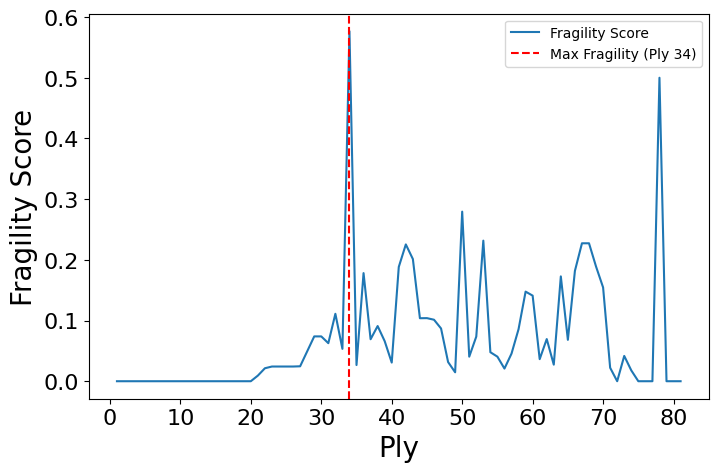

Displaying the state **after** the move causing maximum fragility:


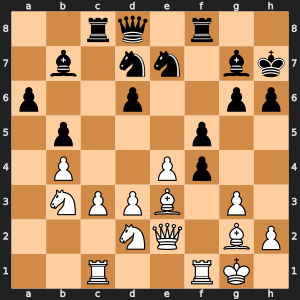

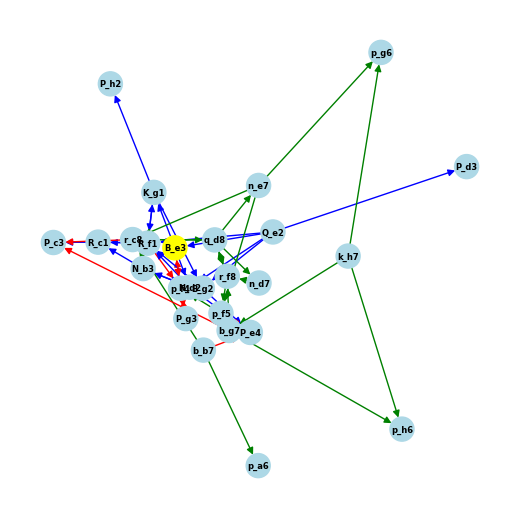

In [1]:
!pip install python-chess
!pip install --upgrade matplotlib networkx
#!pip install --upgrade matplotlib

import chess
import chess.pgn
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import SVG, display
import chess.svg
import chardet

# Function for computing the interaction graph for a given color, with pawn capturing rules applied
def compute_interactions_for_color(board, color_turn):
    G = nx.DiGraph()
    piece_positions = {square: board.piece_at(square) for square in chess.SQUARES if board.piece_at(square)}
    
    board_copy = board.copy()
    board_copy.turn = color_turn
    
    for square_a, piece_a in piece_positions.items():
        if piece_a.color == color_turn:
            node_a = f"{piece_a.symbol()}_{chess.square_name(square_a)}"  # Include position in node name
            for square_b, piece_b in piece_positions.items():
                if square_a != square_b:
                    node_b = f"{piece_b.symbol()}_{chess.square_name(square_b)}"  # Include position in node name
                    
                    # Defense link (same color)
                    if piece_a.color == piece_b.color:
                        board_copy.remove_piece_at(square_b)
                        if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                            G.add_edge(node_a, node_b, color='blue' if color_turn == chess.WHITE else 'green')
                        board_copy.set_piece_at(square_b, piece_b)
                    # Attack link (different color)
                    elif piece_a.color != piece_b.color:
                        # Special rule for pawns: can only capture diagonally if an enemy piece is present
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    G.add_edge(node_a, node_b, color='red')
                        else:  # For non-pawn pieces, follow the usual logic
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                G.add_edge(node_a, node_b, color='red')
    return G



# Function to compute the full interaction graph
def compute_full_interaction_graph(board):
    G_white = compute_interactions_for_color(board, chess.WHITE)
    G_black = compute_interactions_for_color(board, chess.BLACK)
    G_full = nx.compose(G_white, G_black)
    return G_full

# Function to check if a piece is under attack
def is_piece_under_attack(board, square, color):
    return bool(list(board.attackers(not color, square)))

# Compute Betweenness Centrality for each piece
def compute_betweenness_centrality(G):
    return nx.betweenness_centrality(G, normalized=True)

# Function to compute fragility score for a given color and determine the key piece under attack
def compute_fragility_score(board, G, color):
    betweenness = compute_betweenness_centrality(G)
    fragility_score = 0
    max_betweenness_under_attack = 0
    key_piece_under_attack = None

    # Iterate over pieces and compute fragility score
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            under_attack = is_piece_under_attack(board, square, color)
            piece_symbol = f"{piece.symbol()}_{chess.square_name(square)}"
            if under_attack and betweenness.get(piece_symbol, 0) > max_betweenness_under_attack:
                max_betweenness_under_attack = betweenness[piece_symbol]
                key_piece_under_attack = piece_symbol
            fragility_score += betweenness.get(piece_symbol, 0) * under_attack

    return fragility_score, key_piece_under_attack

# Function to process a single game and compute fragility score over time
def process_single_game(game):
    board = game.board()
    fragility_over_time = []
    board_states_before_move = []  # Store the board state **before** the move at each ply
    board_states_after_move = []   # Store the board state **after** the move at each ply
    moves = []  # To store the moves made
    pieces_making_moves = []  # To store the piece making each move
    key_pieces_under_attack = []  # To store the key piece under attack for each ply

    for move in game.mainline_moves():
        # Store the piece making the move before pushing the move
        piece_making_move = board.piece_at(move.from_square)
        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

        board_states_before_move.append(board.copy())  # Store board **before** the move
        board.push(move)  # Make the move
        board_states_after_move.append(board.copy())   # Store board **after** the move
        moves.append(move)  # Store the move

        # Compute the full interaction graph
        G_full = compute_full_interaction_graph(board)

        # Compute fragility score for white and black and determine the key piece under attack
        white_fragility, white_key_piece = compute_fragility_score(board, G_full, chess.WHITE)
        black_fragility, black_key_piece = compute_fragility_score(board, G_full, chess.BLACK)
        total_fragility = white_fragility + black_fragility

        fragility_over_time.append(total_fragility)
        key_pieces_under_attack.append(white_key_piece if white_key_piece else black_key_piece)

    # Find the ply with maximum fragility
    max_fragility_ply = np.argmax(fragility_over_time) + 1  # Adjust to match 1-based ply numbering
    
    # Get the move at the maximum fragility ply
    move_at_max_fragility = moves[max_fragility_ply - 1] if max_fragility_ply - 1 < len(moves) else None

    # Get the piece that made the move leading to maximum fragility
    piece_at_max_fragility = pieces_making_moves[max_fragility_ply - 1] if max_fragility_ply - 1 < len(pieces_making_moves) else None

    # Get the key piece under attack at maximum fragility
    key_piece_at_max_fragility = key_pieces_under_attack[max_fragility_ply - 1] if max_fragility_ply - 1 < len(key_pieces_under_attack) else None

    # Calculate fragility before and after the move at the maximum fragility ply
    fragility_before = fragility_over_time[max_fragility_ply - 2] if max_fragility_ply - 1 > 0 else None
    fragility_after = fragility_over_time[max_fragility_ply - 1]

    # Return both board states (before and after) and the interaction graph for that state
    return (fragility_over_time, board_states_before_move[max_fragility_ply - 1], board_states_after_move[max_fragility_ply - 1],
            max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, key_piece_at_max_fragility, 
            fragility_before, fragility_after, moves[:max_fragility_ply])

# Function to plot the fragility score over time (with correct ply numbering starting from 1)
def plot_fragility_over_time(fragility_over_time, max_fragility_ply):
    plt.figure(figsize=(8, 5))
    x = np.arange(1, len(fragility_over_time) + 1)  # Adjust ply numbers to start at 1
    plt.plot(x, fragility_over_time, label='Fragility Score')
    plt.axvline(x=max_fragility_ply, color='r', linestyle='--', label=f'Max Fragility (Ply {max_fragility_ply})')
    plt.xlabel('Ply', fontsize=20)
    plt.ylabel('Fragility Score', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.show()

# Function to display the board and interaction graph, highlighting the key piece under attack
def display_board_and_interaction_graph(board, G_full, move_at_max_fragility, key_piece_at_max_fragility, position_type="before"):
    # Show the chessboard image as an SVG
    svg_image = chess.svg.board(board=board, size=300)
    display(SVG(svg_image))  # Display the board
   
    # Save the SVG image to a file
    with open("chess_board.svg", "w") as f:
        f.write(svg_image)
    

    # Plot the interaction graph
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G_full)
    colors = [G_full[u][v]['color'] for u, v in G_full.edges]
    node_colors = ['yellow' if node == key_piece_at_max_fragility else 'lightblue' for node in G_full.nodes]
    nx.draw(G_full, pos, edge_color=colors, with_labels=True, node_size=300, node_color=node_colors, font_size=6, font_weight='bold')
    plt.show()

import chardet

def process_pgn_files_in_folder(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    # Process the game and compute fragility
                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)

                    # Print the move and fragility before and after the move at maximum fragility
                    print(f"Maximum fragility occurs at ply: {max_fragility_ply}")
                    print(f"Move at maximum fragility: {move_at_max_fragility}")
                    print(f"Piece that made the move: {piece_at_max_fragility}")
                    print(f"Key piece under attack: {key_piece_at_max_fragility}")
                    print(f"Fragility before the move: {fragility_before}")
                    print(f"Fragility after the move: {fragility_after}")

                    # Plot the fragility score over time
                    plot_fragility_over_time(fragility_over_time, max_fragility_ply)

                    # Compute the interaction graph **before** and **after** the move at the maximum fragility ply
                    G_full_before = compute_full_interaction_graph(board_before_move)
                    G_full_after = compute_full_interaction_graph(board_after_move)

                    # Display the board and interaction graph after the move at maximum fragility
                    print("Displaying the state **after** the move causing maximum fragility:")
                    display_board_and_interaction_graph(board_after_move, G_full_after, move_at_max_fragility, key_piece_at_max_fragility, position_type="after")
                except UnicodeDecodeError as e:
                    print(f"UnicodeDecodeError while reading {file_name}: {e}")

# Path to the folder containing PGN files
folder_path = 'data/partite'

process_pgn_files_in_folder(folder_path)


# tutte le betweenness

In [ ]:
# Function to compute fragility score for a given color and determine the key piece under attack
def compute_fragility_score_tot(board, G):
    betweenness = compute_betweenness_centrality(G)
    total_betweenness = sum(betweenness.values())  # Somma di tutte le centralità
    return total_betweenness
    #return len(betweenness)



def process_single_game_tot(game):
    board = game.board()
    fragility_over_time = []
    board_states_before_move = []  # Store the board state **before** the move at each ply
    board_states_after_move = []   # Store the board state **after** the move at each ply
    moves = []  # To store the moves made
    pieces_making_moves = []  # To store the piece making each move
    key_pieces_under_attack = []  # To store the key piece under attack for each ply

    for move in game.mainline_moves():
        # Store the piece making the move before pushing the move
        piece_making_move = board.piece_at(move.from_square)
        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

        board_states_before_move.append(board.copy())  # Store board **before** the move
        board.push(move)  # Make the move
        board_states_after_move.append(board.copy())   # Store board **after** the move
        moves.append(move)  # Store the move

        # Compute the full interaction graph
        G_full = compute_full_interaction_graph(board)

        # Compute fragility score for white and black and determine the key piece under attack
        total_fragility = compute_fragility_score_tot(board, G_full)

        fragility_over_time.append(total_fragility)


    # Return both board states (before and after) and the interaction graph for that state
    return fragility_over_time

In [ ]:
def compute_fragility_score_quasi_tot(board, G):
    betweenness = compute_betweenness_centrality(G)
    fragility_score = 0
    key_piece_under_attack = None

    # Iterate over pieces and compute fragility score
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_symbol = f"{piece.symbol()}_{chess.square_name(square)}"
            
            #fragility_score += 1
            
            fragility_score += betweenness.get(piece_symbol, 0)

    return fragility_score

def process_single_game_quasi_tot(game):
    board = game.board()
    fragility_over_time = []
    board_states_before_move = []  # Store the board state **before** the move at each ply
    board_states_after_move = []   # Store the board state **after** the move at each ply
    moves = []  # To store the moves made
    pieces_making_moves = []  # To store the piece making each move
    key_pieces_under_attack = []  # To store the key piece under attack for each ply

    for move in game.mainline_moves():
        # Store the piece making the move before pushing the move
        piece_making_move = board.piece_at(move.from_square)
        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

        board_states_before_move.append(board.copy())  # Store board **before** the move
        board.push(move)  # Make the move
        board_states_after_move.append(board.copy())   # Store board **after** the move
        moves.append(move)  # Store the move

        # Compute the full interaction graph
        G_full = compute_full_interaction_graph(board)

        # Compute fragility score for white and black and determine the key piece under attack
        total_fragility = compute_fragility_score_quasi_tot(board, G_full)

        fragility_over_time.append(total_fragility)


    # Return both board states (before and after) and the interaction graph for that state
    return fragility_over_time

# autovalori massimi

In [2]:
# Function to process a single game and compute fragility score over time
def process_single_game_max_eigenvalue(game):
    board = game.board()
    values = []
    board_states_before_move = []  # Store the board state **before** the move at each ply
    board_states_after_move = []   # Store the board state **after** the move at each ply
    moves = []  # To store the moves made
    pieces_making_moves = []  # To store the piece making each move
    key_pieces_under_attack = []  # To store the key piece under attack for each ply

    for move in game.mainline_moves():
        # Store the piece making the move before pushing the move
        piece_making_move = board.piece_at(move.from_square)
        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

        board_states_before_move.append(board.copy())  # Store board **before** the move
        board.push(move)  # Make the move
        board_states_after_move.append(board.copy())   # Store board **after** the move
        moves.append(move)  # Store the move

        # Compute the full interaction graph
        G_full = compute_full_interaction_graph(board)
        
        # Calcola la matrice di adiacenza del grafo diretto
        try:
            A = nx.adjacency_matrix(G_full).todense()

            # Calcola gli autovalori della matrice di adiacenza
            eigenvalues = np.linalg.eigvals(A)

            # Estrai il massimo autovalore
            max_eigenvalue = np.max(np.real(eigenvalues))
        
        except:
            max_eigenvalue = 0

        values.append(max_eigenvalue)


    # Return both board states (before and after) and the interaction graph for that state
    return values

In [3]:
reds  = ["#d50000", "#ff6d00"]  # rosso puro e arancione acceso
blues = ["#2962ff", "#00b8d4"]  # blu intenso e turchese brillante
greys = ["#ffffff", "#e0e0e0"]  # bianco, grigio molto chiaro




# Function for computing the interaction graph for a given color, with pawn capturing rules applied
def compute_interactions_for_color(board, color_turn):
    G = nx.DiGraph()
    piece_positions = {square: board.piece_at(square) for square in chess.SQUARES if board.piece_at(square)}
    
    board_copy = board.copy()
    board_copy.turn = color_turn
    
    for square_a, piece_a in piece_positions.items():
        if piece_a.color == color_turn:
            node_a = f"{piece_a.symbol()}_{chess.square_name(square_a)}"  # Include position in node name
            for square_b, piece_b in piece_positions.items():
                if square_a != square_b:
                    node_b = f"{piece_b.symbol()}_{chess.square_name(square_b)}"  # Include position in node name
                    
                    # Defense link (same color)
                    if piece_a.color == piece_b.color:
                        board_copy.remove_piece_at(square_b)
                        
                        if piece_a.color == chess.WHITE:
                            # Se il pezzo rimosso è bianco, metti un pedone nero
                            board_copy.set_piece_at(square_b, chess.Piece(chess.PAWN, chess.BLACK))
                        else:
                            # Se il pezzo rimosso è nero, metti un pedone bianco
                            board_copy.set_piece_at(square_b, chess.Piece(chess.PAWN, chess.WHITE))
                            
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                    G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                    G.add_edge(node_a, node_b, color=blues[0] if color_turn == chess.WHITE else blues[1])
                        else:
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                G.add_edge(node_a, node_b, color=blues[0] if color_turn == chess.WHITE else blues[1])
                        
                        board_copy.remove_piece_at(square_b)
                        board_copy.set_piece_at(square_b, piece_b)
                        '''
                        if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                            G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                            G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                            G.add_edge(node_a, node_b, color=blues[0] if color_turn == chess.WHITE else blues[1])
                        board_copy.set_piece_at(square_b, piece_b)
                        '''
                    # Attack link (different color)
                    elif piece_a.color != piece_b.color:
                        # Special rule for pawns: can only capture diagonally if an enemy piece is present
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                    G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                    G.add_edge(node_a, node_b, color=reds[0] if color_turn == chess.WHITE else reds[1])
                        else:  # For non-pawn pieces, follow the usual logic
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                G.add_edge(node_a, node_b, color=reds[0] if color_turn == chess.WHITE else reds[1])
    return G

In [ ]:
# PER OTTENERE I PEZZI

# Function for computing the interaction graph for a given color, with pawn capturing rules applied
def compute_P(board):
    G = nx.DiGraph()
    color_turn = chess.WHITE
    piece_positions = {square: board.piece_at(square) for square in chess.SQUARES if board.piece_at(square)}
    
    board_copy = board.copy()
    board_copy.turn = color_turn
    
    g1 = []
    g2 = []
    
    for square_a, piece_a in piece_positions.items():
        node_a = f"{piece_a.symbol()}_{chess.square_name(square_a)}"  # Include position in node name
        if piece_a.color == color_turn:
            g1.append(node_a)
        else:
            g2.append(node_a)
            
    
    
    return (g1, g2)

1
[1.0, 1.0, 1.465571231876766, 1.465571231876766, 1.4655712318767677, 1.4655712318767677, 1.3247179572447458, 1.3247179572447458, 1.3247179572447458, 1.3247179572447458, 1.8392867552141605, 1.8392867552141605, 1.8392867552141616, 1.839286755214162, 1.839286755214164, 1.8392867552141605, 1.8392867552141599, 1.839286755214163, 2.175361297610463, 2.1753612976104653, 1.8392867552141625, 2.000000000000001, 2.000000000000002, 2.069380294361137, 2.0784616234630984, 2.0784616234631006, 2.219136656353072, 2.2191366563530814, 2.1478990357047856, 2.1478990357047874, 1.769292354238631, 1.76929235423863, 1.7692923542386323, 2.0442036526548577, 1.9599850287759346, 2.113147989964421, 1.7505755601117852, 1.7505755601117838, 1.3247179572447458, 1.0, 1.3247179572447432, 1.414213562373097, 1.3247179572447472, 1.3247179572447447, 1.3247179572447445, 1.3247179572447452, 1.3247179572447503, 1.3247179572447458, 1.3247179572447458, 1.6180339887498942, 1.3247179572447458, 1.3247179572447458, 1.324717957244745

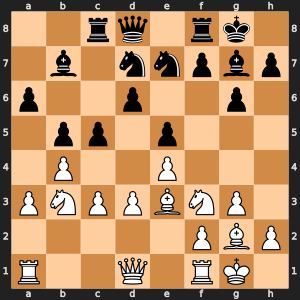

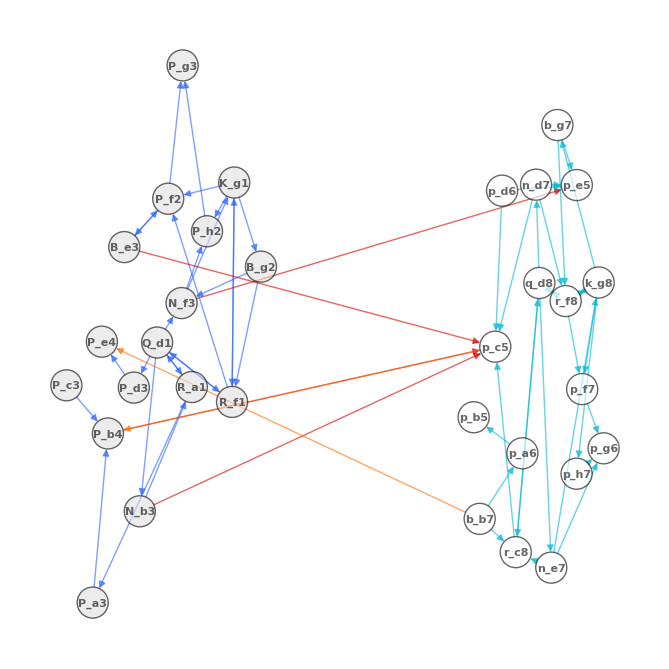

<Figure size 800x500 with 0 Axes>

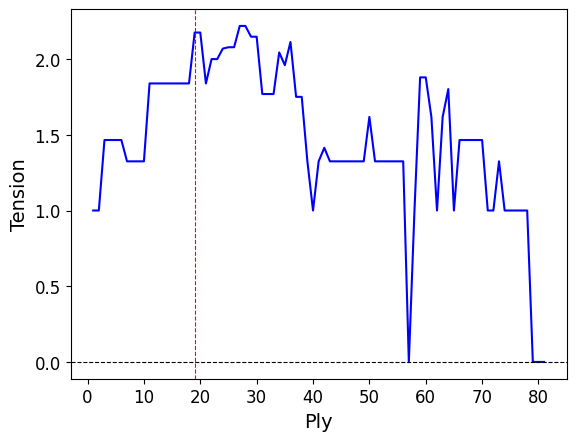

In [4]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\matches"

import statistics as st
import math


i = 0

valori = []

N_tot = 10

for file_name in os.listdir(folder_path):
    i += 1
    #if i == N_tot:
    #    break
    print(i)
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        #print(f"Processing file: {file_path}")
        #print(file_path)
        

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            #print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

                game = chess.pgn.read_game(f)
                break

print(process_single_game_max_eigenvalue(game))   

l = process_single_game_max_eigenvalue(game)

#print(l.index(max(l)))

i = 0

def euclidean_distance(p1, p2):
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

min_distance = 0.6
                

board = game.board()
values = []
board_states_before_move = []  # Store the board state **before** the move at each ply
board_states_after_move = []   # Store the board state **after** the move at each ply
moves = []  # To store the moves made
pieces_making_moves = []  # To store the piece making each move
key_pieces_under_attack = []  # To store the key piece under attack for each ply

for move in game.mainline_moves():
    # Store the piece making the move before pushing the move
    piece_making_move = board.piece_at(move.from_square)
    piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
    pieces_making_moves.append(piece_symbol)  # Store the piece symbol

    board_states_before_move.append(board.copy())  # Store board **before** the move
    board.push(move)  # Make the move
    board_states_after_move.append(board.copy())   # Store board **after** the move
    moves.append(move)  # Store the move

    # Compute the full interaction graph
    G_full = compute_full_interaction_graph(board)
    
    try:
        A = nx.adjacency_matrix(G_full).todense()

        # Calcola gli autovalori della matrice di adiacenza
        eigenvalues = np.linalg.eigvals(A)

        # Estrai il massimo autovalore
        max_eigenvalue = np.max(np.real(eigenvalues))
        
    except:
        max_eigenvalue = 0

    values.append(max_eigenvalue)
    
    if i == 23:
        print(values)
        svg_image = chess.svg.board(board=board, size=300)
        display(SVG(svg_image))  # Display the board
   
        # Save the SVG image to a file
        with open("chess_board.svg", "w") as f:
            f.write(svg_image)
            
        #g1 = compute_P(board)
    

        plt.figure(figsize=(6.5, 6.5))
        #pos = nx.bipartite_layout(G_full, g1[0])
        pos = nx.kamada_kawai_layout(G_full, scale=2)  # Prova con 2, 3, 5...
        
        import random

        for node in pos:
            x, y = pos[node]
            if node[0].isupper():
                # Sposta a sinistra con un po' di randomizzazione
                pos[node] = (x - 2 + random.uniform(-0.7, 0.7), y + random.uniform(-0.7, 0.7))
            else:
                # Sposta a destra con un po' di randomizzazione
                pos[node] = (x + 2 + random.uniform(-0.7, 0.7), y + random.uniform(-0.7, 0.7))
        
        posizioni = []


        for node in pos:
            x, y = pos[node]
            if node[0].isupper():
                # Sposta a sinistra con un po' di randomizzazione
                cond = True
                j = 0
                while cond:
                    j +=1
                    pos[node] = (x - 2 + random.uniform(-0.4, 0.4), y + random.uniform(-0.4, 0.4))
                    if (all(euclidean_distance(pos[node], existing) >= min_distance for existing in posizioni)) | (j > 1000):
                        cond = False
                        posizioni.append(pos[node])
                

            else:
                # Sposta a destra con un po' di randomizzazione
        
                cond = True
                j = 0
                while cond:
                    j +=1
                    pos[node] = (x + 2 + random.uniform(-0.4, 0.4), y + random.uniform(-0.4, 0.4))
                    if (all(euclidean_distance(pos[node], existing) >= min_distance for existing in posizioni)) | (j > 1000):
                        cond = False
                        posizioni.append(pos[node])


        
        colors = [G_full[u][v]['color'] for u, v in G_full.edges]
        node_colors = [G_full.nodes[node].get('color', 'white') for node in G_full.nodes]
        #node_colors = ['white' for node in G_full.nodes]

        nx.draw(
    G_full, pos,
    edge_color=colors,
    with_labels=True,
    node_size=500,          # aumentato da 300 → 400
    node_color=node_colors,
    font_size=8,            # aumentato da 6 → 8
    font_weight='bold',
    edgecolors='black',
    alpha=0.6
        )


        plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\RISULTATI_17-03\chess_network3.png", dpi=1200, bbox_inches='tight')  # <-- questa riga salva il file

    
    i += 1


plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(1, len(values) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, values, label='Humans', color = "blue")


ax.set_xlabel('Ply', fontsize=14)
ax.set_ylabel('Tension', fontsize=14)


ax.tick_params(axis='x', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse X
ax.tick_params(axis='y', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse Y
#ax.set_xlim(0, 180)  # Imposta il range dell'asse X

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(x=19, color='red', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
#ax.legend(fontsize=8) 
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\RISULTATI_17-03\test2.png", dpi=2000, bbox_inches="tight")  # Save as PNG with high resolution




# Voglio rappresentare più configurazioni

In [ ]:
# Function to compute the full interaction graph
def compute_full_interaction_graph(board):
    G_white = compute_interactions_for_color(board, chess.WHITE)
    G_black = compute_interactions_for_color(board, chess.BLACK)
    G_full = nx.compose(G_white, G_black)
    return G_full

# Function to check if a piece is under attack
def is_piece_under_attack(board, square, color):
    return bool(list(board.attackers(not color, square)))

# Compute Betweenness Centrality for each piece
def compute_betweenness_centrality(G):
    return nx.betweenness_centrality(G, normalized=True)

# Function to compute fragility score for a given color and determine the key piece under attack
def compute_fragility_score(board, G, color):
    betweenness = compute_betweenness_centrality(G)
    fragility_score = 0
    max_betweenness_under_attack = 0
    key_piece_under_attack = None

    # Iterate over pieces and compute fragility score
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            under_attack = is_piece_under_attack(board, square, color)
            piece_symbol = f"{piece.symbol()}_{chess.square_name(square)}"
            if under_attack and betweenness.get(piece_symbol, 0) > max_betweenness_under_attack:
                max_betweenness_under_attack = betweenness[piece_symbol]
                key_piece_under_attack = piece_symbol
            fragility_score += betweenness.get(piece_symbol, 0) * under_attack

    return fragility_score, key_piece_under_attack

def get_kth_largest(fragility_over_time, x):
    # Ordina gli indici in base ai valori di fragility_over_time in ordine decrescente
    sorted_indices = np.argsort(fragility_over_time)[::-1]
    # Restituisci il valore corrispondente all'indice k-esimo
    return sorted_indices[x]

# Function to process a single game and compute fragility score over time
def process_single_game(game, x):
    board = game.board()
    fragility_over_time = []
    board_states_before_move = []  # Store the board state **before** the move at each ply
    board_states_after_move = []   # Store the board state **after** the move at each ply
    moves = []  # To store the moves made
    pieces_making_moves = []  # To store the piece making each move
    key_pieces_under_attack = []  # To store the key piece under attack for each ply

    for move in game.mainline_moves():
        # Store the piece making the move before pushing the move
        piece_making_move = board.piece_at(move.from_square)
        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

        board_states_before_move.append(board.copy())  # Store board **before** the move
        board.push(move)  # Make the move
        board_states_after_move.append(board.copy())   # Store board **after** the move
        moves.append(move)  # Store the move

        # Compute the full interaction graph
        G_full = compute_full_interaction_graph(board)

        # Compute fragility score for white and black and determine the key piece under attack
        white_fragility, white_key_piece = compute_fragility_score(board, G_full, chess.WHITE)
        black_fragility, black_key_piece = compute_fragility_score(board, G_full, chess.BLACK)
        total_fragility = white_fragility + black_fragility

        fragility_over_time.append(total_fragility)
        key_pieces_under_attack.append(white_key_piece if white_key_piece else black_key_piece)

    # Find the ply with maximum fragility
    max_fragility_ply = get_kth_largest(fragility_over_time, x) + 1  # Adjust to match 1-based ply numbering
    
    # Get the move at the maximum fragility ply
    move_at_max_fragility = moves[max_fragility_ply - 1] if max_fragility_ply - 1 < len(moves) else None

    # Get the piece that made the move leading to maximum fragility
    piece_at_max_fragility = pieces_making_moves[max_fragility_ply - 1] if max_fragility_ply - 1 < len(pieces_making_moves) else None

    # Get the key piece under attack at maximum fragility
    key_piece_at_max_fragility = key_pieces_under_attack[max_fragility_ply - 1] if max_fragility_ply - 1 < len(key_pieces_under_attack) else None

    # Calculate fragility before and after the move at the maximum fragility ply
    fragility_before = fragility_over_time[max_fragility_ply - 2] if max_fragility_ply - 1 > 0 else None
    fragility_after = fragility_over_time[max_fragility_ply - 1]

    # Return both board states (before and after) and the interaction graph for that state
    return (fragility_over_time, board_states_before_move[max_fragility_ply - 1], board_states_after_move[max_fragility_ply - 1],
            max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, key_piece_at_max_fragility, 
            fragility_before, fragility_after, moves[:max_fragility_ply])





























# Function to plot the fragility score over time (with correct ply numbering starting from 1)
def plot_fragility_over_time(fragility_over_time, max_fragility_ply, y):
    plt.figure(figsize=(8, 5))
    x = np.arange(1, len(fragility_over_time) + 1)  # Adjust ply numbers to start at 1
    
    ordinal = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh", "eighth", "ninth", "tenth"]
    
    colors = ['r', 'b', 'g']
    
    plt.plot(x, fragility_over_time)
    for i in range(len(y)):
        
        # Assicurati che x non vada oltre il limite
        if y[i] < len(ordinal):
            max_fragility_text = f"{ordinal[y[i]]} highest, Ply {max_fragility_ply[i]}"
        else:
            max_fragility_text = f"Max Fragility (Ply {max_fragility_ply[i]})"  # Caso di x > 9
        
        plt.axvline(x=max_fragility_ply[i], color=colors[i], linestyle='--', linewidth=0.8, label=max_fragility_text)
    plt.xlabel('Ply', fontsize=20)
    plt.ylabel('Fragility Score', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.show()

# Function to display the board and interaction graph, highlighting the key piece under attack
def display_board_and_interaction_graph(board, G_full, move_at_max_fragility, key_piece_at_max_fragility, position_type="before"):
    # Show the chessboard image as an SVG
    svg_image = chess.svg.board(board=board, size=300)
    display(SVG(svg_image))  # Display the board
   
    # Save the SVG image to a file
    with open("chess_board.svg", "w") as f:
        f.write(svg_image)
    

    # Plot the interaction graph
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G_full)
    colors = [G_full[u][v]['color'] for u, v in G_full.edges]
    node_colors = ['yellow' if node == key_piece_at_max_fragility else 'lightblue' for node in G_full.nodes]
    nx.draw(G_full, pos, edge_color=colors, with_labels=True, node_size=300, node_color=node_colors, font_size=6, font_weight='bold')
    plt.show()

import chardet

def process_pgn_files_in_folder(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    l = [0]
                    frags = []
                    
                    for i in range(len(l)):
                        # Process the game and compute fragility
                        (fragility_over_time, board_before_move, board_after_move, 
                         max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                         key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game, l[i])

                        # Compute the interaction graph **before** and **after** the move at the maximum fragility ply
                        G_full_before = compute_full_interaction_graph(board_before_move)
                        G_full_after = compute_full_interaction_graph(board_after_move)

                        # Display the board and interaction graph after the move at maximum fragility
                        print("Displaying the state **after** the move causing maximum fragility:")
                        display_board_and_interaction_graph(board_after_move, G_full_after, move_at_max_fragility, key_piece_at_max_fragility, position_type="after")
                        
                        frags.append(max_fragility_ply)
                    
                    # Plot the fragility score over time
                    plot_fragility_over_time(fragility_over_time, frags, l)

                    
                
                except UnicodeDecodeError as e:
                    print(f"UnicodeDecodeError while reading {file_name}: {e}")

# Path to the folder containing PGN files
folder_path = 'data/partite'

process_pgn_files_in_folder(folder_path)

# When people give up?

In [5]:
#!pip install stockfish
from stockfish import Stockfish
import chess.pgn
import random
import pandas as pd

stockfish = Stockfish(path=r"C:\Users\Pc\Desktop\PHYTON\Chess\stockfish\stockfish-windows-x86-64-avx2.exe")


In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\matches"

import statistics as st
import math


i = 0

valori = []

N_tot = 10

for file_name in os.listdir(folder_path):
    i += 1
    #if i == N_tot:
    #    break
    print(i)
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        #print(f"Processing file: {file_path}")
        #print(file_path)
        

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            #print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

                game = chess.pgn.read_game(f)
                result = game.headers.get("Result")
                
                board = game.end().board()
                #print(board)
                
                if board.is_checkmate():
                    print("CHECKMATE")
                else:
                
                    # Imposta la posizione su Stockfish
                    stockfish.set_fen_position(board.fen())

                    # Ottieni la valutazione della posizione
                    evaluation = stockfish.get_evaluation()
                
                    valori.append(abs(evaluation["value"]))
                

valori = [x/100 for x in valori]         
sem = st.stdev(valori) / math.sqrt(len(valori))
                
plt.rcParams.update({'font.size': 14})
# Creazione dell'istogramma
plt.figure(figsize=(8, 6))  # Imposta la dimensione della figura
plt.hist(valori, color='blue', alpha=0.5, edgecolor='black')

# Aggiunta di una linea verticale
threshold = 0  # Cambia il valore per posizionare la linea
plt.axvline(x=st.mean(valori), color='red', linestyle='--', linewidth=2, label=str(round(st.mean(valori), 2)) + " ± " + str(round(sem, 2)))

# Personalizzazioni
plt.xlabel('stockfish evaluation (pawns)')
plt.ylabel('frequency')
#plt.title('Istogramma con linea verticale')
plt.legend()

# Salvataggio dell'immagine come PNG ad alta risoluzione (300 DPI)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\meeting2\plot1.png", dpi=300, bbox_inches='tight')


            
print(st.mean(valori)) 
sem = st.stdev(valori) / math.sqrt(len(valori))  # Calcolo dell'errore standard
print("Errore sulla media:", sem)  
                    
# valori = 355.27676620538966 +- 5.552878653489649


# When people want to tie?

In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\matches"
import statistics as st
import math

i = 0

valori = []
mosse = []

N_tot = 20

for file_name in os.listdir(folder_path):
    i += 1
    #if i == N_tot:
    #    break
    #print(i)
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        #print(f"Processing file: {file_path}")
        #print(file_path)
        

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            #print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

                game = chess.pgn.read_game(f)
                result = game.headers.get("Result")
                
                if result == "1/2-1/2":
                    #print("ciao")
                    board = game.end().board()
                
                    # Imposta la posizione su Stockfish
                    stockfish.set_fen_position(board.fen())
                    

                    # Ottieni la valutazione della posizione
                    evaluation = stockfish.get_evaluation()
                
                    valori.append(abs(evaluation["value"]))
                    #print(evaluation["value"])
                    
                    mosse.append(len(list(game.mainline_moves())))
                    
                    #total_moves = len(list(game.mainline_moves()))
                    #print("le mosse sono: " +str(total_moves))
                
valori = [x/100 for x in valori]         
sem = st.stdev(valori) / math.sqrt(len(valori))
                
plt.rcParams.update({'font.size': 14})
# Creazione dell'istogramma
plt.figure(figsize=(8, 6))  # Imposta la dimensione della figura
plt.hist(valori, color='blue', alpha=0.5, edgecolor='black')

# Aggiunta di una linea verticale
threshold = 0  # Cambia il valore per posizionare la linea
plt.axvline(x=st.mean(valori), color='red', linestyle='--', linewidth=2, label=str(round(st.mean(valori), 2)) + " ± " + str(round(sem, 2)))

# Personalizzazioni
plt.xlabel('stockfish evaluation (centipawns)')
plt.ylabel('frequency')
#plt.title('Istogramma con linea verticale')
plt.legend()
plt.yscale('log')

# Salvataggio dell'immagine come PNG ad alta risoluzione (300 DPI)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\meeting2\plot2.png", dpi=300, bbox_inches='tight')
                
                
# numero di mosse  

valori = mosse
                
sem = st.stdev(valori) / math.sqrt(len(valori))
                
plt.rcParams.update({'font.size': 14})
# Creazione dell'istogramma
plt.figure(figsize=(8, 6))  # Imposta la dimensione della figura
plt.hist(valori, color='blue', alpha=0.5, edgecolor='black')

# Aggiunta di una linea verticale
threshold = 0  # Cambia il valore per posizionare la linea
plt.axvline(x=st.mean(valori), color='red', linestyle='--', linewidth=2, label=str(round(st.mean(valori), 2)) + " ± " + str(round(sem, 2)))

# Personalizzazioni
plt.xlabel('Ply')
plt.ylabel('frequency')
#plt.title('Istogramma con linea verticale')
plt.legend()

# Salvataggio dell'immagine come PNG ad alta risoluzione (300 DPI)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\meeting2\mosse.png", dpi=300, bbox_inches='tight')                
                
                
                
                
                
                
                
                
                
                
print(sum(valori)/len(valori))    # 22.086614173228348
sem = st.stdev(valori) / math.sqrt(len(valori))  # Calcolo dell'errore standard
print("Errore sulla media:", sem)  # 2.387697279469452
print(sum(mosse)/len(mosse))      # 111.76640419947506
sem = st.stdev(mosse) / math.sqrt(len(mosse))  # Calcolo dell'errore standard
print("Errore sulla media:", sem)  #  1.627169557681481

# How to substitute players with stockfishes?

In [ ]:
N = 1

folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\matches"

        
turns_to_skip = 10
i = 0

valori = []

#N_tot = 100

for file_name in os.listdir(folder_path):
    i += 1
    #if i <= 41:
    #    continue
    print(file_name)
    print(i)
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        #print(f"Processing file: {file_path}")
        #print(file_path)
        x = file_path.split("game_")[1].split(".pg")[0]
        print(x)

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            #print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:
            
            
                # Crea un nuovo gioco
                new_game = chess.pgn.Game()

                # Imposta l'evento e i giocatori
                new_game.headers["Event"] = "Stockfish vs Stockfish"
                new_game.headers["White"] = "Stockfish"
                new_game.headers["Black"] = "Stockfish"
    

                game = chess.pgn.read_game(f)
                
                # Inizializza la scacchiera
                board = game.board()

                # Copia le prime mosse umane nel nuovo PGN
                node = new_game
                old_node = game
                for _ in range(turns_to_skip):
                    if old_node.variations:
                        move = old_node.variations[0].move
                        #print(board)
                        board.push(move)
                        node = node.add_variation(move)  # Aggiunge la mossa al nuovo PGN
                        old_node = old_node.variations[0]
                    else:
                        print(f"Errore: la partita non ha abbastanza mosse per arrivare alla mossa {turns_to_skip}.")
                        break
                #print(board)
                
                # conto le mosse
                j = 0
                

                # Gioca la partita
                while not board.is_game_over():
                    
                    j += 1
                    
                    # Stockfish calcola la mossa migliore
                    if board.turn == chess.WHITE:
                        depth = 21  # Profondità per il bianco
                    else:
                        depth = random.randint(7, 9)  # Profondità per il nero
                    stockfish.set_depth(depth)
        
                    stockfish.set_fen_position(board.fen())
                    best_move = stockfish.get_best_move()
    
                    # Esegui la mossa sulla scacchiera
                    move = chess.Move.from_uci(best_move)
                    board.push(move)
                
                    stockfish.set_depth(20)
                    evaluation = stockfish.get_evaluation()
                    print(evaluation)
                    
    
                    # Aggiungi la mossa al gioco PGN
                    node = node.add_variation(move)  # Aggiungi la mossa come variazione al nodo corrente
            
                    if (abs(evaluation["value"]) >= 355) | ((j > 112) & (abs(evaluation["value"]) <= 22)):
                        break
    
                # Salva la partita in un file PGN
                with open(r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_9_21\match_" +  str(x) + ".pgn", "w", encoding="utf-8") as pgn_file:
                    new_game.accept(chess.pgn.FileExporter(pgn_file))



# How to use leela

# Let us measure the fragilities in the two cases

In [ ]:
#####################
#####################
#####################
#####################
#####################
#####################
# Process human games
from itertools import zip_longest
import os
import chardet

res = []
res1 = []

folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_leelas"
I_IA = 0
I = 0
First1 = True
First2 = True
i = 0

nomi = []

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if i == 443:
            break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")
            nomi.append(file_path)

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    I_IA = fragility_over_time
                    
                    #if First1:
                    #    First1 = False
                    #    I_IA = fragility_over_time
                    #else:
                    #    I_IA = [a + b for a, b in zip_longest(I_IA, fragility_over_time, fillvalue=0)]
                        
                        
            file_path = file_path.replace("match", "game")
            file_path = file_path.replace("IA_leelas", "matches")
            #print(f"Processing file: {file_path}")
            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    I = fragility_over_time
                    
                    res1.append([(a - b) for a, b in zip_longest(I, I_IA, fillvalue=0)])
                    res.append([(a - b)/((a+b)/2+0.001) for a, b in zip_longest(I, I_IA, fillvalue=0)])
                    
                    #if First2:
                    #    First2 = False
                    #    I = fragility_over_time
                    #else:
                    #    I = [a + b for a, b in zip_longest(I, fragility_over_time, fillvalue=0)]
                        
                        
                        
                        
                        
                        
                        
I_tot = res[0]

for i in range(1, len(res)):
    I_tot = [a + b for a, b in zip_longest(I_tot, res[i], fillvalue=0)]

I_tot1 = res1[0]

for i in range(1, len(res1)):
    I_tot1 = [a + b for a, b in zip_longest(I_tot1, res1[i], fillvalue=0)]


I_tot1 = [x/len(res1) for x in I_tot1]                      
I_tot1 = np.array(I_tot1)
I_tot = [100*x/len(res) for x in I_tot]                      
I_tot = np.array(I_tot)                        

x = np.arange(0, len(I_tot), 1)

# Create figure and subplots (2 rows, 1 column)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))  # sharex ensures aligned x-axes

# First plot (Top)
ax[0].fill_between(x, I_tot1, 0, where=(I_tot1 > 0), color="green", alpha=0.3, label="Humans")
ax[0].fill_between(x, I_tot1, 0, where=(I_tot1 < 0), color="red", alpha=0.3, label="Leela")
ax[0].axhline(0, color="black", linestyle="--", linewidth=0.5)
ax[0].set_ylabel('Fragility difference', fontsize=16)
ax[0].legend()

# Second plot (Bottom)
ax[1].fill_between(x, I_tot, 0, where=(I_tot > 0), color="green", alpha=0.3, label="Humans")
ax[1].fill_between(x, I_tot, 0, where=(I_tot < 0), color="red", alpha=0.3, label="Leela")
ax[1].axhline(0, color="black", linestyle="--", linewidth=0.5)
ax[1].set_xlabel('Ply', fontsize=16)
ax[1].set_ylabel('Fragility relative difference (%)', fontsize=16)
ax[1].legend()

#plt.plot(x_IA, I_IA, label='Stockfish')


plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\meeting2\LAND_leelas.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

# Who is winning?

In [ ]:
from itertools import zip_longest
import os
import sys
import chardet

res = []
res1 = []

folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_SUPERleela"
I_IA = 0
I = 0
First1 = True
First2 = True
i = 0

nomi = []

BIANCO = 0
NERO = 0
PARI = 0

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if i == 443:
            break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")
            nomi.append(file_path)

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                game = chess.pgn.read_game(f)
                if game is None:
                    print(f"No game found in file: {file_name}")
                    continue
                #result = game.headers.get("Result", "Unknown")  # Ottieni il risultato dal PGN
                result = game.headers.get("Result")
                
                board = game.board()  # Inizializza la scacchiera

                # Applica tutte le mosse fino all'ultima posizione
                for move in game.mainline_moves():
                    board.push(move)
                
                stockfish.set_fen_position(board.fen())
                evaluation = stockfish.get_evaluation()
                
                #print(f"Risultato della partita: {result} and {evaluation}")
                
                if evaluation["value"] >= 100:
                    BIANCO += 1
                elif evaluation["value"] <= - 100:
                    NERO += 1
                else:
                    PARI += 1
                    

BIANCO /= 0.45                    
NERO /= 0.45
PARI /= 0.45

print(BIANCO)
print(NERO)
print(PARI)
                        


# Strategic positions

In [ ]:
# Function for computing the interaction graph for a given color, with pawn capturing rules applied and map control
# Create a larger graph
def compute_interactions_for_color(board, color_turn):
    G = nx.DiGraph()
    piece_positions = {square: board.piece_at(square) for square in chess.SQUARES if board.piece_at(square)}
    
    board_copy = board.copy()
    board_copy.turn = color_turn
    
    
    for square_a, piece_a in piece_positions.items():
        
        all_nodes = []
        
        if piece_a.color == color_turn:
            node_a = f"{piece_a.symbol()}_{chess.square_name(square_a)}"  # Include position in node name
            all_nodes.append(chess.square_name(square_a))
            for square_b, piece_b in piece_positions.items():
                if square_a != square_b:
                    node_b = f"{piece_b.symbol()}_{chess.square_name(square_b)}"  # Include position in node name
                    all_nodes.append(chess.square_name(square_b))
                    # Defense link (same color)
                    if piece_a.color == piece_b.color:
                        board_copy.remove_piece_at(square_b)
                        if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                            G.add_edge(node_a, node_b, color='blue' if color_turn == chess.WHITE else 'green')
                        board_copy.set_piece_at(square_b, piece_b)
                    # Attack link (different color)
                    elif piece_a.color != piece_b.color:
                        # Special rule for pawns: can only capture diagonally if an enemy piece is present
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    G.add_edge(node_a, node_b, color='red')
                        else:  # For non-pawn pieces, follow the usual logic
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                G.add_edge(node_a, node_b, color='red')
            # Added part                    
            possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
            arrival_squares = [chess.square_name(move.to_square) for move in possible_moves]
            #movements_no_attack_defense = [x for x in arrival squares if x not in all_nodes]
            movements_no_attack_defense = [x for x in arrival_squares if x not in all_nodes]
            for moves in movements_no_attack_defense:
                node_b = f"{moves}"
                G.add_edge(node_a, node_b, color='lightblue' if color_turn == chess.WHITE else 'lightgreen')
                
    #print(all_nodes)
            
            
    return G

In [ ]:
# Function for computing the interaction graph for a given color, with pawn capturing rules applied
def compute_interactions_for_color(board, color_turn):
    G = nx.DiGraph()
    piece_positions = {square: board.piece_at(square) for square in chess.SQUARES if board.piece_at(square)}
    
    board_copy = board.copy()
    board_copy.turn = color_turn
    
    for square_a, piece_a in piece_positions.items():
        if piece_a.color == color_turn:
            node_a = f"{piece_a.symbol()}_{chess.square_name(square_a)}"  # Include position in node name
            for square_b, piece_b in piece_positions.items():
                if square_a != square_b:
                    node_b = f"{piece_b.symbol()}_{chess.square_name(square_b)}"  # Include position in node name
                    
                    # Defense link (same color)
                    if piece_a.color == piece_b.color:
                        board_copy.remove_piece_at(square_b)
                        if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                            G.add_edge(node_a, node_b, color='blue' if color_turn == chess.WHITE else 'green')
                        board_copy.set_piece_at(square_b, piece_b)
                    # Attack link (different color)
                    elif piece_a.color != piece_b.color:
                        # Special rule for pawns: can only capture diagonally if an enemy piece is present
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    G.add_edge(node_a, node_b, color='red')
                        else:  # For non-pawn pieces, follow the usual logic
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                G.add_edge(node_a, node_b, color='red')
    return G

In [ ]:
# Function for computing the interaction graph for a given color, with pawn capturing rules applied and map control
# Create a larger graph + weigths
def compute_interactions_for_color(board, color_turn):
    G = nx.DiGraph()
    piece_positions = {square: board.piece_at(square) for square in chess.SQUARES if board.piece_at(square)}
    
    board_copy = board.copy()
    board_copy.turn = color_turn
    
    piece_weights = {
    chess.PAWN: 1,
    chess.KNIGHT: 3.05,
    chess.BISHOP: 3.25,
    chess.ROOK: 5,
    chess.QUEEN: 9.5,
    chess.KING: 4  # Il re non ha un peso definito
    }
    
    
    for square_a, piece_a in piece_positions.items():
        
        all_nodes = []
        
        if piece_a.color == color_turn:
            node_a = f"{piece_a.symbol()}_{chess.square_name(square_a)}"  # Include position in node name
            all_nodes.append(chess.square_name(square_a))
            for square_b, piece_b in piece_positions.items():
                if square_a != square_b:
                    node_b = f"{piece_b.symbol()}_{chess.square_name(square_b)}"  # Include position in node name
                    all_nodes.append(chess.square_name(square_b))
                    # Defense link (same color)
                    if piece_a.color == piece_b.color:
                        board_copy.remove_piece_at(square_b)
                        if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                            if piece_a.piece_type == chess.PAWN:
                                weight = piece_weights[chess.PAWN]
                            elif piece_a.piece_type == chess.KNIGHT:
                                weight = piece_weights[chess.KNIGHT]
                            elif piece_a.piece_type == chess.BISHOP:
                                weight = piece_weights[chess.BISHOP]
                            elif piece_a.piece_type == chess.ROOK:
                                weight = piece_weights[chess.ROOK]
                            elif piece_a.piece_type == chess.QUEEN:
                                weight = piece_weights[chess.QUEEN]
                            elif piece_a.piece_type == chess.KING:
                                weight = piece_weights[chess.KING]
                            G.add_edge(node_a, node_b, weight=weight, color='blue' if color_turn == chess.WHITE else 'green')
                        board_copy.set_piece_at(square_b, piece_b)
                    # Attack link (different color)
                    elif piece_a.color != piece_b.color:
                        # Special rule for pawns: can only capture diagonally if an enemy piece is present
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    if piece_b.piece_type == chess.PAWN:
                                        weight = piece_weights[chess.PAWN]
                                    elif piece_b.piece_type == chess.KNIGHT:
                                        weight = piece_weights[chess.KNIGHT]
                                    elif piece_b.piece_type == chess.BISHOP:
                                        weight = piece_weights[chess.BISHOP]
                                    elif piece_b.piece_type == chess.ROOK:
                                        weight = piece_weights[chess.ROOK]
                                    elif piece_b.piece_type == chess.QUEEN:
                                        weight = piece_weights[chess.QUEEN]
                                    elif piece_b.piece_type == chess.KING:
                                        weight = piece_weights[chess.KING]
                                    G.add_edge(node_a, node_b, weight=1/weight, color='red')
                        else:  # For non-pawn pieces, follow the usual logic
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                if piece_b.piece_type == chess.PAWN:
                                    weight = piece_weights[chess.PAWN]
                                elif piece_b.piece_type == chess.KNIGHT:
                                    weight = piece_weights[chess.KNIGHT]
                                elif piece_b.piece_type == chess.BISHOP:
                                    weight = piece_weights[chess.BISHOP]
                                elif piece_b.piece_type == chess.ROOK:
                                    weight = piece_weights[chess.ROOK]
                                elif piece_b.piece_type == chess.QUEEN:
                                    weight = piece_weights[chess.QUEEN]
                                elif piece_b.piece_type == chess.KING:
                                    weight = piece_weights[chess.KING]
                                G.add_edge(node_a, node_b, weight=1/weight, color='red')
            # Added part                    
            possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
            arrival_squares = [chess.square_name(move.to_square) for move in possible_moves]
            #movements_no_attack_defense = [x for x in arrival squares if x not in all_nodes]
            movements_no_attack_defense = [x for x in arrival_squares if x not in all_nodes]
            for moves in movements_no_attack_defense:
                node_b = f"{moves}"
                G.add_edge(node_a, node_b, weight=1, color='lightblue' if color_turn == chess.WHITE else 'lightgreen')
                
    #print(all_nodes)
            
            
    return G

# Function to compute fragility score for a given color and determine the key piece under attack
def compute_fragility_score(board, G, color):
    betweenness = compute_betweenness_centrality(G)
    fragility_score = 0
    max_betweenness_under_attack = 0
    key_piece_under_attack = None
    
    piece_weights = {
    chess.PAWN: 1,
    chess.KNIGHT: 3.05,
    chess.BISHOP: 3.25,
    chess.ROOK: 5,
    chess.QUEEN: 9.5,
    chess.KING: 4  # Il re non ha un peso definito
    }

    # Iterate over pieces and compute fragility score
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            under_attack = is_piece_under_attack(board, square, color)
            piece_symbol = f"{piece.symbol()}_{chess.square_name(square)}"
            if under_attack and betweenness.get(piece_symbol, 0) > max_betweenness_under_attack:
                max_betweenness_under_attack = betweenness[piece_symbol]
                key_piece_under_attack = piece_symbol
            
            if piece.piece_type == chess.PAWN:
                weight = piece_weights[chess.PAWN]
            elif piece.piece_type == chess.KNIGHT:
                weight = piece_weights[chess.KNIGHT]
            elif piece.piece_type == chess.BISHOP:
                weight = piece_weights[chess.BISHOP]
            elif piece.piece_type == chess.ROOK:
                weight = piece_weights[chess.ROOK]
            elif piece.piece_type == chess.QUEEN:
                weight = piece_weights[chess.QUEEN]
            elif piece.piece_type == chess.KING:
                weight = piece_weights[chess.KING]
            
            fragility_score += weight*betweenness.get(piece_symbol, 0) * under_attack

    return fragility_score, key_piece_under_attack

def compute_betweenness_centrality(G):
    return nx.betweenness_centrality(G, normalized=True, weight='weight')


In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\humans"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {file_path}")

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

            game = chess.pgn.read_game(f)
            if game is None:
                print(f"No game found in file: {file_name}")
                continue
            else:
                board = game.board()
                i = 0
                for move in game.mainline_moves():
                    i += 1
                    board.push(move)
                    if i == 28:
                        break
                
                

                svg_image = chess.svg.board(board=board, size=300)
                display(SVG(svg_image))  # Display the board
                G_full = compute_full_interaction_graph(board)
                G_white = compute_interactions_for_color(board, chess.WHITE)
                G_black = compute_interactions_for_color(board, chess.BLACK)
                # Plot the interaction graph
                plt.figure(figsize=(5, 5))
                pos = nx.spring_layout(G_white)
                colors = [G_white[u][v]['color'] for u, v in G_white.edges]
                #node_colors = ['yellow' if node == key_piece_at_max_fragility else 'lightblue' for node in G_full.nodes]
                nx.draw(G_white, pos, edge_color=colors, with_labels=True, node_size=500, node_color="white", font_size=8, font_weight='bold')
                plt.show()
                (A, B) = compute_fragility_score(board, G_full, chess.WHITE)
                print(A)


In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\humans"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {file_path}")

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

            game = chess.pgn.read_game(f)
            if game is None:
                print(f"No game found in file: {file_name}")
                continue
            else:
                board = game.board()
                i = 0
                for move in game.mainline_moves():
                    i += 1
                    board.push(move)
                    if i == 28:
                        break
                svg_image = chess.svg.board(board=board, size=300)
                display(SVG(svg_image))  # Display the board
                G_full = compute_full_interaction_graph(board)
                G_white = compute_interactions_for_color(board, chess.WHITE)
                G_black = compute_interactions_for_color(board, chess.BLACK)
                # Plot the interaction graph
                plt.figure(figsize=(5, 5))
                pos = nx.spring_layout(G_black)
                colors = [G_black[u][v]['color'] for u, v in G_black.edges]
                #node_colors = ['yellow' if node == key_piece_at_max_fragility else 'lightblue' for node in G_full.nodes]
                nx.draw(G_black, pos, edge_color=colors, with_labels=True, node_size=500, node_color="white", font_size=8, font_weight='bold')
                plt.show()
                (A, B) = compute_fragility_score(board, G_full, chess.WHITE)
                print(A)

In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\humans"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {file_path}")

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

            game = chess.pgn.read_game(f)
            if game is None:
                print(f"No game found in file: {file_name}")
                continue
            else:
                board = game.board()
                i = 0
                for move in game.mainline_moves():
                    i += 1
                    board.push(move)
                    if i == 28:
                        break
                svg_image = chess.svg.board(board=board, size=300)
                display(SVG(svg_image))  # Display the board
                G_full = compute_full_interaction_graph(board)
                G_white = compute_interactions_for_color(board, chess.WHITE)
                G_black = compute_interactions_for_color(board, chess.BLACK)
                # Plot the interaction graph
                plt.figure(figsize=(5, 5))
                pos = nx.spring_layout(G_full)
                colors = [G_full[u][v]['color'] for u, v in G_full.edges]
                #node_colors = ['yellow' if node == key_piece_at_max_fragility else 'lightblue' for node in G_full.nodes]
                nx.draw(G_full, pos, edge_color=colors, with_labels=True, node_size=500, node_color="white", font_size=8, font_weight='bold')
                plt.show()
                (A, B) = compute_fragility_score(board, G_full, chess.WHITE)
                print(A)

In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\Landscape_humans"

n = 0
N = 0
i = 0

N_tot = 101

for file_name in os.listdir(folder_path):
    i += 1
    if i == N_tot:
        break
    print(i)
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        #print(f"Processing file: {file_path}")

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            #print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

                game = chess.pgn.read_game(f)
                result = game.headers.get("Result")
                if result == "1/2-1/2":
                    continue
                if game is None:
                    print(f"No game found in file: {file_name}")
                    continue
                else:
                    
                    (W, B) = process_single_game(game)
                    
                    I_W = 100*sum([x for x in W])/(len(W))
                    I_B = 100*sum([x for x in B])/(len(B))
                    
                    
                    print("The results are " + result + ", the values are: (" + str(I_W) + ", " + str(I_B) + ")")
                    if result == "1-0":
                        if I_W > I_B:
                            n +=1
                        N +=1
                    elif result == "0-1":
                        if I_B > I_W:
                            n +=1
                        N +=1
                    
                    

# average of number of occupations is 0.715625
# average (Misura di centralità e dispersione) is 0.615625

# Non conviene utilizzare misure più complicate

print(n/N)  

In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\humans"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {file_path}")

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

            game = chess.pgn.read_game(f)
            if game is None:
                print(f"No game found in file: {file_name}")
                continue
            else:
                board = game.board()
                svg_image = chess.svg.board(board=board, size=300)


In [ ]:
#print(map_control(board))

In [ ]:
# FUNCTION 1

import statistics as st
def map_control(board):
    MAP_W = []
    MAP_B = []
    board_copy = board.copy()
    first = True
    
    for move in game.mainline_moves():
        MAP_W_temp = []
        MAP_B_temp = []
        
        piece_positions = {square: board_copy.piece_at(square) for square in chess.SQUARES if board_copy.piece_at(square)}
        
        for square_a, piece_a in piece_positions.items():
            # Aggiungi la casella di partenza
            if piece_a.color:
                MAP_W_temp.append(square_a)
            else:
                MAP_B_temp.append(square_a)
            
            # Trova tutte le mosse legali
            possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
            arrival_squares = [moves.to_square for moves in possible_moves]
            
            # Aggiungi le caselle di arrivo (per movimento o cattura)
            for moves in arrival_squares:
                if piece_a.color:
                    MAP_W_temp.append(moves)
                else:
                    MAP_B_temp.append(moves)


        # Aggiungi il controllo territoriale
        if board_copy.turn == chess.WHITE:
            MAP_W.append(len(list(set(MAP_W_temp))))  # Caselle controllate dai bianchi
        else:
            MAP_B.append(len(list(set(MAP_B_temp))))  # Caselle controllate dai neri

        board_copy.push(move)  # Esegui la mossa

    return st.mean(MAP_W), st.mean(MAP_B)



In [ ]:
# FRAGILITY CALCULATION

def map_control(board):
    MAP_W = []
    MAP_B = []
    board_copy = board.copy()
    first = True
    
    for move in game.mainline_moves():
        MAP_W_temp = []
        MAP_B_temp = []
        
        piece_positions = {square: board_copy.piece_at(square) for square in chess.SQUARES if board_copy.piece_at(square)}
        
        for square_a, piece_a in piece_positions.items():
            # Aggiungi la casella di partenza
            if piece_a.color:
                MAP_W_temp.append(square_a)
            else:
                MAP_B_temp.append(square_a)
            
            # Trova tutte le mosse legali
            possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
            arrival_squares = [moves.to_square for moves in possible_moves]
            
            # Aggiungi le caselle di arrivo (per movimento o cattura)
            for moves in arrival_squares:
                if piece_a.color:
                    MAP_W_temp.append(moves)
                else:
                    MAP_B_temp.append(moves)

        #G = compute_full_interaction_graph(board_copy)
        # Aggiungi il controllo territoriale
        if board_copy.turn == chess.WHITE:
            #G = compute_interactions_for_color(board_copy, chess.WHITE)
            #f = compute_fragility_score(board_copy, G, chess.WHITE)[0]
            MAP_W.append(len(list(set(MAP_W_temp))))  # Caselle controllate dai bianchi
        else:
            #G = compute_interactions_for_color(board_copy, chess.BLACK)
            #f = compute_fragility_score(board_copy, G, chess.BLACK)[0]
            MAP_B.append(len(list(set(MAP_B_temp))))  # Caselle controllate dai neri

        board_copy.push(move)  # Esegui la mossa

    return st.mean(MAP_W), st.mean(MAP_B)




In [ ]:
# FUNCTION 2

def square_to_coordinates(square):
    """Converte una casella da indice 0-63 a coordinate (x, y) sulla scacchiera"""
    x = square % 8  # Colonna (file)
    y = square // 8  # Riga (rank)
    return (x, y)

def map_control(board):
    MAP_W = []
    MAP_B = []
    board_copy = board.copy()
    first = True
    
    for move in game.mainline_moves():
        MAP_W_temp = []
        MAP_B_temp = []
        
        piece_positions = {square: board_copy.piece_at(square) for square in chess.SQUARES if board_copy.piece_at(square)}
        
        for square_a, piece_a in piece_positions.items():
            # Aggiungi la casella di partenza
            if piece_a.color:
                MAP_W_temp.append(square_a)
            else:
                MAP_B_temp.append(square_a)
            
            # Trova tutte le mosse legali
            possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
            arrival_squares = [moves.to_square for moves in possible_moves]
            
            # Aggiungi le caselle di arrivo (per movimento o cattura)
            for moves in arrival_squares:
                if piece_a.color:
                    MAP_W_temp.append(moves)
                else:
                    MAP_B_temp.append(moves)
        
        MAP_W_temp = [square_to_coordinates(x) for x in list(set(MAP_W_temp))]
        MAP_B_temp = [square_to_coordinates(x) for x in list(set(MAP_B_temp))]
        
        #print(MAP_W_temp)
        
        bar_W = (st.mean([x[0] for x in MAP_W_temp]), st.mean([x[1] for x in MAP_W_temp]))
        bar_B = (st.mean([x[0] for x in MAP_B_temp]), st.mean([x[1] for x in MAP_B_temp]))
        
        W = sum([(x[0]-bar_W[0])**2+(x[1]-bar_W[1])**2 for x in list(set(MAP_W_temp))])
        B = sum([(x[0]-bar_B[0])**2+(x[1]-bar_B[1])**2 for x in list(set(MAP_B_temp))])


        # Aggiungi il controllo territoriale
        if board_copy.turn == chess.WHITE:
            MAP_W.append(W)  # Caselle controllate dai bianchi
        else:
            MAP_B.append(B)  # Caselle controllate dai neri

        board_copy.push(move)  # Esegui la mossa

    return st.mean(MAP_W), st.mean(MAP_B)

In [ ]:
print(map_control(board))






In [ ]:
def map_control(board):
    
    MAP_W = []
    board_copy = board.copy()
    first = True
    
    n = 0
    
    for move in game.mainline_moves():
        MAP_temp = []
        
        piece_positions = {square: board_copy.piece_at(square) for square in chess.SQUARES if board_copy.piece_at(square)}
    

    
        for square_a, piece_a in piece_positions.items():
            if piece_a.color:
                MAP_temp.append(square_a)
                possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
                arrival_squares = [moves.to_square for moves in possible_moves]
                for moves in arrival_squares:
                    MAP_temp.append(moves)
                
                
        
        
        if n%2 == 0:
            MAP_W.append(len(list(set(MAP_temp))))
            if first:
                first = False
                MAP_B = MAP_W.copy()
            else: 
                MAP_B.append(MAP_B[-1])
        else:
            MAP_B.append(len(list(set(MAP_temp))))
            MAP_W.append(MAP_W[-1])

        board_copy.push(move)  # Make the move
        n +=1
    
    return (MAP_W, MAP_B)

In [ ]:
# Inizializziamo una scacchiera
board = chess.Board()

# Stampa tutte le mosse legali per un pedone (es. sulla casella e2)
# Posizioniamo un pedone bianco sulla casella e2
board.set_piece_at(chess.E2, chess.Piece(chess.PAWN, chess.WHITE))
# Posizioniamo un pezzo nero sulle caselle diagonali (ad esempio, d3 e f3)
board.set_piece_at(chess.D3, chess.Piece(chess.PAWN, chess.BLACK))
board.set_piece_at(chess.F3, chess.Piece(chess.PAWN, chess.BLACK))

# Calcoliamo le mosse legali
legal_moves = board.legal_moves

svg_image = chess.svg.board(board=board, size=300)
display(SVG(svg_image))  # Display the board

# Stampiamo le mosse legali
for move in legal_moves:
    print(move)

# Separate matches in different files

In [ ]:
def split_pgn_file(input_pgn, output_folder):
    # Legge il file .pgn
    with open(input_pgn, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Divide the matches based on "[Event"
    games = content.split("[Event")[1:]  # Avoid initial null matches
    games = ["[Event" + game.strip() for game in games]  # Reconstruct the match

    # Create the output folder if it does not exist
    os.makedirs(output_folder, exist_ok=True)

    # Save each match in a separate file
    for i, game in enumerate(games):
        output_file = os.path.join(output_folder, f"game_{i+1}.pgn")
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(game + "\n")
        print(f"Salvato: {output_file}")

# Example of use
#split_pgn_file(r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\Abdusattorov.pgn", r"C:\Users\Pc\Desktop\PHYTON\Chess\matches")

In [ ]:
# versione 2

# 500

def split_pgn_file(l, input_pgn, output_folder):
    # Legge il file .pgn
    with open(input_pgn, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Divide le partite in base a "[Event"
    games = content.split("[Event")[1:]  # Evita il primo valore vuoto
    games = ["[Event" + game.strip() for game in games]  # Ricostruisce ogni partita

    # Crea la cartella di output se non esiste
    os.makedirs(output_folder, exist_ok=True)

    # Salva ogni partita in un file separato
    j = 0
    #for i, game in enumerate(games[-100:], start=len(games) - min(100, len(games))):
    for i, game in enumerate(games[:1200], start=0):
        output_file = os.path.join(output_folder, f"game_{j+1+l}.pgn")
        j += 1
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(game + "\n")


def count(input_pgn, output_folder):
    # Legge il file .pgn
    with open(input_pgn, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Divide le partite in base a "[Event"
    games = content.split("[Event")[1:]  # Evita il primo valore vuoto
    games = ["[Event" + game.strip() for game in games]  # Ricostruisce ogni partita


    return len(games)  # Restituisce il numero di partite


In [ ]:
import os

folder_path = r"C:\Users\Pc\Downloads\Aronian"  # Modifica con il tuo percorso
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

l = 1100

for i in range(len(file_paths)):
    split_pgn_file(l, file_paths[i], r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\humans")
    
    l += count(file_paths[i], r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\humans")
    


In [ ]:
import os

folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\livelli_diversi_GABRY\test"  # Modifica con il tuo percorso
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

l = 0

for i in range(len(file_paths)):
    split_pgn_file(l, file_paths[i], r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\2200-2400")
    
    l += count(file_paths[i], r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\2200-2400")
    




# IA matches generation

In [ ]:
#!pip install stockfish
from stockfish import Stockfish
import chess.pgn
import random

stockfish = Stockfish(path=r"C:\Users\Pc\Desktop\PHYTON\Chess\stockfish\stockfish-windows-x86-64-avx2.exe")




In [ ]:

N = 1

for i in range(0, N):
    print(i)
    # Crea un nuovo gioco
    game = chess.pgn.Game()

    # Imposta l'evento e i giocatori
    game.headers["Event"] = "Stockfish vs Stockfish"
    game.headers["White"] = "Stockfish"
    game.headers["Black"] = "Stockfish"

    # Inizializza la scacchiera
    board = chess.Board()

    # Inizializza il nodo del gioco (per aggiungere le mosse)
    node = game

    # Gioca la partita
    while not board.is_game_over():
        # Stockfish calcola la mossa migliore
        depth = random.randint(15, 17)
        stockfish.set_depth(depth)
        
        stockfish.set_fen_position(board.fen())
        best_move = stockfish.get_best_move()
    
        # Esegui la mossa sulla scacchiera
        move = chess.Move.from_uci(best_move)
        board.push(move)
    
        # Aggiungi la mossa al gioco PGN
        node = node.add_variation(move)  # Aggiungi la mossa come variazione al nodo corrente
    
    # Salva la partita in un file PGN
    with open(r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_2\match_" +  str(i) + ".pgn", "w", encoding="utf-8") as pgn_file:
        game.accept(chess.pgn.FileExporter(pgn_file))


# Analysis of the matches

In [ ]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_strong"
process_pgn_files_in_folder(folder_path)

# Metric for matches

In [ ]:
# Process human games
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\humans"
I = 0
for file_name in os.listdir(folder_path):
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    I += sum([x**2 for x in fragility_over_time])/(len(fragility_over_time)*len(os.listdir(folder_path)))
                except:
                    print("error")

print(I)

In [ ]:
# Process IA
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\IA"
I = 0
for file_name in os.listdir(folder_path):
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    I += sum([x**2 for x in fragility_over_time])/(len(fragility_over_time)*len(os.listdir(folder_path)))
                except:
                    print("error")

print(I)

In [ ]:
# Process weak IA
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_weak"
I = 0
for file_name in os.listdir(folder_path):
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    I += sum([x**2 for x in fragility_over_time])/(len(fragility_over_time)*len(os.listdir(folder_path)))
                except:
                    print("error")

print(I)

In [ ]:
# Process strong IA
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_strong"
I = 0
for file_name in os.listdir(folder_path):
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    I += sum([x**2 for x in fragility_over_time])/(len(fragility_over_time)*len(os.listdir(folder_path)))
                except:
                    print("error")

print(I)

In [ ]:
import numpy as np

# Lista di liste con lunghezze diverse
ev = [[2, 3, 4], [1, 6, 2, 5], [2, 3]]

# Trova la lunghezza massima delle liste
max_len = max(len(lst) for lst in ev)

# Converte ogni lista in float prima di applicare np.pad()
arrays = [np.pad(np.array(lst, dtype=np.float64), 
                 (0, max_len - len(lst)), 
                 constant_values=np.nan) for lst in ev]

# Converti in array numpy
arrays = np.array(arrays)

# Calcola la media ignorando i NaN
media = np.nanmean(arrays, axis=0)

# Calcola la deviazione standard ignorando i NaN
std_dev = np.nanstd(arrays, axis=0)

# Se in una colonna c'è solo un valore, la deviazione standard diventa 0
valid_counts = np.sum(~np.isnan(arrays), axis=0)  # Conta i valori validi in ogni posizione
std_dev[valid_counts == 1] = 0  # Se solo un valore, deviazione standard = 0

# Stampa risultati
print("Media:", media)
print("Deviazione standard:", std_dev)


# API su Lichess

In [ ]:
!pip install requests
!pip install pgn-parser

import requests
import os

# URL dell'API Lichess per le partite con i parametri di ricerca
url = "https://lichess.org/api/games/search"

# Parametri per la ricerca delle partite (filtri applicati)
params = {
    "ratingMin": 1000,
    "ratingMax": 1200,
    "perf": "3",  # Tipo di performance (per esempio, Blitz)
    "mode": "1",  # Modalità di gioco (1 per "bullet")
    "dateMin": "2024-01-27",  # Data minima
    "dateMax": "2025-03-27",  # Data massima
    "sort.field": "d",  # Ordinamento per data decrescente
    "sort.order": "desc",  # Ordinamento decrescente
    "max": 100,  # Limitare a 100 partite
    "pgnInJson": True,  # Restituire il PGN in formato JSON
}

# Percorso della cartella in cui salvare i file PGN
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\different_levels\1000-1200"

# Assicurati che la cartella esista, altrimenti creala
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Eseguiamo la richiesta GET all'API
response = requests.get(url, params=params, headers={"Accept": "application/x-ndjson"})

# Verifica che la risposta sia stata corretta
if response.status_code == 200:
    games = response.text.splitlines()  # Le partite sono separate da linee
    print(f"Numero di partite trovate: {len(games)}")

    # Scarica ogni partita in formato PGN e salvala nella cartella specificata
    for i, game in enumerate(games[:100]):  # Limitiamo a 100 partite
        pgn = game  # Ogni "linea" della risposta è una partita PGN
        filename = os.path.join(folder_path, f"game_{i+1}.pgn")
        with open(filename, 'w') as file:
            file.write(pgn)
        print(f"Partita {i+1} salvata in {filename}")
else:
    print(f"Errore nella richiesta: {response.status_code}")



# Fragility landscape

In [ ]:
# Process human games
from itertools import zip_longest


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\best_players"
I = 0
ev = 0
ev2 = 0
First = True
First2 = True
First3 = True
i = 0

vittorie = 0
pareggi = 0

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if i >= 1:
            break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    
                    '''
                    values = []
                    board_states_before_move = []  # Store the board state **before** the move at each ply
                    board_states_after_move = []   # Store the board state **after** the move at each ply
                    moves = []  # To store the moves made
                    pieces_making_moves = []  # To store the piece making each move
                    key_pieces_under_attack = []  # To store the key piece under attack for each ply

                    for move in game.mainline_moves():
                        # Store the piece making the move before pushing the move
                        piece_making_move = board.piece_at(move.from_square)
                        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
                        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

                        board_states_before_move.append(board.copy())  # Store board **before** the move
                        board.push(move)  # Make the move
                        board_states_after_move.append(board.copy())   # Store board **after** the move
                        moves.append(move)  # Store the move

                        # Compute the full interaction graph
                        G_full = compute_full_interaction_graph(board)
                        print("Numero di nodi:", G_full.number_of_nodes())  # Deve essere > 0
                        print("Numero di archi:", G_full.number_of_edges())  # Deve essere > 0
                        #print("Nodi:", G_full.nodes())
                        #print("Archi:", G_full.edges())
                    
                    continue
                    '''
                    
                    '''
                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    for move in game.mainline_moves():
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                        
                    
                    
                    result = game.headers.get("Result")
                    
                    print(result)
                    
                    if result == "1/2-1/2":
                        pareggi += 1
                        if First2:
                            First2 = False
                            ev = [evaluation]
                        else:
                            ev.append(evaluation)
                            #ev = [a + b for a, b in zip_longest(ev, evaluation, fillvalue=0)]
                    else:
                        vittorie += 1
                        if First3:
                            First3 = False
                            ev2 = [evaluation]
                        else:
                            ev2.append(evaluation)
                            #ev2 = [a + b for a, b in zip_longest(ev2, evaluation, fillvalue=0)]
                    
                    continue
                    '''
                    
                    #fragility_over_time = process_single_game_tot(game)

                    
                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    
                    
                    
                    if First:
                        First = False
                        I = fragility_over_time
                    else:
                        I = [a + b for a, b in zip_longest(I, fragility_over_time, fillvalue=0)]
                        


                        
#I = [x/i for x in I]                       
                        
#print(I)                        
                        
               
                        
# DIVISI 
ev = [28.0, 29.21602787, 28.71777003, 28.30313589, 29.89198606, 25.99651568, 27.64335664, 24.44755245, 27.81468531, 25.77272727, 28.27272727, 25.83216783, 26.85664336, 26.09440559, 28.4, 26.33333333, 29.0141844, 27.88652482, 33.0070922, 30.37366548, 33.53380783, 31.82206406, 35.65836299, 32.60854093, 37.65124555, 36.99288256, 40.28214286, 37.725, 41.18214286, 39.61290323, 43.12903226, 42.88768116, 47.6557971, 43.33333333, 45.86764706, 43.80297398, 49.84758364, 46.21348315, 51.10861423, 48.00374532, 49.77443609, 46.35, 49.00769231, 50.60077519, 52.56031128, 53.8359375, 52.28346457, 53.39285714, 55.54365079, 50.60557769, 54.72908367, 50.74698795, 53.39430894, 50.97154472, 53.73469388, 53.65983607, 58.9338843, 58.78099174, 58.425, 61.05439331, 58.9787234, 60.2034632, 58.9650655, 62.03508772, 59.73127753, 59.13274336, 65.58928571, 59.69369369, 57.68181818, 57.56682028, 58.69302326, 59.72037915, 54.25728155, 58.98529412, 57.44554455, 60.115, 61.06217617, 63.22916667, 62.13227513, 64.22994652, 61.75274725, 63.94444444, 65.09444444, 63.57541899, 63.76966292, 60.02325581, 61.67857143, 64.04294479, 59.50632911, 56.4522293, 58.47741935, 54.47368421, 57.33561644, 53.65068493, 56.00704225, 58.33333333, 54.56617647, 51.71641791, 51.13076923, 50.53543307, 44.2, 40.42741935, 38.29032258, 45.55932203, 47.67241379, 47.65178571, 46.37614679, 47.91588785, 48.96039604, 49.14285714, 46.32291667, 37.44791667, 38.50526316, 36.54255319, 35.80434783, 37.91111111, 32.97590361, 34.25609756, 36.3375, 35.01315789, 30.0, 32.98591549, 35.62686567, 38.46268657, 38.08955224, 40.51515152, 36.68852459, 43.05, 37.63793103, 44.03508772, 39.8, 41.22641509, 23.90196078, 19.05882353, 20.95652174, 25.15555556, 36.04761905, 30.34146341, 31.625, 33.97368421, 24.31578947, 16.34210526, 16.69444444, 21.4516129, 23.33333333, 23.46666667, 25.5, 20.1, 21.11111111, 26.32, 25.91304348, 27.76190476, 48.0, 32.25, 36.35, 40.55, 30.95, 33.2, 33.83333333, 33.11111111, 38.88235294, 39.35294118, 39.64705882, 32.82352941, 33.23529412, 35.8125, 32.6, 32.06666667, 83.8, 34.8, 34.06666667, 34.93333333, 33.85714286, 40.83333333, 40.16666667, 49.41666667, 53.25, 49.33333333, 51.45454545, 53.77777778, 54.44444444, 54.11111111, 59.875, 56.25, 52.25, 20.5, 20.25, 16.14285714, 10.85714286, 10.71428571, 12.0, 18.66666667, 12.83333333, 8.83333333, 12.83333333, 10.16666667, 8.6, 23.4, 13.8, 21.8, 19.8, 8.0, 18.0, 12.6, 11.8, 15.0, 13.8, 14.8, 9.5, 8.5, 12.75, 8.25, 11.5, 13.75, 14.75, 13.5, 11.75, 11.25, 8.75, 10.25, 9.75, 4.5, 15.33333333, 15.33333333, 10.33333333, 12.33333333, 11.66666667, 12.66666667, 10.33333333, 18.66666667, 20.66666667, 16.33333333, 11.0, 25.0, 11.0, 26.0, 65.0, 68.0, 10.0, 118.0, 22.0, 46.0, 351.0, 54.0, 0.0, 18.0, 7.0, 25.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ev_dev = [0.0, 6.86824899, 9.07079, 13.45823675, 13.02017351, 13.29706112, 14.40833364, 12.81235108, 16.82293414, 14.97623143, 18.58497093, 17.83039207, 19.28033187, 20.15208357, 21.12306464, 20.93308036, 23.75495046, 22.46134337, 25.41373852, 24.36479617, 25.70597012, 26.72551284, 28.2771743, 25.73993529, 30.75525139, 32.54976949, 34.89119367, 34.99468455, 39.42242431, 39.83740221, 41.65919739, 43.4897755, 44.33511632, 42.8861115, 46.7271191, 47.16421355, 52.8182952, 51.02936041, 55.99992811, 52.97830085, 53.9030202, 55.35004517, 53.19405637, 59.68930799, 60.05060496, 64.50330386, 59.93039238, 67.74948331, 64.07982744, 62.34948257, 66.17746206, 64.55330167, 64.8044197, 61.32662126, 64.45190439, 63.81757962, 70.75218486, 73.17542018, 70.76606561, 75.40269278, 72.04321675, 73.18249256, 71.89687303, 77.05721613, 76.48991779, 75.59855601, 93.91495522, 81.06879436, 80.24082296, 78.35077928, 80.67216861, 80.5367804, 80.3549578, 84.02243386, 83.33179242, 86.43889041, 95.61839239, 93.28395038, 89.3835352, 90.95145065, 87.97776547, 86.76896029, 92.72112891, 93.60548771, 99.66932846, 89.16192178, 93.90872731, 110.35132683, 94.57391101, 87.8777702, 99.87620308, 89.3055037, 99.83694085, 94.28713014, 104.38731349, 103.27144009, 91.63440002, 84.11449304, 84.37648127, 82.69694177, 73.58999932, 65.71188008, 65.84313889, 79.22725759, 85.13323998, 85.89993242, 84.97466314, 91.00037193, 87.54313458, 95.49463069, 90.97280899, 78.05872119, 87.69154958, 77.6631659, 85.71175648, 84.80928204, 85.02897818, 77.07785278, 85.2179476, 76.94846078, 67.01418811, 76.89951244, 79.96022067, 90.52752997, 99.02083775, 107.46207822, 96.50219415, 106.92168863, 87.17534812, 109.98755351, 91.61548103, 107.24080495, 57.72832074, 49.29439843, 53.57885555, 50.89114988, 74.45450908, 64.09505508, 68.87586206, 69.35510714, 61.53266367, 31.24375838, 35.28677707, 31.90089362, 36.05859429, 42.08462374, 38.53288639, 39.34916348, 36.20654057, 37.74092739, 39.27042592, 38.03119617, 75.72516094, 49.23705414, 65.59746565, 66.35169553, 64.96804984, 42.14095395, 50.4625824, 40.62551044, 57.13851318, 67.51813802, 65.10980876, 67.70371029, 62.50320407, 70.4469825, 71.92662928, 75.24224582, 201.37599989, 73.61630254, 71.95690068, 78.9560778, 76.0355717, 85.02826327, 83.99090559, 92.09456945, 104.7792322, 95.19220323, 103.11455557, 96.57211212, 102.59966549, 95.43519552, 103.71407511, 91.27670842, 89.53037194, 28.4956137, 24.19581575, 9.55328771, 10.57528887, 9.26921611, 9.93310962, 9.92751507, 5.14511635, 6.59334681, 10.269967, 11.95012785, 7.73563184, 16.56019324, 5.19230199, 6.96850056, 5.74108004, 6.32455532, 10.0, 10.68831137, 10.26450194, 11.50651989, 9.55824252, 12.74990196, 8.1394103, 11.88486432, 11.77656571, 7.79021823, 13.75681649, 13.91716566, 16.11482237, 11.77921899, 10.77903057, 11.12148821, 11.3440513, 12.04937758, 7.49583218, 5.12347538, 20.27039439, 20.98147331, 14.61354014, 16.73983937, 16.49915823, 16.51934892, 13.9124245, 22.9540604, 20.15495528, 20.33606539, 15.55634919, 25.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  ]
ev2 = [28.0, 28.39831697, 29.9368864, 29.24964937, 31.81065919, 29.13464236, 32.07854137, 30.23562412, 34.0056101, 30.8457223, 34.69845722, 30.71248247, 34.11500701, 31.62412342, 34.86956522, 31.85974755, 35.77559607, 33.81767181, 38.7545582, 37.3197756, 45.56241234, 43.06451613, 48.41654979, 46.73352034, 55.7657784, 52.40392707, 60.23702665, 60.36044881, 68.85974755, 65.6227209, 75.39130435, 73.75842697, 81.7008427, 79.70365169, 91.40308989, 91.16315049, 101.78059072, 100.37711864, 110.08757062, 106.56028369, 114.87321937, 111.4025788, 122.16189112, 123.64992826, 129.47844828, 127.02467344, 135.37172012, 136.82627737, 139.46559297, 140.65243004, 149.29689808, 148.76041667, 152.91479821, 151.5037594, 160.81297134, 162.31278891, 165.8248062, 167.459375, 172.78041074, 175.12440191, 181.63826367, 181.16883117, 189.27138158, 196.35845896, 200.34863946, 206.29965753, 212.28596187, 204.73758865, 212.30395683, 210.60477941, 206.35283019, 204.60273973, 217.24356436, 217.02008032, 222.66735537, 223.46088795, 233.01731602, 219.41573034, 233.46258503, 235.23611111, 236.73809524, 231.39054726, 239.53164557, 233.73490814, 245.27419355, 254.34972678, 255.73352436, 253.71802326, 261.10946746, 266.63384615, 264.46666667, 251.39802632, 257.87837838, 255.56055363, 258.25352113, 256.55839416, 261.46641791, 267.4789272, 265.1875, 274.68525896, 275.02066116, 268.38427948, 275.47767857, 282.93150685, 294.06542056, 290.25373134, 284.06091371, 288.20744681, 287.32967033, 294.55307263, 295.03977273, 298.28823529, 302.21686747, 304.11320755, 296.33557047, 286.12676056, 301.16546763, 297.07692308, 291.12698413, 288.01724138, 282.17699115, 306.2037037, 299.02884615, 310.16161616, 322.91666667, 300.98924731, 324.64516129, 316.86813187, 303.11363636, 343.43023256, 346.20930233, 324.15662651, 296.97435897, 304.71232877, 298.0, 306.03389831, 296.0, 281.96363636, 286.55769231, 271.04081633, 281.14285714, 293.2244898, 294.73469388, 303.0625, 281.23913043, 305.77777778, 302.97727273, 301.73170732, 332.625, 323.8974359, 325.89473684, 345.83333333, 330.71428571, 319.45454545, 272.86666667, 294.73076923, 288.65384615, 303.92307692, 286.6, 314.12, 307.08, 264.08333333, 271.95652174, 278.95652174, 227.0, 218.9047619, 286.71428571, 367.65, 387.4, 396.45, 354.625, 340.875, 365.75, 368.625, 365.3125, 375.14285714, 370.0, 397.38461538, 359.54545455, 350.88888889, 293.0, 297.625, 317.625, 293.875, 344.375, 352.875, 386.42857143, 320.5, 374.83333333, 396.2, 421.6, 412.0, 327.25, 381.0, 291.66666667, 426.0, 416.66666667, 445.33333333, 388.5, 376.5, 386.5, 394.0, 384.5, 384.5, 218.0, 215.0, 187.0, 197.0, 152.0, 228.0, 165.0, 209.0, 220.0, 237.0, 195.0, 206.0, 159.0, 146.0, 127.0, 125.0, 128.0, 133.0, 148.0, 140.0, 133.0, 139.0, 152.0, 156.0, 132.0, 141.0, 139.0, 151.0, 150.0, 135.0, 136.0, 133.0, 111.0, 339.0, 309.0, 324.0, 319.0, 346.0]
ev2_dev = [0., 8.71400655, 15.28844497, 17.90239872, 18.98273516, 20.31267073, 22.17163704, 21.21229152, 25.14842274, 23.82242127, 31.11680407, 25.40643144, 27.99806068, 26.88058015, 30.17319965, 28.68271992, 32.03325094, 32.56311807, 38.74464262, 38.47031407, 45.20034059, 45.09321858, 49.42544054, 51.11551378, 57.81607299, 57.21044134, 64.52392212, 66.82054387, 71.73517581, 73.13327679, 78.5510958, 81.53761496, 84.10574938, 86.51011883, 96.57753851, 95.53679179, 103.91636102, 105.00359363, 111.33112525, 112.16631324, 121.26683932, 119.48239536, 127.12258995, 132.8977697, 134.67292049, 129.6776319, 140.44760917, 139.037454, 136.38662608, 142.692239, 148.37363175, 146.31972507, 151.30089673, 146.49902481, 154.03347665, 151.08930361, 153.16120708, 152.77943121, 155.74015543, 157.3463469, 165.87330815, 158.53523125, 168.79214007, 168.79165242, 176.7772414, 180.80864099, 189.82663721, 176.40548653, 183.06848795, 186.67598358, 185.5351313, 185.47612796, 187.84429534, 188.74877483, 188.09027991, 182.02238047, 192.13570613, 178.03706274, 194.02408641, 192.15195759, 190.63971998, 185.08100744, 190.72212111, 185.74707089, 186.49785977, 200.47043876, 191.35501007, 187.2387455, 196.14973563, 205.58604732, 202.91368405, 193.50636497, 189.73900657, 198.53279466, 191.12822687, 195.28599246, 190.26817972, 195.58532972, 189.45354188, 191.44606072, 189.05011466, 193.89062085, 185.28426385, 196.79154737, 196.78045412, 191.01553764, 185.73311005, 198.34215694, 186.14962403, 207.26791889, 207.91645943, 212.1604398, 225.86377962, 228.29466177, 215.76278332, 202.53150891, 214.80222113, 206.17239297, 201.85854642, 197.67004826, 200.88689329, 205.22845262, 211.92630508, 222.08141682, 233.12883896, 220.37302172, 248.18539919, 236.51908869, 225.58733603, 248.93440533, 267.82327201, 211.27008249, 211.61830506, 198.33743762, 186.57161829, 188.01748621, 175.31905752, 189.53704014, 188.22658333, 176.32298277, 173.28424213, 189.39175093, 200.500168, 195.3297859, 178.19922715, 184.5394133, 178.99574508, 160.15724352, 183.337624, 173.45372469, 186.57745527, 193.91457168, 251.10061403, 216.59906977, 212.93578583, 186.09087063, 204.12024026, 213.78204628, 210.99744074, 207.85943712, 253.99164081, 215.78498493, 215.50456028, 228.5052522, 204.9866958, 194.76430316, 288.78252533, 240.82655065, 228.10225777, 242.27143352, 187.73980498, 175.73661933, 189.55523601, 158.05136625, 175.3734297, 173.02347369, 211.02877258, 235.83192792, 221.76292158, 175.81204891, 213.79429366, 195.73766724, 224.37019493, 216.98008981, 238.76083091, 182.24464155, 207.36844859, 184.70223785, 190.13978776, 137.65958012, 135.07124046, 133.87456816, 202.37017443, 123.45444504, 233.84515294, 126.38301574, 157.18001004, 164.45938371, 167.5, 147.5, 167.5, 172., 180.5, 177.5, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
# 1000 tot + positions
#I = [0.042648015243467924, 0.050984685109952424, 0.06504372162392663, 0.07594435738793337, 0.09249028818709355, 0.12291211535910926, 0.1283831844129581, 0.14434784752009538, 0.15594747228818587, 0.15961255459712448, 0.17142127509884486, 0.1822605961224487, 0.20474543358349012, 0.21988744380893363, 0.2291413385466363, 0.23332756126194107, 0.24085357045197028, 0.2507159040151855, 0.25516544064971375, 0.25400295162442216, 0.26059501725777984, 0.26777997783841373, 0.2710390900157494, 0.2823954805277812, 0.2718082812050094, 0.2747533046613075, 0.2742517851107753, 0.27116802996323114, 0.2613743925243821, 0.25467708267523476, 0.2466835286094338, 0.2438976888870308, 0.24201538329296482, 0.23512237983139223, 0.22730283713436414, 0.22646977956410572, 0.22032943359478957, 0.20701784801049097, 0.19566449687538773, 0.1863738599638396, 0.1790754856262041, 0.1780221861902499, 0.16579832678971876, 0.16175616508817836, 0.15258634722584047, 0.14267988120888395, 0.13162796334822793, 0.12756405284052016, 0.12540113995220173, 0.11866404561184164, 0.10988882126184257, 0.10551697943458002, 0.10075906676959825, 0.09947501375403568, 0.09268589202531252, 0.0852186113054113, 0.0812295110691149, 0.07832116999621852, 0.07109493635711338, 0.06896330665188052, 0.06429548116227585, 0.06295591192591572, 0.05954169458277182, 0.056347282886190966, 0.05142406479642656, 0.050604771134586224, 0.04826833645856398, 0.047042743106827975, 0.04448078483242973, 0.04183841258457458, 0.03747673233075262, 0.03503504417231579, 0.03451912947487088, 0.03400109868323053, 0.03132788949303056, 0.02822094661773745, 0.02600965051579515, 0.023599345496685197, 0.022071590319080445, 0.022301534288129744, 0.01958509629829132, 0.019377129061626024, 0.018833967556959243, 0.01694651411810211, 0.016695012208405562, 0.01690453913768166, 0.014475134834956915, 0.015224522809565325, 0.015148650756965927, 0.013772702857584364, 0.012884155378570504, 0.011882567576249937, 0.010775728552476764, 0.009610371010848452, 0.010315458437163033, 0.010104003023800325, 0.009609112293458536, 0.008847430291491331, 0.008992236387633008, 0.007947798859364493, 0.007778909584261231, 0.007422654212825901, 0.006860285378715435, 0.006822909242418608, 0.007544990276525214, 0.0065008852843116026, 0.0060620394122532905, 0.005920986550891837, 0.006462645358578863, 0.005548050217265762, 0.0049036422798809055, 0.005480643278365368, 0.005411238180932672, 0.004524551746929149, 0.004109382984499649, 0.004802619089107592, 0.004206447607583431, 0.003890312235268449, 0.004449405924152162, 0.00381423172786127, 0.0030936915176940616, 0.0032842635443037023, 0.003203720656438964, 0.002751206595438183, 0.0024362022639485533, 0.002396278162881836, 0.002293357400446238, 0.0021251894249309823, 0.002794508057318149, 0.0023077098782609824, 0.0026116955117043406, 0.0034597315200002154, 0.003019080952507156, 0.0021440193989475994, 0.0025945003503542448, 0.002495637286930569, 0.0019142299132260026, 0.001364363496890161, 0.001527928495026383, 0.001664644996892463, 0.0014712791744783018, 0.0013103221811197059, 0.0016091336203609243, 0.001819486004168059, 0.001067725241032441, 0.0012712357732785169, 0.0012608849132303664, 0.0011170653048547547, 0.0010759808458891077, 0.001000917988633646, 0.0008649894970657735, 0.0008477570813640055, 0.0011311304999108503, 0.000814738251290659, 0.0010478774918112922, 0.0009228840349065313, 0.001282382469830316, 0.000842343919674199, 0.000889969680943456, 0.0010936153001594436, 0.0008207999342522247, 0.0007283306006616188, 0.0005335951170221882, 0.0006287196553389378, 0.00047548028140338526, 0.0005014191651559666, 0.0005875772663555919, 0.0004574347599197281, 0.0005978788071769111, 0.000658857971350721, 0.0006069619161706114, 0.0005780108970769164, 0.000406997923368443, 0.0004437170919337857, 0.0004505956770692197, 0.000643749254032861, 0.0006265518970327248, 0.00038797557560731294, 0.0005147069254469121, 0.00019640775877474, 0.0002737474161445401, 0.0003793039517404543, 0.00027964626162329566, 0.0002390423386578901, 0.00033127405501910543, 0.00033587096724073135, 0.0003066213368349376, 0.0003399365500709723, 0.0002019016261772417, 0.0004832517035597255, 0.0002685390887043274, 0.00043455023091651005, 9.515850099058013e-05, 0.0001263821211157084, 0.00028671173797042445, 0.00017980823758337067, 0.0001829639978131032, 0.00011559345889128442, 8.678954675771313e-05, 0.0002902592753985943, 0.0001902752207678202, 0.00010138624475543336, 0.0002038575141380264, 0.00011466212864263838, 9.917369397907105e-05, 8.558874880870997e-05, 7.466829164585932e-05, 6.282469114845498e-05, 9.346673542276278e-05, 0.00014379232152631166, 9.533260331795407e-05, 0.0001020658745048989, 0.00011506969600356237, 0.00011606346545351753, 7.736889319166079e-05, 4.143492022462589e-05, 0.00028724748644947214, 8.902517807568959e-05, 9.72864478282435e-05, 0.00010298063764495991, 0.0001335411697325802, 2.7914016403232038e-05, 3.7138800339371175e-05, 2.905328798185941e-05, 1.5073837829255788e-05, 4.162022118678465e-05, 3.773885557167291e-05, 5.296820347572227e-05, 9.752724265108166e-05, 3.769204850625224e-05, 5.148508526217505e-05, 4.4107073723798465e-05, 3.175385808844455e-05, 5.410673831726464e-05, 1.7706417125021775e-05, 8.397728193530802e-06, 4.2414902170999735e-05, 5.185007336267841e-05, 0.00011594202898550727, 4.1269841269841266e-05, 1.3227513227513226e-05, 1.1475761475761477e-05, 3.453453453453453e-05, 3.453453453453453e-05, 7.507507507507507e-06, 7.507507507507507e-06, 7.507507507507507e-06, 7.507507507507507e-06, 7.142857142857143e-06, 1.60427807486631e-05, 1.6516516516516514e-05, 1.6516516516516514e-05, 1.7094017094017095e-05, 5.689900426742532e-06, 1.5810276679841896e-05]
# 1000 tot
#I = [0.031341008527994305, 0.04372984268234506, 0.06356181530330593, 0.08083060054517255, 0.10985288108245993, 0.1681312718844508, 0.18332756105178863, 0.22311712256615854, 0.24183907559681528, 0.2527894937172572, 0.2794147019622068, 0.30572664741228206, 0.36110575939582473, 0.4012054484863942, 0.42366074939074183, 0.4384771784032344, 0.46000618861048237, 0.486119737853912, 0.5003075029577754, 0.5009625110893708, 0.5230830034044134, 0.5483600698050983, 0.5672016005991282, 0.5992992666200481, 0.5802053493824644, 0.5915128688401668, 0.5967346852327418, 0.5974457896779426, 0.5772087123828964, 0.5655938382541791, 0.559979066061279, 0.5594556063877084, 0.5576956408016087, 0.5472209649846045, 0.5314271472488655, 0.5355601539002532, 0.5224914266080215, 0.4979678258181986, 0.47263450326935763, 0.452497487562883, 0.4429178364976452, 0.4455444816770689, 0.41869028969267763, 0.4132538793045455, 0.390063971411896, 0.36894499482140153, 0.3434657356857332, 0.3380486204488023, 0.3383963692916229, 0.3208845324975815, 0.2994958599181096, 0.2930127836752172, 0.27974754136774954, 0.2766582340530697, 0.2619476353691969, 0.24399598566828537, 0.23518755560082308, 0.2284485263289302, 0.20885790031579665, 0.20332735522800438, 0.188249662214963, 0.18807187120258734, 0.18231612578328907, 0.17078662713301865, 0.1569990361305584, 0.15471088822172285, 0.14678121168869424, 0.14534466118874587, 0.1386286653893659, 0.13181564083472633, 0.12091199568876106, 0.11027941217204743, 0.11236254909782638, 0.10878273364062828, 0.1027371244661846, 0.09763042409797011, 0.09012094682829486, 0.08062932528614664, 0.07616557078971946, 0.07863065440825917, 0.07117430615386773, 0.0682743101882489, 0.0664004470589611, 0.0625213537279715, 0.06287453202542212, 0.0641597375233985, 0.053431020660626015, 0.05937906399585976, 0.0595607549313432, 0.05310873339336964, 0.05083234489538679, 0.05009589836118477, 0.045627513761608195, 0.03953811164325876, 0.04386625614667414, 0.041841361906067825, 0.04056142996150745, 0.03859613396579344, 0.04130644719058037, 0.03530279075499668, 0.03237189027003272, 0.0327650036453055, 0.02945585105898576, 0.031260959912120904, 0.035546515064742656, 0.030487689348834866, 0.02815315697374522, 0.025562863688598985, 0.030653433576227726, 0.026697394843718372, 0.021457905085110977, 0.02224578411784295, 0.02326761816614758, 0.02162949827949829, 0.01897085332967686, 0.02190706409603468, 0.02011346268110974, 0.018672992856816385, 0.018462817166493638, 0.016669286024433082, 0.015707665945165938, 0.017151213982096333, 0.017038279694162054, 0.014742116298733942, 0.01385782673209144, 0.015228686019862488, 0.011571839761545641, 0.011110155122655119, 0.014021004240857176, 0.012099680874680874, 0.014048733211233214, 0.019408104395604395, 0.016992496392496396, 0.012172016872016871, 0.015188134088134088, 0.012184126984126981, 0.012106623931623933, 0.007873107448107446, 0.010415692640692637, 0.009272710622710624, 0.011300183150183149, 0.008674572649572646, 0.007952747252747253, 0.010109920634920633, 0.006058152958152958, 0.007933333333333332, 0.00963867521367521, 0.009567027417027417, 0.008019372294372294, 0.005654797979797979, 0.0061099567099567095, 0.0071016955266955265, 0.007869552669552672, 0.004878693528693529, 0.009013827838827839, 0.004900915750915749, 0.007064865689865687, 0.004456998556998558, 0.004607864357864358, 0.0071290043290043285, 0.005417857142857142, 0.007395634920634918, 0.00428968253968254, 0.0061476190476190485, 0.004453968253968254, 0.0052345238095238104, 0.0038510101010101007, 0.003142857142857143, 0.003371428571428572, 0.004858333333333334, 0.003894444444444444, 0.004275, 0.0022055555555555552, 0.0049250000000000006, 0.00428095238095238, 0.004737698412698413, 0.004408333333333334, 0.003491666666666667, 0.0035626984126984123, 0.001611111111111111, 0.001731746031746032, 0.0028000000000000004, 0.0022214285714285712, 0.002191666666666667, 0.0017706349206349206, 0.0022166666666666667, 0.0018075396825396827, 0.0020444444444444442, 0.00095, 0.0019444444444444446, 0.001255952380952381, 0.0014111111111111112, 0.0007904761904761904, 0.00043333333333333337, 0.0011555555555555555, 0.0013333333333333333, 0.0014547619047619047, 0.0008928571428571428, 0.0008500000000000001, 0.0015738095238095238, 0.001838095238095238, 0.0010571428571428572, 0.0010476190476190477, 0.0017404761904761905, 0.0009214285714285715, 0.00017857142857142854, 0.0006166666666666666, 7.142857142857142e-05, 0.0005047619047619048, 0.0011190476190476191, 0.0008999999999999999, 0.0006333333333333333, 0.0008440476190476192, 0.0008095238095238096, 0.0013095238095238093, 1.3888888888888888e-05, 0.0021472222222222222, 0.0015555555555555553, 0.0014345238095238094, 0.00075, 0.0016, 0.00041666666666666664, 0.0005, 0.0005, 2.3809523809523807e-05, 0.0005333333333333334, 0.0005, 0.0005, 0.0010238095238095236, 3.3333333333333335e-05, 0.001, 0.0005333333333333334, 4.7619047619047614e-05, 3.3333333333333335e-05, 0.0, 0.0, 7.142857142857142e-05, 0.0005666666666666666, 0.0012, 0.00015000000000000001, 0.0, 0.0, 0.0005, 0.0005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00016666666666666666, 0.0, 0.0]
# 1000 complete pos eigenvalue
I = [1.0360436932541655, 1.1058580540617828, 1.2863263797846554, 1.3346683256435374, 1.3745976342917972, 1.406081044266099, 1.4337199224223716, 1.4952984838698624, 1.5524995243745612, 1.5896417673561782, 1.6487188034836995, 1.6911559742009163, 1.7198031104240241, 1.740749386126209, 1.7670163196075572, 1.781111554423448, 1.798375542978641, 1.8157612732571524, 1.812485055970071, 1.826861987831008, 1.8366369759396142, 1.8315465104822652, 1.8221563112661043, 1.8120994372904669, 1.801503934536937, 1.7936514026998545, 1.7814984452041147, 1.765873496170751, 1.7561679813847706, 1.731968738165859, 1.7061744315112983, 1.6831465515852964, 1.6633149738302477, 1.6460756296617787, 1.6186729336388632, 1.6004568652202555, 1.5791299578578804, 1.5440115677515491, 1.5150654065652036, 1.4916875404176038, 1.452301913421121, 1.42763320242871, 1.4056673323305493, 1.3697995203554816, 1.3515368092709037, 1.3265628930688078, 1.28636275772602, 1.2566256484534575, 1.2281298995182135, 1.2053999700818512, 1.1698377958522728, 1.1494462556461085, 1.1136495829411663, 1.087069347606432, 1.0706272153126932, 1.0293852966403654, 0.9809641019746018, 0.9465794204619092, 0.9065667794073329, 0.8871755849320218, 0.8675747343822995, 0.8395723668110732, 0.8091567419465787, 0.7832005172688918, 0.7446369041382462, 0.7086772482756093, 0.6961051079295622, 0.6561588140044216, 0.6286288558251616, 0.6059682448147392, 0.5785865040211304, 0.5488229091062199, 0.5499984750961088, 0.5156581464974516, 0.4935878554224143, 0.472650810721332, 0.4630764994873347, 0.4365611273789907, 0.412616709297676, 0.3974502017626214, 0.3765205787450039, 0.35901405049624374, 0.3442240478115017, 0.3222216637214113, 0.3267172978427954, 0.3260094430121432, 0.30662748839780873, 0.2887651167760795, 0.27581126789628135, 0.26023605494171675, 0.2453610334535209, 0.24309999224251694, 0.2059216228768544, 0.20118302853527026, 0.19956092695822727, 0.19834851783952845, 0.18279112951658502, 0.18609714105131386, 0.17758496152978223, 0.17003910903788214, 0.1577717016380332, 0.150363362039033, 0.1443017751577511, 0.13104528645262195, 0.15877141173059933, 0.1325319928774559, 0.11786006689789341, 0.10686284020936322, 0.0949475328464984, 0.10649041597720109, 0.09033947171191188, 0.09027159063099967, 0.08187224830532379, 0.07986789649412009, 0.07999539196459723, 0.08741026587690143, 0.0799228601720275, 0.06719064662548385, 0.07196694830369937, 0.07063842504891193, 0.06836814895825387, 0.05904153424858125, 0.05683119963421506, 0.04183029548720157, 0.04189394496406415, 0.04421679455885352, 0.04321679455885352, 0.0418065411230306, 0.04409901152915236, 0.04944345865374192, 0.04735043021178206, 0.052315252587051844, 0.05082590607756662, 0.03765902960913921, 0.043801823742520674, 0.0432681522283572, 0.030284393561468347, 0.029981572206737125, 0.03565685424949238, 0.03415314510812047, 0.030153145081990938, 0.02573893151961784, 0.02315314508199094, 0.026414213562373095, 0.017153145081990936, 0.013, 0.022942751945994638, 0.024063649476862587, 0.029006401422857226, 0.02129399835662296, 0.019838778073355656, 0.020194897956339993, 0.02087017999909525, 0.018545462041850504, 0.015545462041850505, 0.013380277569097614, 0.01470499552634236, 0.0168225367402445, 0.016318643244846144, 0.018274888238242273, 0.015656854249492383, 0.015153145081990938, 0.014414213562373096, 0.01082842712474619, 0.012414213562373096, 0.011828427124746192, 0.012414213562373096, 0.011414213562373095, 0.008414213562373096, 0.01073893151961784, 0.01326746990323939, 0.008618033988749895, 0.006618033988749894, 0.008618033988749895, 0.008618033988749893, 0.010618033988749895, 0.008618033988749895, 0.008, 0.010220744084605759, 0.006, 0.005618033988749894, 0.009414213562373095, 0.008, 0.006, 0.007618033988749895, 0.008618033988749895, 0.006414213562373095, 0.004498992863130929, 0.0036180339887498946, 0.002791181076472921, 0.0014142135623730942, 0.0026787124756874983, 0.001, 0.002, 0.004000000006502864, 0.003, 0.002414213562373095, 0.002, 0.001, 0.0016787124756874978, 0.002414213562373095, 0.0014142135623730952, 0.002324717957244746, 0.003, 0.002, 0.001, 0.002, 0.002, 0.002, 0.002, 0.003, 0.001, 0.002738931519617841, 0.0033247179572447453, 0.003324717957244747, 0.002, 0.004414213572099637, 0.0043247179572447475, 0.0036180339887498946, 0.002, 0.002414213562373095, 0.001, 0.0, 0.0, 0.0, 0.001, 0.0, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.001, 0.0014142135623730952, 0.0017486616669661437, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# 1000 complete eigenvalue
#I = [1.0360436932541655, 1.1058580540617828, 1.2863263797846636, 1.334668325696581, 1.3745976343379067, 1.4060810418678826, 1.4337199237172722, 1.4952984903683288, 1.5524995243674777, 1.5896418129885834, 1.6487188311683612, 1.6911559555225602, 1.7198031057559684, 1.740749368937162, 1.7670163151636826, 1.7811115530229567, 1.7983755386821096, 1.8157612234276306, 1.812485284682631, 1.8268619874415437, 1.8366369769636979, 1.8315465220001155, 1.8221563018991387, 1.8120994372959316, 1.8015039344980848, 1.7936514009948712, 1.7814984478959541, 1.7658734960934075, 1.7561679813975568, 1.7319687773606451, 1.7061744277094306, 1.6831465519760005, 1.6633149766295399, 1.6460757016802274, 1.6186729396234025, 1.6004568701475794, 1.5791299522250164, 1.5440115678291508, 1.515065404570708, 1.4916875378998422, 1.4523019449670986, 1.4276331982415025, 1.4056673292924247, 1.3697995189818437, 1.351536810804547, 1.326562887948552, 1.2863627516809288, 1.2566256877659545, 1.2281299041206926, 1.2053999688315478, 1.1698377978502834, 1.1494462522252342, 1.1136496482370561, 1.0870693402852383, 1.0706272176539235, 1.029385294597218, 0.980964096582827, 0.9465794204472829, 0.9065667811290559, 0.887175583087094, 0.8675747283684194, 0.8395723684656947, 0.8091567382723095, 0.7832005159476935, 0.7446369040599892, 0.708677245599874, 0.6961051192623364, 0.6561588123487814, 0.6286288592880312, 0.6059682406183684, 0.5785865015294045, 0.5488229099962931, 0.5499984751313124, 0.5156581378394028, 0.493587854239263, 0.47265081071381637, 0.46307649946404666, 0.43656112737733815, 0.4126167092828833, 0.3974502038457988, 0.3765205791986362, 0.35901405049854973, 0.3442240478181364, 0.3222216637187088, 0.3267172978342232, 0.3260094430054355, 0.3066274914750538, 0.28876511678277206, 0.2758112679046476, 0.2602360549386559, 0.24536103342380966, 0.2430999973826227, 0.20592162377929252, 0.20118302853527026, 0.19956092694792407, 0.19834851783952845, 0.18279112950801268, 0.18609714488155402, 0.17758496152978223, 0.17003910903661487, 0.1577717016380332, 0.150363362039033, 0.14430177515124826, 0.13104528794941409, 0.15877141172409648, 0.13253199287745593, 0.11786006689789341, 0.10686284020936322, 0.0949475328464984, 0.10649041597720109, 0.09033947171191187, 0.09027159062829718, 0.08187224829371054, 0.07986789649412007, 0.07999539196459723, 0.08741026587690143, 0.07992286017202752, 0.06719064662548384, 0.07196694830640187, 0.07063842504891195, 0.06836814895825387, 0.059041534248581246, 0.05683119963691755, 0.041830295495773856, 0.04189394496406415, 0.04421679455885352, 0.043216794558853515, 0.0418065411230306, 0.04409901152915236, 0.049443458651039426, 0.04735043021178206, 0.05231525258705185, 0.05082590607847726, 0.037659029611841706, 0.04380182374252067, 0.043268152228357185, 0.03028439356146835, 0.029981572206737125, 0.03565685424949238, 0.034153145109062366, 0.030153145081990938, 0.02573893151961784, 0.02315314508199094, 0.02641421356237309, 0.01715314508199094, 0.013, 0.02294275194599464, 0.024063649476862587, 0.02900640142285723, 0.02129399835662296, 0.019838778073355656, 0.020194897956339993, 0.02087017999909525, 0.018545462041850504, 0.015545462041850503, 0.013380277569097614, 0.01470499552634236, 0.0168225367402445, 0.016318643244846144, 0.018274888238242273, 0.01565685424949238, 0.015153145081990938, 0.014414213562373096, 0.01082842712474619, 0.012414213562373096, 0.011828427124746192, 0.012414213565703441, 0.011414213565703442, 0.008414213562373096, 0.01073893151961784, 0.013267469903239387, 0.008618033997322189, 0.006618033988749895, 0.008618033988749895, 0.008618033988749895, 0.010618033988749893, 0.008618033988749895, 0.008, 0.01022074408460576, 0.006, 0.005618033988749894, 0.009414213562373095, 0.008, 0.006, 0.007618033988749894, 0.008618033988749895, 0.006414213562373095, 0.004498992863130928, 0.0036180339887498946, 0.002791181076472921, 0.0014142135623730955, 0.002678712475687499, 0.001, 0.002, 0.004000000006502864, 0.003, 0.002414213562373095, 0.0019999999999999987, 0.001, 0.0016787124756874978, 0.002414213562373095, 0.0014142135623730952, 0.002324717957244746, 0.003, 0.002, 0.001, 0.002, 0.002, 0.002, 0.002, 0.003, 0.001, 0.002738931519617841, 0.0033247179572447457, 0.0033247179572447457, 0.002, 0.0044142135623730944, 0.0043247179572447475, 0.0036180339887498946, 0.002, 0.002414213562373095, 0.001, 0.0, 0.0, 0.0, 0.001, 0.0, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.001, 0.0014142135623730952, 0.0017486616669661437, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



'''
# Trova la lunghezza massima delle liste
max_len = max(len(lst) for lst in ev)

# Converte ogni lista in float prima di applicare np.pad()
arrays = [np.pad(np.array(lst, dtype=np.float64), 
                 (0, max_len - len(lst)), 
                 constant_values=np.nan) for lst in ev]
# Converti in array numpy
arrays = np.array(arrays)
# Calcola la media ignorando i NaN
media = np.nanmean(arrays, axis=0)
# Calcola la deviazione standard ignorando i NaN
std_dev = np.nanstd(arrays, axis=0)
# Se in una colonna c'è solo un valore, la deviazione standard diventa 0
valid_counts = np.sum(~np.isnan(arrays), axis=0)  # Conta i valori validi in ogni posizione
std_dev[valid_counts == 1] = 0  # Se solo un valore, deviazione standard = 0

# Stampa risultati
print("ev")
print("Media:", media)
print("Deviazione standard:", std_dev)

# Trova la lunghezza massima delle liste
max_len = max(len(lst) for lst in ev2)
# Converte ogni lista in float prima di applicare np.pad()
arrays = [np.pad(np.array(lst, dtype=np.float64), 
                 (0, max_len - len(lst)), 
                 constant_values=np.nan) for lst in ev2]
# Converti in array numpy
arrays = np.array(arrays)
# Calcola la media ignorando i NaN
media = np.nanmean(arrays, axis=0)
# Calcola la deviazione standard ignorando i NaN
std_dev = np.nanstd(arrays, axis=0)
# Se in una colonna c'è solo un valore, la deviazione standard diventa 0
valid_counts = np.sum(~np.isnan(arrays), axis=0)  # Conta i valori validi in ogni posizione
std_dev[valid_counts == 1] = 0  # Se solo un valore, deviazione standard = 0

# Stampa risultati
print("ev2")
print("Media:", media)
print("Deviazione standard:", std_dev)
'''
                     
#I = [x/i for x in I]

#print(I)

# 1000 complete
#I = [0.0, 2.365591397849463e-05, 0.0008318502039302929, 0.0017090971155487333, 0.00644189388769967, 0.016308440258944845, 0.01901356746579185, 0.027698574179489767, 0.03384320109703779, 0.03598088930955582, 0.042241438771633735, 0.046956912154639215, 0.06051653537975969, 0.06638726662535673, 0.07337392968987795, 0.07812468239392205, 0.08182002459751382, 0.08966035497749848, 0.09061909565775549, 0.09201039243163776, 0.09708675938996561, 0.10470086600576568, 0.113797822107865, 0.1281252579432984, 0.12040969838835565, 0.12761992827982843, 0.13595970574767777, 0.1416958594242767, 0.1350656125628321, 0.13236087615285655, 0.13631243406366758, 0.14095580850708844, 0.14462055863466305, 0.14451658468718173, 0.1374505194895668, 0.14163131879405724, 0.13867109932216787, 0.13462672481639834, 0.13102697498290586, 0.12326698504607839, 0.1290237610017832, 0.13693750054838486, 0.1259190385647028, 0.12843722664545335, 0.11857516819138017, 0.11377106699952423, 0.10412759936285282, 0.10753217815434787, 0.10752097864156561, 0.10709245260067546, 0.09658510815961495, 0.09799933795712162, 0.09309658512248123, 0.09686648815743855, 0.09413508646979271, 0.0882909499297156, 0.0832434759592185, 0.08261271186091784, 0.07146540237850275, 0.07142049311356681, 0.0678156400287655, 0.06742646191511388, 0.06848208911290835, 0.06396565396660829, 0.05695867662951563, 0.05783805003522131, 0.05469187961138623, 0.055393716690286, 0.05442450829969012, 0.04993077109869463, 0.046463832789758706, 0.04235500040549577, 0.044805508261661624, 0.04488142745054518, 0.042655971500979294, 0.040564086969139906, 0.03872020201768069, 0.03410586192329536, 0.03161916015205916, 0.03205984283632271, 0.02923770042055062, 0.03037067726429861, 0.028840317471915806, 0.025650860843662728, 0.02731989081609827, 0.027116533004748974, 0.021556987448396164, 0.02623350272162192, 0.02381276721214804, 0.021871535022425132, 0.02061894292927575, 0.020408199976408203, 0.017022918833832154, 0.015914516365986953, 0.018536901226568415, 0.018354794972829037, 0.016105954421395594, 0.016053853540250598, 0.015648384703531755, 0.014704804876496044, 0.013170538489288489, 0.013903453946294502, 0.01346857250936198, 0.01599878395812993, 0.016391145988514415, 0.014624774277580008, 0.014017344012196958, 0.013738082750582746, 0.01549533244533244, 0.013133548396048399, 0.009786169386169382, 0.010330161750014688, 0.012027567122420061, 0.009909643134643131, 0.007718569420775301, 0.010661554540231008, 0.009816757425580951, 0.00833866672543143, 0.008129011429746725, 0.00569872145828028, 0.005118036457007045, 0.007354522111875052, 0.00851580804816099, 0.007556270363623304, 0.006890044922397863, 0.00816989538239538, 0.0059675627477098064, 0.005957124819624818, 0.007125463180610237, 0.006149406149406146, 0.006459188034188033, 0.008422743922743921, 0.008756601731601732, 0.00703174603174603, 0.005587576312576312, 0.00437958152958153, 0.0051477106227106224, 0.003478296703296704, 0.004270039682539683, 0.00511031746031746, 0.0057153235653235645, 0.0036302503052503053, 0.003916239316239317, 0.006013522588522588, 0.0027848484848484846, 0.0039055555555555558, 0.0047206349206349195, 0.005049314574314575, 0.004277489177489178, 0.0018091269841269844, 0.0022357142857142858, 0.003466666666666667, 0.0028486652236652233, 0.002902335164835165, 0.004677350427350428, 0.0024860805860805863, 0.0037270146520146526, 0.0019225468975468975, 0.002052886002886003, 0.0038492063492063496, 0.0011833333333333331, 0.00355515873015873, 0.0017523809523809523, 0.0035714285714285718, 0.0018095238095238095, 0.0021694444444444443, 0.0018248917748917748, 0.0015476190476190475, 0.0017333333333333335, 0.0030500000000000006, 0.0018666666666666664, 0.002108333333333333, 0.0012722222222222221, 0.0026583333333333333, 0.0018666666666666666, 0.0026591269841269834, 0.002511904761904761, 0.002352380952380952, 0.0027357142857142858, 0.0012999999999999997, 0.0005833333333333334, 0.0018166666666666667, 0.0010214285714285714, 0.0018, 0.0008222222222222222, 0.0012305555555555557, 0.0014464285714285714, 0.0008166666666666666, 0.0003888888888888888, 0.0011222222222222222, 0.000863095238095238, 0.0009, 0.0006535714285714286, 6.666666666666667e-05, 0.0004722222222222222, 0.0008749999999999999, 0.00021428571428571427, 0.0008928571428571428, 0.0007, 0.0008571428571428571, 0.0011476190476190475, 0.0007, 0.0006000000000000001, 0.0013833333333333332, 0.0005, 8.333333333333333e-05, 0.00025, 0.0, 0.0, 0.0003809523809523809, 0.00025, 0.0003, 0.0002, 0.0006488095238095237, 0.001, 0.0, 0.00115, 0.0005138888888888888, 0.0007678571428571428, 0.0001, 0.00065, 0.00041666666666666664, 0.0005, 0.0, 2.3809523809523807e-05, 0.0005333333333333334, 0.0005, 0.0005, 0.0005238095238095238, 3.3333333333333335e-05, 0.001, 0.0005, 2.3809523809523807e-05, 3.3333333333333335e-05, 0.0, 0.0, 7.142857142857142e-05, 0.0005, 0.0008500000000000001, 0.00015000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# 1000 complete pos
#I = [0.0, 2.7040366649039314e-05, 0.0006270040235617593, 0.0012468128271962665, 0.004472223215590412, 0.009633878851259221, 0.011055505166407426, 0.015001262607173856, 0.018650586329241294, 0.01981320668257368, 0.022966137415954477, 0.025421170225339133, 0.03138739763470376, 0.03348808912787915, 0.03695088273433389, 0.03850160555058159, 0.040247793088544585, 0.04360461079284178, 0.044382937033996636, 0.044940689643108836, 0.04687209352075928, 0.05021946432578132, 0.052968117999269024, 0.05847811933568156, 0.05473240567946595, 0.05797041960678727, 0.06130874999275864, 0.06289171545577736, 0.0595567850867474, 0.058199056033864695, 0.058563627826172866, 0.06030025828848754, 0.0614917071290504, 0.060645291492505096, 0.05763382329890451, 0.058364478166363705, 0.05756963684180143, 0.054396512747468824, 0.05284661627020632, 0.04997126479420423, 0.05068236735575483, 0.05304101846173492, 0.04878522213278657, 0.04924050917956596, 0.045616619244035414, 0.043446452012505236, 0.03897001380163553, 0.03994008692120874, 0.03883970967299214, 0.038314554980902436, 0.03432223097321997, 0.03390480582574127, 0.03235812872354048, 0.03359725662980529, 0.031993170922900535, 0.029515262160141647, 0.027580968519388904, 0.027485754541556218, 0.02374653423676975, 0.023462489598919417, 0.022410555312899885, 0.021880684598456643, 0.021313569343905277, 0.020261717990327145, 0.017919135174069657, 0.017793665817590676, 0.01695267578789962, 0.01668281257300901, 0.0162045533910191, 0.015026954636664829, 0.01318351349818401, 0.012822096112050402, 0.012876029027175639, 0.013075901138808013, 0.012011039743125718, 0.010830334019738921, 0.010060780701747419, 0.008997646465224867, 0.008723374674258714, 0.008640609811972474, 0.007368548728169806, 0.00786602027008187, 0.007171680923832577, 0.0066176163248506574, 0.006645906322686174, 0.006751560161546228, 0.00562434427960573, 0.006141072581680786, 0.0056970036257031065, 0.005391746167341872, 0.005118017269703133, 0.004575318881774581, 0.0038669925601780165, 0.0035596097809662886, 0.004189506267080221, 0.004056105243829632, 0.003735185327548587, 0.0033164112358479887, 0.0032310524523936506, 0.002985755080861258, 0.0030604142034929976, 0.003080714930993009, 0.0029547107961818337, 0.0028908287422807896, 0.003385142712698598, 0.0027109724900292614, 0.0025674374521284255, 0.0027185809658139583, 0.003035597222195566, 0.002525015246714495, 0.00213108936060705, 0.0025893571558944822, 0.0024477073072750643, 0.001986068691606546, 0.0016201514547019608, 0.0020921290905936986, 0.0018767262096549375, 0.0017640542094037764, 0.0020434633543597084, 0.0013676792502924668, 0.001097968364635757, 0.0013324872719687514, 0.0014700494470506265, 0.0012521268500395636, 0.0009917717504624591, 0.0010971857976687853, 0.0009932451096294865, 0.0009678959239321301, 0.0012159270730373191, 0.0008698612682914114, 0.0010600756807405416, 0.0014625172098708017, 0.001185261943639189, 0.0008610445019938528, 0.0009222307989302819, 0.0009468091824090083, 0.0006403504316519624, 0.0004917795726791898, 0.0004537734456208476, 0.0007546469254847829, 0.0005349576000109971, 0.0004773878462141571, 0.0007520912523719819, 0.0009410062449587699, 0.0003991902784734622, 0.000595640907662157, 0.0004960993377667218, 0.0004210666751207644, 0.0004467678987735167, 0.0003853284203019041, 0.0003010061643157613, 0.00042572767156093396, 0.0004241588048276395, 0.0003644908838315499, 0.0004342238038742518, 0.00041562527407319, 0.0006661098813509729, 0.0002976787917085615, 0.0004186216942008852, 0.0004201363717744924, 0.0003740568530416815, 0.00037706003496944214, 0.0002535240345096574, 0.0002899466327672116, 0.00016262408352214208, 0.00024911990987549354, 0.0002869809487384107, 0.00023047986323734257, 0.00028514155926165916, 0.0003530821091577895, 0.000275505928678089, 0.0003054261593279412, 0.0001967321312463692, 0.000201518062094144, 0.00016783585359910006, 0.0003450396524127324, 0.0003200143562381539, 0.00018292949548673085, 0.0002635582298742425, 8.322820277384501e-05, 7.789037087820223e-05, 0.00016316888643611605, 0.00011364540734241896, 0.00010732759342113496, 9.309378224654549e-05, 0.00016929960606957593, 0.00016036667796031108, 0.00015965679076549314, 0.00010001134970930333, 0.00024923038205080096, 0.0001336219358665179, 0.0002461270028044994, 4.8434651590554384e-05, 2.9567322467930986e-05, 0.00012720090574756013, 6.365663860592866e-05, 3.925794624465446e-05, 0.00010105428682035192, 5.609268985117881e-05, 0.00015249376874763873, 7.795197326820092e-05, 4.1421485852024027e-05, 0.00014457075367239978, 6.669504883412636e-05, 2.891454957202571e-05, 3.7709991158267014e-05, 7.575757575757576e-06, 1.164879745001449e-05, 9.045569447291112e-06, 5.744311517710533e-05, 1.8832258883606764e-05, 2.6036585365853662e-05, 2.2167376435669118e-05, 5.563509570910126e-05, 3.245537230681705e-05, 5.330341759172992e-06, 0.00010611648813447681, 2.6397250092902267e-05, 3.9810708541358696e-05, 2.9196827611149862e-05, 4.1104764668376156e-05, 2.6314183190369953e-05, 1.6409152313407633e-05, 8.503401360544217e-07, 5.279034690799397e-06, 1.3444759574790534e-05, 9.5562435500516e-06, 2.578781645284108e-05, 5.571763118202746e-05, 2.8607995304551978e-05, 2.9815224335348175e-05, 1.6723356009070296e-05, 9.079670329670329e-06, 3.2739216949743265e-05, 8.614927219578382e-06, 0.0, 1.4518002322880372e-05, 1.3071895424836602e-05, 8.848631239935587e-05, 2.3015873015873015e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.60427807486631e-05, 1.6516516516516514e-05, 1.6516516516516514e-05, 4.273504273504274e-06, 0.0, 0.0]

# 1000 complete pos + weights
#I = [0.0, 2.7040366649039314e-05, 0.0015126994228214087, 0.002380146370379097, 0.011516636670884095, 0.01983962847747571, 0.02457567150220056, 0.036044036909959956, 0.04912990668036579, 0.057273415152192614, 0.06551414419559523, 0.07359011829540192, 0.09092674563137201, 0.09976519017987749, 0.11428893020349601, 0.12248412377933965, 0.12995086504169145, 0.1447535414785373, 0.14645549500165037, 0.14408756087514615, 0.1518307562487432, 0.16246060497351839, 0.1724434387157428, 0.20149196104052758, 0.18311616957809757, 0.1929915808465242, 0.20983323629487977, 0.21265345820072434, 0.20325224967349387, 0.19177592573707558, 0.2014586158539331, 0.2078343969740593, 0.21904556266279382, 0.2181522044938879, 0.20791482312141996, 0.21052697290395136, 0.2120936846408448, 0.19992751757420768, 0.2000302497008344, 0.1854983191136693, 0.19079758889043974, 0.20199031665385747, 0.18622809064043044, 0.1891565426648602, 0.17639030744696677, 0.16861537882615, 0.14686837721506515, 0.15168271241391754, 0.15518291602337553, 0.15373765638082815, 0.14058218437599818, 0.13756361278667084, 0.12771655349878958, 0.1373348282982687, 0.13184018829891408, 0.12300075650530325, 0.11417765021135343, 0.11311586395950106, 0.09518095741100797, 0.09532510978458887, 0.09250934775803588, 0.08967982314849825, 0.08630767181946014, 0.08381923416162952, 0.07276635231506647, 0.07282186108662905, 0.07058794221018852, 0.06777577353331124, 0.06678410313030948, 0.06072567403368437, 0.05346537663335176, 0.053831843722762555, 0.0557066049006054, 0.05594824893320326, 0.05071160769608278, 0.043291609072279906, 0.04105173370682601, 0.0353564862993891, 0.03559554578249351, 0.035739451060776285, 0.028565021887551372, 0.032209223687381244, 0.02818178785049918, 0.025330147186978513, 0.025555402362856732, 0.027608295723616946, 0.022629358218187613, 0.025316208767861063, 0.02292022697144527, 0.020570816442269428, 0.020582186303125943, 0.017590664367775215, 0.01451252953977579, 0.012354859452425355, 0.016136332387996565, 0.01473488707872619, 0.013199830941852125, 0.01107355496603535, 0.012077359093810643, 0.009919943805416309, 0.011397053159633139, 0.011029728800517674, 0.012358121004213737, 0.011102369947236665, 0.01391039013223749, 0.01042437184081415, 0.010217391360684343, 0.01137835847004485, 0.011131542178542978, 0.008855747054946721, 0.007899588432858538, 0.009557268289983822, 0.009166922850316308, 0.007546351343360446, 0.006402712981514922, 0.007529064468800642, 0.008204294279853737, 0.007325620635180938, 0.009438296465759268, 0.00566818064182988, 0.0040914130312133526, 0.004834453934606628, 0.006287879864897985, 0.0046974540776230835, 0.0033650790681098394, 0.004053252827976233, 0.004054902166581274, 0.0038061867835409075, 0.004541578873067548, 0.003030008953660861, 0.004170417138702589, 0.005849410015489226, 0.0049424578023470845, 0.0028202996010247136, 0.0035867618823360826, 0.0042151364322672025, 0.0023129563771214895, 0.0020763935841743154, 0.0016192336311377624, 0.003037578929076376, 0.0021703552234929816, 0.001911949768755282, 0.0037406701940575606, 0.004067975160445935, 0.0013106121084984872, 0.002042300540983233, 0.001823360878120296, 0.0013781079406225514, 0.0021576523967652933, 0.0013409311093240616, 0.0011504904724050989, 0.002348318550296161, 0.0021951003355513326, 0.0014585664392826308, 0.0023719992713108003, 0.0013517974169024562, 0.0029093797633321836, 0.0010202133943502483, 0.0017447679594752119, 0.0013744014675229098, 0.0012779419105696359, 0.001606629077474137, 0.0009915383495249256, 0.001067700313671928, 0.0006328393006423284, 0.0012328367330208608, 0.0011126969577682647, 0.0012211616334382128, 0.0012180003893753838, 0.0019249063835439127, 0.0013399404573897367, 0.0015243765180314047, 0.0011691051932250056, 0.0012090335233477557, 0.0009336054285837224, 0.0017951443568423556, 0.0018589245713896045, 0.0009489809564250182, 0.001193196527992906, 0.000301252919589489, 0.00029799688716892906, 0.001098372460357342, 0.0007542940778617558, 0.0004586730354187509, 0.0003830826509017948, 0.0011547707059714328, 0.0010878719921949486, 0.0010626102072607453, 0.0007097167629750882, 0.001535285278253619, 0.0005434449299232581, 0.0018193363150356995, 0.00017165323588744423, 8.704136258902992e-05, 0.000513309407065226, 0.0002449546087223572, 0.00010563693035028056, 0.0008736241026254619, 0.00021715534377196092, 0.0014274937687476388, 0.00034236313276298186, 0.00014466264046989955, 0.0012598924116040452, 0.0002977325762888864, 0.000121222241879718, 0.00018362384741695085, 7.575757575757576e-06, 4.0208635178209216e-05, 2.282708205233313e-05, 0.00022511939948393153, 4.919663135324239e-05, 0.0002227439024390244, 5.391340818170086e-05, 0.0001399779406532413, 0.0001242710729460471, 1.5134263327800443e-05, 0.0003094936310501593, 7.964697138610181e-05, 0.00012748607740867805, 0.0001075565412138302, 0.00010728123525661144, 0.00010248152462086927, 5.033772374197906e-05, 8.503401360544217e-07, 1.546003016591252e-05, 4.3412933815410594e-05, 2.7538699690402476e-05, 0.0001239992601815262, 0.00024087669683257916, 0.00010712403808530063, 0.00010500319426016019, 5.2437641723356006e-05, 3.312990580847723e-05, 0.0001313064076221971, 2.5506819111470274e-05, 0.0, 5.284552845528455e-05, 5.228758169934641e-05, 0.0008319806763285025, 0.0001988095238095238, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2139037433155076e-05, 5.3678678678678676e-05, 5.3678678678678676e-05, 1.7094017094017095e-05, 0.0, 0.0]

# 1000 complete pos eigenvalue
#I = [1.0360436932541655, 1.1058580540617828, 1.2863263797846554, 1.3346683256435374, 1.3745976342917972, 1.406081044266099, 1.4337199224223716, 1.4952984838698624, 1.5524995243745612, 1.5896417673561782, 1.6487188034836995, 1.6911559742009163, 1.7198031104240241, 1.740749386126209, 1.7670163196075572, 1.781111554423448, 1.798375542978641, 1.8157612732571524, 1.812485055970071, 1.826861987831008, 1.8366369759396142, 1.8315465104822652, 1.8221563112661043, 1.8120994372904669, 1.801503934536937, 1.7936514026998545, 1.7814984452041147, 1.765873496170751, 1.7561679813847706, 1.731968738165859, 1.7061744315112983, 1.6831465515852964, 1.6633149738302477, 1.6460756296617787, 1.6186729336388632, 1.6004568652202555, 1.5791299578578804, 1.5440115677515491, 1.5150654065652036, 1.4916875404176038, 1.452301913421121, 1.42763320242871, 1.4056673323305493, 1.3697995203554816, 1.3515368092709037, 1.3265628930688078, 1.28636275772602, 1.2566256484534575, 1.2281298995182135, 1.2053999700818512, 1.1698377958522728, 1.1494462556461085, 1.1136495829411663, 1.087069347606432, 1.0706272153126932, 1.0293852966403654, 0.9809641019746018, 0.9465794204619092, 0.9065667794073329, 0.8871755849320218, 0.8675747343822995, 0.8395723668110732, 0.8091567419465787, 0.7832005172688918, 0.7446369041382462, 0.7086772482756093, 0.6961051079295622, 0.6561588140044216, 0.6286288558251616, 0.6059682448147392, 0.5785865040211304, 0.5488229091062199, 0.5499984750961088, 0.5156581464974516, 0.4935878554224143, 0.472650810721332, 0.4630764994873347, 0.4365611273789907, 0.412616709297676, 0.3974502017626214, 0.3765205787450039, 0.35901405049624374, 0.3442240478115017, 0.3222216637214113, 0.3267172978427954, 0.3260094430121432, 0.30662748839780873, 0.2887651167760795, 0.27581126789628135, 0.26023605494171675, 0.2453610334535209, 0.24309999224251694, 0.2059216228768544, 0.20118302853527026, 0.19956092695822727, 0.19834851783952845, 0.18279112951658502, 0.18609714105131386, 0.17758496152978223, 0.17003910903788214, 0.1577717016380332, 0.150363362039033, 0.1443017751577511, 0.13104528645262195, 0.15877141173059933, 0.1325319928774559, 0.11786006689789341, 0.10686284020936322, 0.0949475328464984, 0.10649041597720109, 0.09033947171191188, 0.09027159063099967, 0.08187224830532379, 0.07986789649412009, 0.07999539196459723, 0.08741026587690143, 0.0799228601720275, 0.06719064662548385, 0.07196694830369937, 0.07063842504891193, 0.06836814895825387, 0.05904153424858125, 0.05683119963421506, 0.04183029548720157, 0.04189394496406415, 0.04421679455885352, 0.04321679455885352, 0.0418065411230306, 0.04409901152915236, 0.04944345865374192, 0.04735043021178206, 0.052315252587051844, 0.05082590607756662, 0.03765902960913921, 0.043801823742520674, 0.0432681522283572, 0.030284393561468347, 0.029981572206737125, 0.03565685424949238, 0.03415314510812047, 0.030153145081990938, 0.02573893151961784, 0.02315314508199094, 0.026414213562373095, 0.017153145081990936, 0.013, 0.022942751945994638, 0.024063649476862587, 0.029006401422857226, 0.02129399835662296, 0.019838778073355656, 0.020194897956339993, 0.02087017999909525, 0.018545462041850504, 0.015545462041850505, 0.013380277569097614, 0.01470499552634236, 0.0168225367402445, 0.016318643244846144, 0.018274888238242273, 0.015656854249492383, 0.015153145081990938, 0.014414213562373096, 0.01082842712474619, 0.012414213562373096, 0.011828427124746192, 0.012414213562373096, 0.011414213562373095, 0.008414213562373096, 0.01073893151961784, 0.01326746990323939, 0.008618033988749895, 0.006618033988749894, 0.008618033988749895, 0.008618033988749893, 0.010618033988749895, 0.008618033988749895, 0.008, 0.010220744084605759, 0.006, 0.005618033988749894, 0.009414213562373095, 0.008, 0.006, 0.007618033988749895, 0.008618033988749895, 0.006414213562373095, 0.004498992863130929, 0.0036180339887498946, 0.002791181076472921, 0.0014142135623730942, 0.0026787124756874983, 0.001, 0.002, 0.004000000006502864, 0.003, 0.002414213562373095, 0.002, 0.001, 0.0016787124756874978, 0.002414213562373095, 0.0014142135623730952, 0.002324717957244746, 0.003, 0.002, 0.001, 0.002, 0.002, 0.002, 0.002, 0.003, 0.001, 0.002738931519617841, 0.0033247179572447453, 0.003324717957244747, 0.002, 0.004414213572099637, 0.0043247179572447475, 0.0036180339887498946, 0.002, 0.002414213562373095, 0.001, 0.0, 0.0, 0.0, 0.001, 0.0, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.001, 0.0014142135623730952, 0.0017486616669661437, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#ev = [x/i for x in ev]
#print(ev)

# EVALUATION
#ev = [27.972000000000115, 28.61, 29.56800000000006, 28.960999999999956, 31.233999999999927, 28.2049999999999, 30.749000000000073, 28.515999999999984, 32.17300000000006, 29.33599999999997, 32.79500000000016, 29.268000000000175, 31.982000000000173, 30.006999999999955, 32.951000000000136, 30.138000000000044, 33.68899999999986, 31.966999999999867, 36.93100000000023, 35.129999999999775, 41.885000000000204, 39.62699999999985, 44.52200000000009, 42.45699999999985, 50.31500000000029, 47.7300000000002, 54.20200000000029, 53.5679999999998, 60.6019999999998, 57.81700000000026, 65.77300000000018, 64.33899999999974, 71.31900000000006, 68.55899999999998, 77.54900000000035, 76.57800000000023, 85.76200000000017, 83.37899999999965, 91.57499999999959, 87.92000000000029, 93.87599999999937, 89.80200000000012, 97.91299999999977, 99.21200000000012, 103.5999999999996, 101.26399999999936, 106.10699999999994, 107.08600000000023, 109.16199999999994, 108.09600000000047, 114.78300000000064, 112.52500000000065, 115.38899999999947, 113.27299999999983, 119.76500000000023, 118.41800000000059, 121.21099999999994, 121.38999999999936, 123.37800000000011, 124.38900000000064, 126.818, 125.49799999999988, 128.5650000000001, 131.3629999999993, 131.3620000000005, 133.82200000000012, 137.16900000000032, 128.68999999999937, 130.68899999999994, 127.02699999999994, 121.95600000000017, 117.1129999999993, 120.86399999999936, 120.08600000000058, 119.37499999999947, 117.66300000000064, 119.39100000000046, 109.64699999999971, 114.55500000000046, 113.49199999999948, 110.61900000000023, 104.43699999999941, 106.24300000000046, 100.35499999999989, 102.51199999999989, 103.3530000000007, 99.54500000000041, 97.65600000000035, 97.61599999999994, 95.44299999999971, 92.30899999999988, 84.46799999999965, 84.6650000000007, 81.63799999999995, 81.25599999999947, 78.31299999999989, 77.48600000000064, 76.47700000000053, 74.18599999999958, 75.0870000000007, 71.78499999999964, 66.085, 66.05500000000026, 67.00399999999995, 68.05899999999977, 63.22600000000032, 60.560000000000116, 58.8530000000002, 57.23899999999977, 57.54099999999991, 56.374000000000265, 54.303999999999654, 53.825999999999915, 51.78900000000032, 47.44800000000018, 44.04199999999971, 44.59900000000003, 41.42899999999977, 39.58899999999971, 36.07099999999977, 34.01599999999982, 35.41199999999983, 33.48599999999994, 33.28300000000009, 33.551999999999886, 30.66600000000016, 32.430000000000014, 31.41799999999997, 28.856999999999868, 32.04499999999996, 31.963000000000115, 29.090000000000014, 24.38299999999984, 23.21600000000003, 20.035999999999927, 19.187999999999928, 18.386, 16.751999999999914, 16.16600000000005, 14.572000000000088, 14.700000000000072, 14.989000000000008, 15.043000000000022, 15.212000000000051, 13.63699999999992, 14.464000000000036, 14.095999999999963, 12.974000000000007, 13.875000000000087, 13.289999999999912, 12.97999999999992, 13.033000000000065, 12.535000000000052, 11.187000000000022, 8.913000000000045, 8.473999999999956, 8.124000000000036, 8.566, 7.773999999999978, 8.449000000000058, 8.337999999999992, 7.006999999999971, 6.9289999999999745, 6.974000000000004, 5.559000000000011, 5.170000000000011, 6.50999999999996, 7.833999999999985, 9.004999999999985, 8.451000000000075, 6.184999999999985, 5.977999999999993, 6.326000000000036, 6.388000000000026, 6.326999999999982, 5.845000000000018, 5.81899999999996, 5.758, 4.521, 3.642, 2.834, 2.868, 3.02, 2.801, 3.173, 2.987, 2.867, 2.036, 2.325, 2.056, 2.18, 2.172, 1.386, 1.577, 0.952, 1.339, 1.293, 1.453, 0.846, 0.862, 0.872, 0.828, 0.859, 0.832, 0.277, 0.29, 0.256, 0.271, 0.19, 0.262, 0.216, 0.242, 0.266, 0.292, 0.254, 0.26, 0.206, 0.191, 0.162, 0.166, 0.167, 0.151, 0.194, 0.186, 0.164, 0.176, 0.187, 0.194, 0.163, 0.197, 0.201, 0.2, 0.183, 0.185, 0.158, 0.159, 0.176, 0.407, 0.319, 0.442, 0.341, 0.392, 0.351, 0.054, 0.0, 0.018, 0.007, 0.025, 0.0, 0.007, 0.0, 0.0, 0.0, 0.0, 0.0]

#ev_temp = [27.72, 27.75, 26.36, 27.23, 29.8, 26.12, 28.7, 27.16, 30.86, 28.07, 31.74, 27.33, 29.33, 30.73, 31.99, 28.27, 34.35, 31.19, 32.19, 31.52, 38.51, 37.6, 42.54, 40.85, 48.55, 44.26, 53.3, 52.24, 60.49, 56.12, 71.01, 66.13, 69.11, 65.23, 77.91, 75.19, 89.58, 75.84, 81.98, 80.05, 77.04, 73.97, 81.81, 83.72, 85.48, 85.54, 97.39, 96.94, 96.14, 98.13, 108.96, 107.71, 110.26, 105.42, 113.69, 106.35, 107.14, 112.29, 129.97, 129.71, 149.0, 137.78, 136.22, 138.68, 143.74, 140.17, 145.45, 136.04, 135.64, 135.14, 133.08, 122.68, 116.29, 122.6, 114.76, 104.71, 97.88, 90.45, 98.63, 102.26, 105.19, 97.4, 95.13, 96.03, 98.53, 99.57, 108.02, 99.41, 107.14, 111.45, 117.53, 112.59, 109.82, 91.89, 90.26, 85.78, 96.96, 91.49, 92.37, 81.82, 72.62, 68.0, 73.73, 73.14, 83.56, 69.73, 60.97, 55.26, 58.06, 55.46, 62.12, 57.59, 53.46, 42.98, 38.08, 42.7, 44.93, 45.06, 34.7, 22.81, 23.09, 25.17, 25.14, 18.54, 18.28, 19.99, 23.09, 22.07, 25.94, 17.48, 18.47, 20.84, 19.26, 15.18, 9.8, 10.05, 11.25, 11.21, 11.44, 13.29, 9.45, 9.92, 9.76, 9.94, 9.88, 9.85, 10.15, 10.42, 10.54, 12.21, 11.38, 11.28, 11.69, 12.01, 11.62, 6.98, 6.85, 8.75, 1.49, 1.61, 1.83, 1.07, 2.28, 2.46, 2.38, 2.63, 3.19, 3.16, 2.91, 3.04, 3.16, 3.33, 3.1, 2.97, 3.2, 3.05, 3.94]

#for h in range(100):
#    ev = [a + b for a, b in zip_longest(ev, ev_temp, fillvalue=0)]

#ev = [x/i for x in ev]
#print(ev)


##########################################################à



#I = [0.0, 2.4272433796936822e-05, 0.0007808190858331844, 0.0017587165172769485, 0.00679688151714574, 0.01678956111287493, 0.02049090896987649, 0.03387969597336678, 0.04153513615871626, 0.04207982371956513, 0.04380932187226848, 0.04448482841089886, 0.05216020185054003, 0.05904985840410907, 0.06316358142268653, 0.06698357346376735, 0.08090949176608589, 0.09432711511381797, 0.09812359361995324, 0.10691269804818751, 0.10071949715825808, 0.11099801078517467, 0.11863084645764208, 0.12102100569398022, 0.13031315773785815, 0.112772871104763, 0.12999739163877091, 0.12543832287104523, 0.12781374615943067, 0.1321169788702005, 0.13021178286187793, 0.11652827998001299, 0.1300899893330035, 0.1315295051004791, 0.1419315216935962, 0.13179769896656926, 0.13504135220934102, 0.14856974989095706, 0.1494562911417499, 0.1336281729272203, 0.1391930905247849, 0.13691331844384427, 0.12392048730074477, 0.1356389440831633, 0.13825548604336668, 0.12356552892024121, 0.13058567422498504, 0.1260743610593769, 0.1165055596670369, 0.10697204634434988, 0.10141520119717373, 0.0972515683502132, 0.0892523046385677, 0.08811729762751584, 0.07842318822184015, 0.07320868206440913, 0.07690786048430256, 0.07204353808356047, 0.06776809786783941, 0.07255916770824665, 0.07524761573764652, 0.07607606321597991, 0.07882979398531942, 0.0626055136980183, 0.05593003304576747, 0.05676445135150755, 0.0525610201610541, 0.0524645688715953, 0.05135808008657977, 0.04220382215166626, 0.04412486073273242, 0.042064757815121236, 0.03964602868703639, 0.04163606351152748, 0.03858174491981074, 0.03670169035591499, 0.038456145839444025, 0.03926361629674208, 0.03775945430872608, 0.03142947387027993, 0.03126265772638835, 0.02974264033071837, 0.02817221845719844, 0.029625874756746107, 0.028752453770056436, 0.03642146310621001, 0.02717833023145625, 0.02827646452903287, 0.022342395702419884, 0.022597101458334677, 0.023185295071848206, 0.020490175370005397, 0.01704570437308453, 0.016002641776111434, 0.020606666345944, 0.019390214530302166, 0.023490717239450534, 0.021596454611702103, 0.012593892518231566, 0.022306387787399604, 0.021883074950396677, 0.023457388540876783, 0.015455757302789563, 0.018454958635545544, 0.017343734979175157, 0.015648286585081165, 0.018059148025287977, 0.017793258284228935, 0.011970340920679522, 0.011224670112931965, 0.009517407598671706, 0.014248092013329034, 0.01074132163296949, 0.008642918405898089, 0.010113632291961864, 0.013076426959045463, 0.009593892438136228, 0.00987522635378166, 0.008305238779279413, 0.008748969866351358, 0.008427457919557242, 0.006167158650228628, 0.007599905737603253, 0.009532698302449997, 0.008903042029452865, 0.007701891787670567, 0.013242288185854777, 0.011366163933884024, 0.0070706945424778385, 0.008911861902832555, 0.008489685634155161, 0.014832295870670588, 0.014780789188238394, 0.007057718429050257, 0.008908416639793616, 0.0067702174925651235, 0.00474936400444301, 0.004874771579060518, 0.005906696764484575, 0.0038777813608513387, 0.006755885198323121, 0.009746855852950662, 0.006014188971299581, 0.0061485542298183385, 0.0035848650972804463, 0.002504568418789638, 0.005030635278942277, 0.004184134150274105, 0.00427371098928661, 0.0053584865097280445, 0.005202622809846286, 0.0033053853595614315, 0.00463560141889713, 0.0024723207567451362, 0.0038697194453402133, 0.0013355906696764484, 0.004490486939696872, 0.0008599376545200473, 0.006213049553907342, 0.001003260596940055, 0.004394639721953492, 0.005922820595506825, 0.005535848650972804, 0.006030312802321832, 0.002679243254864022, 0.0021202837794259918, 0.0014645813178544556, 0.0031925185424056756, 0.0017306245297215952, 0.002332580887885628, 0.0019187358916478558, 0.0020369773191443617, 0.0012361603783725681, 0.003611738148984199, 0.003950338600451467, 0.0028216704288939053, 0.0013544018058690745, 0.0032355154251316777, 0.0013167795334838226, 0.00022573363431151243, 0.0018434913468773513, 0.002445447705041385, 0.0009405568096313016, 0.0021229710845963668, 0.003386004514672686, 0.0025959367945823926, 0.00327313769751693, 0.0015586369988175857, 0.00109104589917231, 0.0002633559066967645, 0.0013436525851875738, 0.0009029345372460496, 0.0017359991400623456, 0.0004514672686230248, 0.00022573363431151243, 0.0, 0.0015048908954100827, 0.0009674298613350532, 0.0009781790820165537, 0.0012415349887133183, 0.0007524454477050414, 0.001128668171557562, 0.00018811136192626034, 0.0, 0.001128668171557562, 0.0, 0.0007524454477050414, 0.0007524454477050414, 0.0003762227238525207, 0.0, 0.0, 0.0, 0.0007524454477050414, 0.0, 0.00018811136192626034, 0.002633559066967645, 0.0018811136192626032, 0.001128668171557562, 0.0007524454477050414, 0.0007524454477050414, 0.001128668171557562, 0.0007524454477050414, 0.0, 0.001128668171557562, 0.0007524454477050414, 0.001128668171557562, 0.0, 0.0, 0.001128668171557562, 0.0, 0.0, 0.0, 0.0, 0.0007524454477050414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001128668171557562, 0.0007524454477050414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001128668171557562, 0.00018811136192626034, 0.001128668171557562, 0.001128668171557562, 0.0, 0.0, 0.00018811136192626034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001128668171557562, 0.0, 0.0, 0.0, 0.001128668171557562, 0.0, 0.0, 0.001128668171557562, 0.001128668171557562, 0.0]
# con positions
#I = [0.0, 2.9291768467357238e-05, 0.0006192495452671872, 0.0012985031734849513, 0.004837185557035163, 0.01092975750633449, 0.012072703912804432, 0.018969546122700222, 0.023780827379665918, 0.023833630245124277, 0.024418354501384062, 0.024607956739221355, 0.027630019494751253, 0.03041634544421414, 0.03222796955983386, 0.033603345361389585, 0.040259332021181905, 0.04574061672220045, 0.047285778494751116, 0.050758779727613355, 0.046960444014301224, 0.051675318050118386, 0.05460615053339751, 0.054974874817321634, 0.058307216708204344, 0.0516049282443866, 0.057278243917202674, 0.05575244363767581, 0.056268420856785906, 0.05678622524280905, 0.054922720262556714, 0.04986586333105826, 0.053446920354801565, 0.05432402995090527, 0.057261571209861375, 0.05445782750318159, 0.05379418232652944, 0.05782878484776504, 0.0565607067987892, 0.051449938084478064, 0.05282156908363742, 0.05123158696450659, 0.04599457357046406, 0.05024061385536086, 0.05065882653383398, 0.045175626816697116, 0.0450543232895464, 0.043783614955091366, 0.04063418543094873, 0.03687508140126025, 0.03419379742337145, 0.032763824407338986, 0.029354206480351957, 0.029348508999841948, 0.025700303961585885, 0.023431976967643348, 0.024621465812232127, 0.022074104813752268, 0.02102796618845436, 0.02309295812600409, 0.022304920149443155, 0.022430766256590788, 0.022637664565976184, 0.018809427094390492, 0.016996110695823793, 0.01678078088316133, 0.014767800255174338, 0.015356839875026186, 0.014130016040385556, 0.011741930648416634, 0.011944435460337539, 0.011154907332946091, 0.010277346553806245, 0.011198372899324177, 0.010368009868700684, 0.010184968959392925, 0.010098985309234594, 0.01028439024249014, 0.009608065042377599, 0.008025875632801084, 0.008010746762027047, 0.007207233808125667, 0.007163005051053091, 0.007302298930657351, 0.006880406446852669, 0.00807732780287511, 0.005987631350263098, 0.005375760553465203, 0.005419390926368026, 0.0051403208251034616, 0.005257228318250701, 0.00510405798940273, 0.004497909517048146, 0.0037038287263014714, 0.003436542876914599, 0.003777320013769412, 0.004280961116985368, 0.003960358249775809, 0.00296958216660846, 0.0041987062348551735, 0.0037572340863715045, 0.004322972775607868, 0.0034029045147857748, 0.0038476141539169092, 0.0035120127541165332, 0.003308334150031153, 0.0034331904258573056, 0.0026084529505746796, 0.0020336437415797337, 0.002280468773114412, 0.0018442910725285152, 0.0020917113027552657, 0.001720533300133479, 0.0014430105723070704, 0.0017876696059191332, 0.0024068893534650733, 0.0017521960333192145, 0.001680002902314641, 0.001504671249007551, 0.0015907417740160903, 0.0015637913175429563, 0.0014433434125811656, 0.0014597937415367153, 0.0012794409352120367, 0.0010682156287964136, 0.0012673360496546534, 0.001563320485815045, 0.002026267509736532, 0.0011364196763661589, 0.0013406534055829446, 0.0014008054921735957, 0.0017946086284142653, 0.0016220244440689597, 0.0009537638480649632, 0.0011502082465111598, 0.0011236348341437333, 0.0010259180178335038, 0.000776247484012885, 0.000837950910042828, 0.0006182161345638791, 0.0010320141295128216, 0.000820895228631729, 0.0006116953612664017, 0.0007279773194482848, 0.000866024651317162, 0.0005949010701464853, 0.0008331454323272504, 0.0009326181042354411, 0.000641914318967791, 0.000633172761017722, 0.0007836911195148674, 0.000567979249733852, 0.000909024013298367, 0.0003928669863024804, 0.0003041542955554403, 0.00023383326667894842, 0.0005381273392174431, 0.00018998531158551435, 0.00036802997021677354, 0.0003707581565453969, 0.0003861553779804561, 0.0005153152463054399, 0.000531966414240488, 0.0005846850686238317, 0.0003094946791890765, 0.0003070991214218035, 0.000327215583996376, 0.00046138168814961473, 0.00023973190997782947, 0.00026290114096813344, 0.00033279878753767606, 0.00021795738569064645, 0.0002024332552155558, 0.00037857388137761146, 0.00042917688415826144, 0.0001686113730937334, 0.0002601261676607951, 0.00028222101662079603, 0.00015440583748414105, 8.362701726030303e-05, 9.866932477191708e-05, 0.00020834520730141746, 0.0001793396862268807, 0.0001868904621134304, 0.00027491931017936287, 0.00016277399990085911, 0.00029762223763832914, 0.00015750205374772286, 0.0002551532518636232, 0.00014745389683450575, 5.6844431141014146e-05, 0.0001801628390624408, 8.921251820733278e-05, 0.00012558828032121328, 9.307319798529956e-05, 0.00011395137128754397, 0.00032089393246778337, 0.00020110003937545362, 0.00023075841060132284, 0.00017273112054276216, 0.0002234087867076563, 0.00019002199645777216, 3.217001029551261e-05, 0.0, 4.043593986771383e-05, 0.0, 8.852299384765193e-05, 0.0002904397274334865, 8.999005384122339e-05, 4.468303498976716e-05, 1.609508979048217e-05, 1.4332294242000788e-05, 3.300199332039655e-05, 1.7101032902387305e-05, 7.404980976776392e-05, 0.00010798055363277731, 5.0133028034893305e-05, 5.031871151908332e-05, 9.143167631940354e-05, 7.144374318083758e-05, 0.00010879002475509254, 0.00015126121711655133, 9.102162673851307e-06, 1.146203372404042e-05, 0.0001281624635132971, 7.016218025427498e-05, 5.744694805653218e-05, 2.2755406684628266e-06, 3.300199332039655e-05, 0.0, 4.642901398986434e-05, 2.7799708659053255e-06, 3.14445593499069e-05, 7.612468129566121e-05, 1.609508979048217e-05, 1.2844019021992172e-05, 0.0, 0.0, 6.0906287435413276e-05, 0.0, 3.8684191363868054e-05, 3.8684191363868054e-05, 2.011886223810271e-06, 1.5833116302787895e-05, 1.2862315345385323e-05, 8.061915511125444e-05, 0.0, 2.508151492350138e-05, 4.49831517649753e-05, 0.0001508914667857703, 3.8477324030371434e-05, 3.8477324030371434e-05, 1.926602853298826e-05, 9.63301426649413e-06, 8.762580134243925e-05, 9.63301426649413e-06, 4.837149306675266e-05, 0.00010728143778203532, 4.837149306675266e-05, 0.00012231871809983432, 4.929815002205443e-05, 2.8664588484001576e-05, 7.281730139081046e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.609508979048217e-05, 0.0, 0.0, 4.149515336608684e-05, 0.0, 4.979418403930421e-05, 1.4332294242000788e-05, 4.979418403930421e-05, 0.0, 0.0, 1.6946969542906337e-05, 1.827802706975809e-05, 0.0]

folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\leela_vs_stockfish"
I_IA = 0
ev_IA = 0
First = True
First2 = True
First3 = True
i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if i >= 1:
            break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    board = game.board()  # Inizializza la scacchiera
                    
                    '''
                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    j = 0
                    for move in game.mainline_moves():
                        j += 1
                        if j >= 256:
                            break
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                    
                    result = game.headers.get("Result")
                    
                    if result == "1/2-1/2":
                        pareggi += 1
                        if First2:
                            First2 = False
                            ev_IA = [evaluation]
                        else:
                            ev_IA.append(evaluation)
                            #ev = [a + b for a, b in zip_longest(ev, evaluation, fillvalue=0)]
                    else:
                        vittorie += 1
                        if First3:
                            First3 = False
                            ev2_IA = [evaluation]
                        else:
                            ev2_IA.append(evaluation)
                            #ev2 = [a + b for a, b in zip_longest(ev2, evaluation, fillvalue=0)]
                
                    
                        
                    
                    continue
                    '''
                    

                    #fragility_over_time = process_single_game_tot(game)
                    

                    fragility_over_time = process_single_game_max_eigenvalue(game)

                    
                    if First:
                        First = False
                        I_IA = fragility_over_time
                    else:
                        I_IA = [a + b for a, b in zip_longest(I_IA, fragility_over_time, fillvalue=0)]

                        
#I_IA = [x/i for x in I_IA]                       
                        
#print(I_IA)



'''
# Trova la lunghezza massima delle liste
max_len = max(len(lst) for lst in ev_IA)

# Converte ogni lista in float prima di applicare np.pad()
arrays = [np.pad(np.array(lst, dtype=np.float64), 
                 (0, max_len - len(lst)), 
                 constant_values=np.nan) for lst in ev_IA]
# Converti in array numpy
arrays = np.array(arrays)
# Calcola la media ignorando i NaN
media = np.nanmean(arrays, axis=0)
# Calcola la deviazione standard ignorando i NaN
std_dev = np.nanstd(arrays, axis=0)
# Se in una colonna c'è solo un valore, la deviazione standard diventa 0
valid_counts = np.sum(~np.isnan(arrays), axis=0)  # Conta i valori validi in ogni posizione
std_dev[valid_counts == 1] = 0  # Se solo un valore, deviazione standard = 0

# Stampa risultati
print("ev_IA")
print("Media:", media)
print("Deviazione standard:", std_dev)

# Trova la lunghezza massima delle liste
max_len = max(len(lst) for lst in ev2_IA)
# Converte ogni lista in float prima di applicare np.pad()
arrays = [np.pad(np.array(lst, dtype=np.float64), 
                 (0, max_len - len(lst)), 
                 constant_values=np.nan) for lst in ev2_IA]
# Converti in array numpy
arrays = np.array(arrays)
# Calcola la media ignorando i NaN
media = np.nanmean(arrays, axis=0)
# Calcola la deviazione standard ignorando i NaN
std_dev = np.nanstd(arrays, axis=0)
# Se in una colonna c'è solo un valore, la deviazione standard diventa 0
valid_counts = np.sum(~np.isnan(arrays), axis=0)  # Conta i valori validi in ogni posizione
std_dev[valid_counts == 1] = 0  # Se solo un valore, deviazione standard = 0

# Stampa risultati
print("ev2_IA")
print("Media:", media)
print("Deviazione standard:", std_dev)
'''


# SEPARATI
ev_IA = [28.0, 29.48192771, 33.75150602, 33.70180723, 41.22891566, 44.30722892, 49.99849398, 51.06325301, 57.93222892, 56.06927711, 61.32228916, 60.34789157, 65.95481928, 63.53463855, 69.95331325, 68.76355422, 73.8689759, 72.99548193, 76.1746988, 74.96686747, 78.60843373, 75.40813253, 80.21084337, 77.27108434, 80.60993976, 78.30722892, 80.51957831, 78.31777108, 81.57379518, 78.46385542, 81.06626506, 78.25753012, 80.81777108, 77.76204819, 80.55572289, 77.61445783, 79.98493976, 76.6746988, 79.03614458, 77.10542169, 78.30421687, 75.5436747, 77.64006024, 74.875, 76.4126506, 73.87349398, 75.18072289, 72.55873494, 74.72439759, 71.52409639, 73.20481928, 70.4246988, 70.93674699, 67.97740964, 71.28012048, 68.30120482, 70.25903614, 67.44343891, 69.23831071, 66.13122172, 68.14932127, 64.01659125, 66.61480363, 64.40936556, 65.66767372, 63.69335347, 62.82930514, 60.32223903, 60.62575758, 59.17272727, 61.49459042, 59.71762871, 59.19122257, 58.28391167, 59.10301109, 57.13492063, 57.63141026, 56.42580645, 57.48051948, 54.4645799, 56.565, 54.55966387, 55.91001698, 53.48969072, 55.65043478, 53.21503497, 53.26725664, 52.74642857, 52.84021544, 52.13611615, 53.2412523, 51.98333333, 52.02824859, 51.16666667, 51.80539499, 50.38206628, 51.76771654, 50.19681909, 51.29919679, 51.42505133, 51.89834025, 50.69198312, 50.78131635, 49.54389722, 50.59477124, 50.24721604, 50.01797753, 49.79032258, 50.76456876, 49.99054374, 49.96650718, 50.19565217, 49.30882353, 49.71072319, 49.89672544, 49.91878173, 51.38303342, 48.63212435, 48.38441558, 47.53018373, 48.73262032, 47.93548387, 48.66758242, 48.09695291, 48.55367232, 48.33333333, 47.99122807, 48.20821114, 47.46268657, 48.43072289, 48.87730061, 49.07788162, 47.53164557, 49.16666667, 49.38762215, 48.82214765, 50.83673469, 50.26712329, 50.79037801, 49.85121107, 48.03806228, 49.00350877, 48.41549296, 48.98576512, 48.61428571, 49.55555556, 48.36690647, 48.08029197, 48.60218978, 48.16544118, 48.24535316, 47.76579926, 49.22813688, 46.23938224, 49.87890625, 48.61507937, 49.60240964, 49.66528926, 50.47457627, 49.03862661, 50.96137339, 51.16883117, 48.96943231, 47.18834081, 46.61261261, 47.50454545, 48.64545455, 46.78703704, 46.47887324, 49.63333333, 48.09134615, 46.63592233, 48.95631068, 47.79207921, 48.455, 49.57435897, 48.79896907, 47.51308901, 50.54973822, 47.17112299, 46.1576087, 46.8839779, 45.02793296, 45.94318182, 48.20454545, 46.06285714, 48.27325581, 46.01176471, 49.01176471, 48.10240964, 45.65060241, 44.95705521, 44.06832298, 43.57861635, 44.19230769, 44.28289474, 44.37748344, 46.06666667, 44.39455782, 43.59589041, 45.3125, 45.62411348, 47.02857143, 45.92857143, 44.85714286, 44.58394161, 47.97058824, 45.51879699, 46.95384615, 47.62992126, 48.82539683, 48.02380952, 50.08870968, 47.76422764, 48.56557377, 48.45901639, 48.8442623, 46.8907563, 50.82608696, 48.76315789, 49.31578947, 48.55357143, 48.27027027, 50.47706422, 47.63551402, 46.6509434, 46.68867925, 46.22115385, 44.40196078, 43.71, 45.80808081, 43.09183673, 43.77083333, 44.23913043, 45.91304348, 47.86516854, 44.96629213, 44.89772727, 47.11494253, 50.14117647, 47.36904762, 47.85542169, 47.87654321, 50.44303797, 47.17721519, 50.0, 50.57692308, 47.64102564, 48.87179487, 49.28947368, 49.97368421, 50.17567568, 49.09459459, 49.2972973, 42.94594595  ]
ev_IA_dev = [0.0, 5.9558849, 13.55666368, 15.99524392, 20.4809346, 21.61782388, 23.42184512, 25.16342199, 26.73272301, 27.91215818, 28.07436956, 27.51096816, 28.79765941, 28.52512112, 29.41701501, 28.77770739, 29.93365155, 28.89534988, 29.37341985, 27.93288188, 29.50510964, 29.00078925, 30.75687997, 30.34905382, 30.79850896, 28.99452912, 30.73790646, 31.32654361, 32.52377221, 32.96052615, 32.23111861, 32.15111538, 32.77526962, 32.73672829, 34.13580113, 34.39448903, 34.25154665, 33.96258871, 35.03223843, 33.12591487, 35.86400325, 34.52196641, 36.43137993, 35.74644276, 36.31403637, 35.8280989, 37.02324069, 36.26661874, 36.07535964, 36.54666959, 37.83763952, 35.7747773, 36.15177476, 36.03233699, 38.52748779, 36.93840035, 38.50914157, 37.41918651, 39.17498253, 37.69356446, 39.92927792, 39.15076666, 40.465359, 39.14235507, 40.55217236, 39.69511356, 41.62691639, 40.04706692, 40.555061, 41.65257293, 42.49203455, 40.61938339, 41.89045033, 40.8152894, 42.81986565, 41.12867018, 41.64812198, 40.47292179, 42.3874324, 40.45700605, 42.37222882, 42.05875506, 43.17965453, 41.26328669, 43.46910422, 41.73862541, 41.66037663, 42.14905508, 41.60420456, 41.16830118, 41.44359578, 41.63449536, 41.84494237, 41.15205195, 42.89282573, 41.48836975, 43.74551924, 42.18749013, 42.503825, 42.3548376, 43.08391933, 43.03817924, 43.56951338, 42.63850965, 44.38214492, 43.50940197, 43.95656324, 42.84905237, 44.55669293, 44.55575205, 44.05883222, 45.68700362, 45.63949443, 44.70614623, 46.15134357, 46.12676753, 46.00010976, 42.8593241, 44.43244125, 42.58408088, 44.54185264, 42.81086347, 44.69090356, 43.30071384, 44.44394299, 44.04005926, 43.52363657, 43.01245189, 45.27380329, 43.22508359, 42.05682294, 42.91871085, 42.01328465, 43.02121321, 43.17153397, 42.01500107, 43.55277365, 42.25887134, 44.04528336, 42.5848472, 41.95716143, 41.91457463, 42.20010062, 41.93971029, 42.01106754, 41.67036065, 42.86705966, 42.26455753, 42.99175098, 42.54770485, 45.02555271, 43.48893144, 45.17899811, 42.40470389, 45.29862917, 44.49316261, 44.85324748, 43.98487195, 43.81687854, 43.34088121, 46.73928476, 47.23581881, 44.08649627, 43.30660787, 44.99252614, 45.3880739, 46.05887267, 45.52950832, 46.02689329, 44.76833313, 43.37433575, 43.90002401, 43.70569084, 43.48570195, 44.68285997, 44.6846312, 46.48617796, 43.8251952, 47.21662662, 44.13594241, 43.93797687, 45.21590706, 45.08879262, 44.61498371, 43.83456997, 44.0477863, 43.63099476, 44.1048201, 45.0814933, 46.61165239, 45.39304488, 44.87478827, 46.81138634, 45.96695335, 46.80402615, 45.89166559, 45.3026236, 45.58255027, 47.18245924, 45.33098652, 47.65187252, 45.13172824, 48.41752086, 44.56899032, 44.97293971, 45.08040543, 45.18864726, 43.76914859, 46.37088966, 45.13301481, 45.52569122, 46.4994392, 44.11020146, 44.51693408, 44.43248474, 45.19559451, 45.36554996, 44.86577365, 46.95701288, 41.54374204, 45.69565909, 46.39000802, 45.92295662, 46.58810265, 45.03132711, 47.64650544, 47.21515651, 47.11584674, 46.73753578, 44.52242019, 45.17679675, 46.3256192, 45.62060005, 44.16554076, 45.2602744, 46.49324972, 42.90214877, 43.96409686, 47.50037514, 44.33990447, 46.30817571, 46.8242375, 45.94370756, 50.61513929, 44.91025072, 46.05876959, 46.37597721, 44.90816109, 44.09702559, 49.09223751, 47.31305975, 47.58075869, 46.98624552, 45.8306901, 42.20890514]
ev2_IA = [28.0, 30.45535714, 34.50892857, 35.01488095, 43.35119048, 45.66369048, 52.87202381, 52.02678571, 62.65178571, 59.74107143, 69.30654762, 68.33630952, 75.16071429, 72.73809524, 81.92857143, 79.64285714, 86.19345238, 85.05357143, 89.83630952, 88.88988095, 94.14880952, 92.89583333, 96.54464286, 94.85416667, 100.58035714, 97.6547619, 102.88095238, 101.47916667, 103.70535714, 101.125, 105.2202381, 103.25595238, 105.00892857, 102.44047619, 104.6875, 102.11309524, 107.76488095, 106.8125, 109.82142857, 107.34821429, 111.33928571, 107.56547619, 113.70238095, 107.78869048, 113.69940476, 110.85714286, 111.93452381, 111.30952381, 114.98214286, 112.56845238, 117.27083333, 111.92857143, 119.07738095, 117.03869048, 122.66964286, 120.41666667, 123.81845238, 122.11011905, 125.97916667, 124.52678571, 130.99404762, 127.64583333, 130.78571429, 131.02380952, 135.62202381, 134.32738095, 139.80654762, 139.86268657, 143.31940299, 143.77910448, 147.34925373, 146.8238806, 149.57313433, 149.55223881, 155.45671642, 155.38208955, 157.94925373, 157.77910448, 163.5641791, 163.06865672, 166.01796407, 166.38922156, 173.03903904, 169.45345345, 177.3081571, 175.40425532, 184.09146341, 183.29357798, 187.91131498, 187.5382263, 193.35779817, 194.81230769, 201.26315789, 198.10216718, 205.44891641, 205.29192547, 213.19122257, 213.32807571, 212.88643533, 215.33438486, 222.66984127, 215.54632588, 221.16346154, 220.8525641, 226.62903226, 223.40453074, 236.32247557, 240.85245902, 244.27960526, 247.03618421, 252.26973684, 246.27631579, 258.10561056, 260.22516556, 264.54817276, 265.41, 270.04377104, 275.21843003, 289.86254296, 288.68275862, 295.64359862, 296.44290657, 291.49652778, 280.40140845, 292.1056338, 299.13879004, 310.76156584, 312.10108303, 308.40659341, 304.79704797, 317.62453532, 318.54887218, 318.3509434, 323.04214559, 336.85823755, 341.87596899, 354.43579767, 352.57086614, 367.56126482, 359.25806452, 349.84146341, 347.3744856, 341.56722689, 347.88888889, 344.15652174, 346.92410714, 351.02727273, 368.13270142, 360.60576923, 388.43939394, 387.40512821, 363.74742268, 385.84895833, 363.08108108, 373.25966851, 372.0, 387.61142857, 373.32544379, 369.94011976, 367.49685535, 371.89677419, 366.83673469, 379.62857143, 383.54814815, 333.82442748, 352.79230769, 351.48461538, 323.75609756, 314.39669421, 349.06034483, 326.62068966, 337.26785714, 313.64285714, 334.85849057, 322.73333333, 330.01980198, 335.66, 346.60824742, 335.82105263, 324.01111111, 327.72727273, 319.19767442, 322.54761905, 322.7804878, 309.41463415, 293.55696203, 316.66666667, 316.8630137, 326.83333333, 345.05882353, 351.54411765, 355.54545455, 328.22222222, 328.98333333, 345.05084746, 333.0862069, 324.35087719, 311.87272727, 317.16666667, 317.37735849, 328.53846154, 335.42857143, 349.79591837, 341.08163265, 308.65306122, 324.83673469, 337.0, 333.53061224, 321.39583333, 301.5106383, 331.69565217, 302.65217391, 314.04347826, 316.5, 284.79069767, 314.78571429, 308.26190476, 299.26190476, 291.92682927, 305.56410256, 311.84615385, 315.97368421, 304.13157895, 313.75675676, 298.35135135, 289.36111111, 307.83333333, 307.22222222, 297.80555556, 267.88888889, 307.30555556, 263.5, 276.97058824, 246.91176471, 287.82352941, 300.9375, 316.3125, 299.33333333, 249.66666667, 231.9, 306.03333333, 256.14285714, 257.67857143, 259.03571429, 274.17857143, 279.11111111, 307.88888889, 279.0, 316.2962963, 290.42307692, 303.42307692, 319.0, 301.24, 286.64, 281.70833333]
ev2_IA_dev = [0.0, 5.95502248, 15.19182632, 16.88043789, 21.41696031, 23.24142168, 26.28798256, 26.8792914, 29.59811463, 30.513096, 32.67450521, 31.80432159, 32.06741974, 32.68422841, 31.77938674, 30.73897125, 31.44630844, 30.21623636, 28.8287223, 27.80046492, 28.50921737, 27.88343905, 27.13301288, 25.87445963, 28.2521507, 27.89616975, 28.59493577, 28.46122332, 28.24193049, 27.76145999, 28.708184, 30.44921553, 29.58366733, 29.52998927, 30.14084929, 30.71197331, 34.89552543, 31.4048633, 35.41250476, 35.06635966, 35.4446803, 35.93365909, 35.80994134, 38.37332271, 38.27961971, 40.03574084, 39.55987624, 41.94489758, 38.28301147, 41.56680028, 41.51521358, 42.72803967, 44.70744811, 49.78496908, 47.4765083, 48.98091425, 49.19663914, 52.64890803, 55.5614432, 56.78970603, 60.05766049, 60.76077345, 60.39903449, 63.67822312, 61.55782698, 64.67294063, 66.61720842, 68.92941844, 75.26722194, 78.34050541, 79.25496618, 91.84514236, 78.09894142, 82.97427826, 86.03493082, 89.47997512, 89.89742309, 93.55562881, 95.14231869, 96.89303875, 94.85390424, 96.33877664, 97.91459925, 98.3151232, 100.24083639, 102.37488819, 108.56816528, 105.40882717, 106.56098207, 108.67600857, 110.35781583, 112.25220986, 120.89478873, 121.54543581, 121.77487613, 122.00672722, 143.170146, 131.69482312, 135.06142909, 137.20930332, 147.32417191, 131.91617508, 133.94321251, 132.66191387, 134.91550927, 136.41895342, 145.19432194, 142.8955409, 148.04770339, 149.77351983, 161.73213195, 144.82388113, 156.33030341, 172.08126727, 167.26117552, 166.56334701, 167.3310438, 183.04461513, 189.99553713, 189.62664601, 195.81486464, 206.01089523, 196.05846985, 182.46962162, 191.48567437, 195.77559587, 207.07996139, 210.10161861, 208.28212295, 198.64459388, 210.29535857, 203.94630969, 204.86938648, 209.77207606, 218.38213682, 221.37475707, 241.44233581, 240.54197519, 256.21774877, 248.49720486, 243.18433586, 247.19157464, 243.38024357, 258.0852002, 246.54462834, 249.24566293, 258.6229955, 265.50326249, 252.77798553, 260.84748023, 271.48778123, 256.70758992, 277.37383224, 267.26917077, 277.79774028, 273.55021313, 301.35501207, 284.639262, 289.71720055, 276.23385577, 290.98795395, 275.59484313, 312.0115232, 306.11793221, 267.80366173, 279.49054466, 302.05728531, 263.08060348, 245.09470186, 268.78062099, 257.10264471, 262.08596539, 246.21509387, 274.19399683, 260.26028242, 265.7756435, 275.11947296, 270.60880414, 274.07067774, 235.8434742, 245.00583144, 229.5628211, 240.89072828, 238.12053846, 224.76665142, 219.25782447, 239.17961637, 217.43349259, 225.64500142, 229.5554452, 242.27763813, 245.00440205, 233.33703701, 231.28233047, 259.59932776, 250.35246082, 231.41073769, 225.38516968, 235.20272973, 223.04286976, 235.30172623, 228.55410649, 258.00260872, 237.90109733, 227.21800653, 231.82931326, 268.12554172, 262.41516429, 275.20505534, 236.28812851, 271.15083798, 238.59973918, 250.65652547, 267.37541704, 218.5380131, 238.64982673, 231.06369556, 240.93864656, 247.82058717, 250.91522676, 274.85805553, 270.26677725, 253.92603265, 256.83525116, 242.93656343, 257.85505756, 276.3064422, 249.7758007, 259.19274461, 225.21789175, 289.39408151, 224.53196419, 236.08541392, 226.12000557, 253.17158453, 247.03199913, 256.59664815, 222.84498848, 176.70716517, 168.89372398, 262.35376668, 164.83015377, 192.15712573, 189.8611301, 198.9025342, 182.59129291, 219.83619042, 202.22814399, 232.22128891, 199.65531318, 210.47659711, 206.87445468, 225.31547306, 200.51331726, 207.46655939]
# 1000 tot + positions
#I_IA = [0.039414603846121804, 0.050251714408076874, 0.059920916863428715, 0.06417494527637774, 0.08170884915725347, 0.09099056006717679, 0.10026476722396949, 0.11040966480068297, 0.1320219249950706, 0.14015800497816466, 0.15223642106757304, 0.1609780215745474, 0.184434146920859, 0.18327980153720191, 0.2048352514812734, 0.19824084914863188, 0.20162049191696138, 0.21405183443018394, 0.22507790914416217, 0.22740398072948081, 0.23637736379827007, 0.23320709123477826, 0.23902081019665705, 0.23987986380327786, 0.2345172891214574, 0.23658216425684048, 0.23345549917644845, 0.2321476587662346, 0.22873616101395244, 0.22969518939334632, 0.22282466250457572, 0.22127590086785667, 0.21625574881587792, 0.21875591334294117, 0.2136640788033495, 0.21652657049864335, 0.21210407388283825, 0.20959239815750014, 0.19987054662776543, 0.1981784687412625, 0.19076447222597528, 0.1819704746913804, 0.16863309047524785, 0.16797769904601748, 0.16404623530482865, 0.15932255896905673, 0.15116828076843428, 0.1490984503975199, 0.1435435477938941, 0.1386562025083024, 0.13061492093861474, 0.1298183470406099, 0.1241215012123716, 0.12414511099918674, 0.11807140602352663, 0.11819112092287619, 0.10945414069923692, 0.1063131616849678, 0.10237735552898895, 0.10010394990045056, 0.09596026359646895, 0.09244153319942437, 0.09117360803264322, 0.08624785304674398, 0.08547365244432593, 0.08345952347726186, 0.08262810865038968, 0.08270790641881569, 0.07721682512937958, 0.07654764219961731, 0.07170140565224725, 0.07044452738437734, 0.06700551944826967, 0.0685483414702597, 0.06637193867826609, 0.06541135168657668, 0.062346959599446944, 0.05952757436066752, 0.06026462146805908, 0.060680670641799286, 0.0560585955427538, 0.05293414301441248, 0.05244825715763496, 0.05110079247244091, 0.04908662610528241, 0.04507232166405933, 0.04639615249695274, 0.04552184965322072, 0.045052058776004614, 0.04362432148607658, 0.044527217190955724, 0.04332600293913184, 0.040368957382954214, 0.03986181586926003, 0.03850536269753532, 0.037131208858409856, 0.036437546974972014, 0.035785571610073216, 0.03537764349985623, 0.03407536646859331, 0.03467245146672252, 0.03397954515302118, 0.0342393291556822, 0.032752269213417, 0.03252815532748508, 0.031124336403771633, 0.03066176709365739, 0.03063588385798393, 0.028196918504724004, 0.02732485357484455, 0.027760574457375363, 0.027582265598324926, 0.027605114261730818, 0.028710650017539044, 0.028540034481269766, 0.027163478076853174, 0.02603556831895527, 0.025939191829311058, 0.02464638630593553, 0.024684658612377404, 0.025497601748688745, 0.024836044340799283, 0.02432166565089716, 0.024200743711256013, 0.023401241400860858, 0.02319657846288565, 0.022058640635489853, 0.02183658002650399, 0.021345767523378047, 0.020936369803002394, 0.02110229289472048, 0.020410196015232036, 0.0193269477042722, 0.019432136089413066, 0.020452720485740476, 0.01975857195165706, 0.019563794780270243, 0.019126440274675693, 0.01893630120798309, 0.018594791009588146, 0.019206499476757788, 0.01919391956750322, 0.018598954101276773, 0.017451225977642235, 0.017601659630324472, 0.017533177031404775, 0.017409064297677006, 0.018040887146496133, 0.016644232424682142, 0.016604519868736557, 0.016094189247705934, 0.015437411995257451, 0.0170186365946936, 0.015527084110693217, 0.014137464503817167, 0.013776411692398304, 0.01349018023208452, 0.014105912540042244, 0.01261894637922791, 0.014067261721352203, 0.013496334118117775, 0.012112392999720233, 0.012070558465752576, 0.012327733960019417, 0.01203628374579218, 0.011897257590383833, 0.012461287151444898, 0.011326921953128429, 0.011466262289389639, 0.011382636090753316, 0.011733329040616382, 0.011875845596979307, 0.010394640088211072, 0.010823540194206456, 0.011235622999563813, 0.01046125861742209, 0.010792252729745372, 0.00973422063417178, 0.011112393506232502, 0.01040100655285247, 0.010756965051860093, 0.009393731899999288, 0.009577416091674429, 0.00878357880255876, 0.008849857735951653, 0.008334977746451038, 0.00874347681051649, 0.008180662783200097, 0.008427844118869637, 0.008219679228146709, 0.008027141614144518, 0.008492008343873009, 0.007815369281455932, 0.007669773202870518, 0.0066960933277320075, 0.006896168965935402, 0.007239469170048161, 0.006356309945787597, 0.007206496416246919, 0.006712023570492478, 0.006511404720129074, 0.006752320729721276, 0.007024884644544075, 0.006575543774704171, 0.006331643367948872, 0.006789948399204685, 0.006716159650416087, 0.006628902344914028, 0.006003252230678347, 0.005751297908573034, 0.0058656157713720325, 0.005762506068858273, 0.0056571425800608505, 0.005967013650881104, 0.005755506977189734, 0.0060436828358194925, 0.005909731471512733, 0.0054970284384045975, 0.004964462829910599, 0.004822802505667148, 0.005146350496082432, 0.005182604001832795, 0.005710391675029388, 0.005281592735033355, 0.0048901370611280194, 0.0049577970814458005, 0.0044563679796391555, 0.004895106656240624, 0.004972492238255244, 0.004541107618824795, 0.004777692241777825, 0.005141289314721989, 0.004799727232418157, 0.004804370896117502, 0.004057962866044752, 0.004337224774911981, 0.004138303762242991, 0.0047075056057827806, 0.00498675587939268, 0.0040333966423589185, 0.0042536286669863305, 0.004155141546756106, 0.004261519602112201, 0.003941899796334804, 0.004259681695581095, 0.003889703371316828, 0.0033839934380260565, 0.0036408793901778593, 0.004360483335051924, 0.00397761108733557, 0.0039490023568592904, 0.0037495128802453818, 0.0035391344231984496, 0.003374155843263267, 0.00277397522135029, 0.003028677072770626, 0.003067473260121253, 0.003167565384897893, 0.003232384555380821, 0.0032411965173478508, 0.003390885586060183, 0.0031713935490114836, 0.0027702080967329347, 0.0030030590370809297, 0.0031183482900112975, 0.003464290950351785, 0.0031579969660919167, 0.0030280998194431668, 0.003324612131532411, 0.0031514406337695296, 0.0027491858072522498, 0.002745493964694005, 0.0031023760726073524, 0.002828452094348504, 0.0025279354660288416, 0.0027095551369855724, 0.003157918587834534, 0.002790867384122935, 0.0030220322597009396, 0.003210084866633304, 0.002913644722685036, 0.0030860025289014175, 0.0026410749311282715, 0.002878794305694825, 0.0025546139170849773, 0.003127141147815661, 0.002750992263089281, 0.0025501238766179237, 0.0025129917804559993, 0.0023234778441186496, 0.002424000995108421, 0.0019671455163490868, 0.0020924847752979672, 0.0020996090829698785, 0.002057009886376159, 0.0024074930392265024, 0.0023530446604483465, 0.0019261694705957593, 0.0022284377811533527, 0.0021637887150166564, 0.0020488253788357837, 0.0017872502096628433, 0.0018768076166626128, 0.0017812055152699603, 0.0019113864184317055, 0.0017592889292294797, 0.0016093755448617396, 0.0016138349986516095, 0.0016603489201890917, 0.0016516083575127834, 0.001846920487035545, 0.0018644007158344466, 0.0018319427742797113, 0.0020410766009000257, 0.0022603080577949432, 0.001859568454391825, 0.0018638388034412292, 0.0020302756654059072, 0.0023369148150509623, 0.0018786951832961078, 0.0017070031925812174, 0.0017790005167173952, 0.0019063266179309647, 0.0015169877196076261, 0.001626905286024472, 0.0015445525226142527, 0.0019718621422799994, 0.0017341780488339513, 0.0015080492647703567, 0.0015061722623030784, 0.0016107138779680296, 0.001689646572026606, 0.0011426372762859192, 0.0014450743445273975, 0.0014441123069754334, 0.0013849403530899953, 0.0012432264750718513, 0.001139594637556113, 0.0009246432984067946, 0.001034212528247853, 0.0011038953691764818, 0.0013197170737920352, 0.0013346724622794051, 0.0011718755047057756, 0.0013537562784863503, 0.0012868550894781512, 0.0013024417410489042, 0.0010422949885817258, 0.0009769767533946048, 0.0009477699467262009, 0.00112233277722404, 0.0013657452228694506, 0.0013722107543530874, 0.0013301932212731978, 0.0013101787104116847, 0.0012819146189839525, 0.0012101435849061555, 0.001062794594280995, 0.0011312877748469235, 0.0012765247645620107, 0.0013562156780687745, 0.0010096764235114969, 0.0010949727229677408, 0.0009567770791575451, 0.0009014853266129361, 0.0008463392991495193, 0.0010511611960068632, 0.0008125526929441453, 0.000693485911289936, 0.0007033311810076635, 0.0009081223092229703, 0.0010575784071959738, 0.0008710236015386223, 0.0006558365340952562, 0.0006127143034644083, 0.0007247921623447991, 0.00048139816099902245, 0.0005015833912129555, 0.000584463402768196, 0.0007566083525131525, 0.0006530415222936581, 0.0007484236271907176, 0.0005711687579334108, 0.0004812113320868482, 0.0005417413050020753, 0.0007996562527638391, 0.0006523047550085445, 0.0004455845705299683, 0.00040317984001112846, 0.0005378662600446897, 0.0004885228163100567, 0.0004281474470035071, 0.0004477067977361046, 0.00035139447120822797, 0.00033101231080911385, 0.00043335196037678494, 0.0005496133422794165, 0.0007410808327018638, 0.0007831871583685573, 0.0006701858288105068, 0.0006701142471125601, 0.0004111561718059363, 0.0005526849477931774, 0.0004925685934244713, 0.00041045313365730215, 0.00033628012192270777, 0.00034835888548108456, 0.0003438939232640105, 0.00029040784026861273, 0.0003804838339140603, 0.00034231577585781104, 0.0002572437256933464, 0.00025951933562928656, 0.000329934704160168, 0.0004485144919983698, 0.00042103954604368055, 0.00038960418654693517, 0.00028836020295053006, 0.00027970807240311886, 0.0003911070930217838, 0.00030968227647768003, 0.0003687765868834523, 0.00034086682363057135, 0.0005236509788034301, 0.0003588354167566905, 0.000307160445141011, 0.00032721208904619426, 0.000403945663677811, 0.0003454843877385992, 0.00045778490420372945, 0.0003676144307006759, 0.00034656526762181925, 0.00034740821225132026, 0.00033954964921451616, 0.0002918272289490777, 0.00031278063797276476, 0.0002876288535399548, 0.00044159717689641853, 0.0006952048302715179, 0.0009418585838705472, 0.0004484395236537783, 0.0003763506281545216, 0.0002732869354158919, 0.0003082268023977949, 0.0003625659713275208, 0.00034154603821352146, 0.00024008768378347902, 0.00042928670853683047, 0.00020994383632062964, 0.00021319470080264459, 0.000186746373842858, 0.0001589332936669336, 0.00017646682181279, 0.00033919771156987324, 0.000418231062129402, 0.00022981123521602256, 0.000229045724598783, 0.00016707548368491003, 0.00015342854698039595, 0.00015348815811186113, 0.0001357797050054695, 0.00014263121733725225, 0.0001851076606637172, 0.0001503072885238631, 0.00017116275272650866, 0.00021737421915451671, 0.00021032898072029393, 0.00015610862425927813, 0.00015729348350478067, 0.0002842859827925842, 0.0003917419377827811, 0.00046744085966436504, 0.00029248595134145005, 0.00029210413953622866, 0.0003066092928003757, 0.00040486720973771244, 0.00031471056872564183, 0.00024458982309400335, 0.00024453723741447525, 0.0001467126683661508, 0.00013614505423075908, 0.0002869919227649084, 0.00030722012637890715, 0.00046774174867898646, 0.00036052354162965656, 0.00017998395869175726, 0.00017383995169262468, 0.00016797475410555428, 0.00016356623019832503, 0.00024012690989525342, 0.00024184406388178914, 0.00021792554559758593, 0.00015979734707375828, 0.0001480086099447752, 0.00022725932840274635, 0.00037472293568264136, 0.0003358265083144419, 0.0002008430083045783, 0.0002505963452809489, 0.00013275800638614692, 0.0001656850948311006, 0.00023591486706367755, 0.00020345502890126908, 0.00012869709980410925, 0.0001405327933805864, 0.00026759134355410364, 0.00014882255437446987, 0.000304916296752405, 0.00034313231854681177, 0.00016820085856648662, 0.00023877062669812327, 0.00025705054369756336, 0.0001864794424447276, 0.00030503992763007936, 0.0002857716741949099, 0.00047814477500692664, 0.0003502930721247095, 0.0002616143859870029, 0.0003064687313873481, 0.00015749854899751572, 0.00024687594922342894, 0.00018517753517699733, 0.00013280394533210228, 0.00025022299671449314, 0.0003124171234232004, 0.0001931445733844464, 0.00029804900511233123, 0.0002643205992119922, 0.00020508043237522962, 0.0003062556329246762, 0.00022631548864127262, 0.0003128916417622674, 0.0003255244506675703, 0.0002936874047683757, 0.00020715884731750114, 0.00019196679253843222, 0.00010743970395631007, 0.00017636521267251986, 0.00017172880105215582, 0.00011083849093726793, 9.051649681987655e-05, 0.00011694099257294403, 0.0001373034235706558, 9.551547237477791e-05, 5.490428632602585e-05, 0.00011200946401397043, 7.88472025677009e-05, 9.155256426066637e-05, 8.307584078653973e-05, 9.326158216022191e-05, 9.507267799950726e-05, 0.00010183953354685062, 8.437755181941226e-05, 0.00015508518182936787, 7.974420937610825e-05, 6.762198168802897e-05, 0.00011863134563868835, 8.185840619760738e-05, 7.880604423157616e-05, 5.090650090650091e-05, 4.057596109557933e-05, 5.683635916194055e-05, 0.00015359026217040157, 0.00013396733290350313, 8.835438503752443e-05, 0.00010731691808803191, 0.00014807632188293144, 0.00013286983314523092, 8.666361725006822e-05, 5.193003111597006e-05, 5.408335015284827e-05, 3.566827697262479e-05, 4.591926360728832e-05, 7.503059078311381e-05, 7.215303154597658e-05, 0.00012261277514333797, 0.00013627358859917, 9.670040478938355e-05, 8.593129484753967e-05, 7.940674782780046e-05, 0.00019580142080142079, 6.630343180860526e-05, 5.667120878742113e-05, 9.164846643703398e-05, 0.00010888969521044992, 7.167004077956677e-05, 6.505975488948338e-05, 6.480811888082941e-05, 6.551439574546122e-05, 5.4619439471814314e-05, 6.70894166122162e-05, 9.288995110868488e-05, 0.00012800897112004203, 0.00016865374190403335, 0.00012022176155229059, 0.00011947261348584372, 0.00014608665269042625, 0.00014869375907111757, 0.00013970771427703342, 0.00015323359379963152, 0.00021027425843134486, 0.0001487373430835367, 0.00011480881899475795, 0.00014414624973135612, 0.0001080231281297832, 9.097138855542215e-05, 8.096530920060332e-05, 7.616892911010559e-05, 5.995475113122172e-05, 6.29713423831071e-05, 9.058223289315725e-05, 7.608581894296183e-05, 5.3336986463671097e-05, 6.263703177593181e-05, 7.852248026003983e-05, 9.239740868951297e-05, 0.00010450127877237851, 0.00010138814946268363, 0.00010795093795093797, 9.999697936528911e-05, 0.00011592042877757164, 8.804112554112553e-05, 0.0001086062331909508, 0.00014185831379213905, 0.00012742643829600353, 0.00015884631820430934, 8.773352361183187e-05, 6.281640563202024e-05, 0.00010478767264481551, 0.00015884631820430934, 9.143711142993783e-05, 8.279939882929915e-05, 0.00014364678126053252, 0.00010868617610329634, 8.265150444145991e-05, 0.00011460805252333492, 9.70751091134128e-05, 6.64050951328653e-05, 7.869253762110905e-05, 0.00010776386312100597, 9.70751091134128e-05, 6.779173402976412e-05, 7.435322613894043e-05, 0.00010648835291692435, 0.00015257798241247717, 0.00011039076095554503, 5.183371405916669e-05, 4.7861781824045975e-05, 5.732528537406587e-05, 5.556368127671332e-05, 4.1869728464928985e-05, 2.3855941722024327e-05, 3.848600085984905e-05, 8.745907368575947e-05, 9.785067873303167e-05, 7.594423816038043e-05, 7.087717116444887e-05, 9.986570656885294e-05, 7.268457575609835e-05, 8.132183454995506e-05, 4.9235078646843356e-05, 6.10951140362905e-05, 3.080420574026712e-05, 8.877772933860486e-05, 7.280088332719911e-05, 5.467996915365336e-05, 0.00011804675716440421, 0.0001165828191741813, 0.0001691465677179963, 0.00013203257060399916, 0.00010206110351117191, 7.449156406748745e-05, 7.421994884910485e-05, 7.441473559120617e-05, 7.614558719893878e-05, 6.979797979797979e-05, 4.780889099825977e-05, 0.0001338111058376839, 7.170856147336983e-05, 3.423576258806342e-05, 2.846062667491239e-05, 6.839452905898088e-05, 6.528478057889822e-05, 0.0001358056265984655, 0.00012875804901053852, 6.956508135168962e-05, 5.0687274909963986e-05, 4.2746889690196156e-05, 6.54453409270685e-05, 4.9775504404660405e-05, 7.338545024715239e-05, 8.326480967554049e-05, 5.208681043267509e-05, 5.1327457812393245e-05, 3.721717421618461e-05, 7.473493204298016e-05, 0.00011312531132142603, 7.40079543580286e-05, 2.6693726519284867e-05, 3.202618256604968e-05, 4.007586428447871e-05, 4.4927536231884056e-05, 4.013975155279503e-05, 5.024548950014789e-05, 6.74218672976437e-05, 8.243197278911564e-05, 5.223621452135102e-05, 6.305230727062365e-05, 6.909996979764422e-05, 8.995475113122173e-05, 5.2889773245450405e-05, 5.2301196340605205e-05, 4.558113100312588e-05, 3.294117647058823e-05, 3.7142857142857143e-05, 3.607843137254901e-05, 2.9019607843137255e-05, 4.7346938775510206e-05, 5.274822695035461e-05, 3.273809523809524e-05, 2.9761904761904765e-05, 3.058510638297872e-05, 4.831560283687944e-05, 0.00014384828862164662, 0.000136231884057971, 4.347826086956522e-05, 4.36734693877551e-05, 5.314625850340136e-05, 6.072695035460992e-05, 8.816326530612247e-05, 6.372549019607843e-05, 7.365747460087083e-05, 6.335034013605441e-05, 0.000125, 0.00011480496453900709, 7.092198581560281e-05, 4.392156862745098e-05, 3.996983408748115e-05, 4.897959183673469e-05, 5.229591836734694e-05, 6.072695035460993e-05, 6.462585034013606e-05, 5.406386066763425e-05, 5.429864253393665e-05, 6.338652482269503e-05, 0.00020074005550416282, 0.00015448658649398707, 5.673758865248227e-05, 4.846938775510204e-05, 4.1666666666666665e-05, 4.4642857142857136e-05, 2.792553191489362e-05, 2.4489795918367345e-05, 3.9999999999999996e-05, 2.9411764705882354e-05, 3.355957767722474e-05, 4.03921568627451e-05]
# 1000 tot
#I_IA = [0.02709035965888046, 0.042794327030032955, 0.057929895651252505, 0.06614305201863638, 0.09327125012959263, 0.11220603482163717, 0.1344849762843578, 0.15452584557189014, 0.1916718393182534, 0.21497666906642743, 0.2431464005740635, 0.26654446259217146, 0.32204872496984727, 0.3220035019553199, 0.37336390022412397, 0.3599576489757302, 0.3722194491756428, 0.4050663279581949, 0.43462545279626574, 0.43926706650150243, 0.4650388374839263, 0.4574553128352421, 0.4782840867720429, 0.47909151485635126, 0.4696423830921061, 0.4772755366960848, 0.4781437715725897, 0.48211194179205263, 0.48236393156227036, 0.485961278823688, 0.4750418620181125, 0.4706839321051772, 0.4685789184709732, 0.475755000354417, 0.4671428512744627, 0.47982235191452194, 0.47697104841958754, 0.47727495822934596, 0.45752637384256156, 0.461282545759685, 0.44897032275387844, 0.4323755899620038, 0.40181764210813564, 0.4032384749333191, 0.4024549330471412, 0.3903697059928597, 0.37287387371960923, 0.36860297059122954, 0.35909088493233154, 0.3474430061187587, 0.3250741671078044, 0.32335036324931105, 0.3134959797916486, 0.31751007997560254, 0.3020293616278971, 0.30605831302270686, 0.28670567390304486, 0.28096113096757, 0.27068548460586794, 0.26402319112258005, 0.25555119125358594, 0.24590300217462263, 0.24675239967055887, 0.23564679682971765, 0.2347516845624334, 0.23120415362226815, 0.23030782151006926, 0.22983887987045448, 0.21869267629827763, 0.2142216046796483, 0.20151341945883416, 0.20305156790712486, 0.1936753191921725, 0.19992632285977988, 0.195705894783564, 0.19366969026355668, 0.18274818166123008, 0.17886851218478986, 0.1817553117258135, 0.18286187258941466, 0.17117197723238783, 0.16005403916267583, 0.158369239266914, 0.15584599889782783, 0.14887459278290618, 0.13789798317861443, 0.14335554663606184, 0.1403341646103557, 0.14300350026798392, 0.13292706089171577, 0.1394788517433229, 0.13584720605100478, 0.1266849236846844, 0.12574883402923667, 0.12639550944411623, 0.11908488532245956, 0.11730032731875538, 0.11742340039145521, 0.11783553526181297, 0.10799161777855114, 0.1149439942546692, 0.1160147102504246, 0.11570624845737898, 0.10733951348184505, 0.10912182847824016, 0.1035819450803031, 0.10073604724528198, 0.10381071439217239, 0.09410239679918206, 0.08964520073886323, 0.09111407451789684, 0.09434560271943399, 0.0961903862004869, 0.09641376302197649, 0.09828327015829605, 0.09069517602602178, 0.08697653343381175, 0.09033283674016816, 0.08389522925619927, 0.08877551600755114, 0.0886055964386557, 0.08644496773254366, 0.08898105134309645, 0.0859150337628858, 0.08203547122364954, 0.08591858402944365, 0.07875939455985491, 0.08065945950402333, 0.07877822852386793, 0.07457053133074137, 0.0752796906525346, 0.07689468918246915, 0.06970155174419176, 0.07167948484640134, 0.07725160922958772, 0.07241763211357781, 0.07384162040665945, 0.07062090444394051, 0.07093439564493684, 0.06423065042977151, 0.07239026183758014, 0.06959291996803842, 0.06495948742145176, 0.060966317792812336, 0.06559036593661002, 0.06160967434354265, 0.0663654271205779, 0.06403442099896435, 0.06094747351180356, 0.05965349323369483, 0.05824992612397754, 0.05775943377230701, 0.05980249687458261, 0.05614088083082978, 0.05669954025316159, 0.057230403568029796, 0.05392032686647745, 0.05492828594893143, 0.049853859222183036, 0.04987256550089811, 0.05048924831481369, 0.046994361436313324, 0.05106539027300607, 0.046453850932461446, 0.04786494875852226, 0.0449852324551729, 0.045818409308830306, 0.04369552842735407, 0.043858063239052295, 0.04195536373763189, 0.040422943696870925, 0.042946873606967216, 0.03839118438617567, 0.036765167642914334, 0.03872043621824651, 0.0353400775576109, 0.04076459943568943, 0.03499260740015285, 0.04264507002293111, 0.036813895343238805, 0.0379197573355263, 0.034699518140497085, 0.03361203226337736, 0.030702479867502436, 0.030881683106382302, 0.028467281531192233, 0.030255602583018487, 0.028853548140848274, 0.02596544742633416, 0.02612613750837641, 0.02788800900069106, 0.029371148269440445, 0.02798769138744776, 0.025571478455325224, 0.021851742113273284, 0.025269547418563118, 0.02795110994754487, 0.02154305369814524, 0.027488470543119578, 0.02235230671169964, 0.024395215718533137, 0.023645487242114318, 0.0241713023479116, 0.02277737936391693, 0.02212621630452227, 0.023295086807757086, 0.025751341290512788, 0.024167450955178447, 0.019265638947956222, 0.019472536659359246, 0.01988640353110941, 0.02045661023601965, 0.021055275307207265, 0.01976010195085273, 0.019865265735558177, 0.021336835858910837, 0.020616586068132384, 0.019399934567421794, 0.01854336286427113, 0.016093095748757003, 0.018297100961548747, 0.01648658054274288, 0.02045675175387721, 0.018495561506627272, 0.018090095644448183, 0.017887719846634575, 0.0161473645529575, 0.016644260249131022, 0.017841451482465073, 0.015131282434655027, 0.01761804971747865, 0.017493509484376023, 0.016488161061430015, 0.016157476740179998, 0.012388197474329864, 0.013803061608565377, 0.01498346646010396, 0.01770582783902208, 0.017404181664456602, 0.012887672026601895, 0.014054536149115837, 0.013101074805080054, 0.013258834788101173, 0.01241016682002582, 0.015283733914901296, 0.014383626294249859, 0.013185348803293343, 0.014432172973922868, 0.015978946859589605, 0.013238284560782536, 0.012937852363606839, 0.012085602081919215, 0.01339957428211399, 0.013740133013215531, 0.012427003689539693, 0.012101292140652753, 0.012529590203510311, 0.011282322232403335, 0.011308108854509781, 0.011404396315758542, 0.01404784673478508, 0.013698290072388531, 0.010674407434184992, 0.010149952267374864, 0.013368005959244684, 0.015624781301915497, 0.013782987855013022, 0.012168438282675728, 0.013290801633007512, 0.012255890906479142, 0.012537697719377286, 0.012508049844032814, 0.013905896729614588, 0.010929936574433472, 0.011357183913437784, 0.011371959008147591, 0.012831493321555578, 0.011892835859568256, 0.010355962562736017, 0.011332575437268197, 0.011960586561999945, 0.011977039043426178, 0.010656139208677235, 0.013299136027371322, 0.013351452049730083, 0.012286946169548134, 0.010115461558191737, 0.009787832944265166, 0.00969170473317532, 0.010816096974920506, 0.008851464661331401, 0.006069932358775069, 0.008671357904669923, 0.007691775093073718, 0.00766216272730575, 0.009418843666989446, 0.010351650082243027, 0.007806584435740448, 0.008489348330772141, 0.0066009415238147216, 0.007424114347722842, 0.006867282425177162, 0.006696316333230792, 0.006571355851526464, 0.006590294764911134, 0.009240896139277484, 0.007376583304559818, 0.0067069107398711, 0.0062349046184219156, 0.0063765254953389305, 0.0063429045876723916, 0.007239557633628843, 0.0065120719708568, 0.007362886998709452, 0.007928814504358657, 0.007527047934006138, 0.007583115378511798, 0.008032666300585939, 0.009267059176782895, 0.007473471834659407, 0.0068139764755443194, 0.007617429145091011, 0.008748533585848501, 0.006360449016889992, 0.006298632946001367, 0.006162846355570814, 0.00773408959461591, 0.007122793469000899, 0.0068388396179283216, 0.0063930695906298275, 0.006516640655451397, 0.007683558740021587, 0.0044726835575620745, 0.006749579550846546, 0.006639566511022967, 0.005179852298731017, 0.006089945655815893, 0.004645000647600256, 0.004364583186813633, 0.003966966609765102, 0.00486537054650529, 0.00572123347013137, 0.005843017734423038, 0.005219674930108703, 0.00570418672875262, 0.005641851232926747, 0.004609802883137113, 0.004363459444976136, 0.005230773741596194, 0.0034046895143190065, 0.004341766154382253, 0.005316328575964799, 0.006455264575465814, 0.004464443378259167, 0.006091636674299211, 0.005370287220519419, 0.00487333419074905, 0.003990191731213403, 0.005706597496071179, 0.005883829650741414, 0.007381989149668178, 0.004833652558013171, 0.005771730482504138, 0.005835204499513288, 0.004933661857204731, 0.003911310004551019, 0.005583797853819055, 0.0027069752998680175, 0.002752792583457882, 0.0032761906168269745, 0.004245179827837318, 0.004495412672123198, 0.004482058622492059, 0.002206776634098615, 0.0026682229148560417, 0.003727637275005696, 0.00260218253968254, 0.0027344516594516597, 0.0022102016447604683, 0.0026918767507002794, 0.0022111861994214927, 0.003211319073083778, 0.002516491596638655, 0.002038728896662333, 0.001734762386736071, 0.00307117947841632, 0.0024662753912753914, 0.0027534881784881783, 0.0027477405373824803, 0.001875636059846586, 0.0023028005491240785, 0.0020382159507159503, 0.0014813672438672438, 0.0015238095238095236, 0.0009087089381207027, 0.0012302099044746103, 0.0020605811757901543, 0.0027616360763419584, 0.0037497117226337174, 0.003255275922571319, 0.003639668774675168, 0.001457349836154184, 0.002583595638518912, 0.0018649342158865644, 0.001821080907172575, 0.001112822308410544, 0.0016040817842288431, 0.002555702927103855, 0.001422801824078914, 0.0009188652334937166, 0.001400765546840052, 0.0008581698885087632, 0.0007107378517595235, 0.0009806332657187416, 0.0020107232595555384, 0.001721812601332052, 0.0011578724624861387, 0.0017319387459581294, 0.0017391057182449025, 0.000847001695415008, 0.0020276242027217934, 0.0015908420420383672, 0.0008074162679425837, 0.0015568950786056049, 0.0009710769017405173, 0.0006777781516878299, 0.0007606537511336273, 0.001161602312376306, 0.0008001570325099738, 0.001101372973431797, 0.0008264558454960931, 0.0008451066391468868, 0.0015707688338493292, 0.0009230214015430733, 0.0008289738941828725, 0.0008698895188059275, 0.001226720991426874, 0.0013997156438332909, 0.0019290849673202612, 0.0027764938386421766, 0.001246726720991427, 0.0010352591036414565, 0.001590814659197012, 0.0013611811391223156, 0.0010337461300309598, 0.0010491277212639441, 0.0009589826281389749, 0.0011712719298245613, 0.0005993237240915259, 0.0005762648514196502, 0.0006845803706097823, 0.0004993973862394915, 0.0007497071555895085, 0.0012049024805603752, 0.001405561689772216, 0.0007040644297223246, 0.0007312921727395411, 0.0004715755735492578, 0.0004336461783830205, 0.0005201526543631808, 0.0003623063340168604, 0.0004088972431077694, 0.000625255446308078, 0.00039965297860034704, 0.0004256092720489005, 0.0005648739117779366, 0.0006275832397736423, 0.00036209485818618946, 0.00040883136471371763, 0.0009759426847662143, 0.0013530489118724414, 0.0018620879120879123, 0.0013450791855203624, 0.0009960158864183632, 0.0010746317150341917, 0.001987240537240537, 0.0014009399913811683, 0.0010436644495855022, 0.000780136285283344, 0.0005360676088617264, 0.00039214731347084284, 0.0009360707919531449, 0.0008764658973637301, 0.0018374972636582543, 0.0011873827282109018, 0.0005649521531100478, 0.0004376363059025598, 0.0007307967445351346, 0.000981098914845045, 0.0007030615755073959, 0.0006857697599957662, 0.0006627255828107222, 0.00039618188828715147, 0.00036845260003154747, 0.0006748418248418249, 0.0012045787545787545, 0.0009731435231435233, 0.0005851481851481853, 0.0011939393939393939, 0.0003001831501831502, 0.0008634470792365529, 0.0005586851744746481, 0.0003672932330827067, 0.00033926942622594794, 0.0008283882783882784, 0.0007538461538461539, 0.0003764568764568764, 0.0012761238761238762, 0.0019054778554778555, 0.000589010989010989, 0.0008932234432234434, 0.0012967032967032969, 0.0007768845189897822, 0.0009015519568151147, 0.000754752265278581, 0.0012675824175824178, 0.0011017833044148836, 0.0008382687487950646, 0.0010239541160593794, 0.0005313186813186813, 0.0008005494505494505, 0.0008388111888111889, 0.00046243756243756246, 0.0012153513153513153, 0.0015800699300699298, 0.0009431401931401932, 0.0011207348207348206, 0.001033238983238983, 0.0008926739926739926, 0.0009993506493506494, 0.0006288156288156289, 0.0009213231213231213, 0.0008327394827394827, 0.0005901931401931401, 0.0007372294372294373, 0.0007525518341307814, 0.0003789739500265816, 0.0006318120476015213, 0.0006027849343638818, 0.00028432094221567914, 0.00024126984126984126, 0.00033464401095980044, 0.0005700507095243937, 0.0002435897435897436, 0.00014989747095010253, 0.0004184596105648738, 0.00024580390369864056, 0.000322006940427993, 0.00031219760631525333, 0.000361683053788317, 0.0002473359973359973, 0.00032503373819163295, 0.00028393974446606023, 0.0005226190476190477, 0.00027468671679198, 0.00021194653299916457, 0.000534001670843776, 0.00022878787878787877, 0.0002575155838313733, 0.00014908103592314116, 0.00010626566416040099, 0.0001367794486215539, 0.00046871345029239766, 0.00036716791979949883, 0.0003134920634920635, 0.0002585248085248085, 0.0003206793206793207, 0.0002671661671661672, 0.00020351315351315352, 0.00013969714496030284, 0.00014264770317401896, 0.00010021645021645021, 0.00010425101214574898, 0.00017841982578824687, 0.00019020146520146522, 0.00029668109668109664, 0.00036731601731601734, 0.0003336385836385837, 0.000285958485958486, 0.0003628123338649654, 0.0006011470985155195, 0.00026307814992025517, 0.0001636302294197031, 0.00021282051282051285, 0.00022715121136173766, 0.00017407942934258725, 0.00017893772893772894, 0.00018937728937728937, 0.00016643371248634408, 0.00010688259109311742, 0.0001487565066512435, 0.00018332048068890174, 0.00026298555245923665, 0.0004030282582914162, 0.00033912812333864963, 0.000308008658008658, 0.0004103174603174603, 0.0004590643274853801, 0.00041900584795321634, 0.0006599415204678363, 0.0007716374269005848, 0.00038623072833599145, 0.00027287581699346404, 0.0006315359477124183, 0.0004949346405228759, 0.0003819444444444444, 0.0002892379679144385, 0.0002952614379084967, 0.00023266806722689072, 0.0002165032679738562, 0.00027254901960784315, 0.00029027777777777776, 0.0002857142857142857, 0.0003339285714285714, 0.0003694444444444445, 0.00032083333333333334, 0.00037976190476190477, 0.00042811355311355315, 0.0005631868131868132, 0.000521062271062271, 0.0005619047619047619, 0.000330952380952381, 0.00030277777777777773, 0.00042916666666666667, 0.0004862637362637363, 0.0005027472527472527, 0.00032371794871794866, 0.0002468253968253968, 0.00042142857142857135, 0.0005027472527472527, 0.0003, 0.0003069444444444445, 0.00047058823529411766, 0.0003133169934640523, 0.0002508169934640523, 0.00038725490196078434, 0.00031895424836601307, 0.0002536549707602339, 0.00042063492063492065, 0.00044281045751633983, 0.0003774509803921569, 0.0001756535947712418, 0.00023214285714285717, 0.00048333333333333334, 0.0005595238095238096, 0.00046547619047619047, 0.00035714285714285714, 0.00028308823529411766, 0.0002696078431372549, 0.0003264472455648926, 0.0003323996265172736, 0.00012675070028011205, 0.0001868580765639589, 0.00042699579831932774, 0.00033823529411764706, 0.00026111111111111105, 0.00031071428571428575, 0.0006023809523809523, 0.00039180672268907565, 0.00034477124183006537, 0.00017124183006535947, 0.0003977591036414566, 7.516339869281045e-05, 0.0002444444444444445, 0.00017777777777777776, 0.0001499582289055973, 0.00040861344537815124, 0.0003958333333333334, 0.0005190476190476192, 0.00048412698412698415, 0.00035457516339869284, 0.00020248538011695904, 0.00021720969089390142, 0.00019632414369256474, 0.00021673669467787111, 0.00020693277310924367, 0.00011858076563958918, 0.000580765639589169, 0.00018907563025210084, 8.035714285714285e-05, 5.555555555555555e-05, 0.00017366946778711484, 0.00020130718954248367, 0.00025023342670401494, 0.0002873851294903926, 0.00014912280701754381, 0.00010130718954248365, 0.00024509803921568627, 0.0002536549707602339, 0.00012105263157894739, 0.00017368421052631577, 0.0001871345029239766, 0.0001286549707602339, 0.00012105263157894739, 7.105263157894738e-05, 0.00023932748538011694, 0.000322514619883041, 0.00017368421052631577, 5.555555555555555e-05, 5.555555555555555e-05, 5.882352941176471e-05, 8.823529411764706e-05, 0.00010784313725490196, 0.00018830409356725145, 0.00019210526315789473, 0.00023830409356725147, 0.00012322472848788637, 0.00013157894736842105, 0.0001871345029239766, 0.0002558479532163743, 0.0001453081232492997, 0.00011437908496732026, 0.00012083333333333333, 7.5e-05, 7.916666666666668e-05, 7.720588235294118e-05, 7.602339181286549e-05, 0.00015497076023391812, 0.0001374269005847953, 5.8479532163742686e-05, 5.8479532163742686e-05, 5.882352941176471e-05, 0.00011764705882352943, 0.0003660130718954249, 0.00029824561403508763, 9.35672514619883e-05, 9.649122807017544e-05, 0.00012280701754385965, 0.00017916666666666664, 0.00022083333333333333, 0.00011666666666666667, 0.0001875, 0.0001549707602339181, 0.00022875816993464054, 0.00018627450980392157, 0.00012418300653594771, 9.35672514619883e-05, 8.947368421052632e-05, 0.00010233918128654971, 0.0001111111111111111, 0.0001374269005847953, 0.00016052631578947367, 0.0001838235294117647, 0.0001764705882352941, 0.00015526315789473686, 0.00042690058479532157, 0.00032163742690058476, 0.00012280701754385965, 0.00010784313725490195, 9.80392156862745e-05, 9.80392156862745e-05, 4.2483660130718954e-05, 6.209150326797386e-05, 0.00011764705882352943, 8.496732026143791e-05, 8.088235294117646e-05, 8.823529411764705e-05]
# 1000 complete pos eigenvalue
I_IA = [1.0064943591448947, 1.1094299515914754, 1.2405718483906683, 1.2641818328475602, 1.3313354071932493, 1.3519033440914163, 1.3160428573409721, 1.3917541803436853, 1.4825304816202076, 1.5747526108492766, 1.628967057144784, 1.6564693006533941, 1.6802521506784382, 1.708578594402893, 1.731912049407, 1.7521427863798809, 1.776451416832009, 1.776341507355873, 1.814143430368938, 1.81706137294498, 1.8289668013854596, 1.8244824207093213, 1.8285991241308313, 1.824367443710826, 1.8099406841368835, 1.7994678690631525, 1.7936018404989456, 1.7836192827667654, 1.7636944080723989, 1.741934311391682, 1.7333945820821963, 1.7371411666392398, 1.7185216662587146, 1.7084831265463016, 1.6904236748633699, 1.6642737424902032, 1.6559354881254962, 1.6455566179702676, 1.6191461473355553, 1.6133666446946355, 1.5863981037522252, 1.5803272340678491, 1.5562582526693345, 1.5279051090452724, 1.5038744289838104, 1.4746049249819582, 1.447911334158687, 1.424721970306807, 1.4026450138833595, 1.3908567578069921, 1.3647521676352872, 1.351035496863141, 1.3124719676848224, 1.3123643232532767, 1.2739723144082635, 1.2811935791661164, 1.2560708804889966, 1.226765676354589, 1.1966976616982017, 1.1933788731703288, 1.171345221205395, 1.1502730857032104, 1.1381230761426893, 1.1188956126970604, 1.0936052415027175, 1.102616451339199, 1.0729544911685063, 1.0468316039987848, 1.0267488294065086, 1.030524418220605, 1.000349526061271, 0.9710224027939937, 0.9358878997781954, 0.9404856212246161, 0.9134728297048194, 0.9070790556943789, 0.8868848280330652, 0.8820638940774522, 0.8698172542339591, 0.8487610662834312, 0.8216007627796537, 0.8154477901262555, 0.8062512012487778, 0.795933444583447, 0.7661508313120985, 0.7555315585058092, 0.7424437617945314, 0.7111147996565997, 0.6994979775145158, 0.6797964466675226, 0.7057275392833188, 0.6770275972583152, 0.6592965240185473, 0.6491004724296223, 0.6470156126055677, 0.63237761851127, 0.6166158824856601, 0.6075904168695977, 0.6153694206966851, 0.5952009686983918, 0.5910815725558386, 0.5919339785737276, 0.5792614051158017, 0.546153289583528, 0.5279234634016681, 0.5269118769087829, 0.5118492960627302, 0.5001697690266584, 0.4800243124209524, 0.46270168799366923, 0.4615772224093761, 0.46787317965949404, 0.45776153839336675, 0.4659755332545122, 0.447901920523182, 0.4448263021115712, 0.4366112414922838, 0.4361132782668511, 0.42380799051572, 0.4199047581731905, 0.4105634309005857, 0.39807257758287723, 0.3983218997324495, 0.3847047617205111, 0.3686113581916915, 0.36936967735561116, 0.36848104486447636, 0.3717778546323534, 0.3715273078182839, 0.35934352015471216, 0.3602900355027143, 0.357346140725898, 0.3545352707195267, 0.3373262008978707, 0.3485208281039752, 0.3369023133207026, 0.3423481848352832, 0.333377635538003, 0.32783587910114925, 0.3284154998012437, 0.3430349424257242, 0.3282823957597116, 0.32621161195667253, 0.31175018565742396, 0.3077255891603246, 0.2895971197983854, 0.29599152242755855, 0.28905378522301495, 0.2773715513682495, 0.26855865241779714, 0.27378790008792137, 0.270357020264738, 0.2708725579202626, 0.2635393237208946, 0.2514367964785582, 0.24790367678726552, 0.26129720298657344, 0.2397268736143705, 0.24050913762087586, 0.24086932469987654, 0.2506459227623988, 0.22240589784441625, 0.22642250972411676, 0.20904471707719552, 0.21381294527405859, 0.20832089750180077, 0.21782115017866577, 0.20094901367916754, 0.19808613465794195, 0.19191398477257096, 0.18885857024878266, 0.1821222391859312, 0.1824756937769736, 0.1880386686315516, 0.1896400857185786, 0.1643806385646614, 0.17496786420730667, 0.17020764063308658, 0.17653337285267365, 0.1662537738915712, 0.16489806603987756, 0.1612890492312228, 0.1729763501978119, 0.15481908414093568, 0.15249762260142133, 0.1431864264787618, 0.15498264315647262, 0.15111683489633132, 0.15590494705341065, 0.14801366457164838, 0.13681446852264723, 0.13170543954190927, 0.13162966475318147, 0.12951246650310017, 0.12270624283644053, 0.12428688644827626, 0.12964311559186065, 0.1281004346012358, 0.12252933402402502, 0.12189762612347876, 0.11661696140256271, 0.11978233958256239, 0.12155216097487062, 0.1132403430772885, 0.11073221887025116, 0.1045160902125853, 0.10855597830498863, 0.11350037224338103, 0.11224208845248174, 0.11175046197033835, 0.10980471476150303, 0.11154963919133763, 0.10667105097620552, 0.09552687517775756, 0.09889604614710264, 0.09391881190321344, 0.0960732460688095, 0.09076751583771224, 0.08778871979841098, 0.08330277034559752, 0.09712879982887367, 0.09320282519652853, 0.0945430744172099, 0.08598823394228866, 0.0836597124723973, 0.0859716251361211, 0.08112271995302661, 0.07963210869999657, 0.08073000912849303, 0.0741793227343775, 0.0746510850836363, 0.0773924070747471, 0.07844429549867613, 0.06916703882501585, 0.06658276678072311, 0.07111258025022431, 0.07401637927167552, 0.07238857372119217, 0.07566678212379058, 0.06900192165088481, 0.06322571893430624, 0.060614399739333295, 0.06329456295189581, 0.06815210336597419, 0.07239828540257513, 0.06791812735939762, 0.05963741069749424, 0.06699584126029083, 0.07057593752585115, 0.0631593068311974, 0.05779512444107794, 0.06397374307416866, 0.05798364223209486, 0.06086325508109801, 0.05052283193486351, 0.0511905250619245, 0.05274685862683383, 0.05451089802927613, 0.05524825529841303, 0.0515111946106418, 0.05307108112024711, 0.05438224322899329, 0.04601251919230439, 0.04775451943477955, 0.04958849675776758, 0.05049968309940245, 0.05199036502607018, 0.05186213354606956, 0.046225692404971416, 0.046063259210742905, 0.04099480768206636, 0.045272743158129035, 0.04903468225567525, 0.044375937866527784, 0.04124963881232886, 0.04262993161906964, 0.0426358338413006, 0.04628925204726471, 0.04178640756720222, 0.04513884050122422, 0.03953234171620069, 0.04117389040473664, 0.040486308087716576, 0.03966265309295858, 0.04122615721433692, 0.03777371398471244, 0.03405233865371044, 0.0335918510618585, 0.03322555071581709, 0.03791684253406544, 0.03330452890017574, 0.031050236349181515, 0.031254084381859476, 0.030819644510581126, 0.03301417430593588, 0.03801516888818468, 0.03442091726660645, 0.028979806187039586, 0.03278589906948448, 0.02931826060916303, 0.0290720853755659, 0.027373900609426852, 0.031646414581777325, 0.026412026252753032, 0.025181384989187164, 0.030207044064363014, 0.025494904343863155, 0.02787637840895015, 0.025836764943726134, 0.026341020797620532, 0.028377278222640887, 0.028776695141767273, 0.02601397549714813, 0.03028641138591098, 0.029031772709616672, 0.028526924141505795, 0.029325849283997743, 0.029010956458736435, 0.028464809679442257, 0.025721365678608065, 0.03204673139536583, 0.029538411560391, 0.030567984098340252, 0.027768849260111278, 0.03078118013191241, 0.0274584086146291, 0.028244379603022188, 0.031505352164880734, 0.024752907621817425, 0.02276669392653531, 0.026391135417980667, 0.028829384238509566, 0.023363852068372534, 0.02105164207967829, 0.02666967606842818, 0.02010293854144232, 0.022129427930383673, 0.021913112953422083, 0.018531146942171978, 0.021210759478657155, 0.019044578422924133, 0.02163824576922577, 0.023129906837365842, 0.02265084708475242, 0.021212618262380124, 0.021085893617327302, 0.02493452019383511, 0.023097025425808732, 0.024828662221944346, 0.01882842712474619, 0.020446461113496083, 0.02635730646369436, 0.027300058409689004, 0.022651957958037927, 0.025542011596301893, 0.018872905522879225, 0.020533594404874622, 0.020797966967108755, 0.0275368984867266, 0.027421548800647906, 0.02621593825265097, 0.019961382665043857, 0.022286100622288606, 0.01974022582327125, 0.018619328292403297, 0.017468054217485842, 0.017389534903895047, 0.012923963664495943, 0.013458791985297222, 0.01424264070088784, 0.016001111043998442, 0.014931154276131403, 0.015262179524380599, 0.010586629587005746, 0.012586629587005746, 0.011016263085518785, 0.007732050822175735, 0.008875634920986983, 0.013289848483360076, 0.014282786138933851, 0.01182804632858031, 0.012236274756939069, 0.013920070578359714, 0.01156735864436403, 0.011997518353365978, 0.01135099953128817, 0.01191134754425049, 0.009120418241676208, 0.008857048833181225, 0.008575987658650757, 0.012524712093742452, 0.010322015437081044, 0.0104627866071177, 0.006860674675869179, 0.007860674675869178, 0.00907182142709021, 0.009657607864717116, 0.010645996675410923, 0.01318539263721717, 0.007810752946708052, 0.010014573373084848, 0.009293998356622956, 0.010801620565101037, 0.007266592553260554, 0.007461015325356882, 0.006550510930485233, 0.006550510930485232, 0.008356965508367736, 0.007356965508367735, 0.007136297368112138, 0.006136297374615001, 0.006738931519617842, 0.004738931519617842, 0.00467602303633136, 0.00567602303633136, 0.0074464611134960855, 0.005446461113496085, 0.007242640687119285, 0.00682842712474619, 0.008032247551122989, 0.006768819788406859, 0.007131648531924319, 0.006101760263135297, 0.00941611361401184, 0.009477321794567381, 0.005035362052289779, 0.007628985157881805, 0.008771179070740832, 0.005912032345372854, 0.008274861088890313, 0.006834185286927828, 0.0068680836941498345, 0.005656197381609845, 0.005814682281420293, 0.0060058576777854015, 0.006000235087526121, 0.005504450161077549, 0.0070046155651844084, 0.005634959677071631, 0.006835935258550172, 0.006980290236968417, 0.005980290236968419, 0.0046760230363313594, 0.00597169640315418, 0.00597169640315418, 0.007081018996624535, 0.006834185286927825, 0.008202280504600618, 0.004801937735804838, 0.004732050807568877, 0.005414213562373095, 0.005, 0.005414213562373095, 0.00592708995923719, 0.006392261638435909, 0.00729359880394491, 0.007242640687119285, 0.006242640687119285, 0.004414213562373095, 0.004414213562373095, 0.005414213562373095, 0.004, 0.005032247551122989, 0.00482842712474619, 0.00482842712474619, 0.00503224755112299, 0.005236067977499789, 0.005356965508367734, 0.005153145081990935, 0.006967840820300652, 0.008489498491873233, 0.008142103781773997, 0.004588198559078424, 0.005553627257927558, 0.005553627257927555, 0.0037920189854552255, 0.005588198559078424, 0.005521379706804568, 0.003935593269177663, 0.002414213562373095, 0.003414213562373095, 0.004414213562373097, 0.004710644095045032, 0.004100832551158056, 0.004878491931274783, 0.004414213562373095, 0.004, 0.004414213562373095, 0.00482842712474619, 0.005591399379641182, 0.004890053638263964, 0.004890053638263964, 0.0035967376067588142, 0.003935593269177662, 0.003935593269177662, 0.004421669687546202, 0.004421669687546201, 0.004521379706804567, 0.0048460976640493135, 0.0014142135623730955, 0.0027486616669661445, 0.004020681316480214, 0.003686233211887164, 0.003414213562373095, 0.003414213562373095, 0.003935593269177662, 0.0035213797068045674, 0.0031739849967053315, 0.004173984996705331, 0.004414213562373095, 0.00582842712474619, 0.005414213562373095, 0.004414213562373095, 0.004935593269177662, 0.003935593269177662, 0.00422565259575899, 0.0041496500380321325, 0.004139413695554462, 0.005553627257927557, 0.003414213562373095, 0.0037386722314815017, 0.004032247551122989, 0.003414213562373095, 0.0035881985590784237, 0.004206232547828316, 0.00403224755112299, 0.004236067977499789, 0.0039427519459946415, 0.0037389315196178423, 0.004713264791389362, 0.004713264791389362, 0.00520410319881656, 0.00420410319881656, 0.003414213562373095, 0.003000000007161841, 0.0038284271247461888, 0.003414213562373095, 0.003414213562373095, 0.0038284271247461896, 0.002414213562373095, 0.002414213562373095, 0.002414213562373095, 0.003, 0.003, 0.002, 0.003, 0.0033247179572447457, 0.003414213562373095, 0.003, 0.002, 0.00232471796581704, 0.002414213570945389, 0.003716989200105088, 0.0033027756377319965, 0.0019999999999999996, 0.0019999999999999996, 0.0018019377358048376, 0.0018019377358048376, 0.0018019377358048385, 0.001, 0.001, 0.002, 0.0023625985776649346, 0.0023625985776649346, 0.002414213562373095, 0.0031835059166117267, 0.0041835059166117254, 0.003414213562373095, 0.002, 0.001414213562373095, 0.001414213562373095, 0.001, 0.001, 0.0028019377358048368, 0.0028019377358048394, 0.003414213562373092, 0.0034142135623730914, 0.0019439724371507307, 0.0019439724371507312, 0.002, 0.0023247179572447457, 0.002, 0.001, 0.002414213562373095, 0.002414213562373095, 0.002, 0.002, 0.0014142135623730952, 0.002414213562373095, 0.002, 0.0010000000085722942, 0.002000000008572294, 0.002879385241571817, 0.0028793852415718167, 0.0035575533418380893, 0.0035575533418380867, 0.0030353620522897765, 0.0031266556930495838, 0.003126655693049584, 0.002618033988749896, 0.002618033988749895, 0.002942751945994641, 0.002942751945994642, 0.00292630321991244, 0.002926303219912441, 0.002618033988749895, 0.0029999999999999996, 0.0029999999999999996, 0.0018793852415718143, 0.0024142135623730974, 0.0034142135623730975, 0.0028793852415718163, 0.0018793852415718174, 0.001618033988749894, 0.0016180339887498945, 0.0014142135623730952, 0.0018793852415718176, 0.001879385241571815, 0.0018793852415718184, 0.002879385241571815, 0.002879385241571815, 0.001879385241571815, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.001, 0.001, 0.0014142135623730952, 0.0014142135623730952, 0.001, 0.001, 0.0018019377358048374, 0.002801937735804837, 0.002414213562373095, 0.002618033988749894, 0.0016180339887498945, 0.002, 0.002414213562373095, 0.001618033988749894, 0.001618033988749894, 0.001618033988749895, 0.001618033988749895, 0.0014142135623730952, 0.001414213562373095, 0.002414213562373095, 0.002, 0.001, 0.0, 0.001, 0.002, 0.001, 0.001, 0.001324717957244746, 0.001324717957244746, 0.001324717957244746, 0.001324717957244746, 0.002414213562373095, 0.002414213562373095, 0.0018793852415718174, 0.0018793852415718174, 0.002732050807568878, 0.002732050807568878, 0.0027320508075688765, 0.002732050807568876, 0.0009999999999999998, 0.001414213562373094, 0.001414213562373094, 0.001414213562373094, 0.001414213562373094, 0.001, 0.002, 0.001, 0.001414213562373095, 0.002414213562373095, 0.002, 0.001, 0.001414213562373095, 0.0014142135623730952, 0.002414213562373095, 0.0014142135623730952, 0.001, 0.001, 0.0014142135623730952, 0.0014142135623730948, 0.0010000000000000002, 0.001, 0.0014142135623730952, 0.0014142135623730952, 0.001414213562373095, 0.0014142135623730952, 0.001414213562373095, 0.0014142135623730952, 0.001414213562373095, 0.001414213562373095, 0.0016180339887498937, 0.0016180339887498934, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.0018019377358048378, 0.0018019377358048367, 0.0016180339887498963, 0.0016180339887498963, 0.0018019377358048367, 0.0018019377358048387, 0.001732050807568877, 0.0017320508075688774, 0.001414213562373095, 0.0014142135623730952, 0.001618033988749894, 0.0016180339887498963, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.0016180339887498963, 0.0016180339887498952, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.001618033988749896, 0.0016180339887498963, 0.0016180339887498943, 0.0014142135623730952, 0.0018019377358048367, 0.001801937735804837, 0.001414213562373094, 0.0010000000000000002, 0.0010000000000000002, 0.0016180339887498943, 0.0016180339887498943, 0.0010000000000000002, 0.0010000000000000002, 0.001, 0.001, 0.001, 0.0014142135623730952, 0.001618033988749894, 0.0016180339887498943, 0.0015537739740300372, 0.001732050807568877, 0.0017320508075688763, 0.001732050807568877, 0.0017320508075688778, 0.0015537739740300374, 0.0015537739740300372, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
# 1000 complete egienvalue
# I_IA = [1.0064943591448947, 1.1094299515914754, 1.240571848401485, 1.2641818328622747, 1.3313354071739347, 1.3519033417031958, 1.3160428573332252, 1.3917541803493685, 1.4825304815706297, 1.5747526192991257, 1.6289670572140533, 1.6564692930482452, 1.6802522594202955, 1.7085785888118594, 1.7319120392467955, 1.7521427899004285, 1.776451420570608, 1.7763415052463531, 1.8141434300892854, 1.8170613840000795, 1.8289668130327656, 1.8244824177828534, 1.8285991201808756, 1.8243674416589752, 1.8099406850070412, 1.7994678727253839, 1.7936018386389863, 1.7836192778446291, 1.7636944063972428, 1.7419343101712021, 1.7333945754836264, 1.7371411605805278, 1.7185216731918078, 1.7084831294376646, 1.690423727985494, 1.6642737451687204, 1.6559354912261572, 1.6455565946290784, 1.619146139308212, 1.6133666973424843, 1.5863981050829392, 1.5803272296269277, 1.5562582518112948, 1.5279051139418112, 1.5038744241723592, 1.4746049327042208, 1.447911338374036, 1.424721977789953, 1.4026450071324852, 1.3908567593014949, 1.3647521698078116, 1.3510354996009417, 1.3124720560145395, 1.3123643050237075, 1.2739722829294733, 1.2811935859724621, 1.256070880542149, 1.2267656717536604, 1.196697665562364, 1.1933788684517588, 1.1713452245609073, 1.1502730895147628, 1.1381229773903145, 1.1188953015285867, 1.0936052728523225, 1.1026164481020362, 1.0729545383944281, 1.0468315996680702, 1.0267488251188597, 1.0305244203292814, 1.0003495226532257, 0.9710224013026982, 0.9358878979277644, 0.9404856631192899, 0.9134728300739862, 0.9070790564474702, 0.8868848599027755, 0.8820639204857916, 0.8698172524404671, 0.8487610624631998, 0.8216007614463761, 0.8154477864514195, 0.8062511967768424, 0.7959334368250606, 0.766150834543442, 0.7555315495545063, 0.7424437585273234, 0.7111147996671334, 0.6994979775211758, 0.6797964457648944, 0.7057275393113209, 0.6770275972350055, 0.6592965306840689, 0.6491004723366124, 0.6470156126466177, 0.632377618514077, 0.6166158794422831, 0.6075904168697763, 0.6153694207091511, 0.5952009672230278, 0.5910815735045831, 0.5919339731569325, 0.5792614036865597, 0.5461532896216919, 0.5279234639514313, 0.52691187691194, 0.5118492960671926, 0.5001697690607155, 0.48002431239951165, 0.4627016879744951, 0.46157722238460097, 0.4678731775985226, 0.4577615384104683, 0.46597553323290697, 0.4479019205348983, 0.44482630377253035, 0.4366112414940914, 0.43611327827317803, 0.42380799050991963, 0.4199047581649957, 0.410563428472242, 0.39807257759939013, 0.3983219010273448, 0.38470476174270085, 0.36861135817913493, 0.3693696773788945, 0.368481044890338, 0.3717778546152395, 0.3715273078303166, 0.35934352020779925, 0.3602900354988387, 0.35734613975463625, 0.3545352707113001, 0.33732620315662387, 0.34852082564847037, 0.33690231331499665, 0.3423481848289894, 0.3333776355131395, 0.32783587910099377, 0.3284154998346745, 0.34303494245425054, 0.3282823955967414, 0.32621161195274406, 0.3117501856424738, 0.30772558992705074, 0.2895971197983854, 0.29599152470768253, 0.28905378522392566, 0.27737154946275805, 0.2685586524247505, 0.27378790010727777, 0.27035702063901756, 0.2708725579116075, 0.2635393212493647, 0.251436795439249, 0.24790367679939457, 0.2612972029858274, 0.23972687361437042, 0.24050913761500606, 0.24086932471968095, 0.25064592272872815, 0.22240589784441625, 0.22642250972943903, 0.20904471934742408, 0.2138129452932955, 0.2083208975153606, 0.21782115017801723, 0.20094901366768678, 0.19808613464571337, 0.19191398478931557, 0.18885857025996983, 0.18212223919728007, 0.18247569377697362, 0.18803866863805446, 0.1896400857040351, 0.1643806385646614, 0.17496786418056326, 0.17020764062527052, 0.17653337399061303, 0.16625377389729087, 0.16489807018225736, 0.16128905160216317, 0.17297635018598148, 0.1548190841409357, 0.1524976251044242, 0.14318642883501545, 0.15498264640819429, 0.151116835264741, 0.1559049480174913, 0.14801366457164838, 0.13681446851575432, 0.1317054384657018, 0.13162966572143986, 0.12951246562817367, 0.12270624285001755, 0.12428688738540761, 0.1296431155832883, 0.1281004346069882, 0.12252933403032762, 0.12189762612347875, 0.11661696138976785, 0.11978233959113466, 0.12155216097575323, 0.11324034309730834, 0.11073221887228317, 0.10451609021956076, 0.108555978295946, 0.11350037224067853, 0.11224208845248175, 0.11175046197033833, 0.10980471476150303, 0.11154963919133762, 0.10667105097620554, 0.0955268751626578, 0.09889604614710265, 0.09391881286846884, 0.09607324606304887, 0.09076751583771224, 0.08778871979841099, 0.08330277035416982, 0.09712879982887365, 0.09320282519652853, 0.09454307441991237, 0.08598823394228866, 0.08365971024337057, 0.0859716251361211, 0.08112271995349157, 0.0796321086774782, 0.08073001295738012, 0.0741793227217447, 0.07465108507190471, 0.07739240782375563, 0.07844429754792631, 0.06916703881991221, 0.06658276678072314, 0.0711125802502243, 0.0740163792543296, 0.07238857372119217, 0.07566677770854276, 0.06900192164637889, 0.06322571577951487, 0.0606143965820685, 0.06329456109731665, 0.06815210335247585, 0.07239828541224715, 0.06791812735690181, 0.05963741052028275, 0.06699584125352749, 0.07057593752687062, 0.0631593068311974, 0.05779512445252045, 0.06397374307416864, 0.0579836432310583, 0.0608632550952252, 0.05052283193486352, 0.051190525061924494, 0.05274685862683383, 0.0545108952567399, 0.05524825529841302, 0.05151119461921409, 0.053071081122949615, 0.054382243251259815, 0.046012519214570884, 0.04775451945036277, 0.049588496749125764, 0.05049968312166896, 0.051990365048336686, 0.05186213354606956, 0.04622569240497142, 0.046063259210742905, 0.04099480768206636, 0.045272743158129035, 0.04903468225567526, 0.04437593787780258, 0.041249638803756566, 0.042629931628524555, 0.04263583384130061, 0.04628925203869242, 0.04178640755862992, 0.04513884050122422, 0.03953234171620069, 0.04117389040473664, 0.040486308087716576, 0.039662653092958584, 0.041226157214336916, 0.03777371398471244, 0.034052338653710455, 0.0335918510618585, 0.03322555071734847, 0.037916842534065444, 0.03330452890017574, 0.031050236349181522, 0.03125408438185948, 0.030819644510581123, 0.03301417430593588, 0.038015168903767896, 0.03442091726660646, 0.02897980618703959, 0.032785899069484474, 0.029318260609163035, 0.029072085375565895, 0.027373900609426852, 0.03164641458177732, 0.026412026261325328, 0.02518138499775946, 0.030207044064363014, 0.025494904343863152, 0.02787637840895015, 0.025836764943726137, 0.026341020797620532, 0.028377278214068588, 0.02877669514176727, 0.02601397549714813, 0.030286411385910983, 0.029031772716119533, 0.028526924141505802, 0.029325849283997747, 0.02901095645873644, 0.028464809679442246, 0.025721365678608065, 0.0320467314018687, 0.029538411566893862, 0.030567984098340245, 0.02776884926011129, 0.030781180131912406, 0.027458408614629098, 0.028244379603022195, 0.031505352164880734, 0.02475290762181742, 0.022766693926535308, 0.026391135426552963, 0.02882938423580708, 0.023363852068372534, 0.021051642079678287, 0.026669676068428187, 0.02010293854144232, 0.022129427930383666, 0.021913112953422083, 0.018531146942171978, 0.021210759472187955, 0.019044578422924126, 0.02163824577895231, 0.023129906837365842, 0.02265084708475242, 0.02121261826238011, 0.021085893617327302, 0.02493452019383511, 0.023097025425808736, 0.024828662212272316, 0.018828427140453127, 0.020446468135708832, 0.026357306463694368, 0.027300058409689, 0.022651957958037924, 0.025542011596301883, 0.018872905522879225, 0.020533594404874626, 0.020797966967108752, 0.027536898486726597, 0.02742154880064791, 0.02621593823632899, 0.019961382665043853, 0.022286100622288595, 0.019740225823271243, 0.0186193282924033, 0.017468054223006294, 0.01738953489637271, 0.01292396366449594, 0.013458791985297217, 0.014242640704693098, 0.016001111043998442, 0.014931154276131405, 0.015262179524380599, 0.010586629587005745, 0.012586629587005743, 0.011016263085518783, 0.007732050807568877, 0.008875634920986985, 0.01328984849684719, 0.014282786140544401, 0.011828046328580316, 0.012236274756939074, 0.013920070578359716, 0.011567358644364027, 0.011997518353365976, 0.011350999531288174, 0.011911347544250486, 0.009120418241676208, 0.008857048833181228, 0.008575987658650756, 0.012524712093742452, 0.010322015437081044, 0.0104627866071177, 0.006860674675869179, 0.007860674675869178, 0.009071821427090211, 0.009657607873289412, 0.010645996660543049, 0.01318539263311393, 0.007810752946708051, 0.010014573373084848, 0.009293998356622958, 0.010801620565101039, 0.007266592553260554, 0.007461015325356882, 0.006550510930485232, 0.006550510930485232, 0.008356965508367733, 0.007356965508367737, 0.007136297368112136, 0.006136297368112136, 0.006738931519617842, 0.004738931519617842, 0.0046760230363313594, 0.005676023036331359, 0.007446461113496084, 0.005446461113496084, 0.007242640687119285, 0.00682842712474619, 0.008032247551122989, 0.006768819788406859, 0.007131648531924316, 0.0061017602631352995, 0.009416113614011842, 0.009477321794567381, 0.005035362052289779, 0.007628985157881805, 0.008771179070740832, 0.005912032345372854, 0.008274861088890313, 0.0068341852869278265, 0.006868083694149834, 0.005656197381609845, 0.0058146822814202975, 0.0060058576777854, 0.006000235087526121, 0.005504450161077549, 0.007004615565184401, 0.005634959677071631, 0.006835935267122471, 0.006980290236968411, 0.005980290236968417, 0.004676023036331359, 0.005971696403154179, 0.0059716964117264735, 0.007081018996624536, 0.006834185286927824, 0.008202280504600616, 0.004801937735804838, 0.004732050807568877, 0.005414213562373095, 0.005, 0.005414213562373095, 0.0059270899592371905, 0.006392261638435908, 0.00729359880394491, 0.007242640687119285, 0.006242640687119285, 0.004414213562373095, 0.004414213562373095, 0.005414213562373095, 0.004, 0.005032247551122989, 0.00482842712474619, 0.00482842712474619, 0.00503224755112299, 0.00523606797749979, 0.005356965508367734, 0.005153145081990935, 0.006967840820300653, 0.008489498491873233, 0.008142103781774, 0.004588198559078426, 0.005553627257927557, 0.005553627257927556, 0.0037920189854552277, 0.005588198559078426, 0.005521379706804567, 0.003935593269177663, 0.002414213562373095, 0.003414213562373095, 0.004414213562373097, 0.004710644095045035, 0.004100832551158058, 0.004878491931274782, 0.004414213562373095, 0.004, 0.004414213562373095, 0.00482842712474619, 0.005591399379641183, 0.004890053638263964, 0.004890053638263964, 0.0035967376067588142, 0.003935593269177662, 0.003935593269177663, 0.004421669687546203, 0.004421669687546202, 0.004521379706804567, 0.004846097664049312, 0.0014142135623730952, 0.002748661666966145, 0.004020681316480214, 0.003686233211887164, 0.003414213562373095, 0.003414213562373095, 0.003935593269177663, 0.0035213797068045674, 0.003173984996705329, 0.004173984996705329, 0.004414213562373095, 0.00582842712474619, 0.005414215796911849, 0.004414213562373095, 0.004935593269177662, 0.003935593269177661, 0.004225652595758992, 0.004149650038032133, 0.004139413695554462, 0.005553627257927557, 0.003414213562373095, 0.0037386722314815017, 0.00403224755112299, 0.003414213562373095, 0.0035881985590784237, 0.004206232547828322, 0.00403224755112299, 0.0042360679774997865, 0.003942751945994641, 0.003738931519617843, 0.00471326479138936, 0.004713264791389362, 0.005204103198816562, 0.00420410319881656, 0.003414213562373095, 0.003, 0.0038284271247461896, 0.003414213562373095, 0.003414213562373095, 0.0038284271247461896, 0.002414213562373095, 0.002414213562373095, 0.002414213562373095, 0.003, 0.003, 0.002, 0.003, 0.0033247179572447457, 0.003414213562373095, 0.003, 0.002, 0.00232471796581704, 0.002414213570945389, 0.003716989200105088, 0.0033027756377319965, 0.0019999999999999996, 0.0019999999999999996, 0.0018019377358048409, 0.0018019377358048383, 0.0018019377358048376, 0.001, 0.001, 0.002, 0.0023625985776649337, 0.0023625985776649337, 0.002414213562373095, 0.0031835059166117263, 0.004183505916611726, 0.003414213562373095, 0.002, 0.001414213562373095, 0.0014142135623730952, 0.001, 0.001, 0.0028019377358048385, 0.002801937735804838, 0.003414213562373094, 0.003414213562373093, 0.0019439724371507318, 0.0019439724371507312, 0.002, 0.0023247179572447457, 0.002, 0.001, 0.002414213562373095, 0.002414213562373095, 0.002, 0.002, 0.0014142135623730952, 0.002414213562373095, 0.002, 0.0010000000085722942, 0.002000000008572294, 0.002879385241571817, 0.0028793852415718176, 0.003557553341838088, 0.0035575533418380845, 0.003035362052289778, 0.003126655693049585, 0.0031266556930495833, 0.002618033988749895, 0.002618033988749895, 0.0029427519459946407, 0.0029427519459946407, 0.002926303219912441, 0.0029263032199124406, 0.0026180339887498924, 0.0029999999999999996, 0.0029999999999999996, 0.0018793852415718163, 0.0024142135623730974, 0.003414213562373093, 0.0028793852415718185, 0.0018793852415718158, 0.001618033988749895, 0.0016180339887498945, 0.0014142135623730952, 0.0018793852415718171, 0.001879385241571815, 0.0018793852415718174, 0.002879385241571815, 0.002879385241571815, 0.001879385241571815, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.001, 0.001, 0.0014142135623730952, 0.0014142135623730952, 0.001, 0.001, 0.0018019377358048374, 0.002801937735804837, 0.002414213562373095, 0.0026180339887498945, 0.0016180339887498945, 0.002, 0.002414213562373095, 0.0016180339887498945, 0.0016180339887498937, 0.001618033988749895, 0.0016180339887498945, 0.001414213562373095, 0.001414213562373095, 0.002414213562373095, 0.002, 0.001, 0.0, 0.001, 0.002, 0.001, 0.001, 0.0013247179572447472, 0.0013247179572447472, 0.0013247179572447472, 0.0013247179572447472, 0.002414213562373095, 0.002414213562373095, 0.0018793852415718163, 0.0018793852415718167, 0.002732050807568878, 0.0027320508075688765, 0.0027320508075688765, 0.0027320508075688765, 0.0009999999999999998, 0.001414213562373094, 0.001414213562373094, 0.001414213562373094, 0.001414213562373094, 0.001, 0.002, 0.001, 0.0014142135623730952, 0.002414213562373095, 0.002, 0.001, 0.0014142135623730952, 0.0014142135623730952, 0.002414213562373095, 0.0014142135623730952, 0.0010000000000000002, 0.0009999999999999998, 0.0014142135623730948, 0.001414213562373096, 0.0010000000000000002, 0.0009999999999999998, 0.001414213562373095, 0.001414213562373095, 0.0014142135623730952, 0.001414213562373095, 0.001414213562373095, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.001618033988749894, 0.0016180339887498952, 0.001414213562373095, 0.001414213562373095, 0.0014142135623730952, 0.001414213562373095, 0.0018019377358048378, 0.0018019377358048383, 0.001618033988749894, 0.001618033988749894, 0.0018019377358048383, 0.0018019377358048383, 0.0017320508075688774, 0.001732050807568877, 0.0014142135623730952, 0.0014142135623730952, 0.001618033988749895, 0.0016180339887498937, 0.0014142135623730952, 0.0014142135623730952, 0.001414213562373095, 0.0014142135623730952, 0.001618033988749894, 0.001618033988749894, 0.0014142135623730952, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.0016180339887498939, 0.0016180339887498954, 0.0016180339887498943, 0.0014142135623730952, 0.0018019377358048376, 0.001801937735804837, 0.001414213562373094, 0.0010000000000000002, 0.0010000000000000002, 0.0016180339887498943, 0.0016180339887498943, 0.0010000000000000002, 0.0010000000000000002, 0.001, 0.001, 0.001, 0.0014142135623730952, 0.001618033988749895, 0.0016180339887498943, 0.0015537739740300379, 0.0017320508075688767, 0.0017320508075688767, 0.001732050807568877, 0.0017320508075688767, 0.0015537739740300374, 0.0015537739740300377, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


#ev_IA = [x/i for x in ev_IA]
#print(ev_IA)     

#ev_IA_temp = [27.72, 29.64, 32.28, 32.69, 38.84, 43.02, 47.13, 50.18, 51.78, 49.99, 52.42, 55.03, 56.22, 54.32, 57.62, 55.54, 60.41, 57.05, 59.48, 59.87, 60.73, 59.81, 65.79, 61.71, 65.44, 62.87, 64.51, 62.62, 64.99, 63.01, 64.42, 61.39, 67.04, 62.18, 65.49, 60.85, 64.24, 60.86, 64.47, 63.24, 61.87, 60.06, 62.09, 61.92, 63.78, 60.13, 61.33, 60.02, 64.73, 59.23, 61.98, 60.92, 62.94, 62.69, 66.59, 64.71, 64.56, 60.26, 65.44, 59.22, 66.74, 59.69, 62.31, 60.96, 60.71, 58.41, 58.42, 55.48, 60.2, 59.28, 61.58, 59.02, 56.97, 59.03, 58.82, 59.87, 60.76, 58.62, 62.24, 60.49, 60.92, 58.32, 55.53, 51.98, 56.68, 55.04, 56.31, 55.6, 58.39, 56.35, 60.24, 57.08, 58.54, 57.76, 57.76, 55.69, 54.07, 50.8, 51.97, 53.09, 52.06, 52.14, 51.78, 53.34, 51.26, 50.73, 53.53, 51.5, 52.04, 51.62, 54.89, 52.76, 52.98, 53.94, 54.41, 55.6, 49.93, 49.75, 48.33, 50.41, 51.2, 51.01, 51.6, 51.29, 53.77, 52.86, 53.19, 52.57, 51.14, 52.72, 51.69, 53.65, 53.58, 54.58, 54.98, 54.67, 56.81, 55.78, 57.03, 57.16, 57.46, 58.14, 56.14, 57.07, 57.83, 56.59, 47.85, 46.47, 46.28, 47.46, 44.33, 43.69, 45.31, 43.84, 44.8, 45.34, 40.31, 40.11, 37.25, 37.13, 36.57, 37.53, 35.89, 29.9, 25.35, 25.22, 28.54, 27.82, 26.2, 26.76, 26.37, 27.66, 26.6, 25.95, 25.93, 26.1, 24.99, 27.0, 21.28, 23.95, 21.68, 22.05, 21.11, 20.97, 23.84, 24.21, 23.31, 22.83, 23.83, 24.09, 24.42, 26.02, 21.62, 21.58, 21.1, 20.09, 22.45, 22.71, 17.59, 17.73, 13.53, 14.39, 15.36, 14.7, 13.35, 17.18, 18.92, 17.85, 12.4, 13.18, 12.91, 12.91, 12.09, 11.68, 11.01, 10.75, 11.25, 9.76, 11.02, 10.77, 10.68, 10.93, 10.36, 14.05, 11.84, 12.62, 11.26, 11.7, 9.99, 10.76, 9.88, 10.75, 10.21, 10.46, 11.1, 10.97, 9.78, 10.77, 11.2, 11.49, 10.79, 10.03, 10.23, 11.42, 10.74, 10.55, 10.47, 11.24, 10.22, 10.02, 10.13, 11.2, 10.74, 11.69, 10.63]

#for h in range(100):
#    ev_IA = [a + b for a, b in zip_longest(ev_IA, ev_IA_temp, fillvalue=0)]

#ev_IA = [x/i for x in ev_IA]

#print(ev_IA)


#ev_IA = [27.972000000000115, 29.77399999999994, 33.98099999999988, 34.11200000000002, 41.89399999999965, 44.71599999999968, 50.91699999999974, 51.35500000000003, 59.475999999999885, 57.248999999999796, 63.943999999999825, 62.95999999999988, 68.98800000000011, 66.58100000000012, 73.90099999999953, 72.34099999999935, 77.93000000000035, 76.94400000000029, 80.6829999999996, 79.53699999999954, 83.73799999999959, 81.20099999999977, 85.59799999999936, 83.08900000000064, 87.23900000000023, 84.73299999999954, 87.94399999999948, 85.96899999999954, 88.96200000000053, 86.04499999999948, 89.10299999999982, 86.58299999999994, 88.85899999999936, 86.0509999999993, 88.60800000000053, 85.73800000000058, 89.22200000000052, 86.75300000000006, 89.33800000000012, 87.18600000000052, 89.35999999999953, 86.24299999999977, 89.66899999999966, 85.90199999999983, 88.88399999999989, 86.24400000000047, 87.45700000000018, 85.51700000000041, 88.16999999999959, 85.25599999999959, 87.9389999999996, 84.28599999999983, 87.07900000000024, 84.40000000000023, 88.47799999999965, 85.76400000000064, 88.21099999999977, 85.71799999999948, 88.18200000000023, 85.66100000000012, 89.17200000000052, 85.28900000000023, 88.01299999999976, 86.64300000000064, 89.01300000000064, 87.28100000000035, 88.54399999999983, 86.69099999999959, 87.9979999999997, 87.19999999999989, 89.11500000000018, 87.4510000000004, 87.86700000000012, 87.05099999999989, 89.37100000000069, 88.01899999999954, 88.86899999999947, 87.80699999999953, 90.18500000000053, 87.68200000000053, 89.37999999999982, 88.0330000000007, 90.53999999999988, 87.5439999999996, 90.6839999999993, 88.12299999999937, 90.44999999999976, 89.44600000000058, 90.86599999999994, 90.03600000000058, 92.11800000000052, 91.36000000000017, 92.61499999999936, 90.68099999999947, 93.22199999999948, 91.93800000000023, 94.2900000000007, 92.8360000000003, 93.01500000000011, 93.26899999999965, 95.13899999999977, 91.47699999999995, 92.89299999999989, 92.01699999999965, 93.45899999999948, 91.55699999999959, 94.78099999999988, 95.049, 96.00899999999936, 96.23199999999953, 97.55599999999994, 95.61999999999948, 98.2899999999996, 98.50500000000024, 99.41600000000035, 99.27500000000059, 100.1689999999993, 99.384, 102.95500000000017, 101.80800000000035, 103.6429999999997, 103.48799999999947, 101.65500000000058, 96.98299999999936, 100.13900000000041, 100.85400000000006, 103.72400000000023, 102.8840000000007, 100.07999999999994, 98.67900000000012, 101.36900000000023, 100.46499999999942, 99.35600000000018, 99.63500000000018, 103.0459999999996, 102.72399999999982, 105.99899999999977, 104.20799999999988, 107.75899999999989, 103.48800000000035, 99.92200000000064, 98.36899999999994, 95.02699999999994, 95.1520000000007, 92.74800000000018, 91.52399999999965, 90.65600000000059, 90.84500000000011, 88.31399999999988, 90.01200000000064, 88.52200000000018, 83.41600000000024, 87.02999999999977, 79.14599999999965, 80.32900000000029, 78.42299999999965, 80.15599999999976, 75.10300000000005, 73.675, 69.85500000000046, 69.4850000000007, 65.72499999999988, 64.34499999999994, 62.30200000000015, 54.06899999999985, 56.314000000000114, 56.387000000000086, 49.91499999999997, 47.93499999999971, 50.9140000000002, 47.86700000000026, 47.38100000000035, 45.211999999999854, 45.13299999999971, 43.57700000000003, 42.98099999999985, 43.0279999999998, 42.681, 41.55699999999988, 37.98199999999971, 37.33300000000003, 35.93700000000029, 35.15400000000006, 34.554000000000116, 33.855999999999845, 31.251999999999914, 33.00300000000009, 30.953000000000173, 31.861000000000175, 31.446000000000016, 31.476999999999826, 30.777000000000044, 27.764999999999898, 26.668000000000173, 27.251999999999853, 26.050000000000015, 25.18900000000007, 24.062999999999914, 23.653000000000013, 23.185999999999957, 23.608999999999885, 22.868999999999943, 23.724000000000057, 23.14300000000007, 21.403999999999854, 22.02500000000003, 23.036999999999825, 22.396999999999853, 21.531000000000144, 20.22000000000003, 21.409999999999986, 19.972999999999985, 20.657000000000014, 19.80100000000003, 18.17099999999984, 19.133, 18.906, 18.14899999999984, 17.814000000000043, 17.476000000000045, 17.784000000000027, 17.44500000000003, 16.91500000000006, 17.110999999999926, 16.136000000000013, 15.36200000000008, 16.03100000000002, 15.867000000000072, 15.249999999999979, 14.015000000000022, 15.59799999999992, 13.182, 13.618999999999913, 12.464999999999913, 14.010000000000037, 13.889999999999935, 14.124000000000066, 12.931000000000044, 11.589000000000073, 11.218999999999978, 13.160000000000087, 11.144000000000066, 11.092999999999956, 11.238000000000007, 11.403999999999979, 11.435999999999927, 12.257999999999935, 11.248999999999977, 12.351999999999935, 11.297000000000043, 11.68699999999992, 11.688000000000073, 11.163999999999978, 10.814000000000052, 9.93899999999992]


#I_IA = [x/i for x in I_IA]

#print(I_IA)

# 1000 complete
#I_IA = [0.0, 5.1612903225806465e-05, 0.0007928809788654068, 0.001153729011070505, 0.004654486172172486, 0.00894931358643471, 0.015719155279614653, 0.019006110483354845, 0.024064755717368165, 0.023318950858255822, 0.029310258766786966, 0.03255204318880632, 0.044111107668008236, 0.0410414043349725, 0.06134286266817617, 0.057571063587727386, 0.061486899654837064, 0.06797873525448134, 0.07900407905885812, 0.08094659173449768, 0.09064313423021836, 0.08443103154886467, 0.09106187253398926, 0.0936260107748573, 0.09113001895701024, 0.09502471621225674, 0.09674532783961659, 0.1014391739940942, 0.10248091635324645, 0.1059821931408342, 0.1058972503319733, 0.10633642219146537, 0.10315602216668848, 0.10888433694109036, 0.10636581929838086, 0.11387376213401633, 0.11656338150885806, 0.12027305784370292, 0.11268335469516537, 0.11952880139937917, 0.11386392453224119, 0.11216694590906018, 0.10173978971161783, 0.10477826537586797, 0.10735633800306099, 0.10900243812966327, 0.10066471592885187, 0.10062719361470579, 0.10057244391866121, 0.09689593889206287, 0.09423489318985004, 0.09568588405304197, 0.08929065255525347, 0.09589756937706057, 0.08859150087877664, 0.09253375366430437, 0.0883264718610593, 0.08644715455394332, 0.08305047064297315, 0.08141764193816373, 0.0800669995953002, 0.07587920339280148, 0.07774730930398598, 0.07117450366674229, 0.07114511086739787, 0.07245114572122657, 0.07239893123786537, 0.074036655710861, 0.07054863460535656, 0.06962965503835838, 0.06374833398388109, 0.06702016272724663, 0.06281693165132551, 0.0678152020746026, 0.06381766141978562, 0.06496626699442758, 0.06128206633162478, 0.059977986251531085, 0.06005376800584525, 0.0630192777950025, 0.058150865551641694, 0.05046377935656682, 0.05458342620210132, 0.053521126927415986, 0.04848891105832471, 0.04648996335466715, 0.04717130420929392, 0.04700064475873391, 0.04880793489040515, 0.04249562777545417, 0.0457601745060564, 0.04419554270972201, 0.04155894264933514, 0.04176056429033351, 0.04274356236025661, 0.04004437356668752, 0.040459375277615534, 0.039645233752465224, 0.039630584256053265, 0.0337572973967262, 0.0370276276208736, 0.04112640886282651, 0.038477819676167244, 0.03708250291388994, 0.039827673809510425, 0.035050486797419136, 0.03503274238187054, 0.038807764898963, 0.0316801471104401, 0.02885729877357556, 0.030439166666045202, 0.03179816301011401, 0.03387347934805384, 0.03431313655866729, 0.03670497237918478, 0.030892067340174478, 0.0279857056429136, 0.031755121996521765, 0.02999178465440401, 0.03127334053957491, 0.029947980749755833, 0.03190763909519187, 0.033077828380145745, 0.031078635980283806, 0.03130143573539702, 0.03172725051531436, 0.026767376661839242, 0.029614985104532483, 0.03018344380004667, 0.028529307170459782, 0.027029043059499103, 0.027879530128952335, 0.023741656025611964, 0.025237756270004838, 0.028699178912376545, 0.026577958644083972, 0.024505090104939033, 0.025386756335894028, 0.023449822692183236, 0.0220518322330168, 0.02472679301931526, 0.023985861305316523, 0.021274006198031655, 0.02049357675501538, 0.023015370132394776, 0.022569827855459097, 0.02426669477178447, 0.02157164692070467, 0.020273924220114165, 0.020402176797965615, 0.020219847623186907, 0.01838255710828585, 0.020692693054510096, 0.01891241303211405, 0.019707411001644252, 0.021745840893973887, 0.016958622907823847, 0.018071099616763737, 0.017325524156960086, 0.01821706133873754, 0.019230257814803517, 0.01693778182233779, 0.020569699120545133, 0.01536126963530803, 0.016318446606414027, 0.014631003837008173, 0.014775051309772668, 0.01335488571908666, 0.013039064836920706, 0.012875780451015503, 0.014101108628251244, 0.01527326085309225, 0.012847676496694696, 0.012640804353438676, 0.013493694504136403, 0.012354676023188606, 0.01507576324722475, 0.01146753455337905, 0.013904703864770154, 0.010822550908756319, 0.010517835637911692, 0.009393086264901445, 0.010158001104540008, 0.008792075157110831, 0.009347735499047247, 0.00900507831428379, 0.008560427592068123, 0.008241164872765022, 0.006816839456926616, 0.006612746427922594, 0.009420852895814196, 0.010798884893486283, 0.010279152465835564, 0.007838508194853263, 0.006677361878797129, 0.007325440716404336, 0.010667507160284117, 0.005906300294562678, 0.009042874150553685, 0.007212060921571956, 0.009441085808102403, 0.00753457474472029, 0.007835840700120887, 0.0074845116429165396, 0.007675253940470319, 0.00880414120374697, 0.011726512755932086, 0.009834778114173553, 0.0058063245348413265, 0.006959038065571075, 0.007988847515424105, 0.006182590568130511, 0.007010159499245515, 0.007223498741677501, 0.006634716099865342, 0.006848716645859932, 0.007175955448770428, 0.005181260471181051, 0.005609431951721122, 0.004822583457701068, 0.005492344109727338, 0.0044565743190081945, 0.0059781655737697935, 0.005791331039985971, 0.005780755094479014, 0.004223588440993207, 0.004749647557215867, 0.005177430038845605, 0.006801333769000175, 0.004351774257765139, 0.00659190549719894, 0.0059239348398569015, 0.004337088268217625, 0.005261412948562631, 0.003933393326808993, 0.004461311189184724, 0.004416756019085236, 0.006065302259136892, 0.0051174348489437995, 0.003740138917632523, 0.004938398176863145, 0.0041399156484633985, 0.004675164410074055, 0.0037552298796261646, 0.004364935837153328, 0.004142079644299157, 0.004189954458826447, 0.004519471416613528, 0.00612762884718767, 0.00372025551589793, 0.004395205369498511, 0.003591748910181067, 0.004606726043993844, 0.004658252286928757, 0.004370343168071662, 0.0031305645412379158, 0.005739580922267184, 0.004458482239649791, 0.003809198379020361, 0.00332451835230473, 0.005488976391965521, 0.003801007538923141, 0.0036162439183959577, 0.002987336637166695, 0.005036617032778022, 0.005278027445550665, 0.005164525866421309, 0.0036780666498141944, 0.0049746330956625074, 0.004663100184129596, 0.004358601343616823, 0.003642163529438062, 0.00519548866502696, 0.004482185461597226, 0.005274689134395016, 0.004116426881941587, 0.0060481674435254994, 0.0050819110102741805, 0.003804977941211956, 0.0041452273749268635, 0.004733860559020405, 0.0038394991763968066, 0.0035682783127493037, 0.005805012245236704, 0.0042916349521651374, 0.00497472845953496, 0.0032786936777345985, 0.003951142263533569, 0.003471858491749797, 0.004089553232360137, 0.0026069240256311192, 0.0019656958699158186, 0.0022524103383118727, 0.0026681518835257566, 0.002874796478816199, 0.002880544161010913, 0.0035696630009399216, 0.0029201621198718716, 0.003705541845924973, 0.0019416267663365187, 0.0033048545473274567, 0.002589574903081095, 0.002030137613579194, 0.0030599402123429585, 0.002333743163030416, 0.003766620224124599, 0.003213881106815888, 0.003906073108888091, 0.0027560307138943226, 0.002888803688197953, 0.0020095462028511565, 0.003266270043166329, 0.0027267879480340775, 0.003200456243103301, 0.0033954672219765093, 0.0032633942811574387, 0.002784822768166757, 0.00265437273910487, 0.0037427297706406604, 0.0026969869308239203, 0.002780240308852841, 0.0028780046149241194, 0.0031777419604818984, 0.0025195314422195563, 0.0020405133265427385, 0.0020361379160914765, 0.003044392007201605, 0.0027407844778200813, 0.002899152577877844, 0.002763838330721491, 0.002044207144913835, 0.003202517352508098, 0.001674798064572092, 0.002007357852994884, 0.0020634422411916014, 0.0017807412820200544, 0.0030395612374344368, 0.001711112534098467, 0.0012046131404827055, 0.001177897344201692, 0.0018657731157731155, 0.0020058005719770424, 0.0019301297172040202, 0.0014710730446024563, 0.0017661397082449715, 0.0020250494259782185, 0.0012741888658297327, 0.0016357002281344388, 0.00184546888053467, 0.0014444263940393972, 0.0014652850073902705, 0.0027177274479906056, 0.002299322070258603, 0.001284794372294372, 0.0025890358824182352, 0.002778333676127793, 0.0027376285071138017, 0.0013657256958727547, 0.002498322510822511, 0.0019275141396271427, 0.003654043995220466, 0.0017858278975926034, 0.0032046122178475116, 0.002870238666562196, 0.002665155106331578, 0.0021250830868477927, 0.0022331253713606656, 0.001235351331674861, 0.0014118629736276796, 0.0013575551899081308, 0.002077729449343226, 0.0017628111568514045, 0.001729914274322169, 0.0008581206804891015, 0.0009031265518107623, 0.0013701588250930354, 0.001266576479076479, 0.001112418831168831, 0.000807485814838756, 0.0015001697648756474, 0.001292746795687972, 0.0019307635175282235, 0.001434453781512605, 0.0014299815380697735, 0.0008878289473684211, 0.0009119047619047619, 0.0010639249639249639, 0.0005654512154512155, 0.0010474308300395256, 0.0006830724830724831, 0.0008508217272923155, 0.0007535797535797535, 0.000506547619047619, 0.0007119047619047619, 0.00021244588744588744, 0.0004891187244128421, 0.0006930052790346908, 0.0009240401755107639, 0.0011717081298922732, 0.00116677516856545, 0.0018025594822909396, 0.00035040004752280964, 0.0007739692319615593, 0.0008225199565992406, 0.001160439432690072, 0.0003216528569469746, 0.000860806595365419, 0.0006084373143196673, 0.0004352346999405823, 0.00029389483065953655, 0.0008860804334909195, 0.0004282976827094474, 0.00018148244943910579, 0.00016794027228809837, 0.0007093426501035197, 0.0008340195432586738, 0.000230911139159221, 0.00044453435281608663, 0.0007857108234043217, 0.00023333637802947266, 0.0014565275517321554, 0.0010738781678679373, 0.000108008658008658, 0.0005084415584415585, 0.00015416666666666668, 7.19532279314888e-05, 8.75e-05, 0.00025, 0.0001738095238095238, 0.0002228896103896104, 7.0203081232493e-05, 0.00026792717086834736, 0.00076890756302521, 0.00010550887021475257, 0.00027001103471691707, 0.0003047703930056871, 0.0007679950768186062, 0.0003352007469654529, 0.0007812524219173836, 0.0010947583249373532, 0.0005075757575757576, 0.000644187675070028, 0.0012978291316526611, 0.00033235294117647064, 0.0003997198879551821, 0.0004366909921863482, 0.0006308522531819746, 0.0005853070175438596, 0.000233687159074156, 0.0003657421740626075, 0.00038764005602240896, 0.00014709121288068657, 0.00045101434513199223, 0.0003815058479532164, 0.0004712494376968061, 0.0001159090909090909, 0.00012348484848484847, 9.848484848484848e-05, 9.848484848484848e-05, 0.00015151515151515152, 9.090909090909092e-05, 0.00014675324675324675, 0.00014954212454212456, 9.239926739926741e-05, 7.937405731523378e-05, 8.100804424333837e-05, 0.00018525641025641027, 3.5256410256410254e-05, 6.818181818181817e-05, 0.0003408424908424908, 0.0004575091575091575, 0.0005908653846153847, 0.0004864253393665158, 0.000359671047906342, 0.0003717948717948718, 0.0008408653846153847, 0.0004864253393665158, 0.0006321792178409826, 0.0003233880090497737, 0.0002789661319073084, 0.00013502673796791443, 0.0003582349023525494, 0.0003143165400131344, 0.0006299387059448978, 0.00039059011164274324, 0.0001877492025518341, 0.00014297253314281177, 0.00011987522281639928, 0.00040938799762329175, 0.00020832762009232597, 0.00014102564102564101, 0.00028857466063348416, 0.00016734931734931736, 9.047619047619049e-05, 0.00024725274725274725, 0.00036813186813186815, 0.00028804528804528805, 0.0001913003663003663, 0.0007472527472527472, 5.769230769230769e-05, 0.0005192307692307692, 9.065934065934068e-05, 8.791208791208792e-05, 2.438865482343743e-05, 0.0005576923076923078, 0.00024725274725274725, 0.00011721611721611723, 0.0004067599067599068, 0.0009778554778554778, 0.00023717948717948717, 0.000558974358974359, 0.00038928571428571435, 0.0003282051282051282, 0.00037319259687680737, 0.00037319259687680737, 0.000435613071139387, 0.000271978021978022, 0.0002747252747252747, 0.00037710622710622715, 9.615384615384614e-05, 0.00021153846153846155, 0.000308974358974359, 0.00013846153846153847, 0.0004020979020979021, 0.0005378787878787878, 0.00038181818181818184, 0.0005191919191919192, 0.0004886363636363635, 0.00021428571428571427, 2.7472527472527476e-05, 1.098901098901099e-05, 0.00016642246642246643, 0.0001553113553113553, 0.00013636363636363634, 0.0001893939393939394, 0.00018484848484848484, 7.575757575757576e-05, 0.00010303030303030303, 0.00011818181818181818, 5.6643356643356645e-05, 2.2222222222222223e-05, 6.0606060606060605e-05, 0.00018939393939393937, 6.944444444444444e-05, 1.8181818181818182e-05, 8.371628371628371e-05, 2.7472527472527476e-05, 6.743256743256743e-05, 6.743256743256743e-05, 7.272727272727273e-05, 0.0, 4.545454545454546e-05, 0.0, 7.142857142857142e-05, 0.0, 0.0, 0.00017777777777777779, 1.8181818181818182e-05, 2.2222222222222223e-05, 0.0, 0.0, 0.0, 0.00013333333333333334, 3.3333333333333335e-05, 4.4444444444444447e-05, 0.0, 0.0, 0.0, 7.272727272727273e-05, 3.0303030303030302e-05, 3.0303030303030302e-05, 1.8181818181818182e-05, 1.282051282051282e-05, 0.0, 0.0, 3.3333333333333335e-05, 7.272727272727273e-05, 6.666666666666667e-05, 2.7777777777777776e-05, 7.9093567251462e-05, 0.0001679824561403509, 3.3333333333333335e-05, 2.7777777777777776e-05, 3.3333333333333335e-05, 3.3333333333333335e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.727272727272727e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00011842105263157894, 0.0002850877192982456, 0.0003464912280701754, 5.8479532163742686e-05, 0.0, 0.00016666666666666666, 0.00013333333333333334, 8.888888888888889e-05, 4.545454545454546e-05, 0.0001, 3.571428571428571e-05, 2.7777777777777776e-05, 3.3333333333333335e-05, 2.7777777777777776e-05, 4.7619047619047614e-05, 7.142857142857142e-05, 8.333333333333333e-05, 6.666666666666667e-05, 8.333333333333333e-05, 9.72222222222222e-05, 0.00023351648351648352, 0.00015247252747252745, 0.00016904761904761907, 7.5e-05, 7.430555555555555e-05, 0.00012916666666666664, 0.00013095238095238093, 0.00010805860805860806, 9.706959706959707e-05, 9.523809523809523e-05, 0.00012857142857142855, 0.00010805860805860806, 8.958333333333333e-05, 8.888888888888888e-05, 0.00012704248366013073, 1.6544117647058822e-05, 1.2867647058823528e-05, 0.0001658496732026144, 7.647058823529412e-05, 9.210526315789473e-05, 0.00015592903828197947, 0.00012021475256769373, 9.640522875816993e-05, 1.4705882352941177e-05, 2.197802197802198e-05, 0.0001261904761904762, 0.0001488095238095238, 0.0001607142857142857, 0.00014285714285714284, 0.00010714285714285714, 0.000125, 0.0001607142857142857, 0.00014285714285714284, 5.357142857142857e-05, 7.142857142857142e-05, 0.00014285714285714284, 0.0001111111111111111, 5.555555555555555e-05, 7.142857142857142e-05, 0.00019047619047619045, 0.0001607142857142857, 0.000125, 3.3333333333333335e-05, 0.00014285714285714284, 0.0, 0.0, 0.0, 1.3157894736842104e-05, 0.0001289390756302521, 0.00016458333333333334, 0.0002690476190476191, 0.00021666666666666668, 0.00014869281045751633, 2.9239766081871343e-06, 2.9239766081871343e-06, 0.0, 0.0, 3.2679738562091506e-06, 3.2679738562091506e-06, 0.00014285714285714284, 0.0, 0.0, 0.0, 3.4313725490196084e-05, 0.00014411764705882354, 6.699346405228758e-05, 0.00011925647451963241, 5.1169590643274853e-05, 4.411764705882353e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3333333333333335e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.986928104575163e-05, 8.040935672514619e-05, 0.0, 0.0, 0.0, 0.0, 8.125e-05, 4.791666666666666e-05, 4.791666666666666e-05, 2.1929824561403507e-05, 0.00010294117647058823, 9.96732026143791e-05, 5.392156862745098e-05, 3.362573099415205e-05, 1.7105263157894737e-05, 1.9005847953216373e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.309941520467836e-05, 5.555555555555555e-05, 2.9239766081871343e-06, 3.2679738562091506e-06, 3.2679738562091506e-06, 3.2679738562091506e-06, 6.535947712418301e-06, 6.535947712418301e-06, 3.2679738562091506e-06, 3.2679738562091506e-06, 3.4926470588235294e-05, 3.4926470588235294e-05]

# 1000 complete pos
#I_IA = [0.0, 5.057037092996904e-05, 0.0005292194011336431, 0.0009900252772609768, 0.003513522171518686, 0.006124349188379276, 0.00984039587730193, 0.01142283567112304, 0.014092356239921859, 0.01377334199224937, 0.017208167772490932, 0.018791733338720605, 0.023799684522656753, 0.022620161076796468, 0.03140017652153042, 0.030266547534689294, 0.03160691508573175, 0.03451185110359647, 0.038656951898958604, 0.040198135399269475, 0.04360079469655735, 0.041961798917593364, 0.04458506644670685, 0.04669080398538855, 0.04512311243192251, 0.046815489177503375, 0.046493252546731735, 0.04834840348268792, 0.048021246855849055, 0.049289464432623574, 0.04881594444768605, 0.049776609038659554, 0.04732192460340553, 0.04970717217166438, 0.048207022055516205, 0.0510212551179218, 0.050943869871078025, 0.0525372112690908, 0.04890129028101112, 0.05097979650618772, 0.047777761109485964, 0.0467427596766102, 0.041973674595451524, 0.042871760007074294, 0.04275214737291854, 0.043839814614317324, 0.040083537885029386, 0.040177647797768286, 0.03928390164771381, 0.03813112040246895, 0.037139076215209066, 0.037327343418293635, 0.03432096437294603, 0.036667138943123935, 0.03384465063754006, 0.03492423824924645, 0.032600721369866276, 0.03197778786598075, 0.03001307676856908, 0.029763675172155946, 0.028678295311690454, 0.027408391772496106, 0.027281880225132855, 0.025078621763379643, 0.024786911414754545, 0.02502655349421232, 0.02465083607149028, 0.02548932473376638, 0.023606480094345888, 0.023943819936796867, 0.021298581197584817, 0.021608362111110762, 0.020428289635108534, 0.02148844377723201, 0.020340038915200802, 0.020644576155450397, 0.01959339634367644, 0.018677583619622094, 0.018400883839512685, 0.018991066785757002, 0.017389826036767503, 0.01569374303944539, 0.01616152395321855, 0.016091853872463528, 0.014815106231409483, 0.013408808253654283, 0.014397121416394442, 0.014092078693718495, 0.014103986845876292, 0.012972762291909825, 0.013437282323591194, 0.01327750286569103, 0.012072721941456898, 0.012431706905113521, 0.011589092885708046, 0.010744984151742536, 0.011018378072582971, 0.010596442268463777, 0.010531585911485548, 0.009624871187842506, 0.010101366958736676, 0.010476672136709863, 0.01052662983988621, 0.01006322587643826, 0.01034380114404433, 0.00943407673959527, 0.009658791969898068, 0.010071074590911975, 0.008328906710164142, 0.007892065391096019, 0.008131752727321103, 0.008161696690144172, 0.008152335811050187, 0.008674320141636438, 0.00901204765876447, 0.008327518457447072, 0.007400914258227675, 0.007613952147107652, 0.007303591534903232, 0.007218777877011823, 0.0075638923170308105, 0.007825948553406945, 0.007260558775224602, 0.007595521928770229, 0.007388038530963362, 0.00729727572317031, 0.006414664399691011, 0.0066226750475848585, 0.006353497155769807, 0.006475199929425982, 0.006518529896727083, 0.006148175548846699, 0.0056754535146638875, 0.005969380211644543, 0.006360443880099182, 0.0059130079687484596, 0.005528075486106, 0.005695610879169693, 0.005299446996058378, 0.005431908738906934, 0.005594521197811083, 0.005630974886547121, 0.0051435997872667505, 0.004963025644843811, 0.00531490177191783, 0.005375156235807554, 0.0050772951111436385, 0.005312751973769281, 0.004899397967964294, 0.005111183545052934, 0.004829350590959181, 0.004426189877419698, 0.005172646501342422, 0.004709965511008748, 0.004005113830636518, 0.004018504731520315, 0.0038573760901877236, 0.003877459921410408, 0.0034325777547836783, 0.004437005078264684, 0.004052186668187135, 0.003730107648059629, 0.0036327308499765018, 0.003585945851004066, 0.0032655506550946364, 0.003328645698349131, 0.00359044225234756, 0.0030436105681442218, 0.003171016915461701, 0.003074034664366285, 0.003315268043322376, 0.003466099369061316, 0.0029716984023143056, 0.003328294525839966, 0.0033682183074519242, 0.0031562331082173574, 0.0035351243625395923, 0.0027916874135680892, 0.0032295304888488754, 0.0028625630910218956, 0.003205638009675525, 0.002430272211491694, 0.0025229766748952978, 0.002293232143879257, 0.0024276862559096785, 0.0023054015439660292, 0.002385038307753011, 0.0020624490906920143, 0.0023253535370250903, 0.0020810227328307354, 0.0023033348563395537, 0.0026582749437520634, 0.002174298489678235, 0.0021683188545343133, 0.0017755818744744397, 0.0018308630302790254, 0.002135437352394778, 0.0014866824586721062, 0.002085447215044397, 0.00195991622290084, 0.0018879311626952995, 0.0018872826877304651, 0.002027285650624827, 0.001921825248347221, 0.0017640298345270662, 0.0020868537009973366, 0.0023029541515709176, 0.0019255305095468456, 0.0015202434394858972, 0.0016241280851243354, 0.0017985681818393068, 0.0015725565992911305, 0.0015657436669238554, 0.0015877195835328455, 0.0015857363917638292, 0.0018491235129582478, 0.0015809146220904604, 0.0013207024181983319, 0.0012012474364501958, 0.0012625540985476203, 0.0013220431927126381, 0.0012962498567934838, 0.0015074762390173372, 0.0014506788817722053, 0.001169415313067467, 0.0011606630113341868, 0.0010002953139028545, 0.001420296479678356, 0.0014690314636921177, 0.0012484533509696145, 0.0016183735720105663, 0.0015949419019580732, 0.001284446298632096, 0.001400499712890277, 0.0012088904521471633, 0.0015589599767698043, 0.0012104277831055173, 0.0013348384802551012, 0.0013181095291715764, 0.0010889317633707616, 0.0011740605420163918, 0.0011460207934991446, 0.0012497626406746667, 0.0010355214053491127, 0.0011724499109672262, 0.0010078269241743157, 0.0009281684348222516, 0.0010885387084583664, 0.0015000190747043824, 0.0010188937199571862, 0.0011563649830334016, 0.0010392876135704682, 0.0010271737621047711, 0.0010933910051137785, 0.0008272265166188636, 0.0009206510599877631, 0.001171296853713941, 0.0011837683451626925, 0.0010839725141068475, 0.001098604049865936, 0.0012243647073360137, 0.0010514610834982993, 0.0008290274908321622, 0.0009151940462232077, 0.001042559319223183, 0.001185905807216284, 0.0010500453154832492, 0.0009043534873264175, 0.0011405839815925138, 0.0011831982754788198, 0.000930033207527419, 0.0008503480085999074, 0.0011269768896472877, 0.0010472413015314218, 0.0008856511255858169, 0.000987197292088503, 0.0013315302562045737, 0.001010527073579429, 0.0010524605771497152, 0.0009634086332503585, 0.0010700914231884227, 0.0010778619745299928, 0.0007835745773518695, 0.0009392050338071436, 0.0007354641871489454, 0.0011676683952103254, 0.0008203994209551184, 0.0007825179370800712, 0.0006743772547573593, 0.0006479105658741157, 0.0006352166419819468, 0.0005778872741286158, 0.0004873903294339847, 0.0005454698832697327, 0.0005767093617393538, 0.0007096321105370533, 0.0007135961118083017, 0.0005694269232693957, 0.0006323339830526547, 0.0005770722787607627, 0.0007102040799720622, 0.00047958994323182125, 0.0005565981549320201, 0.0006192411995861704, 0.0005536862527356901, 0.0006056872745698697, 0.0005555971450330902, 0.0005829925379803423, 0.0005444419538973566, 0.0005218423358157591, 0.0005142512451545512, 0.0005591037573563815, 0.0006396525590440727, 0.0007553035719343649, 0.0008622477902663312, 0.0005820415479538646, 0.0005859424561488394, 0.0006488400814391555, 0.0007624722981849126, 0.0005730757414133773, 0.0005421350484429418, 0.0005558484936301554, 0.0006313108902171936, 0.00048123993765935837, 0.0004583683711956601, 0.0003942830474905223, 0.0006040207986083999, 0.0005063386032860521, 0.0004256293216336204, 0.0004220348500071676, 0.0004306640560419594, 0.0005945116042586821, 0.0003023761688049493, 0.0003511308099557443, 0.000339455134233078, 0.00042612201101558175, 0.00039672908030670455, 0.0003210683675819808, 0.00021751202314448245, 0.00031303752021144424, 0.00026253003313746166, 0.00034414043957433857, 0.00033542236749066695, 0.00032301843225651406, 0.00034380774164133055, 0.00033218887702592874, 0.00034105764785948245, 0.00023707128826380646, 0.0002646891721711552, 0.0003015175290194838, 0.000305223651046872, 0.0005139803190297776, 0.0003132731517890563, 0.00035992536121690397, 0.00031447554355971545, 0.00039905959023611514, 0.0004285902088087613, 0.00026216255577294625, 0.00030638428171634056, 0.0003290752968298467, 0.0005053280655534436, 0.0003653444741759767, 0.00045157827732766296, 0.00029272605608481284, 0.0002851712925823184, 0.00023314881421702762, 0.00033322398313697955, 0.00024010625573733823, 0.0002104528675471595, 0.0001753940753116979, 0.0002341165838231083, 0.0003759474236245492, 0.00022233092078362854, 0.0001803096660650695, 0.00017595056795036197, 0.00020619883051439155, 0.00015274940345557977, 0.00010222519728663498, 0.00012259228108621968, 0.00033201883190055675, 0.00030032160938216977, 0.0003332723050204198, 0.00020992789652277073, 0.00017999792925052816, 0.00017163091126979265, 0.0002015566228692254, 0.00018120889585757758, 0.00012919142934779868, 0.0001228832413076591, 0.0001832009783892475, 0.00011910872284098989, 0.00010861630545131918, 0.00012554286976808023, 9.200959341762573e-05, 6.061851000761905e-05, 0.00011437502088049735, 0.00014147987879646476, 0.00016891231821408492, 0.00017136501156648728, 0.0001786831916669149, 0.00023876057182159715, 8.206062433918777e-05, 0.0001459982682631645, 0.00011765982108578872, 0.00012849397878298514, 7.131218792050426e-05, 5.808061905779554e-05, 4.8025953271483975e-05, 5.917372337951396e-05, 0.00011311409276729599, 0.00011140503730529058, 7.889154088808898e-05, 7.84116257874947e-05, 7.182669756199169e-05, 0.00012488260518588167, 0.0001280342116197261, 0.00013085637454759405, 9.617554315293184e-05, 0.00010209749389330678, 0.00012602903002283808, 9.96479157050154e-05, 0.0001135616017968959, 4.9657257041283145e-05, 0.0001775313118836253, 5.856186943095391e-05, 4.731200479775575e-05, 5.095996083703022e-05, 6.634702293225246e-05, 4.364795233905077e-05, 8.178420809790816e-05, 5.2117653627864916e-05, 6.22795941978208e-05, 5.052773391766932e-05, 4.408321238509917e-05, 5.146183415090978e-05, 7.315251397001487e-05, 9.625992536356682e-05, 0.00013366399123752065, 0.00023644602066493463, 0.0004086603105056484, 0.0001819298821623743, 0.00014138451399838564, 0.00011258904793491041, 0.00011565781019432761, 0.00013713887168954157, 0.0001386362301068429, 0.00010169598083247598, 0.00021915183086238955, 6.769337331904394e-05, 9.351548456330733e-05, 5.885058288244348e-05, 3.0899427985998465e-05, 4.8254917351556e-05, 8.115389281735606e-05, 0.00010700478637453425, 2.8334368230050642e-05, 3.2797888386123676e-05, 2.5653184350663342e-05, 2.8542116411150815e-05, 2.714325383581765e-05, 2.849680155331238e-05, 2.7165160057516637e-05, 4.4373414113984366e-05, 2.795177756396969e-05, 3.7521608420402725e-05, 2.7184640499061313e-05, 2.6835989435618794e-05, 1.6090458300737763e-05, 2.8127580842061982e-05, 6.267095063306772e-05, 8.274550520252475e-05, 0.00011934348749457807, 8.683148621767548e-05, 8.75611838938474e-05, 8.402443510412322e-05, 0.00013365710590133417, 9.061936500555426e-05, 8.592962876850345e-05, 7.212715389185978e-05, 4.816371050059268e-05, 4.5130416475731665e-05, 9.805928471946284e-05, 0.00011099355407659996, 0.00014164870831173852, 0.00011721204092415716, 5.774638277474704e-05, 4.9271374670981316e-05, 3.6433763144480736e-05, 3.6159498116336444e-05, 7.014955288313291e-05, 6.041193511565283e-05, 8.86068358612545e-05, 6.634904594536012e-05, 3.338111713918915e-05, 6.430793391597531e-05, 9.745843249059478e-05, 9.214637867415725e-05, 5.4390962593463115e-05, 6.732494540706841e-05, 2.0485682077709134e-05, 1.242466191367535e-05, 3.5364338736555064e-05, 4.536321963247724e-05, 1.8135018280357563e-05, 2.664930531633141e-05, 5.71182412358883e-05, 3.3254757777112784e-05, 8.580883743173957e-05, 9.186433336877375e-05, 3.920525194556759e-05, 8.978100103271101e-05, 5.4127399066855027e-05, 4.849757035327724e-05, 9.127922925415016e-05, 9.292811836167996e-05, 0.00015310031570890176, 7.630206565301115e-05, 6.834081244114133e-05, 7.851919588846319e-05, 3.6820832136852165e-05, 7.37412816347729e-05, 5.443310724590029e-05, 3.0129133834918478e-05, 6.140924299262431e-05, 7.360316897498149e-05, 4.434333756099182e-05, 0.0001336862788452428, 0.00013012168966279722, 4.3760674456891325e-05, 4.323576561715011e-05, 7.453882453882454e-06, 6.377947785689037e-05, 6.223248976485305e-05, 6.523015703471096e-05, 5.4185708446405906e-05, 4.789276743028465e-05, 1.4940035314970447e-05, 1.9834804643924475e-05, 2.36834932344581e-05, 1.410236622530545e-05, 5.278248882900046e-06, 1.7049448697578122e-05, 2.6401800155776825e-05, 1.4754295326204494e-05, 4.763966447538936e-06, 1.7780150753495844e-05, 1.0220693976692925e-05, 2.077037341743224e-05, 1.5148957948569002e-05, 1.4841102050404374e-05, 5.3531834019638905e-06, 1.7590539541759055e-05, 4.0180319250086685e-06, 2.0516348423325166e-05, 2.8806417632282635e-06, 1.5401742398709031e-06, 2.0057255955326217e-05, 4.399183016542733e-06, 5.026838803434548e-06, 8.417508417508418e-07, 1.4295482217009256e-06, 1.9978299048066488e-06, 2.105596365178247e-05, 6.542374095565585e-06, 9.791602425737486e-06, 5.05050505050505e-07, 5.285412262156449e-07, 5.537098560354374e-07, 1.715486513262044e-05, 5.281772395555929e-06, 6.5600956657115135e-06, 3.513394817742644e-06, 2.775208140610546e-06, 0.0, 0.0, 7.3170731707317065e-06, 1.6913319238900637e-05, 9.513742071881606e-06, 3.0487804878048782e-06, 1.020923520923521e-05, 5.6168831168831164e-05, 6.658395368072788e-06, 4.9273558957920514e-06, 9.12305872284729e-06, 9.14368650217707e-06, 7.256894049346879e-07, 1.2795321124819514e-06, 9.301261026985831e-07, 6.620572410046094e-07, 1.0049694260220575e-06, 9.464564342613123e-07, 2.047965008525465e-06, 9.664841546374647e-06, 1.349527665317139e-06, 0.0, 0.0, 0.0, 0.0, 3.1446540880503136e-05, 5.555237913728479e-05, 8.878917265270929e-05, 2.0361990950226245e-05, 0.0, 2.3232323232323232e-05, 2.1276595744680852e-05, 1.4668367346938774e-05, 1.392156862745098e-05, 1.9042232277526398e-05, 5.090497737556561e-06, 5.279034690799397e-06, 7.84313725490196e-06, 7.665835564995231e-06, 6.802819821687746e-06, 1.2613356802437493e-05, 1.2388746645113044e-05, 1.2402975849131371e-05, 1.3148621767547598e-05, 1.9153110519570144e-05, 2.8447742733457024e-05, 1.9372840718155907e-05, 2.7008864151721297e-05, 1.8045248402391258e-05, 2.698346780572694e-05, 3.6774581183289744e-05, 2.7258088127653347e-05, 4.303253339930728e-05, 2.42756443521882e-05, 2.0516927701313082e-05, 2.3813388991960422e-05, 4.303253339930728e-05, 1.9971305595408895e-05, 1.768246058113168e-05, 3.515228358504394e-05, 1.5510502815673523e-05, 7.75709219858156e-06, 3.461675367821547e-05, 1.9332942479317307e-05, 1.9097979084299194e-05, 1.9508864151721297e-05, 1.8498763141620285e-05, 1.9955703211517162e-05, 6.274509803921568e-06, 8.503401360544217e-06, 2.0624613481756336e-05, 3.258047121287539e-05, 2.1857301059958868e-05, 1.2842228473257943e-05, 1.2846901526146809e-05, 2.2624620185595793e-05, 2.173978654891336e-05, 1.2810215668135895e-05, 6.516559160489072e-06, 1.0042283298097253e-05, 2.195121951219512e-05, 2.307692307692308e-05, 1.1304800990163506e-05, 1.0042283298097253e-05, 2.1040974529346623e-05, 2.1040974529346623e-05, 2.0905923344947736e-05, 3.968253968253968e-06, 1.313131313131313e-05, 0.0, 1.937984496124031e-05, 1.6194331983805668e-05, 1.856805475226528e-05, 3.96078431372549e-05, 3.760639139376681e-05, 7.16676973819831e-05, 4.946815089672233e-05, 3.9853429743990616e-05, 8.28219659957006e-06, 6.6098323387325946e-06, 3.0303030303030305e-06, 4.228329809725159e-06, 7.01128936423054e-06, 5.916785318778674e-06, 3.2668881506090805e-05, 5.226480836236934e-06, 2.2148394241417495e-06, 2.02020202020202e-06, 1.924666695430815e-05, 2.9894179894179894e-05, 4.796533105996022e-05, 3.697828807748816e-05, 1.9411764705882355e-05, 1.6666666666666667e-05, 0.0, 2.2148394241417495e-06, 4.830917874396135e-07, 5.05050505050505e-07, 5.291005291005291e-06, 6.747638326585695e-07, 5.807200929152149e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.898550724637681e-06, 0.0, 6.6666666666666675e-06, 0.0, 5.6980056980056985e-06, 0.0, 8.547008547008548e-06, 0.0, 9.852216748768473e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.330249768732655e-05, 3.478260869565218e-05, 0.0, 0.0, 0.0, 1.773049645390071e-06, 2.918367346938776e-05, 2.2812971342383105e-05, 2.2677793904209e-05, 1.3818027210884352e-05, 5.075354609929078e-05, 4.676418439716312e-05, 2.5044326241134753e-05, 1.5490196078431373e-05, 1.0746606334841629e-05, 1.1224489795918369e-05, 0.0, 0.0, 0.0, 1.8142235123367198e-06, 1.885369532428356e-06, 0.0, 3.3765032377428314e-05, 2.543940795559667e-05, 3.1028368794326244e-06, 2.1258503401360544e-06, 2.1258503401360544e-06, 2.1258503401360544e-06, 3.546099290780142e-06, 3.26530612244898e-06, 1.96078431372549e-06, 1.885369532428356e-06, 1.1877828054298644e-05, 1.2352941176470587e-05]

# 1000 complete pos + weights
#I_IA = [0.0, 5.057037092996904e-05, 0.0013216238025952171, 0.0018280147512102632, 0.009389152879137783, 0.014546083696823366, 0.025442498338303605, 0.03087303559896735, 0.038146696198530325, 0.038396509850273666, 0.04802077007273735, 0.0512081082236074, 0.06523007207877896, 0.061065465132396676, 0.08582533652276876, 0.08511582979692096, 0.09461851685747787, 0.10368901177418505, 0.11874373178138967, 0.12474559810140455, 0.13900722020675751, 0.13065217781265268, 0.14454371897958243, 0.1510920330511186, 0.14311011633579473, 0.14920642237740248, 0.1490688795445724, 0.15615991017824699, 0.15871490104597327, 0.15989295807076873, 0.16107019329274574, 0.1692296652544577, 0.16094582391253923, 0.1675352256325849, 0.15625115833921197, 0.17032021333889194, 0.17734341765418776, 0.1844764172047971, 0.16842836119852794, 0.17785817872242746, 0.16302626270908221, 0.16886871297613648, 0.1485096049152838, 0.14889796605373412, 0.15174816222670134, 0.16015534605661153, 0.14386726242448844, 0.14284004566165964, 0.1404059368706211, 0.13748161475130505, 0.13884559921470302, 0.137885715377357, 0.12344918290639985, 0.13966318905960276, 0.1237805753042288, 0.13023331589418677, 0.12259260378676905, 0.12734340695086352, 0.11409737228062693, 0.11413105414804964, 0.1082441569121234, 0.10432203436496586, 0.09986393836317092, 0.09054142087390994, 0.0899475731650963, 0.09345378609737447, 0.09378324999775549, 0.0977242856056634, 0.09182608115696475, 0.09736353878503942, 0.08470416295543483, 0.08272197372389656, 0.07823936022815303, 0.08708463401049714, 0.07925144828594914, 0.08229979773950033, 0.07094489331539902, 0.07324904187549836, 0.07132842841830157, 0.07296454619145788, 0.06487570500472124, 0.05945799854072441, 0.06314589645433036, 0.06353934117724723, 0.05704399270527872, 0.051004089466694276, 0.056300286781735064, 0.05666449453320357, 0.05430945791982612, 0.04865862769594306, 0.05321002670058228, 0.05292173649453759, 0.04515036300126673, 0.04924188580742875, 0.04614381779893441, 0.04189206597851659, 0.04457192731959344, 0.040455403206312655, 0.0418817986455095, 0.03640953454475611, 0.038398338156360894, 0.03987759287385485, 0.0392991494341018, 0.038842798464932916, 0.04007155994928453, 0.0358632623665937, 0.036423374108145785, 0.040198484645740516, 0.031533470995117614, 0.029226334526730485, 0.03028705381999272, 0.03206658581603038, 0.03126537767746533, 0.034087774522415966, 0.03354210641500471, 0.031214906252466746, 0.026148719723674916, 0.028984148066411693, 0.028125931447264874, 0.02668979530862414, 0.029080311106733748, 0.029716373656665705, 0.02655420282284914, 0.02632984143867047, 0.0259367696397239, 0.025675272190025945, 0.02293294641479684, 0.024988350092559508, 0.023155786365257957, 0.024305269943790273, 0.025645075530368787, 0.023106655093328092, 0.021009269682720155, 0.02329732403728274, 0.02469519686817383, 0.02213775083018795, 0.021097572973923097, 0.021516004048149108, 0.020174378000212944, 0.021296285003815495, 0.02139749613558714, 0.020393431155872246, 0.018931599477117884, 0.017649431894237785, 0.01831761271328466, 0.019789745866727406, 0.018316568394208046, 0.020970861519407195, 0.018850880321828016, 0.02094582621030662, 0.01917873057802673, 0.017768575715341663, 0.0204436619136943, 0.01811107409063987, 0.015428445598927297, 0.014708412671429062, 0.014916581785736339, 0.014977159953439116, 0.013329601901731434, 0.01806364485538683, 0.015950918638498363, 0.014570463892019518, 0.015862523487190857, 0.013819143762684139, 0.012111937301397549, 0.011865168681798852, 0.01383944897860605, 0.010628869482179773, 0.012271916058989162, 0.01234886418383775, 0.012313846446721243, 0.012719450938625322, 0.010653199110589746, 0.013010524896389519, 0.013820759809413784, 0.01207321357620506, 0.014707395071288064, 0.010806956649604689, 0.012650569931797643, 0.010510216014671305, 0.01276538676791497, 0.00853593058945007, 0.00957884963748837, 0.009028194671750107, 0.009433249487169695, 0.008566288035299486, 0.009382544853721534, 0.007647642293213164, 0.008812857859305821, 0.007974418743681409, 0.009614414634088395, 0.010756960461004075, 0.008052355733294022, 0.008383245613447436, 0.006244780609751009, 0.006257917932031001, 0.007716266187501283, 0.005466942577585514, 0.008158950914808444, 0.0076426426232914305, 0.007834470995914772, 0.007238809104542825, 0.008144317507562499, 0.007454855749931482, 0.0062130561796790214, 0.008457944813886916, 0.010817828808485943, 0.008008290320699284, 0.0063812985459357615, 0.006616497652215855, 0.007527105128645801, 0.0062006707284704065, 0.00665229869128428, 0.005973457199862089, 0.006179961977367872, 0.007809230396872611, 0.006150279722529828, 0.004797070323663354, 0.004020817266593646, 0.004523046805300868, 0.004489991207278784, 0.004764921551546294, 0.005736027087407438, 0.005483074636718674, 0.004144650571164962, 0.005039738637910468, 0.0035566788828134827, 0.005503252613292739, 0.006262131871717512, 0.004953269711582854, 0.00633339558208827, 0.006286687646334353, 0.0052306305067367324, 0.005452984765556401, 0.004397288617262747, 0.00651678876437099, 0.004608721626078495, 0.00495540459088521, 0.005004022562401361, 0.0038816302835757007, 0.004548004527893109, 0.004436464821680928, 0.004466097303425951, 0.0034306219621682097, 0.004487734166566295, 0.003244041073593691, 0.003069527976248851, 0.004118638225287923, 0.007023321460748612, 0.0042154963542785865, 0.004275546346993543, 0.003953433842042379, 0.003351397853690141, 0.0037267540565795306, 0.0028385759475055856, 0.0029020793483294106, 0.004022356975168257, 0.004222991354554062, 0.004076895946339971, 0.00425410868751753, 0.006012800424471829, 0.004361178229467946, 0.00312568111048557, 0.003179740056370393, 0.003783788056038056, 0.0053397121815913825, 0.004788413545608476, 0.0030925520861362294, 0.004725832290547507, 0.004380545227972604, 0.0033027954997211376, 0.0027921919456397734, 0.004147001673590512, 0.0038048964699295054, 0.0031776371640392423, 0.0033042358665103288, 0.00597935082705504, 0.0039717470660202425, 0.004498304654694619, 0.0032472524058859012, 0.0038378265194465152, 0.0037049691446889924, 0.002863731863774434, 0.0035549778325869694, 0.0023999490477073894, 0.005565894479290477, 0.0035336544323610153, 0.0034632574789815102, 0.0021936082595091634, 0.0025293613971802925, 0.0021670670532630493, 0.002259366099869216, 0.0015073892162115311, 0.0019492049066559512, 0.001900823841126916, 0.002677775410201141, 0.0024763152220142197, 0.002123176920910472, 0.002249547949909814, 0.0017230820523136728, 0.0033876317111397438, 0.0015591111983639173, 0.0019778717747742708, 0.002675489745674067, 0.002325243602083167, 0.0025155796916177986, 0.0019693608897563913, 0.002403200120455522, 0.0026830248534623277, 0.0022812267940502716, 0.001846699394133586, 0.0018156664257840604, 0.002274009067613056, 0.0029336483006670547, 0.0035808290243455375, 0.0021971230580345833, 0.0021650066392516496, 0.002278082439965037, 0.003128698204466455, 0.002283011740700095, 0.002196930603042951, 0.0020216292140622207, 0.002544417349732065, 0.001963828036366993, 0.002000686269302997, 0.0016445781985516515, 0.0025094737720571035, 0.0019578078962470395, 0.0016005907162586703, 0.0013871952686786732, 0.001722473547436696, 0.0019039266787858815, 0.0009040526198438338, 0.001086157892350999, 0.001078356636882564, 0.001413307894213855, 0.0016655976973270518, 0.0011926311297073798, 0.0007588163867623199, 0.001461971579522712, 0.000869340733155143, 0.0012528567777164734, 0.0010996733347784877, 0.0015055709488258086, 0.0011988704743124785, 0.0011416753129479902, 0.0016395305771722424, 0.0007977465741947124, 0.0008213470045658841, 0.0009916957829686395, 0.0012270701948343136, 0.0020308089813829864, 0.0010399243630089185, 0.0013666475069311532, 0.0012427822486423838, 0.0013383519903544373, 0.001848148708377631, 0.001007780712133007, 0.0013526759116327019, 0.0011627909856466246, 0.001854949357280492, 0.0013688468770434914, 0.0019050263951437502, 0.0010760083370918538, 0.0013581949089431207, 0.0008014378096203505, 0.001580934214987065, 0.0008094393169457096, 0.0006670071997021627, 0.0004618566931524364, 0.0007678150832107345, 0.0013395050922525994, 0.0007038257031859392, 0.0005683157036285544, 0.0005461131290829354, 0.0006102992761025479, 0.000421285042558501, 0.00032397319946819795, 0.00044685908034099414, 0.0011564796180459143, 0.0015151323249986807, 0.0018813290138709436, 0.0009629971050822121, 0.0007788395389436937, 0.0006277097908092721, 0.0010928892751815012, 0.0011376601672430783, 0.0006916746440391929, 0.0003902835413622408, 0.0006741853106764621, 0.0003539596875810332, 0.00033463954069540036, 0.00038997459662118623, 0.00029171776208263147, 0.00017670041620306045, 0.0003267792875650456, 0.00031376039423721417, 0.0006039334767979, 0.0007353958219966004, 0.0006267375979903942, 0.0012555887142263209, 0.0002819292737238958, 0.0007424965366121543, 0.00045899540691573274, 0.0006206309925318336, 0.0002427922640104003, 0.00020880950830763647, 0.0001751433563445563, 0.00021794334863801186, 0.00040086168034542135, 0.00043486774617027425, 0.0002864545352940625, 0.00026564401296526416, 0.00021228775247157598, 0.0004908666541889727, 0.00044788211307544623, 0.0004653115037453011, 0.0003426316315891045, 0.0004814385544758672, 0.0004479016839427056, 0.0003394955548216469, 0.0003961594429535606, 0.00025487225478976086, 0.0008338523243632466, 0.0001936516830019705, 0.00011828074950534739, 0.00011518488246548032, 0.000167565428148469, 0.00011464579320673902, 0.00022333355682429504, 0.0001544272493393038, 0.00015935895063975004, 0.0001515418364780249, 0.00012347826093830533, 0.00015724319494697647, 0.00021406200030680845, 0.0005539867990708327, 0.0004194152561957184, 0.0006711420056568305, 0.0016172625613625757, 0.0007730960280787058, 0.000702426743948483, 0.0005955229049717618, 0.0006422842366227707, 0.000732190304118837, 0.0008149204641979077, 0.0004677675572693989, 0.0011331845087167857, 0.00045327153750137044, 0.0006833916077343488, 0.0003555095745209407, 9.646259142263583e-05, 0.00015867701888447688, 0.0002174107705684565, 0.0002861066830772713, 8.076694125926231e-05, 9.732887385723519e-05, 7.392921784098252e-05, 8.96274501092164e-05, 8.225820316801569e-05, 9.190693607907107e-05, 6.934953460720601e-05, 0.00027306382838414116, 8.067758065116201e-05, 0.0001243405533896948, 6.927872632179619e-05, 7.205707787099293e-05, 3.4374772026227953e-05, 8.573262285886871e-05, 0.0001347496661772564, 0.00018572769807967561, 0.0004000097105055216, 0.00020995595339585107, 0.00032082911425439735, 0.00019619048334160006, 0.0004483329907480265, 0.00022510746854736624, 0.00020916957296752693, 0.00016845811051693406, 0.00014113175110409392, 0.00013428753591532766, 0.00032678722339600454, 0.0003808231337305409, 0.0004688877119852633, 0.0003824392574435307, 0.0002531735410784727, 0.00016079972414497715, 0.0001195665861164077, 0.00013003474691180523, 0.00035036627532604166, 0.00018053968279196664, 0.0004643482722754748, 0.00028789603973456535, 7.310505068981182e-05, 0.00014738815172482572, 0.00027799851473264334, 0.0002834503755603024, 0.0001232817916523594, 0.00016144894510365884, 5.593286094925775e-05, 3.6036815661115966e-05, 0.00011085453481498644, 0.00014533414455907709, 4.51836218819606e-05, 7.8636971350487e-05, 0.00012187314319667262, 7.648881966165732e-05, 0.0002381383569774014, 0.00022386621912708668, 0.00010013662449458719, 0.0006415826960697001, 0.00019314255058200652, 0.00015772609899996446, 0.0002385404632107226, 0.00024178489942977213, 0.00045295345528836037, 0.0001974977178269242, 0.00015801265792352034, 0.00021339172017151536, 0.00010892167247298662, 0.0002450897594515113, 0.0001621230370552071, 8.394886061976153e-05, 0.0001327099596074564, 0.00016095611015145203, 9.524831493655743e-05, 0.0005615914527806108, 0.0005122907807034688, 0.00013466976536598217, 0.00015486490002953574, 2.08467395967396e-05, 0.00022233226447171303, 0.00020512405031582672, 0.00020793628811293505, 0.00017069489306382365, 0.0001505791163601005, 5.950088118938664e-05, 3.6501471310591136e-05, 4.462764217062832e-05, 3.59571303326135e-05, 5.278248882900046e-06, 7.888519748984865e-05, 6.37041716972788e-05, 4.800552685329809e-05, 4.763966447538936e-06, 2.8187181280785393e-05, 2.9247054520910606e-05, 6.458944650121121e-05, 5.419240619467506e-05, 1.4841102050404374e-05, 5.3531834019638905e-06, 4.827235772357724e-05, 4.0180319250086685e-06, 6.813539604237279e-05, 2.8806417632282635e-06, 1.5401742398709031e-06, 4.5988107019155996e-05, 4.399183016542733e-06, 5.026838803434548e-06, 8.417508417508418e-07, 1.4295482217009256e-06, 1.9978299048066488e-06, 4.018861671300695e-05, 6.542374095565585e-06, 4.7025644978928974e-05, 5.05050505050505e-07, 5.285412262156449e-07, 5.537098560354374e-07, 4.6334043161646804e-05, 5.513039740606808e-06, 6.5600956657115135e-06, 3.513394817742644e-06, 2.775208140610546e-06, 0.0, 0.0, 7.3170731707317065e-06, 4.5850951374207194e-05, 2.814482029598309e-05, 3.0487804878048782e-06, 1.4527417027417027e-05, 0.0001832142857142857, 2.2787427626137304e-05, 4.9273558957920514e-06, 9.12305872284729e-06, 9.506531204644413e-06, 1.088534107402032e-06, 1.6289381222653197e-06, 1.2795321124819514e-06, 1.3241144820092189e-06, 1.6852635273687907e-06, 9.464564342613123e-07, 2.047965008525465e-06, 4.367844698855151e-05, 1.349527665317139e-06, 0.0, 0.0, 0.0, 0.0, 9.591194968553457e-05, 0.0001757226351565974, 0.00027702059623132457, 6.325414781297134e-05, 0.0, 7.714646464646464e-05, 7.065217391304347e-05, 4.836309523809523e-05, 4.4999999999999996e-05, 5.104638009049774e-05, 1.7156862745098042e-05, 1.7156862745098042e-05, 2.0196078431372553e-05, 1.9543663619293868e-05, 1.9659962678830602e-05, 3.854420786626728e-05, 3.9447026016065865e-05, 3.9461255220084196e-05, 4.140949133276499e-05, 6.649610568865227e-05, 5.735312306740878e-05, 5.604336498706791e-05, 8.311554318697175e-05, 5.6999523294166145e-05, 7.857365329852871e-05, 0.00011880617132940563, 8.258234519104082e-05, 0.00016092787099095858, 7.607004627227123e-05, 6.588282115171649e-05, 7.570346320346319e-05, 0.00016092787099095858, 6.468125298900049e-05, 5.745382455307704e-05, 0.0001138999630860096, 3.663195671638274e-05, 2.433510638297872e-05, 0.00013932971444391708, 5.807641196013288e-05, 5.999302225362417e-05, 6.212829828901258e-05, 5.8845470006184285e-05, 6.271878053547e-05, 1.9137254901960782e-05, 2.5935374149659857e-05, 6.532931354359924e-05, 0.00010376068110170896, 6.919949375098876e-05, 3.990050784421077e-05, 4.0119628798874074e-05, 7.201486408803481e-05, 6.908197923994325e-05, 3.986849503908872e-05, 1.9481984692403966e-05, 3.263742071881607e-05, 7.134146341463413e-05, 7.500000000000001e-05, 3.4975897335678456e-05, 3.263742071881607e-05, 6.838316722037652e-05, 6.838316722037652e-05, 6.794425087108015e-05, 1.5873015873015872e-05, 4.267676767676768e-05, 0.0, 9.689922480620156e-05, 5.263157894736842e-05, 6.939223057644111e-05, 0.00016612745098039215, 0.0001995575067236197, 0.00030421593485879193, 0.00021261842918985776, 0.00015556009380496383, 1.4458667187805355e-05, 1.2786302926967889e-05, 3.0303030303030305e-06, 4.228329809725159e-06, 1.1423054070112893e-05, 1.0508622053472551e-05, 0.00010866555924695459, 5.226480836236934e-06, 2.2148394241417495e-06, 2.02020202020202e-06, 7.275687103594081e-05, 0.0001280006224712107, 0.00023531685137823243, 0.00016922845585967965, 8.972549019607842e-05, 7.905882352941177e-05, 0.0, 2.2148394241417495e-06, 4.830917874396135e-07, 5.05050505050505e-07, 2.1164021164021164e-05, 6.747638326585695e-07, 5.807200929152149e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.420289855072464e-06, 0.0, 2.666666666666667e-05, 0.0, 2.2792022792022794e-05, 0.0, 3.418803418803419e-05, 0.0, 3.940886699507389e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010898473635522664, 0.00011382850241545894, 0.0, 0.0, 0.0, 1.773049645390071e-06, 0.0001270204081632653, 9.954751131221719e-05, 9.80043541364296e-05, 5.616496598639456e-05, 0.00021546985815602837, 0.00021702127659574465, 0.0001230718085106383, 7.554901960784313e-05, 4.5211161387631975e-05, 4.769387755102041e-05, 0.0, 0.0, 0.0, 1.8142235123367198e-06, 1.885369532428356e-06, 0.0, 0.00010973635522664201, 8.267807585568919e-05, 1.008421985815603e-05, 6.909013605442176e-06, 6.909013605442176e-06, 6.909013605442176e-06, 1.152482269503546e-05, 1.0612244897959184e-05, 6.372549019607843e-06, 6.127450980392157e-06, 6.32918552036199e-05, 6.58235294117647e-05]

massimo = max(I)
massimo2 = max(I_IA)
massimo = max(massimo, massimo2)

I = [100*x/massimo for x in I]
I_IA = [100*x/massimo for x in I_IA]

massimo = max(ev)
massimo2 = max(ev_IA)
massimo3 = max(ev2)
massimo4 = max(ev2_IA)
massimo = max(massimo, massimo2, massimo3, massimo4)

ev = [100*x/massimo for x in ev]
ev_IA = [100*x/massimo for x in ev_IA]
ev2 = [100*x/massimo for x in ev2]
ev2_IA = [100*x/massimo for x in ev2_IA]

plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(1, len(I) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(I_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I, label='Humans', color = "blue")
ax.plot(x_IA, I_IA, label='Leela vs Stockfish', color = "red")

x = np.arange(1, len(ev) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(ev_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, ev, label='Humans (evaluation draws)', color = "blue", linestyle="--", linewidth=1)
# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_dev = np.array(ev_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev - ev_dev/20, ev + ev_dev/20, color="blue", alpha=0.2)
ax.plot(x_IA, ev_IA, label='Leela vs Stockfish (evaluation draws)', color = "red", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_dev = np.array(ev2_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x[:242], ev2 - ev2_dev/20, ev2 + ev2_dev/20, color="green", alpha=0.2)

# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_IA_dev = np.array(ev2_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev2_IA - ev2_IA_dev/20, ev2_IA + ev2_IA_dev/10, color="orange", alpha=0.2)


ax.plot(x[:242], ev2, label='Humans (evaluation victories)', color = "green", linestyle="--", linewidth=1)

ax.plot(x_IA, ev2_IA, label='Leela vs Stockfish (evaluation victories)', color = "orange", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_IA_dev = np.array(ev_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev_IA - ev_IA_dev/20, ev_IA + ev_IA_dev/20, color="red", alpha=0.2)

A = massimo

# Creazione dell'asse secondario a destra
ax_right = ax.secondary_yaxis('right')

# Impostiamo i tick a 0, 0.2, ..., 1
tick_positions = np.linspace(0, 100, 6)  # [0, 0.2, 0.4, 0.6, 0.8, 1]
tick_labels = [f"{i*A/4.45:.0f}" for i in range(6)]  # ["0", "20", "40", ..., "100"]



ax_right.set_yticks(tick_positions)      # Posizione dei tick
ax_right.set_yticklabels(tick_labels)    # Etichette personalizzate

ax_right.tick_params(axis='y', labelsize=12)  # Imposta la dimensione del font per i tick sulla destra


ax.set_xlabel('Ply', fontsize=14)
ax.set_ylabel('Tension (%)', fontsize=14)
ax_right.set_ylabel('stockfish evaluation (centipawn)', fontsize=14)


ax.tick_params(axis='x', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse X
ax.tick_params(axis='y', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse Y
ax.set_xlim(0, 180)  # Imposta il range dell'asse X

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
#ax.legend(fontsize=8) 
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\RISULTATI_17-03\Tension_eigenvalue.png", dpi=3000, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

# different levels

In [ ]:
# Process human games
from itertools import zip_longest


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\different_levels\2200-2400"
I = 0
ev = 0
ev2 = 0
First = True
First2 = True
First3 = True
i = 0

vittorie = 0
pareggi = 0

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if i >= 1:
            break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    
                    '''
                    values = []
                    board_states_before_move = []  # Store the board state **before** the move at each ply
                    board_states_after_move = []   # Store the board state **after** the move at each ply
                    moves = []  # To store the moves made
                    pieces_making_moves = []  # To store the piece making each move
                    key_pieces_under_attack = []  # To store the key piece under attack for each ply

                    for move in game.mainline_moves():
                        # Store the piece making the move before pushing the move
                        piece_making_move = board.piece_at(move.from_square)
                        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
                        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

                        board_states_before_move.append(board.copy())  # Store board **before** the move
                        board.push(move)  # Make the move
                        board_states_after_move.append(board.copy())   # Store board **after** the move
                        moves.append(move)  # Store the move

                        # Compute the full interaction graph
                        G_full = compute_full_interaction_graph(board)
                        print("Numero di nodi:", G_full.number_of_nodes())  # Deve essere > 0
                        print("Numero di archi:", G_full.number_of_edges())  # Deve essere > 0
                        #print("Nodi:", G_full.nodes())
                        #print("Archi:", G_full.edges())
                    
                    continue
                    '''
                    
                    '''
                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    for move in game.mainline_moves():
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                        
                    
                    
                    result = game.headers.get("Result")
                    
                    print(result)
                    
                    if result == "1/2-1/2":
                        pareggi += 1
                        if First2:
                            First2 = False
                            ev = [evaluation]
                        else:
                            ev.append(evaluation)
                            #ev = [a + b for a, b in zip_longest(ev, evaluation, fillvalue=0)]
                    else:
                        vittorie += 1
                        if First3:
                            First3 = False
                            ev2 = [evaluation]
                        else:
                            ev2.append(evaluation)
                            #ev2 = [a + b for a, b in zip_longest(ev2, evaluation, fillvalue=0)]
                    
                    continue
                    '''
                    
                    #fragility_over_time = process_single_game_tot(game)

                    
                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    
                    
                    
                    if First:
                        First = False
                        I = fragility_over_time
                    else:
                        I = [a + b for a, b in zip_longest(I, fragility_over_time, fillvalue=0)]
                        

# 1000-1200
I1 = [0.9930404105463213, 0.9833796929216212, 1.2680764783126328, 1.2987379451310386, 1.3555676845277673, 1.3844673815290314, 1.4004371161791769, 1.4352902325426475, 1.473199591526909, 1.4881201554428216, 1.5120134344437157, 1.5388029076568597, 1.5541075441818601, 1.5484871311971653, 1.5371932854129426, 1.5353273907405023, 1.4997029521680338, 1.5131815255137935, 1.4933537068635685, 1.4821748344754533, 1.4627693641152184, 1.4466605277231652, 1.4234025625008992, 1.403295155344746, 1.392777065627654, 1.3561339978493954, 1.3168121552482939, 1.3136813341125126, 1.252428624809862, 1.2362393938808736, 1.1950121744711546, 1.150422651435271, 1.1362554963576734, 1.093196310397016, 1.0818106344846945, 1.0432146774935014, 1.0236410895387786, 0.9868077217685605, 0.9628514932774836, 0.9146460001650015, 0.8887762440292158, 0.8643473974399936, 0.8350712667769308, 0.8268610634115339, 0.7869458892464524, 0.7510262647098377, 0.721987352072069, 0.6748165391459843, 0.6442890429960962, 0.6365012883235229, 0.6212301109601291, 0.5776267909886282, 0.5585262856562749, 0.551963979136488, 0.5076932564012285, 0.4758355364604533, 0.445535297914684, 0.42126058719918796, 0.4131844351820632, 0.41121806017289453, 0.3595585562871339, 0.3606490242609303, 0.3403034796732455, 0.34120714075373654, 0.31606545471090275, 0.2956315195455312, 0.288885204446868, 0.2634331098853451, 0.2704505320894583, 0.23643057118606428, 0.22339854975703297, 0.20598666204464172, 0.21936653236175963, 0.20232770780491702, 0.18116147521294018, 0.15045092043001518, 0.15325854307736572, 0.13672891490252892, 0.13296305664908772, 0.140561682678153, 0.1377329532766195, 0.12997178543768673, 0.11180090882790682, 0.11844953706713891, 0.10491780122130895, 0.11118648756888548, 0.10620023316619395, 0.10070184082958455, 0.09883210509502717, 0.0788017799152419, 0.08010922441910832, 0.09264731781381094, 0.07614150670336615, 0.08017380899049943, 0.07269723456811984, 0.07052588107424765, 0.07569043410033553, 0.06655410965547871, 0.07358821574000021, 0.06316125038772931, 0.07163264819730038, 0.05211968946276182, 0.04518066520481617, 0.051818615526142205, 0.04764126161238653, 0.042687071720402515, 0.036900206262527505, 0.03947366148160755, 0.039735644632189135, 0.037450140460064216, 0.03300346364795278, 0.035883209031014704, 0.027526863907002336, 0.027420350962582874, 0.02866031789744516, 0.024214205364476535, 0.023450219379959156, 0.022706419928398645, 0.020387875049921213, 0.02346731354045877, 0.024991924100523564, 0.024184282967634328, 0.02176739567045299, 0.012, 0.01365685424949238, 0.01365685424949238, 0.01723606797749979, 0.01523606797749979, 0.014649435914489495, 0.010649435914489495, 0.01, 0.01, 0.01, 0.012, 0.014000000000000002, 0.014000005024827506, 0.019236069788985528, 0.020064495102245977, 0.02123606797749979, 0.01723606797749979, 0.01323606797749979, 0.01323606797749979, 0.014472135954999577, 0.011528596717383731, 0.017260729721102056, 0.016432302596355867, 0.007236067977499788, 0.01123606797749979, 0.006, 0.008, 0.002, 0.004, 0.006, 0.006, 0.00682842712474619, 0.00682842712474619, 0.00482842712474619, 0.00682842712474619, 0.008340172973252066, 0.011576240950751856, 0.00482842712474619, 0.00482842712474619, 0.004, 0.0, 0.006, 0.002, 0.00482842712474619, 0.0028284271247461905, 0.002, 0.004, 0.00482842712474619, 0.00482842712474619, 0.00482842712474619, 0.00482842712474619, 0.007236067977499789, 0.007885503891989281, 0.008064495102245979, 0.0060644951022459795, 0.00482842712474619, 0.00482842712474619, 0.00282842712474619, 0.00482842712474619, 0.004, 0.004, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# 1200-1400
I2 = [0.9818966154869367, 0.9999257443230475, 1.1509905364761495, 1.210986193850432, 1.2691858262323439, 1.3331299621895156, 1.3780650291754897, 1.4189539936577253, 1.4529746168749418, 1.494963629668163, 1.5256666740875846, 1.5332781749849227, 1.5581099085726287, 1.5426708024256477, 1.5088273925762938, 1.5237178919406362, 1.5129804866470837, 1.5157640412171374, 1.4675359010664975, 1.4718774811704152, 1.4507419784619933, 1.4424409707661041, 1.4056365735011758, 1.375622499662855, 1.3420685087371331, 1.2990484926583177, 1.289868572778101, 1.2704574015513237, 1.2461026195178548, 1.2055505559472093, 1.1871345783224785, 1.168654523187233, 1.1276411691172223, 1.0625003229301198, 1.0356911390260262, 0.9885356335869289, 0.9786727421469369, 0.9266460897784309, 0.9029151912163401, 0.8476549246231623, 0.8096272585645719, 0.7690673340883479, 0.7443473327331942, 0.7279428477961167, 0.7125741126331273, 0.6447551610507386, 0.6425153099468459, 0.6031758120500563, 0.5992298167283772, 0.5899884822630832, 0.5282665628978053, 0.5044148393425404, 0.4700975447159653, 0.4572416096586485, 0.4473972692610988, 0.41104346905168343, 0.39518271868986254, 0.3762119605211149, 0.3629375904857316, 0.3375500987392548, 0.3235230420090237, 0.3165775833658897, 0.3008805563618067, 0.2803649410582617, 0.262657814807359, 0.2492826671094777, 0.21758462675285528, 0.20045218449909785, 0.17760637255931647, 0.19012369539963597, 0.15958982667724392, 0.1600186211513849, 0.14739724162769943, 0.14118021821477808, 0.14073607302365362, 0.1162902531421994, 0.1141894134866739, 0.10505723783749904, 0.09549327902678213, 0.08703478222566119, 0.09152349064133529, 0.09894878911530273, 0.11033601319955369, 0.10158004522349616, 0.08743957869138957, 0.07801890278944777, 0.06765685424949239, 0.06495572607847137, 0.05964171792390257, 0.053751209526840225, 0.07237078526622787, 0.05018802062296676, 0.04653493980647878, 0.04246535425192735, 0.054157202599529386, 0.050349955233884004, 0.04275721975934982, 0.03747786303923568, 0.038113537529627255, 0.038113537529627255, 0.0346494359144895, 0.03547786303923568, 0.030000000005404984, 0.03682842712474619, 0.02747786303923568, 0.034828427124746195, 0.032000000017144585, 0.028649435914489492, 0.02, 0.02282842712474619, 0.020828427124746193, 0.022, 0.014, 0.02282842712474619, 0.02282842712474619, 0.024, 0.022, 0.021784153203217554, 0.018, 0.016828427124746193, 0.014828427124746189, 0.016485281374238568, 0.012, 0.01282842712474619, 0.014828427124746189, 0.020485281374238568, 0.013236067977499788, 0.017758770483143636, 0.014064495102245977, 0.02765685424949238, 0.02606449510224598, 0.02248528137423857, 0.021300563079745764, 0.012, 0.012064495102245984, 0.014828427124746189, 0.017236067977499787, 0.014, 0.013236067977499794, 0.008, 0.00482842712474619, 0.008, 0.007236067977499788, 0.00482842712474619, 0.00682842712474619, 0.00482842712474619, 0.01082842712474619, 0.00882842712474619, 0.00882842712474619, 0.01165685424949238, 0.00882842712474619, 0.007656854249492381, 0.01082842712474619, 0.00965685424949238, 0.00682842712474619, 0.008, 0.01165685424949238, 0.01082842712474619, 0.008, 0.00482842712474619, 0.006, 0.00682842712474619, 0.006, 0.00682842712474619, 0.00682842712474619, 0.0028284271247461905, 0.004, 0.00482842712474619, 0.006, 0.00282842712474619, 0.006, 0.00482842712474619, 0.00682842712474619, 0.00482842712474619, 0.006, 0.00482842712474619, 0.006, 0.00282842712474619, 0.00482842712474619, 0.00282842712474619, 0.005656854249492381, 0.0028284271247461905, 0.004, 0.0028284271247461905, 0.002, 0.0028284271247461905, 0.004, 0.0028284271247461905, 0.00482842712474619, 0.00282842712474619, 0.00482842712474619, 0.00282842712474619, 0.00482842712474619, 0.0028284271247461905, 0.00482842712474619, 0.0, 0.0028284271247461905, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.0]
# 1400-1600
I3 = [0.9976898464608108, 0.9980808210926425, 1.1425284457385716, 1.1934527139908753, 1.276775847952658, 1.3104892760512161, 1.3469499431615157, 1.382748510278823, 1.4256342227402365, 1.4493248797628095, 1.469928354637783, 1.4937797323120394, 1.5244518190579046, 1.5139357588226556, 1.5102216505621597, 1.5305432616126096, 1.5199432652229157, 1.5074582465534314, 1.5048928937588428, 1.4915853200625206, 1.4878811074215132, 1.4845560765498165, 1.4685433803355084, 1.4540326671676278, 1.4507209452605416, 1.420832957817409, 1.4144242817005859, 1.3965215734815521, 1.380229684594991, 1.3646871242426144, 1.3294326138950059, 1.2878705985454204, 1.2629185845421942, 1.243400089872998, 1.2135407756142442, 1.1829470039115957, 1.15593583495769, 1.1221770410501213, 1.109693976491956, 1.063443752864078, 1.024035164274288, 1.0011802065707749, 0.9833474181348912, 0.9625188400335984, 0.9191425368083471, 0.8980234956916905, 0.8580587135840275, 0.822653585834849, 0.7859518525633549, 0.7304118772297603, 0.7167353082069532, 0.6653348513808123, 0.639471214763654, 0.6140594861636006, 0.6029918359508891, 0.5607580094400424, 0.5542191263563274, 0.539659970843972, 0.532437427271554, 0.47833012629642785, 0.4706491516504563, 0.45877140680348966, 0.4672411945645152, 0.4513590415468569, 0.4385983370013073, 0.4354877168139653, 0.4019241677075387, 0.35352777976627314, 0.3486630625119017, 0.35071770616183473, 0.31351885438101157, 0.29440026987428064, 0.27839278835608844, 0.2982650743316978, 0.2778713234407008, 0.2705370939984691, 0.24561370913430797, 0.24528804116132383, 0.24435586981297389, 0.2199504971467399, 0.18855138285355455, 0.17839855898401658, 0.1795482231306666, 0.17308116582131394, 0.1652233631343156, 0.14645677341526464, 0.14450630326300334, 0.1318192631166114, 0.13016977513945116, 0.11743033099847466, 0.12573662116245654, 0.1122956137097466, 0.09510788714518598, 0.09601449409648125, 0.0857774409530729, 0.08437078528337243, 0.0910064597566194, 0.07998384631069318, 0.08480400771383848, 0.07625628915821712, 0.08784864830546354, 0.0728381800382128, 0.056955726078471366, 0.068149201291989, 0.053372466423774335, 0.06220089354852052, 0.06178010727652792, 0.05282842712474619, 0.053477863044640674, 0.05147786303923568, 0.0565059832714575, 0.0586494359144895, 0.048, 0.044064495102245985, 0.032892922226992166, 0.02648528137423857, 0.031656854249492376, 0.028828427130151178, 0.03502932067326671, 0.03271393101673547, 0.02282842712474619, 0.027528596717383735, 0.02388550389198928, 0.02, 0.01882842712474619, 0.014, 0.01, 0.01082842712474619, 0.018, 0.018, 0.012441488169211517, 0.016441488169211517, 0.01473807388727159, 0.015566501012017779, 0.012, 0.012, 0.01464943591448949, 0.01, 0.01, 0.01, 0.010649435914489492, 0.012649435914489492, 0.008, 0.01, 0.006, 0.00682842712474619, 0.012, 0.006, 0.006, 0.006, 0.006, 0.006, 0.008, 0.006, 0.006, 0.008, 0.014, 0.014, 0.01, 0.002, 0.002, 0.002, 0.002, 0.0, 0.002, 0.002, 0.004, 0.002, 0.004, 0.002, 0.004, 0.0, 0.002, 0.002, 0.004, 0.002, 0.004, 0.0, 0.002, 0.0, 0.002, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.004, 0.002, 0.002, 0.004, 0.002649435914489492, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0, 0.0, 0.002, 0.004, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.002, 0.004649435914489494, 0.002, 0.0, 0.0, 0.002, 0.002, 0.0, 0.0, 0.002, 0.0, 0.0, 0.002, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 0.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0, 0.0, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# 1600-1800
I4 = [1.0167819492636634, 1.0217189752969211, 1.25671485710597, 1.288967960990692, 1.362453786856016, 1.398795631089599, 1.4081464787040991, 1.469968934959809, 1.5129194724095512, 1.5463846552279927, 1.5970333678245685, 1.6311631311157944, 1.6645440984056559, 1.6863292769400562, 1.7021306615823184, 1.709796336027406, 1.7299812243941592, 1.706058590291274, 1.7135243578237072, 1.709364952325965, 1.7122459279866609, 1.7032449025876302, 1.6807779210554032, 1.6699930856158602, 1.6603712528703736, 1.6381534620627223, 1.6275130611985371, 1.5915871437423812, 1.5695325260800872, 1.547300116861607, 1.5121182941333915, 1.4839315035281817, 1.4408356770156727, 1.4139151228024376, 1.3759846587454783, 1.3605657304059215, 1.3344541672664232, 1.307685838326791, 1.2605833743040307, 1.2212440819538601, 1.1723277735534254, 1.1622948639560433, 1.1049785976924837, 1.0799264620434108, 1.05635405617077, 1.034184265413233, 0.98635628534958, 0.9543340264134281, 0.9336724724600499, 0.9061890629904675, 0.862242350613821, 0.8352938542970828, 0.7837894415591358, 0.7623479061210799, 0.7210410085015525, 0.7112846655333008, 0.6492528866338939, 0.6237670934162037, 0.5951867491316415, 0.5878060241271268, 0.5542660320488051, 0.5071484655813016, 0.4973695586589507, 0.4736941568936018, 0.42788170255594793, 0.4041781049324824, 0.37608724595595205, 0.3420281966074492, 0.3251682330978802, 0.3124459143844345, 0.3018087694868376, 0.26735952739492325, 0.2628188185907574, 0.2457556882360055, 0.23986394972135802, 0.23205327801428055, 0.19533891281872337, 0.17836997040773325, 0.1652150711376909, 0.16548357320051968, 0.15654498575524756, 0.16941435388488932, 0.14057270089145946, 0.11942414292716738, 0.10736642283222737, 0.13408776381216234, 0.11808590665538359, 0.11997207807534636, 0.09365956757697025, 0.09678490999304674, 0.09052584628268395, 0.08584290757902538, 0.06496364633157173, 0.08127364545869417, 0.0772641019633586, 0.0679700248338114, 0.05948634883721557, 0.05472016001906905, 0.06030629016398187, 0.060306297535805464, 0.04375956958849973, 0.049656854249492385, 0.04908173851084535, 0.051300563079745766, 0.0506494359144895, 0.05, 0.043236067977499786, 0.02923606797749979, 0.038713931016735474, 0.031885503891989284, 0.029755910077289536, 0.022, 0.024, 0.023236067977499792, 0.012649435914489492, 0.014, 0.018, 0.021477863039235687, 0.017477863039235684, 0.01664943591448949, 0.016, 0.01, 0.014, 0.016, 0.019236067977499785, 0.012, 0.010828427137751917, 0.00882842712474619, 0.007464101615137755, 0.008, 0.016, 0.012, 0.006, 0.006, 0.012, 0.01, 0.01, 0.004, 0.008, 0.008, 0.006, 0.004, 0.008, 0.008, 0.004, 0.002, 0.002, 0.004, 0.006, 0.004, 0.002, 0.004, 0.002, 0.002, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.0, 0.0, 0.0, 0.00282842712474619]
# 1800-2000
I5 = [0.9911954873159158, 1.036604309073648, 1.2464562318482086, 1.2707093690209372, 1.3253640341294644, 1.3551382439847883, 1.3555278899441114, 1.4396627813529992, 1.5092162813925947, 1.5653824571610657, 1.616010142160869, 1.654635327843326, 1.696568476307569, 1.7294851895348955, 1.7604686354233945, 1.7756433066074593, 1.7694302656586016, 1.7876907775881214, 1.7652336156549224, 1.7674803623810338, 1.7531843384896735, 1.7427337769233342, 1.7329411870541351, 1.7314524758534666, 1.7133598419728668, 1.7027556233956853, 1.6683102230982294, 1.656397335813499, 1.627871547297073, 1.6086622511050575, 1.5660937368469052, 1.5327244690341184, 1.5210124701263572, 1.5005114258117835, 1.4516857287640919, 1.4468505261651068, 1.4255947148657644, 1.4030506303383967, 1.3683620454556311, 1.3396157673930862, 1.2907635739597985, 1.2837646538571352, 1.2587370433131222, 1.2364954257280019, 1.2038185434133066, 1.180535343807934, 1.1503499078033148, 1.1309538526240759, 1.0454829547726663, 1.0540966522868531, 0.9996842962801015, 0.9571811622833304, 0.9018480583364284, 0.8751200244816503, 0.845917134840941, 0.82129036165333, 0.7901289395238926, 0.743348130498239, 0.7450554269020458, 0.7098187673263144, 0.6643339503818816, 0.6502730867984744, 0.6316510835821582, 0.5933562207615837, 0.5763257330486948, 0.5751662791504253, 0.542262119618624, 0.5230868565436542, 0.4977239127597188, 0.470443681520339, 0.44101670634513906, 0.3892321423849391, 0.3715479562364411, 0.34830064359978224, 0.34509792367251085, 0.3335394168295778, 0.31423514135115777, 0.2786722230775931, 0.27622272110772556, 0.26293888790570774, 0.2784061151944143, 0.2687703651663296, 0.25621423865337967, 0.24526078439991997, 0.24242192082540853, 0.21969054859307552, 0.21213918640782836, 0.19484565737920603, 0.18794369820640675, 0.1736699420553723, 0.17192984801780334, 0.15967237042268467, 0.15544994978252136, 0.14394466538043255, 0.13361904008458314, 0.13374294032344555, 0.14904438031462744, 0.13921201523668847, 0.12793215405416167, 0.14136437867564017, 0.1278315970668704, 0.11166965709520685, 0.09772134935173836, 0.09160685324372764, 0.10037078526622784, 0.09650441755148186, 0.07095572607847137, 0.07754235814148167, 0.09237078526622784, 0.07486589171406291, 0.06966965709520684, 0.07372134935173835, 0.064482986513264, 0.047477863039235686, 0.06215243087237969, 0.05849557662288731, 0.07797594725918872, 0.05766588366220244, 0.06125993406021562, 0.060023866082715836, 0.05411202302170775, 0.052776734868214666, 0.04988550389198927, 0.054713931016735474, 0.052306290163981875, 0.04147786303923569, 0.043121571869489075, 0.04777100778397857, 0.04464943591448949, 0.03882842712474619, 0.05037078526622785, 0.042941964654373437, 0.034828427124746195, 0.03, 0.04, 0.027236067977499785, 0.01882842712474619, 0.01565685424949238, 0.023236067977499785, 0.020828427124746193, 0.01882842712474619, 0.02, 0.025236067977499787, 0.01965685424949238, 0.015656854272951406, 0.01765685424949238, 0.01282842712474619, 0.01430629016398187, 0.01, 0.012649435914489492, 0.014, 0.01, 0.008, 0.01, 0.006, 0.006, 0.006, 0.01, 0.012, 0.01, 0.01282842712474619, 0.00882842712474619, 0.008, 0.008, 0.006, 0.01, 0.008, 0.006, 0.006, 0.004, 0.0046494359144894915, 0.0066494359144894915, 0.002, 0.006, 0.007298871828978984, 0.0046494359144894915, 0.004, 0.004, 0.002, 0.004, 0.006, 0.004, 0.002, 0.0, 0.006, 0.004, 0.004, 0.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.004, 0.004, 0.0, 0.002, 0.0, 0.0, 0.002, 0.002, 0.002, 0.0, 0.0, 0.002, 0.002, 0.0, 0.0, 0.004, 0.002, 0.0, 0.0, 0.002, 0.002, 0.0, 0.0, 0.0, 0.004, 0.002, 0.0, 0.002, 0.0, 0.002, 0.002, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0]
# 2000-2200
I6 = [1.0155347696912158, 1.0876221561995474, 1.2209811430739506, 1.25179183517983, 1.3270482501646363, 1.3577576073357882, 1.3984576147924688, 1.4972319324729413, 1.5443239168080847, 1.6049202601583754, 1.6763492615943902, 1.7070415522292222, 1.73562648451569, 1.7569120742900317, 1.7933740663458264, 1.8020751344584183, 1.8146083283183136, 1.8241088547548647, 1.8396950738510627, 1.8463910691310141, 1.8472369667347017, 1.8398652820510109, 1.8200732909216388, 1.8189216687996104, 1.8193041559707774, 1.8150557262769373, 1.78547185639561, 1.7651997945168945, 1.7376142707501614, 1.7127288832649314, 1.6778441723117024, 1.6462864750449262, 1.610148107857193, 1.5717161441214098, 1.5443073397593094, 1.5184351502481361, 1.5012112285853727, 1.4545997876448817, 1.4218314244094752, 1.3845494000169594, 1.349643489413598, 1.3045351282977315, 1.273890402538424, 1.2485449017028387, 1.2293990910667558, 1.184331857382308, 1.1524958629102928, 1.1354857041335638, 1.0932762055536622, 1.0438999156487627, 1.0361359082987107, 0.984194542946013, 0.9239735427526622, 0.9198322167592368, 0.8708643948657556, 0.8349939422397156, 0.8122001503820114, 0.7813492636606736, 0.7694298334545102, 0.740869084674021, 0.6984043353432052, 0.6949663816524814, 0.671804730895864, 0.632635952621804, 0.58520037178181, 0.5626292000099641, 0.5360167587595083, 0.5172741019465227, 0.4995385125058459, 0.49509112894715696, 0.45714694164632996, 0.4110841226995298, 0.4107733866048168, 0.3733997102726093, 0.36549731957929493, 0.348586676044245, 0.3180600573826224, 0.2854418942962566, 0.2916604622851316, 0.28104044036263204, 0.2688008970856787, 0.2568266991836635, 0.23458681227219425, 0.2400894677624046, 0.22585175072928226, 0.20732240587003337, 0.219066338157006, 0.19017913285945365, 0.16656173576148617, 0.1714466904908262, 0.15746158212800015, 0.14874228675412193, 0.1513701801995618, 0.12989427982026264, 0.13528578576759107, 0.12029047622968914, 0.12099118382460196, 0.08964157831747493, 0.09474330770447262, 0.07445686002298216, 0.05888091562650038, 0.07255208722962672, 0.06258541098729575, 0.062063274026531445, 0.06842240717757303, 0.0549799157315254, 0.05671393101673546, 0.0698240646907457, 0.062409005502989216, 0.057896742614574725, 0.0500826240075054, 0.0567320599219949, 0.06671393101673548, 0.05954235814148167, 0.06071393101673547, 0.053236067977499794, 0.054, 0.044, 0.046, 0.04082842712474619, 0.04882842712474619, 0.04448528137423857, 0.038485281374238574, 0.044306290163981875, 0.03547786303923568, 0.0349136241242111, 0.03712157186948908, 0.028, 0.026, 0.02, 0.01464943591448949, 0.012, 0.018, 0.012, 0.01, 0.012, 0.018, 0.01123606797749979, 0.012, 0.012, 0.016828427124746193, 0.014828427124746189, 0.01, 0.008, 0.01, 0.008, 0.01, 0.00965685424949238, 0.01, 0.006, 0.006, 0.004, 0.006, 0.004, 0.008, 0.002, 0.008, 0.002, 0.006, 0.002, 0.006, 0.006649435914489494, 0.008649435914489492, 0.008, 0.01, 0.006, 0.008, 0.006, 0.00882842712474619, 0.004, 0.006, 0.005999999999999999, 0.004, 0.002, 0.004, 0.002, 0.006, 0.0, 0.004, 0.002, 0.006, 0.002, 0.002, 0.002, 0.004, 0.002, 0.00482842712474619, 0.0, 0.002, 0.002, 0.004, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.002, 0.0, 0.0, 0.002, 0.002, 0.002, 0.0020000000000000005, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00282842712474619, 0.002, 0.0]                                  
# 2200-2400
I7 = [1.0031437950593842, 1.023276308408558, 1.122402424814492, 1.1482805482092417, 1.3273946189156223, 1.3476100459322906, 1.3901573380058987, 1.4357882624412162, 1.4631211791674072, 1.515003136493573, 1.561316779339149, 1.614722901927113, 1.6309666688150837, 1.679055711483614, 1.6837744646729937, 1.7009424016897123, 1.6937729353751785, 1.6977085408633341, 1.7081367385166553, 1.7088727879457921, 1.697859714230829, 1.6914253604084624, 1.6761624564145583, 1.6647391334783497, 1.6653032258992195, 1.6426783494367894, 1.6391570733655156, 1.6228968559397854, 1.58375990642459, 1.5628356707344566, 1.5368671646279932, 1.4977549731188244, 1.4626015427551897, 1.4540791089766432, 1.435648449712989, 1.4110302858199242, 1.3909492562217067, 1.335320823944453, 1.3025153453648801, 1.2742854718555632, 1.2291379330164658, 1.1994563020418223, 1.14286288568842, 1.099127234374787, 1.062175633193901, 1.0259532808197165, 0.988729715783067, 0.9631519533066885, 0.9393873573599985, 0.8875822542551671, 0.8592338388916583, 0.82422123193126, 0.7920874500681166, 0.7530575856952793, 0.7140851230931063, 0.6834847616593214, 0.6246187521496573, 0.5960667079930054, 0.5736330083450274, 0.540479635456986, 0.5148407519453189, 0.4984177431529391, 0.45659678702614637, 0.4304370702394978, 0.42124106929862365, 0.40424243117933734, 0.3915153327181932, 0.3605513486453526, 0.35596901798194225, 0.33710014768790225, 0.30884691835538214, 0.3029364315216166, 0.27300777117668, 0.28390147496126417, 0.25337896155704515, 0.2515256650909418, 0.23642851234580167, 0.22753294527852275, 0.21151341446927996, 0.21130071805658443, 0.19935141213790689, 0.1904808411884407, 0.1702779279786121, 0.18153209324066436, 0.15446479039948605, 0.13458537454525277, 0.14780195598773727, 0.12939966788351728, 0.11632307006185094, 0.10541620028167956, 0.11310149617360465, 0.08399281446403847, 0.09752183578385665, 0.08416413389730276, 0.08370695574695755, 0.07191016566496003, 0.0808817559546412, 0.07273859276033774, 0.07307095485886539, 0.054957417329238145, 0.0546501686040174, 0.04388550390913387, 0.04871393101673547, 0.053121571869489057, 0.05893166205535504, 0.05209108550581163, 0.0528906967827205, 0.040280995319945674, 0.03871393101673548, 0.02772134935173836, 0.02856052140133579, 0.03, 0.028, 0.026649435914489494, 0.03778415320321755, 0.03464792140656999, 0.01912157186948907, 0.01723606797749979, 0.023477863039235682, 0.01529260238604866, 0.012, 0.014828427124746189, 0.01882842712474619, 0.02006449510224598, 0.016064495102245977, 0.014, 0.014, 0.01282842712474619, 0.010649435914489492, 0.008, 0.008, 0.008, 0.014931142463753534, 0.010828427124746189, 0.00682842712474619, 0.009477863039235684, 0.010649435914489492, 0.007042759413609135, 0.008, 0.004, 0.006, 0.008, 0.004, 0.004, 0.007236067977499788, 0.00682842712474619, 0.004, 0.005236067977499788, 0.0052360679774997925, 0.002, 0.004, 0.002, 0.005656854249492381, 0.002, 0.0020000000000000005, 0.00482842712474619, 0.006, 0.006, 0.004, 0.0028284271247461905, 0.0, 0.002, 0.002, 0.006, 0.004, 0.004, 0.002, 0.0, 0.0, 0.002, 0.002, 0.004, 0.002, 0.004, 0.005236067977499788, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.002, 0.0, 0.0, 0.002, 0.002, 0.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.0]

# IA

I_IA = [1.0064943591448947, 1.1094299515914754, 1.240571848401485, 1.2641818328622747, 1.3313354071739347, 1.3519033417031958, 1.3160428573332252, 1.3917541803493685, 1.4825304815706297, 1.5747526192991257, 1.6289670572140533, 1.6564692930482452, 1.6802522594202955, 1.7085785888118594, 1.7319120392467955, 1.7521427899004285, 1.776451420570608, 1.7763415052463531, 1.8141434300892854, 1.8170613840000795, 1.8289668130327656, 1.8244824177828534, 1.8285991201808756, 1.8243674416589752, 1.8099406850070412, 1.7994678727253839, 1.7936018386389863, 1.7836192778446291, 1.7636944063972428, 1.7419343101712021, 1.7333945754836264, 1.7371411605805278, 1.7185216731918078, 1.7084831294376646, 1.690423727985494, 1.6642737451687204, 1.6559354912261572, 1.6455565946290784, 1.619146139308212, 1.6133666973424843, 1.5863981050829392, 1.5803272296269277, 1.5562582518112948, 1.5279051139418112, 1.5038744241723592, 1.4746049327042208, 1.447911338374036, 1.424721977789953, 1.4026450071324852, 1.3908567593014949, 1.3647521698078116, 1.3510354996009417, 1.3124720560145395, 1.3123643050237075, 1.2739722829294733, 1.2811935859724621, 1.256070880542149, 1.2267656717536604, 1.196697665562364, 1.1933788684517588, 1.1713452245609073, 1.1502730895147628, 1.1381229773903145, 1.1188953015285867, 1.0936052728523225, 1.1026164481020362, 1.0729545383944281, 1.0468315996680702, 1.0267488251188597, 1.0305244203292814, 1.0003495226532257, 0.9710224013026982, 0.9358878979277644, 0.9404856631192899, 0.9134728300739862, 0.9070790564474702, 0.8868848599027755, 0.8820639204857916, 0.8698172524404671, 0.8487610624631998, 0.8216007614463761, 0.8154477864514195, 0.8062511967768424, 0.7959334368250606, 0.766150834543442, 0.7555315495545063, 0.7424437585273234, 0.7111147996671334, 0.6994979775211758, 0.6797964457648944, 0.7057275393113209, 0.6770275972350055, 0.6592965306840689, 0.6491004723366124, 0.6470156126466177, 0.632377618514077, 0.6166158794422831, 0.6075904168697763, 0.6153694207091511, 0.5952009672230278, 0.5910815735045831, 0.5919339731569325, 0.5792614036865597, 0.5461532896216919, 0.5279234639514313, 0.52691187691194, 0.5118492960671926, 0.5001697690607155, 0.48002431239951165, 0.4627016879744951, 0.46157722238460097, 0.4678731775985226, 0.4577615384104683, 0.46597553323290697, 0.4479019205348983, 0.44482630377253035, 0.4366112414940914, 0.43611327827317803, 0.42380799050991963, 0.4199047581649957, 0.410563428472242, 0.39807257759939013, 0.3983219010273448, 0.38470476174270085, 0.36861135817913493, 0.3693696773788945, 0.368481044890338, 0.3717778546152395, 0.3715273078303166, 0.35934352020779925, 0.3602900354988387, 0.35734613975463625, 0.3545352707113001, 0.33732620315662387, 0.34852082564847037, 0.33690231331499665, 0.3423481848289894, 0.3333776355131395, 0.32783587910099377, 0.3284154998346745, 0.34303494245425054, 0.3282823955967414, 0.32621161195274406, 0.3117501856424738, 0.30772558992705074, 0.2895971197983854, 0.29599152470768253, 0.28905378522392566, 0.27737154946275805, 0.2685586524247505, 0.27378790010727777, 0.27035702063901756, 0.2708725579116075, 0.2635393212493647, 0.251436795439249, 0.24790367679939457, 0.2612972029858274, 0.23972687361437042, 0.24050913761500606, 0.24086932471968095, 0.25064592272872815, 0.22240589784441625, 0.22642250972943903, 0.20904471934742408, 0.2138129452932955, 0.2083208975153606, 0.21782115017801723, 0.20094901366768678, 0.19808613464571337, 0.19191398478931557, 0.18885857025996983, 0.18212223919728007, 0.18247569377697362, 0.18803866863805446, 0.1896400857040351, 0.1643806385646614, 0.17496786418056326, 0.17020764062527052, 0.17653337399061303, 0.16625377389729087, 0.16489807018225736, 0.16128905160216317, 0.17297635018598148, 0.1548190841409357, 0.1524976251044242, 0.14318642883501545, 0.15498264640819429, 0.151116835264741, 0.1559049480174913, 0.14801366457164838, 0.13681446851575432, 0.1317054384657018, 0.13162966572143986, 0.12951246562817367, 0.12270624285001755, 0.12428688738540761, 0.1296431155832883, 0.1281004346069882, 0.12252933403032762, 0.12189762612347875, 0.11661696138976785, 0.11978233959113466, 0.12155216097575323, 0.11324034309730834, 0.11073221887228317, 0.10451609021956076, 0.108555978295946, 0.11350037224067853, 0.11224208845248175, 0.11175046197033833, 0.10980471476150303, 0.11154963919133762, 0.10667105097620554, 0.0955268751626578, 0.09889604614710265, 0.09391881286846884, 0.09607324606304887, 0.09076751583771224, 0.08778871979841099, 0.08330277035416982, 0.09712879982887365, 0.09320282519652853, 0.09454307441991237, 0.08598823394228866, 0.08365971024337057, 0.0859716251361211, 0.08112271995349157, 0.0796321086774782, 0.08073001295738012, 0.0741793227217447, 0.07465108507190471, 0.07739240782375563, 0.07844429754792631, 0.06916703881991221, 0.06658276678072314, 0.0711125802502243, 0.0740163792543296, 0.07238857372119217, 0.07566677770854276, 0.06900192164637889, 0.06322571577951487, 0.0606143965820685, 0.06329456109731665, 0.06815210335247585, 0.07239828541224715, 0.06791812735690181, 0.05963741052028275, 0.06699584125352749, 0.07057593752687062, 0.0631593068311974, 0.05779512445252045, 0.06397374307416864, 0.0579836432310583, 0.0608632550952252, 0.05052283193486352, 0.051190525061924494, 0.05274685862683383, 0.0545108952567399, 0.05524825529841302, 0.05151119461921409, 0.053071081122949615, 0.054382243251259815, 0.046012519214570884, 0.04775451945036277, 0.049588496749125764, 0.05049968312166896, 0.051990365048336686, 0.05186213354606956, 0.04622569240497142, 0.046063259210742905, 0.04099480768206636, 0.045272743158129035, 0.04903468225567526, 0.04437593787780258, 0.041249638803756566, 0.042629931628524555, 0.04263583384130061, 0.04628925203869242, 0.04178640755862992, 0.04513884050122422, 0.03953234171620069, 0.04117389040473664, 0.040486308087716576, 0.039662653092958584, 0.041226157214336916, 0.03777371398471244, 0.034052338653710455, 0.0335918510618585, 0.03322555071734847, 0.037916842534065444, 0.03330452890017574, 0.031050236349181522, 0.03125408438185948, 0.030819644510581123, 0.03301417430593588, 0.038015168903767896, 0.03442091726660646, 0.02897980618703959, 0.032785899069484474, 0.029318260609163035, 0.029072085375565895, 0.027373900609426852, 0.03164641458177732, 0.026412026261325328, 0.02518138499775946, 0.030207044064363014, 0.025494904343863152, 0.02787637840895015, 0.025836764943726137, 0.026341020797620532, 0.028377278214068588, 0.02877669514176727, 0.02601397549714813, 0.030286411385910983, 0.029031772716119533, 0.028526924141505802, 0.029325849283997747, 0.02901095645873644, 0.028464809679442246, 0.025721365678608065, 0.0320467314018687, 0.029538411566893862, 0.030567984098340245, 0.02776884926011129, 0.030781180131912406, 0.027458408614629098, 0.028244379603022195, 0.031505352164880734, 0.02475290762181742, 0.022766693926535308, 0.026391135426552963, 0.02882938423580708, 0.023363852068372534, 0.021051642079678287, 0.026669676068428187, 0.02010293854144232, 0.022129427930383666, 0.021913112953422083, 0.018531146942171978, 0.021210759472187955, 0.019044578422924126, 0.02163824577895231, 0.023129906837365842, 0.02265084708475242, 0.02121261826238011, 0.021085893617327302, 0.02493452019383511, 0.023097025425808736, 0.024828662212272316, 0.018828427140453127, 0.020446468135708832, 0.026357306463694368, 0.027300058409689, 0.022651957958037924, 0.025542011596301883, 0.018872905522879225, 0.020533594404874626, 0.020797966967108752, 0.027536898486726597, 0.02742154880064791, 0.02621593823632899, 0.019961382665043853, 0.022286100622288595, 0.019740225823271243, 0.0186193282924033, 0.017468054223006294, 0.01738953489637271, 0.01292396366449594, 0.013458791985297217, 0.014242640704693098, 0.016001111043998442, 0.014931154276131405, 0.015262179524380599, 0.010586629587005745, 0.012586629587005743, 0.011016263085518783, 0.007732050807568877, 0.008875634920986985, 0.01328984849684719, 0.014282786140544401, 0.011828046328580316, 0.012236274756939074, 0.013920070578359716, 0.011567358644364027, 0.011997518353365976, 0.011350999531288174, 0.011911347544250486, 0.009120418241676208, 0.008857048833181228, 0.008575987658650756, 0.012524712093742452, 0.010322015437081044, 0.0104627866071177, 0.006860674675869179, 0.007860674675869178, 0.009071821427090211, 0.009657607873289412, 0.010645996660543049, 0.01318539263311393, 0.007810752946708051, 0.010014573373084848, 0.009293998356622958, 0.010801620565101039, 0.007266592553260554, 0.007461015325356882, 0.006550510930485232, 0.006550510930485232, 0.008356965508367733, 0.007356965508367737, 0.007136297368112136, 0.006136297368112136, 0.006738931519617842, 0.004738931519617842, 0.0046760230363313594, 0.005676023036331359, 0.007446461113496084, 0.005446461113496084, 0.007242640687119285, 0.00682842712474619, 0.008032247551122989, 0.006768819788406859, 0.007131648531924316, 0.0061017602631352995, 0.009416113614011842, 0.009477321794567381, 0.005035362052289779, 0.007628985157881805, 0.008771179070740832, 0.005912032345372854, 0.008274861088890313, 0.0068341852869278265, 0.006868083694149834, 0.005656197381609845, 0.0058146822814202975, 0.0060058576777854, 0.006000235087526121, 0.005504450161077549, 0.007004615565184401, 0.005634959677071631, 0.006835935267122471, 0.006980290236968411, 0.005980290236968417, 0.004676023036331359, 0.005971696403154179, 0.0059716964117264735, 0.007081018996624536, 0.006834185286927824, 0.008202280504600616, 0.004801937735804838, 0.004732050807568877, 0.005414213562373095, 0.005, 0.005414213562373095, 0.0059270899592371905, 0.006392261638435908, 0.00729359880394491, 0.007242640687119285, 0.006242640687119285, 0.004414213562373095, 0.004414213562373095, 0.005414213562373095, 0.004, 0.005032247551122989, 0.00482842712474619, 0.00482842712474619, 0.00503224755112299, 0.00523606797749979, 0.005356965508367734, 0.005153145081990935, 0.006967840820300653, 0.008489498491873233, 0.008142103781774, 0.004588198559078426, 0.005553627257927557, 0.005553627257927556, 0.0037920189854552277, 0.005588198559078426, 0.005521379706804567, 0.003935593269177663, 0.002414213562373095, 0.003414213562373095, 0.004414213562373097, 0.004710644095045035, 0.004100832551158058, 0.004878491931274782, 0.004414213562373095, 0.004, 0.004414213562373095, 0.00482842712474619, 0.005591399379641183, 0.004890053638263964, 0.004890053638263964, 0.0035967376067588142, 0.003935593269177662, 0.003935593269177663, 0.004421669687546203, 0.004421669687546202, 0.004521379706804567, 0.004846097664049312, 0.0014142135623730952, 0.002748661666966145, 0.004020681316480214, 0.003686233211887164, 0.003414213562373095, 0.003414213562373095, 0.003935593269177663, 0.0035213797068045674, 0.003173984996705329, 0.004173984996705329, 0.004414213562373095, 0.00582842712474619, 0.005414215796911849, 0.004414213562373095, 0.004935593269177662, 0.003935593269177661, 0.004225652595758992, 0.004149650038032133, 0.004139413695554462, 0.005553627257927557, 0.003414213562373095, 0.0037386722314815017, 0.00403224755112299, 0.003414213562373095, 0.0035881985590784237, 0.004206232547828322, 0.00403224755112299, 0.0042360679774997865, 0.003942751945994641, 0.003738931519617843, 0.00471326479138936, 0.004713264791389362, 0.005204103198816562, 0.00420410319881656, 0.003414213562373095, 0.003, 0.0038284271247461896, 0.003414213562373095, 0.003414213562373095, 0.0038284271247461896, 0.002414213562373095, 0.002414213562373095, 0.002414213562373095, 0.003, 0.003, 0.002, 0.003, 0.0033247179572447457, 0.003414213562373095, 0.003, 0.002, 0.00232471796581704, 0.002414213570945389, 0.003716989200105088, 0.0033027756377319965, 0.0019999999999999996, 0.0019999999999999996, 0.0018019377358048409, 0.0018019377358048383, 0.0018019377358048376, 0.001, 0.001, 0.002, 0.0023625985776649337, 0.0023625985776649337, 0.002414213562373095, 0.0031835059166117263, 0.004183505916611726, 0.003414213562373095, 0.002, 0.001414213562373095, 0.0014142135623730952, 0.001, 0.001, 0.0028019377358048385, 0.002801937735804838, 0.003414213562373094, 0.003414213562373093, 0.0019439724371507318, 0.0019439724371507312, 0.002, 0.0023247179572447457, 0.002, 0.001, 0.002414213562373095, 0.002414213562373095, 0.002, 0.002, 0.0014142135623730952, 0.002414213562373095, 0.002, 0.0010000000085722942, 0.002000000008572294, 0.002879385241571817, 0.0028793852415718176, 0.003557553341838088, 0.0035575533418380845, 0.003035362052289778, 0.003126655693049585, 0.0031266556930495833, 0.002618033988749895, 0.002618033988749895, 0.0029427519459946407, 0.0029427519459946407, 0.002926303219912441, 0.0029263032199124406, 0.0026180339887498924, 0.0029999999999999996, 0.0029999999999999996, 0.0018793852415718163, 0.0024142135623730974, 0.003414213562373093, 0.0028793852415718185, 0.0018793852415718158, 0.001618033988749895, 0.0016180339887498945, 0.0014142135623730952, 0.0018793852415718171, 0.001879385241571815, 0.0018793852415718174, 0.002879385241571815, 0.002879385241571815, 0.001879385241571815, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.0014142135623730952, 0.001, 0.001, 0.0014142135623730952, 0.0014142135623730952, 0.001, 0.001, 0.0018019377358048374, 0.002801937735804837, 0.002414213562373095, 0.0026180339887498945, 0.0016180339887498945, 0.002, 0.002414213562373095, 0.0016180339887498945, 0.0016180339887498937, 0.001618033988749895, 0.0016180339887498945, 0.001414213562373095, 0.001414213562373095, 0.002414213562373095, 0.002, 0.001, 0.0, 0.001, 0.002, 0.001, 0.001, 0.0013247179572447472, 0.0013247179572447472, 0.0013247179572447472, 0.0013247179572447472, 0.002414213562373095, 0.002414213562373095, 0.0018793852415718163, 0.0018793852415718167, 0.002732050807568878, 0.0027320508075688765, 0.0027320508075688765, 0.0027320508075688765, 0.0009999999999999998, 0.001414213562373094, 0.001414213562373094, 0.001414213562373094, 0.001414213562373094, 0.001, 0.002, 0.001, 0.0014142135623730952, 0.002414213562373095, 0.002, 0.001, 0.0014142135623730952, 0.0014142135623730952, 0.002414213562373095, 0.0014142135623730952, 0.0010000000000000002, 0.0009999999999999998, 0.0014142135623730948, 0.001414213562373096, 0.0010000000000000002, 0.0009999999999999998, 0.001414213562373095, 0.001414213562373095, 0.0014142135623730952, 0.001414213562373095, 0.001414213562373095, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.001618033988749894, 0.0016180339887498952, 0.001414213562373095, 0.001414213562373095, 0.0014142135623730952, 0.001414213562373095, 0.0018019377358048378, 0.0018019377358048383, 0.001618033988749894, 0.001618033988749894, 0.0018019377358048383, 0.0018019377358048383, 0.0017320508075688774, 0.001732050807568877, 0.0014142135623730952, 0.0014142135623730952, 0.001618033988749895, 0.0016180339887498937, 0.0014142135623730952, 0.0014142135623730952, 0.001414213562373095, 0.0014142135623730952, 0.001618033988749894, 0.001618033988749894, 0.0014142135623730952, 0.001414213562373095, 0.0014142135623730952, 0.0014142135623730952, 0.0016180339887498939, 0.0016180339887498954, 0.0016180339887498943, 0.0014142135623730952, 0.0018019377358048376, 0.001801937735804837, 0.001414213562373094, 0.0010000000000000002, 0.0010000000000000002, 0.0016180339887498943, 0.0016180339887498943, 0.0010000000000000002, 0.0010000000000000002, 0.001, 0.001, 0.001, 0.0014142135623730952, 0.001618033988749895, 0.0016180339887498943, 0.0015537739740300379, 0.0017320508075688767, 0.0017320508075688767, 0.001732050807568877, 0.0017320508075688767, 0.0015537739740300374, 0.0015537739740300377, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


#I = [x/i for x in I]                       
                        
#print(I)                        


               
#massimo = max(I)

#I = [100*x/massimo for x in I]


#colors = ["blue", "green", "yellow", "orange", "red"]
colors = ["#0000FF",  # Blu
          "#0077FF",  # Azzurro brillante
          "#00FFFF",  # Ciano
          "#00FF77",  # Verde chiaro
          "#FFFF00",  # Giallo
          "#FF7700",  # Arancione
          "#FF0000"]  # Rosso



plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(1, len(I1) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I1, label='ELO: 1000-1200', color = colors[0])
x = np.arange(1, len(I2) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I2, label='ELO: 1200-1400', color = colors[1])
x = np.arange(1, len(I3) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I3, label='ELO: 1400-1600', color = colors[2])

x = np.arange(1, len(I4) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I4, label='ELO: 1600-1800', color = colors[3])

x = np.arange(1, len(I5) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I5, label='ELO: 1800-2000', color = colors[4])

x = np.arange(1, len(I6) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I6, label='ELO: 2000-2200', color = colors[5])

x = np.arange(1, len(I7) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I7, label='ELO: 2200-2400', color = colors[6])

x = np.arange(1, len(I_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, I_IA, label='LEELA vs STOCKFISH', color = "black")

ax.set_xlabel('Ply', fontsize=14)
ax.set_ylabel('Tension', fontsize=14)


ax.tick_params(axis='x', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse X
ax.tick_params(axis='y', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse Y
ax.set_xlim(0, 180)  # Imposta il range dell'asse X

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
ax.legend(fontsize=10) 
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\RISULTATI_17-03\valori_psicho.png", dpi=2000, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

In [ ]:
# Process human games
from itertools import zip_longest

N = 500

folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\matches"
I = 0
First = True
i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if i == 1:
            break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    '''

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    '''
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    if First:
                        First = False
                        I = fragility_over_time
                    else:
                        I = [a + b for a, b in zip_longest(I, fragility_over_time, fillvalue=0)]

#I = [x/N for x in I]


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\IA_19_21"
I_IA = 0
First = True
i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if i == 1:
            break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue

                    '''

                    (fragility_over_time, board_before_move, board_after_move, 
                     max_fragility_ply, piece_at_max_fragility, move_at_max_fragility, 
                     key_piece_at_max_fragility, fragility_before, fragility_after, moves_until_max_fragility) = process_single_game(game)
                    
                    '''
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    if First:
                        First = False
                        I_IA = fragility_over_time
                    else:
                        I_IA = [a + b for a, b in zip_longest(I_IA, fragility_over_time, fillvalue=0)]

#I_IA = [x/N for x in I_IA]

#print(I)
#print(I_IA)

I = [1.0233796929216212, 1.0727368224228209, 1.2884415430228768, 1.3249097008708897, 1.3554880221016448, 1.3867283550516707, 1.3925305253361444, 1.4730697291344952, 1.5508232051711726, 1.587537572692266, 1.643813710802206, 1.6626616776245753, 1.700714045062705, 1.7314442787250162, 1.7364307543723585, 1.7310829497830267, 1.7733568979176328, 1.7821971644191295, 1.7823810407955663, 1.799726650703647, 1.7996243477462992, 1.8067351909110223, 1.7958301218387107, 1.7944468925196533, 1.7930895308207149, 1.765926977995562, 1.7481253587260368, 1.7393684557408757, 1.7341269982433525, 1.7184212273698847, 1.685739078053806, 1.6662941425772821, 1.6446518163158368, 1.6322999354202097, 1.6010466781251582, 1.580963255855179, 1.564224210882551, 1.5492139837021321, 1.5232557681576961, 1.4970952410838243, 1.5004977943958047, 1.477783007423173, 1.4341880312957214, 1.4160981867000095, 1.3928210978101427, 1.3512251356066591, 1.322940687327748, 1.305741437494724, 1.2320058921444486, 1.2093826486982207, 1.167120972602077, 1.104787073994053, 1.0685693682608495, 1.0456550361054402, 1.0030054754320363, 0.9536579868521055, 0.9151208505372531, 0.9013205688161157, 0.8481044701999971, 0.8239751488228094, 0.8401528434261425, 0.7985352861794273, 0.7614575382019154, 0.7426069759632355, 0.6972491230474125, 0.6720462905135981, 0.6262521565653967, 0.6232401461157414, 0.5767463332346512, 0.5427620610024825, 0.5107153304437927, 0.48122825563747357, 0.4978833732595722, 0.4687630211763616, 0.4576517932027592, 0.4534539450397544, 0.4455205614574268, 0.4341892363280168, 0.415514935036195, 0.3875909627518449, 0.3762269033003727, 0.33553909119510855, 0.3351713224375179, 0.34472139564830084, 0.3335943142474448, 0.31747374289709057, 0.3159087750500374, 0.2948959742604028, 0.26323045244494947, 0.2582235486751262, 0.24619493213248989, 0.22768838604583436, 0.20227943835845014, 0.22268718204248905, 0.2075025297777003, 0.19929262321347543, 0.20115844256618207, 0.19982373999253691, 0.2023829725737674, 0.1890209169541065, 0.16889853502546814, 0.16453506600104317, 0.15129910054309464, 0.14581335543421603, 0.1405474155408304, 0.13784176935149678, 0.12462437490192643, 0.09307814243958246, 0.09196314441347425, 0.0955055025549559, 0.08165685424949237, 0.10537820361837533, 0.10695741732923812, 0.08612899020449194, 0.07837078526622786, 0.09398384631069316, 0.0907149793854369, 0.0892699153111023, 0.07913471728872805, 0.06922126872355233, 0.06212729895372517, 0.059605161992960856, 0.05482842712474619, 0.06264943591448949, 0.04682842712474619, 0.07619956588554691, 0.0732660728812225, 0.08077746754059799, 0.0645988189038658, 0.07062551344489477, 0.06653493980647877, 0.05820499342925512, 0.06482842712474618, 0.05171775140431802, 0.05767383329311305, 0.05344100745270994, 0.05915643654966401, 0.06196314441347425, 0.06282842712474619, 0.04947786303923569, 0.04006449510224598, 0.04082842712474619, 0.04518132578872043, 0.047656854249492384, 0.038306290163981876, 0.034828427124746195, 0.03729887182897899, 0.03529887182897898, 0.029477863039235684, 0.03082842712474619, 0.03, 0.03147786303923568, 0.024, 0.018, 0.024828427124746193, 0.02682842712474619, 0.024, 0.02, 0.021732094276589602, 0.015732094276589604, 0.020649435914489495, 0.020649435914489492, 0.020216500217699697, 0.024064495102245974, 0.02247213595499958, 0.02647213595499958, 0.029808859364946098, 0.03602190233826382, 0.024671338252753312, 0.022, 0.019629868154689402, 0.016, 0.016828427124746193, 0.01965685424949238, 0.01965685424949238, 0.00882842712474619, 0.01282842712474619, 0.01664943591448949, 0.013477863039235684, 0.01, 0.016, 0.01, 0.006, 0.004, 0.014, 0.01282842712474619, 0.014828427124746189, 0.01282842712474619, 0.01464943591448949, 0.010649435914489495, 0.008649435914489495, 0.008649435914489495, 0.012649435914489495, 0.010649435914489492, 0.006, 0.004, 0.006649435914489494, 0.007298871828978986, 0.008649435914489495, 0.01006449510224598, 0.008649435914489492, 0.012, 0.01, 0.0046494359144894915, 0.0046494359144894915, 0.002, 0.002, 0.004, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.002, 0.006, 0.002, 0.004, 0.0, 0.004, 0.006, 0.008, 0.006, 0.004, 0.0, 0.004, 0.0, 0.002, 0.002, 0.0, 0.002, 0.004, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.004, 0.002, 0.0, 0.0, 0.0, 0.004, 0.004, 0.002, 0.002, 0.004, 0.002, 0.002, 0.004, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.004, 0.002, 0.0, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
I_IA = [0.9054313851781528, 0.9417997963895635, 1.1340515850594766, 1.1628087937609768, 1.1928694430857407, 1.225329928892863, 1.2313419104489929, 1.3036937672256683, 1.3712832091377716, 1.4023851364430298, 1.4386738722186, 1.4532925086170307, 1.4675733524614443, 1.5051756603749553, 1.5154627103188636, 1.5162303435299984, 1.5435278776886412, 1.5618299906518325, 1.5673325147725208, 1.578493284891454, 1.5715232762029478, 1.5813620637032373, 1.5517998691730812, 1.5628014098427474, 1.5656898020162329, 1.556447892528628, 1.5477313464895976, 1.5376438821180354, 1.5231397048350417, 1.5082509030139377, 1.4877100029315111, 1.4893577446861304, 1.442404514509115, 1.4176602776792249, 1.4079023182963764, 1.4011663896021453, 1.362572196350952, 1.3141272863316948, 1.2939829515994514, 1.3122311534684932, 1.2666184883061145, 1.2571608038700057, 1.244303002971227, 1.226821403457325, 1.1905504243689948, 1.154596786397868, 1.130673240805995, 1.1293803902650006, 1.0930044318269894, 1.0674915290833793, 1.0464969372574084, 1.0229276365166595, 1.001126747730011, 0.9637743355181626, 0.9255605274064881, 0.9011652391348085, 0.8686937553380808, 0.8891545647278691, 0.8621162704740191, 0.8351873651475621, 0.7985424065663407, 0.8006863589215558, 0.7734813689612062, 0.7678347983968339, 0.7234304696482241, 0.734277895302162, 0.6635789995723036, 0.6781233363366038, 0.6444968054967581, 0.6387956639284617, 0.6317167503973479, 0.6099414798943623, 0.6212384275748047, 0.5770593327247118, 0.5752772897259748, 0.5588222635869327, 0.5267241130788598, 0.5065933112219304, 0.4855188576262662, 0.48675064373341526, 0.4918233087336509, 0.5125071257383147, 0.49694578187133287, 0.4776673035205518, 0.47867842094318713, 0.444099188960316, 0.42894735531658723, 0.4326978474143017, 0.4501039278153816, 0.42412649369341393, 0.39506496418409265, 0.39853124106309457, 0.37095710824877876, 0.3646669419438145, 0.34982382152263675, 0.2942543559851841, 0.33050872672759285, 0.3297455701356598, 0.31535046804723993, 0.30664734556332035, 0.30666331047222634, 0.2937452753251141, 0.26579625960641245, 0.2693186867599582, 0.25577814557708217, 0.25452815067821316, 0.23738366832885294, 0.2594187099103032, 0.251392157344406, 0.2290592720439425, 0.2073643649060808, 0.20856804915061117, 0.23890753336673362, 0.2222798167131801, 0.1967531311384782, 0.17221987704604022, 0.18656657540489793, 0.18648493880071404, 0.17829414273260444, 0.17840854616851823, 0.18720851422789953, 0.17202890119984685, 0.15385785789106496, 0.06753692706229301, 0.06299323508591437, 0.061107731199330065, 0.05459774365795797, 0.05536336693122497, 0.04877673486821467, 0.05110773119392508, 0.04212729895372518, 0.03918437572096827, 0.03924717957244746, 0.048012802845714464, 0.04459774365795797, 0.04601280284571446, 0.03977100778397857, 0.03245829527943559, 0.03877673486821467, 0.04071393103388007, 0.043949999011379845, 0.038713931016735474, 0.03645829527943559, 0.029961265132829658, 0.03974205124895728, 0.03587335446719207, 0.03129887182897899, 0.024649435914489495, 0.021885503891989285, 0.017885503891989285, 0.026649435914489494, 0.025298871828978983, 0.023121571869489075, 0.023121571869489075, 0.01282842712474619, 0.01323606797749979, 0.01988550389198928, 0.016064495102245977, 0.013477863039235684, 0.010713931016735472, 0.011885503891989285, 0.016713931016735472, 0.01765685424949238, 0.01848528137423857, 0.01, 0.016, 0.01282842712474619, 0.01165685424949238, 0.008, 0.01082842712474619, 0.01082842712474619, 0.012064495102245977, 0.006, 0.00882842712474619, 0.008, 0.00682842712474619, 0.008, 0.009236067977499788, 0.006, 0.002, 0.004, 0.006, 0.006, 0.004, 0.008, 0.01, 0.008, 0.006, 0.01, 0.008, 0.01, 0.006, 0.006, 0.002, 0.004, 0.004, 0.00482842712474619, 0.00482842712474619, 0.002, 0.006, 0.004, 0.002, 0.00682842712474619, 0.00682842712474619, 0.0, 0.002, 0.00482842712474619, 0.0028284271247461905, 0.004, 0.002, 0.004, 0.002, 0.0032360679774997886, 0.0032360679774997886, 0.002, 0.002, 0.005236067977499788, 0.005236067977499788, 0.002, 0.004, 0.0032360679774997886, 0.0032360679774997886, 0.0, 0.002, 0.005236067977499788, 0.0032360679774997886, 0.0, 0.002, 0.0032360679774997886, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.002, 0.0, 0.002, 0.004, 0.002, 0.0, 0.002, 0.006, 0.002, 0.002, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.0, 0.002, 0.002, 0.0, 0.0, 0.002, 0.002, 0.0, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

I_IA = np.array(I_IA)
I_IA = [1.135*x for x in I_IA]

plt.figure(figsize=(8, 5))
x = np.arange(1, len(I) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(I_IA) + 1)  # Adjust ply numbers to start at 1
plt.plot(x, I, label='Humans')
plt.plot(x_IA, I_IA, label='Stockfish')
plt.xlabel('Ply', fontsize=20)
plt.ylabel('Tension', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 180)  # Imposta il range dell'asse X
plt.legend(fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\plots\fragility_landscape.png", dpi=3000, bbox_inches="tight")  # Save as PNG with high resolution

plt.show()

In [ ]:
def split_pgn_file(input_pgn, output_folder):
    # Legge il file .pgn
    with open(input_pgn, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Divide le partite basandosi sull'intestazione "[Event"
    games = content.split("[Event")[1:]  # Evitiamo la parte iniziale vuota
    games = ["[Event" + game.strip() for game in games]  # Ricostruiamo la parte tagliata

    # Crea la cartella di output se non esiste
    os.makedirs(output_folder, exist_ok=True)

    # Salva ogni partita in un file separato
    for i, game in enumerate(games):
        output_file = os.path.join(output_folder, f"game_{i+1}.pgn")
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(game + "\n")
        print(f"Salvato: {output_file}")

# Esempio d'uso
split_pgn_file(r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\Abdusattorov.pgn", r"C:\Users\Pc\Desktop\PHYTON\Chess\matches")

In [ ]:
def get_board_from_pgn(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        game = chess.pgn.read_game(f)  # Read the first game in the file
        if game:
            board = game.board()  # Get the starting position
            return board
        else:
            print("No game found in PGN file.")
            return None


In [ ]:
board = get_board_from_pgn(r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\partita1.pgn.txt")

In [ ]:
G = compute_interactions_for_color(board, "white")

In [ ]:
file_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\partita1.pgn.txt"

In [ ]:
print(board)

In [ ]:
def get_positions_from_pgn(file_path):
    positions = []  # Lista per salvare le posizioni

    with open(file_path, "r", encoding="utf-8") as f:
        game = chess.pgn.read_game(f)  # Leggi la prima partita nel file
        if game:
            board = game.board()  # Posizione iniziale
            positions.append(board.fen())  # Salva la posizione iniziale
            
            # Applica le mosse una alla volta
            for move in game.mainline_moves():
                board.push(move)  # Applica la mossa
                positions.append(board.fen())  # Salva la nuova posizione
            
            return positions
        else:
            print("No game found in PGN file.")
            return None

# ESEMPIO di utilizzo
file_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\partita1.pgn.txt"
positions = get_positions_from_pgn(file_path)

# Stampa le prime 5 posizioni
for i, pos in enumerate(positions[:5]):
    print(f"Posizione {i}: {pos}")


In [ ]:
def get_board_from_pgn(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        game = chess.pgn.read_game(f)  # Read the first game in the file
        if game:
            board = game.board()  # Get the starting position
            first_move = next(iter(game.mainline_moves()), None)  # Ottieni la prima mossa

            board.push(first_move)  # Applica la prima mossa
            return board
        else:
            print("No game found in PGN file.")
            return None

In [ ]:
file_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\partita1.pgn.txt"
board = get_board_from_pgn(file_path)
print(board)

In [ ]:
Gs = []
x = []
boards = []


with open(r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\partita1.pgn.txt", "r", encoding="utf-8") as f:
    game = chess.pgn.read_game(f)  # Read the first game in the file
    if game:
        board = game.board()  # Get the starting position
        for move in game.mainline_moves():
                board.push(move)  # Applica la mossa 
                boards.append(board)
                Gs.append(compute_full_interaction_graph(board))
                x.append(compute_fragility_score(board, Gs[-1], True))
    else:
        print("No game found in PGN file.")


In [ ]:
board = boards[25]
G_full = Gs[25]
move_at_max_fragility = 10
key_piece_at_max_fragility = 'P_e4'

In [ ]:
def display_board_and_interaction_graph(board, G_full, move_at_max_fragility, key_piece_at_max_fragility, position_type="before"):
    # Show the chessboard image as an SVG
    svg_image = chess.svg.board(board=board, size=300)
    display(SVG(svg_image))  # Display the board
   
    # Save the SVG image to a file
    with open("chess_board.svg", "w") as f:
        f.write(svg_image)
    

    # Plot the interaction graph
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G_full)
    colors = [G_full[u][v]['color'] for u, v in G_full.edges]
    node_colors = ['yellow' if node == key_piece_at_max_fragility else 'lightblue' for node in G_full.nodes]
    nx.draw(G_full, pos, edge_color=colors, with_labels=True, node_size=500, node_color=node_colors, font_size=8, font_weight='bold')
    plt.show()

display_board_and_interaction_graph(board, G_full, move_at_max_fragility, key_piece_at_max_fragility, position_type="before")

In [ ]:
def compute_fragility_score(board, G, color):
    betweenness = compute_betweenness_centrality(G)
    fragility_score = 0
    max_betweenness_under_attack = 0
    key_piece_under_attack = None

    # Iterate over pieces and compute fragility score
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            under_attack = is_piece_under_attack(board, square, color)
            piece_symbol = f"{piece.symbol()}_{chess.square_name(square)}"
            if under_attack and betweenness.get(piece_symbol, 0) > max_betweenness_under_attack:
                max_betweenness_under_attack = betweenness[piece_symbol]
                key_piece_under_attack = piece_symbol
            fragility_score += betweenness.get(piece_symbol, 0) * under_attack

    return fragility_score, key_piece_under_attack

In [ ]:
output_tot = process_single_game(game)

In [ ]:
with open(r"C:\Users\Pc\Desktop\PHYTON\Chess\data\partite\partita1.pgn.txt", "r", encoding="utf-8") as f:
    game = chess.pgn.read_game(f)  # Read the first game in the file
    output_tot = process_single_game(game)

In [ ]:
print(output_tot)

In [ ]:
plot_fragility_over_time(output_tot[0], 1+output_tot[0].index(max(output_tot[0])))

In [ ]:
import matplotlib.pyplot as plt

# Definizione delle sezioni (120° e il resto)
angles = [120, 360 - 120]  # 120 gradi e il resto (240 gradi)

# Colori delle sezioni
colors = ['green', 'red']

# Creazione del grafico a torta
plt.pie(angles, colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Mostra il grafico
plt.show()


# Test per la misura di autovalore massimo

In [ ]:
import numpy as np
import sys

def star_adjacency_matrix(N):
    """
    Crea la matrice di adiacenza per una rete a stella diretta di N nodi.
    Il nodo 0 è il centro e ha archi verso tutti gli altri nodi.
    """
    A = np.zeros((N, N))
    A[0, 1:] = 0  # Nodo centrale (0) punta a tutti gli altri
    A[1:, 0] = 1
    return A

def max_eigenvalue(A):
    """
    Calcola il massimo autovalore (in modulo) della matrice A.
    """
    eigenvalues = np.linalg.eigvals(A)
    return np.max(np.abs(eigenvalues))

def fully_connected_adjacency_matrix(N):
    """
    Crea la matrice di adiacenza per una rete completamente connessa diretta (senza self-loops).
    """
    A = np.ones((N, N))  # Tutti collegati...
    np.fill_diagonal(A, 0)  # ...ma senza archi su sé stessi
    return A


# Esempio con N = 10
N = 10
A = star_adjacency_matrix(N)
A = fully_connected_adjacency_matrix(N)
#A[2, 3] = 0
lambda_max = max_eigenvalue(A)

print("Matrice di adiacenza (rete a stella):\n", A)
print("\nAutovalore massimo (modulo):", lambda_max)


In [ ]:
board = game.board()

max_eigenvalue = np.max(np.real(np.linalg.eigvals(nx.adjacency_matrix(compute_full_interaction_graph(board)).todense())))

tensioni = [max_eigenvalue]

# i = 50
for i in range(50):
    
    board_copy = board.copy()
    legal_moves = list(board_copy.legal_moves)
    
    values = []
    for move in legal_moves:
        if board.is_capture(move):
            values.append(0)
        else:
            board_copy.push(move)
            values.append(np.max(np.real(np.linalg.eigvals(nx.adjacency_matrix(compute_full_interaction_graph(board_copy)).todense()))))
            board_copy.pop() 
    
    tensioni.append(max(values))
    print((tensioni[-1], i))
    board.push(legal_moves[values.index(max(values))])
        
G_full = compute_full_interaction_graph(board)

svg_image = chess.svg.board(board=board, size=300)
display(SVG(svg_image))  # Display the board

plt.figure(figsize=(6.5, 6.5))
    #pos = nx.bipartite_layout(G_full, g1[0])
pos = nx.kamada_kawai_layout(G_full, scale=2)  # Prova con 2, 3, 5...
        
import random

for node in pos:
    x, y = pos[node]
    if node[0].isupper():
        # Sposta a sinistra con un po' di randomizzazione
        pos[node] = (x - 2 + random.uniform(-0.4, 0.4), y + random.uniform(-0.4, 0.4))
    else:
        # Sposta a destra con un po' di randomizzazione
        pos[node] = (x + 2 + random.uniform(-0.4, 0.4), y + random.uniform(-0.4, 0.4))


        
colors = [G_full[u][v]['color'] for u, v in G_full.edges]
node_colors = [G_full.nodes[node].get('color', 'white') for node in G_full.nodes]
        #node_colors = ['white' for node in G_full.nodes]

nx.draw(
    G_full, pos,
    edge_color=colors,
    with_labels=True,
    node_size=500,          # aumentato da 300 → 400
    node_color=node_colors,
    font_size=8,            # aumentato da 6 → 8
    font_weight='bold',
    edgecolors='black',
    alpha=0.6
    )

plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\RISULTATI_17-03\chess_network4.png", dpi=300, bbox_inches='tight')  # <-- questa riga salva il file
#print(tensioni)

sys.exit(0)

for move in game.mainline_moves():
    # Store the piece making the move before pushing the move
    piece_making_move = board.piece_at(move.from_square)
    piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
    pieces_making_moves.append(piece_symbol)  # Store the piece symbol

    board_states_before_move.append(board.copy())  # Store board **before** the move
    board.push(move)  # Make the move
    board_states_after_move.append(board.copy())   # Store board **after** the move
    moves.append(move)  # Store the move

    # Compute the full interaction graph
    G_full = compute_full_interaction_graph(board)
    
    try:
        A = nx.adjacency_matrix(G_full).todense()

        # Calcola gli autovalori della matrice di adiacenza
        eigenvalues = np.linalg.eigvals(A)

        # Estrai il massimo autovalore
        max_eigenvalue = np.max(np.real(eigenvalues))
        
    except:
        max_eigenvalue = 0

    values.append(max_eigenvalue)

In [ ]:
plt.figure(figsize=(6.5, 6.5))
    #pos = nx.bipartite_layout(G_full, g1[0])
pos = nx.kamada_kawai_layout(G_full, scale=2)  # Prova con 2, 3, 5...
        
import random

posizioni = []

def euclidean_distance(p1, p2):
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

min_distance = 0.4

for node in pos:
    x, y = pos[node]
    if node[0].isupper():
        # Sposta a sinistra con un po' di randomizzazione
        cond = True
        j = 0
        while cond:
            j +=1
            pos[node] = (x - 2 + random.uniform(-0.4, 0.4), y + random.uniform(-0.4, 0.4))
            if (all(euclidean_distance(pos[node], existing) >= min_distance for existing in posizioni)) | (j > 10):
                cond = False
                posizioni.append(pos[node])
                

    else:
        # Sposta a destra con un po' di randomizzazione
        
        cond = True
        j = 0
        while cond:
            j +=1
            pos[node] = (x + 2 + random.uniform(-0.4, 0.4), y + random.uniform(-0.4, 0.4))
            if (all(euclidean_distance(pos[node], existing) >= min_distance for existing in posizioni)) | (j > 10):
                cond = False
                posizioni.append(pos[node])


        
colors = [G_full[u][v]['color'] for u, v in G_full.edges]
node_colors = [G_full.nodes[node].get('color', 'white') for node in G_full.nodes]
        #node_colors = ['white' for node in G_full.nodes]

nx.draw(
    G_full, pos,
    edge_color=colors,
    with_labels=True,
    node_size=500,          # aumentato da 300 → 400
    node_color=node_colors,
    font_size=8,            # aumentato da 6 → 8
    font_weight='bold',
    edgecolors='black',
    alpha=0.6
    )

plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\RISULTATI_17-03\chess_network4.png", dpi=1200, bbox_inches='tight')  # <-- questa riga salva il file
#print(tensioni)

# Figure 3

In [ ]:
# Process human games
from itertools import zip_longest


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Humans"
I = []

res = []

ev = 0
ev2 = 0
First = True
First2 = True
First3 = True
i = 0

N = 5

vittorie = 0
pareggi = 0

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    
                    '''
                    values = []
                    board_states_before_move = []  # Store the board state **before** the move at each ply
                    board_states_after_move = []   # Store the board state **after** the move at each ply
                    moves = []  # To store the moves made
                    pieces_making_moves = []  # To store the piece making each move
                    key_pieces_under_attack = []  # To store the key piece under attack for each ply

                    for move in game.mainline_moves():
                        # Store the piece making the move before pushing the move
                        piece_making_move = board.piece_at(move.from_square)
                        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
                        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

                        board_states_before_move.append(board.copy())  # Store board **before** the move
                        board.push(move)  # Make the move
                        board_states_after_move.append(board.copy())   # Store board **after** the move
                        moves.append(move)  # Store the move

                        # Compute the full interaction graph
                        G_full = compute_full_interaction_graph(board)
                        print("Numero di nodi:", G_full.number_of_nodes())  # Deve essere > 0
                        print("Numero di archi:", G_full.number_of_edges())  # Deve essere > 0
                        #print("Nodi:", G_full.nodes())
                        #print("Archi:", G_full.edges())
                    
                    continue
                    '''
                    
                    '''
                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    for move in game.mainline_moves():
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                        
                    
                    
                    result = game.headers.get("Result")
                    
                    print(result)
                    
                    if result == "1/2-1/2":
                        pareggi += 1
                        if First2:
                            First2 = False
                            ev = [evaluation]
                        else:
                            ev.append(evaluation)
                            #ev = [a + b for a, b in zip_longest(ev, evaluation, fillvalue=0)]
                    else:
                        vittorie += 1
                        if First3:
                            First3 = False
                            ev2 = [evaluation]
                        else:
                            ev2.append(evaluation)
                            #ev2 = [a + b for a, b in zip_longest(ev2, evaluation, fillvalue=0)]
                    
                    continue
                    '''
                    
                    result = game.headers.get("Result")
                    
                    #print(result)
                    
                    if result == "1/2-1/2":
                        res.append(0)
                    else:
                        res.append(1)
                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    
                    I.append(fragility_over_time)
                    
                    '''
                    if First:
                        First = False
                        I = fragility_over_time
                    else:
                        I = [a + b for a, b in zip_longest(I, fragility_over_time, fillvalue=0)]
                    '''

T = []
DT = []

for n in range(max(len(sublist) for sublist in I)):
    lista = [x[n] for x in I if len(x) > n]  # <--- controllo lunghezza
    try:
        T.append(st.mean(lista))
        DT.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

#print(T)
#print(DT)
T.pop()


                        
            
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA"
I_IA = []
ev_IA = 0
First = True
First2 = True
First3 = True

res_IA = []

i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    board = game.board()  # Inizializza la scacchiera
                    
                    '''
                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    j = 0
                    for move in game.mainline_moves():
                        j += 1
                        if j >= 256:
                            break
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                    
                    result = game.headers.get("Result")
                    
                    if result == "1/2-1/2":
                        pareggi += 1
                        if First2:
                            First2 = False
                            ev_IA = [evaluation]
                        else:
                            ev_IA.append(evaluation)
                            #ev = [a + b for a, b in zip_longest(ev, evaluation, fillvalue=0)]
                    else:
                        vittorie += 1
                        if First3:
                            First3 = False
                            ev2_IA = [evaluation]
                        else:
                            ev2_IA.append(evaluation)
                            #ev2 = [a + b for a, b in zip_longest(ev2, evaluation, fillvalue=0)]
                
                    
                        
                    
                    continue
                    '''
                    

                    fragility_over_time = process_single_game_max_eigenvalue(game)

                    result = game.headers.get("Result")
                    
                    #print(result)
                    
                    if result == "1/2-1/2":
                        res_IA.append(0)
                    else:
                        res_IA.append(1)
                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    
                    I_IA.append(fragility_over_time)
                    
                    '''
                    if First:
                        First = False
                        I_IA = fragility_over_time
                    else:
                        I_IA = [a + b for a, b in zip_longest(I_IA, fragility_over_time, fillvalue=0)]
                    '''

                        
T_IA = []
DT_IA = []

for n in range(max(len(sublist) for sublist in I_IA)):
    lista = [x[n] for x in I_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        T_IA.append(st.mean(lista))
        DT_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

#print(T_IA)
#print(DT_IA)
T_IA.pop()

for i in range(len(T_IA)-len(T)):
    T.append(-1)
    DT.append(-1)



# salvo

df = pd.DataFrame({
    'T': T,
    'DT': DT,
    'T_IA': T_IA,
    'DT_IA': DT_IA
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione.csv", index=False)




plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(T_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "blue")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='blue', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='red')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='red', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')

'''
x = np.arange(1, len(ev) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(ev_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, ev, label='Humans (evaluation draws)', color = "blue", linestyle="--", linewidth=1)
# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_dev = np.array(ev_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev - ev_dev/20, ev + ev_dev/20, color="blue", alpha=0.2)
ax.plot(x_IA, ev_IA, label='Leela vs Stockfish (evaluation draws)', color = "red", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_dev = np.array(ev2_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x[:242], ev2 - ev2_dev/20, ev2 + ev2_dev/20, color="green", alpha=0.2)

# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_IA_dev = np.array(ev2_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev2_IA - ev2_IA_dev/20, ev2_IA + ev2_IA_dev/10, color="orange", alpha=0.2)


ax.plot(x[:242], ev2, label='Humans (evaluation victories)', color = "green", linestyle="--", linewidth=1)

ax.plot(x_IA, ev2_IA, label='Leela vs Stockfish (evaluation victories)', color = "orange", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_IA_dev = np.array(ev_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev_IA - ev_IA_dev/20, ev_IA + ev_IA_dev/20, color="red", alpha=0.2)

A = massimo

# Creazione dell'asse secondario a destra
ax_right = ax.secondary_yaxis('right')

# Impostiamo i tick a 0, 0.2, ..., 1
tick_positions = np.linspace(0, 100, 6)  # [0, 0.2, 0.4, 0.6, 0.8, 1]
tick_labels = [f"{i*A/4.45:.0f}" for i in range(6)]  # ["0", "20", "40", ..., "100"]



ax_right.set_yticks(tick_positions)      # Posizione dei tick
ax_right.set_yticklabels(tick_labels)    # Etichette personalizzate

ax_right.tick_params(axis='y', labelsize=12)  # Imposta la dimensione del font per i tick sulla destra


ax.set_xlabel('Ply', fontsize=14)
ax.set_ylabel('Tension (%)', fontsize=14)
ax_right.set_ylabel('stockfish evaluation (centipawn)', fontsize=14)


ax.tick_params(axis='x', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse X
ax.tick_params(axis='y', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse Y
ax.set_xlim(0, 180)  # Imposta il range dell'asse X
'''

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
#ax.legend(fontsize=8) 
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension1.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

# numero di vittorie e pareggi + quando finiscono

In [ ]:
# Process human games
from itertools import zip_longest


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Humans"
I = []

res = []

ev = 0
ev2 = 0
First = True
First2 = True
First3 = True
i = 0

N = 50

vittorie = 0
pareggi = 0

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    
                    I.append(len(list(game.mainline_moves())))
                    
                    result = game.headers.get("Result")
                    
                    #print(result)
                    
                    if result == "1/2-1/2":
                        res.append(0)
                    else:
                        res.append(1)
                


print(I)                
print(res)         

#sys.exit(0)
                        
            
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA"
I_IA = []
ev_IA = 0
First = True
First2 = True
First3 = True

res_IA = []

i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    board = game.board()  # Inizializza la scacchiera
                    
                    I_IA.append(len(list(game.mainline_moves())))            

                    #fragility_over_time = process_single_game_max_eigenvalue(game)

                    result = game.headers.get("Result")
                    
                    #print(result)
                    
                    if result == "1/2-1/2":
                        res_IA.append(0)
                    else:
                        res_IA.append(1)
                




# salvo

df = pd.DataFrame({
    'res': res,
    'res_IA': res_IA,
    'I': I,
    'I_IA': I_IA
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\vittorie_pareggi.csv", index=False)

sys.exit(0)


plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(T_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "blue")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='blue', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='red')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='red', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')

'''
x = np.arange(1, len(ev) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(ev_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, ev, label='Humans (evaluation draws)', color = "blue", linestyle="--", linewidth=1)
# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_dev = np.array(ev_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev - ev_dev/20, ev + ev_dev/20, color="blue", alpha=0.2)
ax.plot(x_IA, ev_IA, label='Leela vs Stockfish (evaluation draws)', color = "red", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_dev = np.array(ev2_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x[:242], ev2 - ev2_dev/20, ev2 + ev2_dev/20, color="green", alpha=0.2)

# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_IA_dev = np.array(ev2_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev2_IA - ev2_IA_dev/20, ev2_IA + ev2_IA_dev/10, color="orange", alpha=0.2)


ax.plot(x[:242], ev2, label='Humans (evaluation victories)', color = "green", linestyle="--", linewidth=1)

ax.plot(x_IA, ev2_IA, label='Leela vs Stockfish (evaluation victories)', color = "orange", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_IA_dev = np.array(ev_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev_IA - ev_IA_dev/20, ev_IA + ev_IA_dev/20, color="red", alpha=0.2)

A = massimo

# Creazione dell'asse secondario a destra
ax_right = ax.secondary_yaxis('right')

# Impostiamo i tick a 0, 0.2, ..., 1
tick_positions = np.linspace(0, 100, 6)  # [0, 0.2, 0.4, 0.6, 0.8, 1]
tick_labels = [f"{i*A/4.45:.0f}" for i in range(6)]  # ["0", "20", "40", ..., "100"]



ax_right.set_yticks(tick_positions)      # Posizione dei tick
ax_right.set_yticklabels(tick_labels)    # Etichette personalizzate

ax_right.tick_params(axis='y', labelsize=12)  # Imposta la dimensione del font per i tick sulla destra


ax.set_xlabel('Ply', fontsize=14)
ax.set_ylabel('Tension (%)', fontsize=14)
ax_right.set_ylabel('stockfish evaluation (centipawn)', fontsize=14)


ax.tick_params(axis='x', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse X
ax.tick_params(axis='y', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse Y
ax.set_xlim(0, 180)  # Imposta il range dell'asse X
'''

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
#ax.legend(fontsize=8) 
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension1.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

In [ ]:
import numpy as np

df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\vittorie_pareggi.csv")
res = df["res"]
res_IA = df["res_IA"]
I = df["I"]
I_IA = df["I_IA"]

print("percentuale di partite finite in vittoria per umani: " +str(len([x for x in res if x == 1])/len(res)))
print("percentuale di partite finite in vittoria per IA: " +str(len([x for x in res_IA if x == 1])/len(res_IA)))

N_tot = 1200

n = []
i = 0
while len([x for x in I if x>i]) != 0:
    n.append(len([x for x in I if x>i])*100/1200)
    i += 1

n_IA = []
i = 0
while len([x for x in I_IA if x>i]) != 0:
    n_IA.append(len([x for x in I_IA if x>i])*100/1200)
    i += 1

# vittorie

nv = []
Iv = [x for x, flag in zip(I, res) if flag == 1]
i = 0
while len([x for x in Iv if x>i]) != 0:
    nv.append(len([x for x in Iv if x>i])*100/1200)
    i += 1

nv_IA = []
Iv_IA = [x for x, flag in zip(I_IA, res_IA) if flag == 1]
i = 0
while len([x for x in Iv_IA if x>i]) != 0:
    nv_IA.append(len([x for x in Iv_IA if x>i])*100/1200)
    i += 1

# pareggi

np2 = []
Ip = [x for x, flag in zip(I, res) if flag == 0]
i = 0
while len([x for x in Ip if x>i]) != 0:
    np2.append(len([x for x in Ip if x>i])*100/1200)
    i += 1

np_IA = []
Ip_IA = [x for x, flag in zip(I_IA, res_IA) if flag == 0]
i = 0
while len([x for x in Ip_IA if x>i]) != 0:
    np_IA.append(len([x for x in Ip_IA if x>i])*100/1200)
    i += 1

print(len(n))

colors = ["#00FFC6", 'orange', "#003366", '#800000']

plt.figure(figsize=(8, 2))
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(1, len(n) + 1)  # Adjust ply numbers to start at 1
#x_IA = np.arange(1, len(n_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(x, n, label='Humans', color='blue', linewidth=2.5)
#plt.fill_between(x, n, color='blue', alpha=0.6, zorder=2) 
#ax.plot(x_IA, n_IA, label='Leela vs Stockfish', color='red', linewidth=2.5)
#plt.fill_between(x_IA, n_IA, color='red', alpha=0.3, zorder=2) 

xv = np.arange(1, len(nv) + 1)  # Adjust ply numbers to start at 1
#xv_IA = np.arange(1, len(nv_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(xv, nv, label='Humans', color='#4B0082', linewidth=2.5)
plt.fill_between(xv, nv, color='#003366', alpha=1, zorder=1) 
#ax.plot(xv_IA, nv_IA, label='Leela vs Stockfish', color='#800000', linewidth=2.5)
#plt.fill_between(xv_IA, nv_IA, color='#800000', alpha=0.3, zorder=2) 

xp = np.arange(1, len(np2) + 1)  # Adjust ply numbers to start at 1
#xp_IA = np.arange(1, len(np_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(xp, np2, label='Humans', color='#FFFF00', linewidth=2.5)
plt.fill_between(xp, np2, color='#00FFC6', alpha=1, zorder=2) 
#ax.plot(xp_IA, np_IA, label='Leela vs Stockfish', color='#FF7043', linewidth=2.5)
#plt.fill_between(xp_IA, np_IA, color='#FF7043', alpha=0.3, zorder=2)

ax.set_xticks([0, 100, 200, 300, 400])
ax.set_xticklabels(['0', '100', '200', '300', '400'])

ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0', '50', '100'])

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.005, 105)
plt.xlim(-0.005, 400)
#plt.xlim(30, 55)
#ax.legend(fontsize=8) 
ax.set_ylabel("Human games (%)", fontsize=28)
ax.set_xlabel("Ply", fontsize=28)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension1.png", dpi=1200, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()


plt.figure(figsize=(8, 2))
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(8, 5))
#x = np.arange(1, len(n) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(n_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(x, n, label='Humans', color='blue', linewidth=1)
#ax.plot(x_IA, n_IA, label='Leela vs Stockfish', color='green', linewidth=1)
#plt.fill_between(x_IA, n_IA, color='#77DD77', alpha=1, zorder=0) 

#xp = np.arange(1, len(np2) + 1)  # Adjust ply numbers to start at 1
xp_IA = np.arange(1, len(np_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(xp, np2, label='Humans', color='purple', linewidth=1)
#ax.plot(xp_IA, np_IA, label='Leela vs Stockfish', color='blue', linewidth=1)
plt.fill_between(xp_IA, np_IA, color='orange', alpha=1, zorder=1) 


#xv = np.arange(1, len(nv) + 1)  # Adjust ply numbers to start at 1
xv_IA = np.arange(1, len(nv_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(xv, nv, label='Humans', color='green', linewidth=1)
#ax.plot(xv_IA, nv_IA, label='Leela vs Stockfish', color='red', linewidth=2)
plt.fill_between(xv_IA, nv_IA, color='#800000', alpha=1, zorder=2)

ax.set_xticks([0, 100, 200, 300, 400])
ax.set_xticklabels(['0', '100', '200', '300', '400'])

ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0', '50', '100'])

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.005, 105)
plt.xlim(-0.005, 400)
#plt.xlim(30, 55)
#ax.legend(fontsize=8) 
ax.set_ylabel("AI games (%)", fontsize=28)
ax.set_xlabel("Ply", fontsize=28)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension2.png", dpi=1200, bbox_inches="tight")  # Save as PNG with high resolution

plt.show()


In [ ]:
'''
plt.figure(figsize=(8, 2))
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 5))
#x = np.arange(1, len(n) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(n_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(x, n, label='Humans', color='blue', linewidth=1)
ax.plot(x_IA, n_IA, label='Leela vs Stockfish', color='red', linewidth=2.5)
plt.fill_between(x_IA, n_IA, color='red', alpha=0.3, zorder=2) 

#xv = np.arange(1, len(nv) + 1)  # Adjust ply numbers to start at 1
xv_IA = np.arange(1, len(nv_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(xv, nv, label='Humans', color='green', linewidth=1)
ax.plot(xv_IA, nv_IA, label='Leela vs Stockfish', color='#800000', linewidth=2.5)
plt.fill_between(xv_IA, nv_IA, color='#800000', alpha=0.3, zorder=2) 

#xp = np.arange(1, len(np2) + 1)  # Adjust ply numbers to start at 1
xp_IA = np.arange(1, len(np_IA) + 1)  # Adjust ply numbers to start at 1
#ax.plot(xp, np2, label='Humans', color='purple', linewidth=1)
ax.plot(xp_IA, np_IA, label='Leela vs Stockfish', color='#FF7043', linewidth=2.5)
plt.fill_between(xp_IA, np_IA, color='#FF7043', alpha=0.3, zorder=2) 

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.005, 105)
plt.xlim(-0.005, 400)
#plt.xlim(30, 55)
#ax.legend(fontsize=8) 
ax.set_ylabel("Human matches (%)", fontsize=14)
ax.set_xlabel("Ply", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension2.png", dpi=1200, bbox_inches="tight")  # Save as PNG with high resolution
'''

In [ ]:
sys.exit(0)

plt.figure(figsize=(8, 2))
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(1, len(n) + 1)  # Adjust ply numbers to start at 1
#x_IA = np.arange(1, len(n_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, n, label='Humans', color='blue', linewidth=2.5)
plt.fill_between(x, n, color='blue', alpha=0.6, zorder=2) 
#ax.plot(x_IA, n_IA, label='Leela vs Stockfish', color='red', linewidth=2.5)
#plt.fill_between(x_IA, n_IA, color='red', alpha=0.3, zorder=2) 

xv = np.arange(1, len(nv) + 1)  # Adjust ply numbers to start at 1
#xv_IA = np.arange(1, len(nv_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(xv, nv, label='Humans', color='#4B0082', linewidth=2.5)
plt.fill_between(xv, nv, color='#4B0082', alpha=0.6, zorder=2) 
#ax.plot(xv_IA, nv_IA, label='Leela vs Stockfish', color='#800000', linewidth=2.5)
#plt.fill_between(xv_IA, nv_IA, color='#800000', alpha=0.3, zorder=2) 

xp = np.arange(1, len(np2) + 1)  # Adjust ply numbers to start at 1
#xp_IA = np.arange(1, len(np_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(xp, np2, label='Humans', color='#FFFF00', linewidth=2.5)
plt.fill_between(xp, np2, color='#FFFF00', alpha=0.6, zorder=2) 
#ax.plot(xp_IA, np_IA, label='Leela vs Stockfish', color='#FF7043', linewidth=2.5)
#plt.fill_between(xp_IA, np_IA, color='#FF7043', alpha=0.3, zorder=2) 

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.005, 105)
plt.xlim(-0.005, 400)
#plt.xlim(30, 55)
#ax.legend(fontsize=8) 
ax.set_ylabel("Human matches (%)", fontsize=14)
#ax.set_xlabel("Ply", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension1.png", dpi=1200, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

In [ ]:
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione.csv")
T = df["T"]
T_IA = df["T_IA"]
DT = df["DT"]
DT_IA = df["DT_IA"]



T = [x for x in T if x != -1]
DT = [x for x in DT if x != -1]

plt.figure(figsize=(8, 2))
fig, ax = plt.subplots(figsize=(8, 3))
x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(T_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color='blue', linewidth=0.5)
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='blue', 
                alpha=0.2, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='red')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='red', 
                alpha=0.2, 
                label='Error (Leela vs Stockfish)')


ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
plt.xlim(-0.005, 100)
#plt.xlim(30, 55)
#ax.legend(fontsize=8) 
ax.set_ylabel("Tension", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension1.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

In [ ]:
import pandas as pd
import sys

# Tension se vincono se pareggiono ...

In [ ]:
# Process human games
from itertools import zip_longest


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Humans"
I = []

res = []

ev = 0
ev2 = 0
First = True
First2 = True
First3 = True
i = 0

N = 100

vittorie = 0
pareggi = 0

df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\vittorie_pareggi.csv")
res = df["res"]
res_IA = df["res_IA"]



for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        
        if res[i-1] == 1:
            continue
        
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    
                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    
                    I.append(fragility_over_time)
                    
                    '''
                    if First:
                        First = False
                        I = fragility_over_time
                    else:
                        I = [a + b for a, b in zip_longest(I, fragility_over_time, fillvalue=0)]
                    '''

T = []
DT = []

for n in range(max(len(sublist) for sublist in I)):
    lista = [x[n] for x in I if len(x) > n]  # <--- controllo lunghezza
    try:
        T.append(st.mean(lista))
        DT.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

#print(T)
#print(DT)
if len(T) != len(DT):
    T.pop()

print(T)

#sys.exit(0)

                        
            
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA"
I_IA = []
ev_IA = 0
First = True
First2 = True
First3 = True

i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        
        if res_IA[i-1] == 1:
            continue
        
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    board = game.board()  # Inizializza la scacchiera
                    
                    

                    fragility_over_time = process_single_game_max_eigenvalue(game)

                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    
                    I_IA.append(fragility_over_time)
                    
                    '''
                    if First:
                        First = False
                        I_IA = fragility_over_time
                    else:
                        I_IA = [a + b for a, b in zip_longest(I_IA, fragility_over_time, fillvalue=0)]
                    '''

                        
T_IA = []
DT_IA = []

for n in range(max(len(sublist) for sublist in I_IA)):
    lista = [x[n] for x in I_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        T_IA.append(st.mean(lista))
        DT_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

#print(T_IA)
#print(DT_IA)
if len(T_IA) != len(DT_IA):
    T_IA.pop()


if len(T_IA) > len(T):
    for i in range(len(T_IA)-len(T)):
        T.append(-1)
        DT.append(-1)
else:
    for i in range(len(T)-len(T_IA)):
        T_IA.append(-1)
        DT_IA.append(-1)



# salvo

df = pd.DataFrame({
    'T': T,
    'DT': DT,
    'T_IA': T_IA,
    'DT_IA': DT_IA
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_pareggi.csv", index=False)

sys.exit(0)


plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(T_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "blue")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='blue', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='red')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='red', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')

'''
x = np.arange(1, len(ev) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(ev_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, ev, label='Humans (evaluation draws)', color = "blue", linestyle="--", linewidth=1)
# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_dev = np.array(ev_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev - ev_dev/20, ev + ev_dev/20, color="blue", alpha=0.2)
ax.plot(x_IA, ev_IA, label='Leela vs Stockfish (evaluation draws)', color = "red", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_dev = np.array(ev2_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x[:242], ev2 - ev2_dev/20, ev2 + ev2_dev/20, color="green", alpha=0.2)

# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev2_IA_dev = np.array(ev2_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev2_IA - ev2_IA_dev/20, ev2_IA + ev2_IA_dev/10, color="orange", alpha=0.2)


ax.plot(x[:242], ev2, label='Humans (evaluation victories)', color = "green", linestyle="--", linewidth=1)

ax.plot(x_IA, ev2_IA, label='Leela vs Stockfish (evaluation victories)', color = "orange", linestyle="--", linewidth=1)


# Assumiamo che ev_dev sia una lista o un altro tipo di dato non numpy
ev_IA_dev = np.array(ev_IA_dev)  # Converte ev_dev in un array numpy

# Ora puoi usarlo correttamente in fill_between
ax.fill_between(x, ev_IA - ev_IA_dev/20, ev_IA + ev_IA_dev/20, color="red", alpha=0.2)

A = massimo

# Creazione dell'asse secondario a destra
ax_right = ax.secondary_yaxis('right')

# Impostiamo i tick a 0, 0.2, ..., 1
tick_positions = np.linspace(0, 100, 6)  # [0, 0.2, 0.4, 0.6, 0.8, 1]
tick_labels = [f"{i*A/4.45:.0f}" for i in range(6)]  # ["0", "20", "40", ..., "100"]



ax_right.set_yticks(tick_positions)      # Posizione dei tick
ax_right.set_yticklabels(tick_labels)    # Etichette personalizzate

ax_right.tick_params(axis='y', labelsize=12)  # Imposta la dimensione del font per i tick sulla destra


ax.set_xlabel('Ply', fontsize=14)
ax.set_ylabel('Tension (%)', fontsize=14)
ax_right.set_ylabel('stockfish evaluation (centipawn)', fontsize=14)


ax.tick_params(axis='x', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse X
ax.tick_params(axis='y', labelsize=12)  # Imposta la dimensione delle etichette dei tick sull'asse Y
ax.set_xlim(0, 180)  # Imposta il range dell'asse X
'''

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
#ax.legend(fontsize=8) 
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension1.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()


df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_pareggi.csv")
T = list(df["T"])
T_IA = list(df["T_IA"])
DT = list(df["DT"])
DT_IA = list(df["DT_IA"])

T = [1] + T
T_IA = [1] + T_IA
DT = [0] + DT
DT_IA = [0] + DT_IA




x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(T_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "#00FFC6")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='#00FFC6', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='orange')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='orange', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')



#####################################
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_vittorie.csv")
T = list(df["T"])
T_IA = list(df["T_IA"])
DT = list(df["DT"])
DT_IA = list(df["DT_IA"])

T = [1] + T
T_IA = [1] + T_IA
DT = [0] + DT
DT_IA = [0] + DT_IA




x = np.arange(0, len(T))  # Adjust ply numbers to start at 1
x_IA = np.arange(0, len(T_IA))  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "#003366")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='#003366', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='#800000')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='#800000', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')
###########################################
plt.rcParams.update({'font.size': 14})
#plt.rcParams.update({'font.size': 10})
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.005, 1.9)
plt.xlim(-0.005, 150)
#ax.legend(fontsize=8) 
ax.set_ylabel("Tension", fontsize=14)
ax.set_xlabel("Ply", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension_tutto.png", dpi=800, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

In [ ]:
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione.csv")
T = list(df["T"])
T_IA = list(df["T_IA"])
DT = list(df["DT"])
DT_IA = list(df["DT_IA"])

T = [1] + T
T_IA = [1] + T_IA
DT = [0] + DT
DT_IA = [0] + DT_IA

print(T.index(max(T)))
print(T_IA.index(max(T_IA)))

# stockfish expectation

In [ ]:
# Process human games
from itertools import zip_longest

import time

start = time.time()  # tempo prima dell'operazione


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Humans"
I = []



First = True
First2 = True
First3 = True
i = 0

N = 20

df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\vittorie_pareggi.csv")
res = df["res"]
res_IA = df["res_IA"]

ev = []
evv = []
evp = []

stockfish.set_depth(20)



for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if (i % 100 >= 11) and (i % 100 <= 99):
            continue
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    

                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    j = 0
                    for move in game.mainline_moves():
                        j += 1
                        if j >= 151:
                            break
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                        
                    
                    
                    if res[i-1] == 1:
                        evv.append(evaluation)
                    else:
                        evp.append(evaluation)
                        
                    ev.append(evaluation)
                    
                    
                    
                    

T = []
DT = []

for n in range(max(len(sublist) for sublist in ev)):
    lista = [x[n] for x in ev if len(x) > n]  # <--- controllo lunghezza
    try:
        T.append(st.mean(lista))
        DT.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(T) != len(DT):
    T.pop()


Tv = []
DTv = []

for n in range(max(len(sublist) for sublist in evv)):
    lista = [x[n] for x in evv if len(x) > n]  # <--- controllo lunghezza
    try:
        Tv.append(st.mean(lista))
        DTv.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(Tv) != len(DTv):
    Tv.pop()


Tp = []
DTp = []

for n in range(max(len(sublist) for sublist in evp)):
    lista = [x[n] for x in evp if len(x) > n]  # <--- controllo lunghezza
    try:
        Tp.append(st.mean(lista))
        DTp.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(Tp) != len(DTp):
    Tp.pop()


                        
            
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA"
I_IA = []
First = True
First2 = True
First3 = True

ev_IA = []
evv_IA = []
evp_IA = []

i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if (i % 100 >= 11) and (i % 100 <= 99):
            continue
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    board = game.board()  # Inizializza la scacchiera
                    

                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    j = 0
                    for move in game.mainline_moves():
                        j += 1
                        if j >= 151:
                            break
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                    
                    if res_IA[i-1] == 1:
                        evv_IA.append(evaluation)
                    else:
                        evp_IA.append(evaluation)
                        
                    ev_IA.append(evaluation)
                    
                    

                        
T_IA = []
DT_IA = []

for n in range(max(len(sublist) for sublist in ev_IA)):
    lista = [x[n] for x in ev_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        T_IA.append(st.mean(lista))
        DT_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(T_IA) != len(DT_IA):
    T_IA.pop()


Tv_IA = []
DTv_IA = []

for n in range(max(len(sublist) for sublist in evv_IA)):
    lista = [x[n] for x in evv_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        Tv_IA.append(st.mean(lista))
        DTv_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(Tv_IA) != len(DTv_IA):
    Tv_IA.pop()


Tp_IA = []
DTp_IA = []

for n in range(max(len(sublist) for sublist in evp_IA)):
    lista = [x[n] for x in evp_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        Tp_IA.append(st.mean(lista))
        DTp_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(Tp_IA) != len(DTp_IA):
    Tp_IA.pop()


    
#####################################

if len(T_IA) > len(T):
    for i in range(len(T_IA)-len(T)):
        T.append(-1)
        DT.append(-1)
else:
    for i in range(len(T)-len(T_IA)):
        T_IA.append(-1)
        DT_IA.append(-1)
        
if len(Tv_IA) > len(Tv):
    for i in range(len(Tv_IA)-len(Tv)):
        Tv.append(-1)
        DTv.append(-1)
else:
    for i in range(len(Tv)-len(Tv_IA)):
        Tv_IA.append(-1)
        DTv_IA.append(-1)
    
if len(Tp_IA) > len(Tp):
    for i in range(len(Tp_IA)-len(Tp)):
        Tp.append(-1)
        DTp.append(-1)
else:
    for i in range(len(Tp)-len(Tp_IA)):
        Tp_IA.append(-1)
        DTp_IA.append(-1)

#######################################


# salvo

df = pd.DataFrame({
    'ev': T,
    'Dev': DT,
    'ev_IA': T_IA,
    'Dev_IA': DT_IA
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval.csv", index=False)


dfv = pd.DataFrame({
    'ev': Tv,
    'Dev': DTv,
    'ev_IA': Tv_IA,
    'Dev_IA': DTv_IA
})

dfv.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval_v.csv", index=False)


dfp = pd.DataFrame({
    'ev': Tp,
    'Dev': DTp,
    'ev_IA': Tp_IA,
    'Dev_IA': DTp_IA
})

dfp.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval_p.csv", index=False)



end = time.time()  # tempo dopo l'operazione

elapsed_time = end - start
print(f"Tempo trascorso: {elapsed_time:.4f} secondi")



In [ ]:
# Process human games
from itertools import zip_longest

#import time

#start = time.time()  # tempo prima dell'operazione


df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\vittorie_pareggi.csv")
res = df["res"]
res_IA = df["res_IA"]

df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval_p.csv")
Tp = list(df["ev"])
DTp = list(df["Dev"])
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval_v.csv")
Tv = list(df["ev"])
DTv = list(df["Dev"])
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval.csv")
T = list(df["ev"])
DT = list(df["Dev"])

stockfish.set_depth(20)


                        
            
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA"
I_IA = []
First = True
First2 = True
First3 = True

ev_IA = []
evv_IA = []
evp_IA = []

i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        if (i % 100 >= 11) and (i % 100 <= 99): # 11
            continue
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    board = game.board()  # Inizializza la scacchiera
                    

                    evaluation = []

                    # Applica tutte le mosse fino all'ultima posizione
                    j = 0
                    for move in game.mainline_moves():
                        j += 1
                        if j >= 151: # 151
                            break
                
                        stockfish.set_fen_position(board.fen())
                        ev_temp = stockfish.get_evaluation()
                        evaluation.append(abs(ev_temp["value"]))
                        board.push(move)
                    
                    if res_IA[i-1] == 1:
                        evv_IA.append(evaluation)
                    else:
                        evp_IA.append(evaluation)
                        
                    ev_IA.append(evaluation)
                    
                    

                        
T_IA = []
DT_IA = []

for n in range(max(len(sublist) for sublist in ev_IA)):
    lista = [x[n] for x in ev_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        T_IA.append(st.mean(lista))
        DT_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(T_IA) != len(DT_IA):
    T_IA.pop()


Tv_IA = []
DTv_IA = []

for n in range(max(len(sublist) for sublist in evv_IA)):
    lista = [x[n] for x in evv_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        Tv_IA.append(st.mean(lista))
        DTv_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(Tv_IA) != len(DTv_IA):
    Tv_IA.pop()


Tp_IA = []
DTp_IA = []

for n in range(max(len(sublist) for sublist in evp_IA)):
    lista = [x[n] for x in evp_IA if len(x) > n]  # <--- controllo lunghezza
    try:
        Tp_IA.append(st.mean(lista))
        DTp_IA.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

if len(Tp_IA) != len(DTp_IA):
    Tp_IA.pop()


    
#####################################

if len(T_IA) > len(T):
    for i in range(len(T_IA)-len(T)):
        T.append(-1)
        DT.append(-1)
else:
    for i in range(len(T)-len(T_IA)):
        T_IA.append(-1)
        DT_IA.append(-1)
        
if len(Tv_IA) > len(Tv):
    for i in range(len(Tv_IA)-len(Tv)):
        Tv.append(-1)
        DTv.append(-1)
else:
    for i in range(len(Tv)-len(Tv_IA)):
        Tv_IA.append(-1)
        DTv_IA.append(-1)
    
if len(Tp_IA) > len(Tp):
    for i in range(len(Tp_IA)-len(Tp)):
        Tp.append(-1)
        DTp.append(-1)
else:
    for i in range(len(Tp)-len(Tp_IA)):
        Tp_IA.append(-1)
        DTp_IA.append(-1)

#######################################


# salvo

df = pd.DataFrame({
    'ev': T,
    'Dev': DT,
    'ev_IA': T_IA,
    'Dev_IA': DT_IA
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval2.csv", index=False)


dfv = pd.DataFrame({
    'ev': Tv,
    'Dev': DTv,
    'ev_IA': Tv_IA,
    'Dev_IA': DTv_IA
})

dfv.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval2_v.csv", index=False)


dfp = pd.DataFrame({
    'ev': Tp,
    'Dev': DTp,
    'ev_IA': Tp_IA,
    'Dev_IA': DTp_IA
})

dfp.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval2_p.csv", index=False)






In [ ]:
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()


df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval2_p.csv")
T = list(df["ev"])
T_IA = list(df["ev_IA"])
DT = list(df["Dev"])
DT_IA = list(df["Dev_IA"])




x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(T_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "#00FFC6")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='#00FFC6', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='orange')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='orange', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')



#####################################
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval2_v.csv")
T = list(df["ev"])
T_IA = list(df["ev_IA"])
DT = list(df["Dev"])
DT_IA = list(df["Dev_IA"])


plt.rcParams.update({'font.size': 14})

plt.axvline(x=20, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=23, color='red', linestyle='--', linewidth=1)

x = np.arange(0, len(T))  # Adjust ply numbers to start at 1
x_IA = np.arange(0, len(T_IA))  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "#003366")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='#003366', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='#800000')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='#800000', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')
###########################################


ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.005, 530)
plt.xlim(-0.005, 150)
#ax.legend(fontsize=8) 
ax.set_ylabel("Stockfish evaluation (centipawn)", fontsize=14)
ax.set_xlabel("Ply", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\stock_tutto2.png", dpi=800, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots()


df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Stock_eval.csv")
T = list(df["ev"])
T_IA = list(df["ev_IA"])
DT = list(df["Dev"])
DT_IA = list(df["Dev_IA"])


diff = [abs(x - y) for x, y in zip(T, T_IA)]
print(diff.index(0.31326625028916055))

x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
x_IA = np.arange(1, len(T_IA) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "blue")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='blue', 
                alpha=0.3, 
                label='Error (Humans)')
ax.plot(x_IA, T_IA, label='Leela vs Stockfish', color='red')
ax.fill_between(x_IA, 
                [m - e for m, e in zip(T_IA, DT_IA)], 
                [m + e for m, e in zip(T_IA, DT_IA)], 
                color='red', 
                alpha=0.3, 
                label='Error (Leela vs Stockfish)')


plt.axvline(x=20, color='blue', linestyle='--', linewidth=2)
plt.axvline(x=23, color='red', linestyle='--', linewidth=2)

plt.ylim(-0.005, 290)
plt.xlim(-0.005, 150)

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 1.9)
#plt.xlim(-0.005, 150)
#ax.legend(fontsize=8) 
ax.set_ylabel("centipawn", fontsize=28)
ax.set_xlabel("Ply", fontsize=28)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\stock_tutto_somma.png", dpi=800, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

# diversi livelli

In [8]:
# Process human games
from itertools import zip_longest


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\2200-2400"
I = []

res = []

ev = 0
ev2 = 0
First = True
First2 = True
First3 = True
i = 0

N = 50

vittorie = 0
pareggi = 0

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                             
                    I.append(fragility_over_time)


T = []
DT = []

for n in range(max(len(sublist) for sublist in I)):
    lista = [x[n] for x in I if len(x) > n]  # <--- controllo lunghezza
    try:
        T.append(st.mean(lista))
        DT.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

#print(T)
#print(DT)
if len(T) != len(DT):
    T.pop()

T = [1] + T
DT = [0] + DT

# salvo

df = pd.DataFrame({
    'T': T,
    'DT': DT
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\tensione_2200-2400.csv", index=False)




plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(0, len(T))  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "blue")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='blue', 
                alpha=0.3, 
                label='Error (Humans)')

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
#plt.ylim(-0.005, 0.035)
#ax.legend(fontsize=8) 
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension_ELO.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

[3.6122210864328315, 2.572843751722639]


<Figure size 800x500 with 0 Axes>

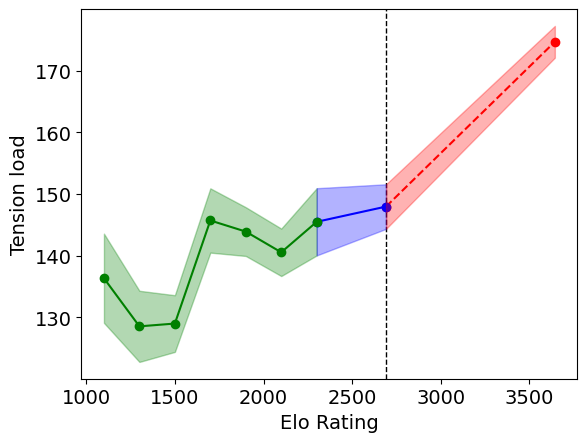

In [16]:
y = []
Dy = []
x = []
j =1000
N = 150
for i in range(7):
    df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\tensione_" + str(int(j+200*i)) + "-" 
                     + str(int(j+200*i+200)) + ".csv")
    T = list(df["T"])
    DT = list(df["DT"])
    x.append(j+200*i+100)
    y.append(sum(T[:N]))
    Dy.append(sum(DT[:N]))
    
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_IA_2900.csv")
T_2900 = list(df["T"])
DT_2900 = list(df["DT"])

    
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione.csv")
T = list(df["T"])
DT = list(df["DT"])
T_IA = list(df["T_IA"])
DT_IA = list(df["DT_IA"])
y1 = sum(T[:N])
y2 = sum(T_IA[:N])

plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()

ax.plot(x, y, label='Humans', color='green', marker='o', markersize=6)
ax.fill_between(x, 
                [m - e for m, e in zip(y, Dy)], 
                [m + e for m, e in zip(y, Dy)], 
                color='green', 
                alpha=0.3, 
                label='Error (Humans)')

#ax.axhline(y=y1, color='blue', linestyle='--', linewidth=2)
#ax.axhline(y=y2, color='red', linestyle='--', linewidth=2)

x = [2300, 2690.9608333333335]
y = [y[-1], y1]
Dy = [Dy[-1], sum(DT[:N])]
ax.plot(x, y, label='Humans', color='blue', marker='o', markersize=6, zorder=1)
ax.fill_between(x, 
                [m - e for m, e in zip(y, Dy)], 
                [m + e for m, e in zip(y, Dy)], 
                color='blue', 
                alpha=0.3, 
                label='Error (Humans)')


x = [2690.9608333333335, 3643.125]
y = [y1, y2]
Dy = [sum(DT[:N]), sum(DT_IA[:N])]
print(Dy)
ax.plot(x, y, label='Humans', color='red', marker='o', markersize=6, zorder=0, linestyle='--')
ax.fill_between(x, 
                [m - e for m, e in zip(y, Dy)], 
                [m + e for m, e in zip(y, Dy)], 
                color='red', 
                alpha=0.3, 
                label='Error (Humans)')

ax.axvline(x=2690.9608333333335, color='black', linestyle='--', linewidth=1, zorder=0)
# 2690.9608333333335
# 3643.125
plt.rcParams.update({'font.size': 14})

#plt.ylim(-0.005, 530)
#plt.xlim(-0.005, 150)
#ax.legend(fontsize=8) 
ax.set_ylabel("Tension load", fontsize=14)
ax.set_xlabel("Elo Rating", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension_ELO.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()

[7.402434450901334, 7.508991855556382]
[7.508991855556382, 2.572843751722639]


<Figure size 800x500 with 0 Axes>

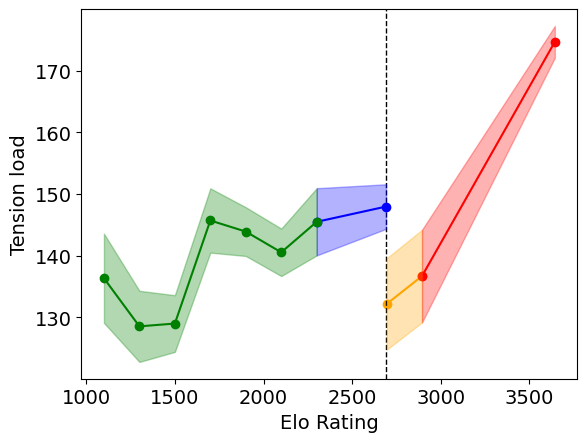

In [25]:



y = []
Dy = []
x = []
j =1000
N = 150
for i in range(7):
    df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\tensione_" + str(int(j+200*i)) + "-" 
                     + str(int(j+200*i+200)) + ".csv")
    T = list(df["T"])
    DT = list(df["DT"])
    x.append(j+200*i+100)
    y.append(sum(T[:N]))
    Dy.append(sum(DT[:N]))
    
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_IA_2900.csv")
T_2900 = list(df["T"])
DT_2900 = list(df["DT"])

df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_IA_2700.csv")
T_2700 = list(df["T"])
DT_2700 = list(df["DT"])

    
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione.csv")
T = list(df["T"])
DT = list(df["DT"])
T_IA = list(df["T_IA"])
DT_IA = list(df["DT_IA"])
y1 = sum(T[:N])
y2 = sum(T_IA[:N])

plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()

ax.plot(x, y, label='Humans', color='green', marker='o', markersize=6)
ax.fill_between(x, 
                [m - e for m, e in zip(y, Dy)], 
                [m + e for m, e in zip(y, Dy)], 
                color='green', 
                alpha=0.3, 
                label='Error (Humans)')

#ax.axhline(y=y1, color='blue', linestyle='--', linewidth=2)
#ax.axhline(y=y2, color='red', linestyle='--', linewidth=2)

x = [2300, 2690.9608333333335]
y = [y[-1], y1]
Dy = [Dy[-1], sum(DT[:N])]
ax.plot(x, y, label='Humans', color='blue', marker='o', markersize=6, zorder=1)
ax.fill_between(x, 
                [m - e for m, e in zip(y, Dy)], 
                [m + e for m, e in zip(y, Dy)], 
                color='blue', 
                alpha=0.3, 
                label='Error (Humans)')


x = [2695, 2894]
y = [sum(T_2700[:N]), sum(T_2900[:N])]
Dy = [sum(DT_2700[:N]), sum(DT_2900[:N])]
print(Dy)
ax.plot(x, y, label='Humans', color='orange', marker='o', markersize=6, zorder=0, linestyle='-')
ax.fill_between(x, 
                [m - e for m, e in zip(y, Dy)], 
                [m + e for m, e in zip(y, Dy)], 
                color='orange', 
                alpha=0.3, 
                label='Error (Humans)')

x = [2894, 3643.125]
y = [sum(T_2900[:N]), y2]
Dy = [sum(DT_2900[:N]), sum(DT_IA[:N])]
print(Dy)
ax.plot(x, y, label='Humans', color='red', marker='o', markersize=6, zorder=0, linestyle='-')
ax.fill_between(x, 
                [m - e for m, e in zip(y, Dy)], 
                [m + e for m, e in zip(y, Dy)], 
                color='red', 
                alpha=0.3, 
                label='Error (Humans)')

ax.axvline(x=2690.9608333333335, color='black', linestyle='--', linewidth=1, zorder=0)
# 2690.9608333333335
# 3643.125
plt.rcParams.update({'font.size': 14})

#plt.ylim(-0.005, 530)
#plt.xlim(-0.005, 150)
#ax.legend(fontsize=8) 
ax.set_ylabel("Tension load", fontsize=14)
ax.set_xlabel("Elo Rating", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension_ELO.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution


plt.show()






In [ ]:
# Process human games
from itertools import zip_longest





S = []
ELO = []

j =1000
N = 100

t = 0

for i in range(7):
    print(i)
    folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\\" + str(int(j+200*i)) + "-" + str(int(j+200*i+200))

    for file_name in os.listdir(folder_path):
            #t += 1
            #print(t)
            #if t >= N:
            #    break
            if file_name.endswith(".pgn"):
                file_path = os.path.join(folder_path, file_name)
                #print(f"Processing file: {file_path}")

                # Detect file encoding
                with open(file_path, 'rb') as f:
                    raw_data = f.read()
                    encoding_info = chardet.detect(raw_data)
                    detected_encoding = encoding_info['encoding']
                    #print(f"Detected encoding for {file_name}: {detected_encoding}")

                # Open and read the PGN file with the detected encoding
                with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                
                    fragility_over_time = list(process_single_game_max_eigenvalue(game))
                    
                    S.append(sum(fragility_over_time[:100]))
                    
                    white_elo = int(game.headers.get("WhiteElo", 0))
                    black_elo = int(game.headers.get("BlackElo", 0))
                    
                    ELO.append((white_elo+black_elo)/2)
                    




df = pd.DataFrame({
    'S': S,
    'ELO': ELO
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_2\scatter_ELO.csv", index=False)



In [ ]:
# Process human games
from itertools import zip_longest
import statistics as st





S = []
ELO = []

j =1000
N = 100

t = 0

for i in range(1):
    print(i)
    folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA"

    for file_name in os.listdir(folder_path):
            t += 1
            print(t)
            #if t >= N:
            #    break
            if file_name.endswith(".pgn"):
                file_path = os.path.join(folder_path, file_name)
                #print(f"Processing file: {file_path}")

                # Detect file encoding
                with open(file_path, 'rb') as f:
                    raw_data = f.read()
                    encoding_info = chardet.detect(raw_data)
                    detected_encoding = encoding_info['encoding']
                    #print(f"Detected encoding for {file_name}: {detected_encoding}")

                # Open and read the PGN file with the detected encoding
                with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                
                    #fragility_over_time = list(process_single_game_max_eigenvalue(game))
                    
                    #S.append(sum(fragility_over_time[:100]))
                    
                    white_elo = int(game.headers.get("WhiteElo", 0))
                    black_elo = int(game.headers.get("BlackElo", 0))
                    
                    ELO.append((white_elo+black_elo)/2)
                    

# 2690.9608333333335
# 3643.125

print(st.mean(ELO))


# Substitute players with stockfish - END 

In [10]:
#!pip install stockfish
from stockfish import Stockfish
import chess.pgn
import random
import pandas as pd

stockfish = Stockfish(path=r"C:\Users\Pc\Desktop\PHYTON\Chess\stockfish\stockfish-windows-x86-64-avx2.exe")

In [10]:
N = 1

folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Humans"

import time

start_time = time.time()
        
turns_to_skip = 12
i = 0

valori = []

#N_tot = 100

v = 0
p = 0

for file_name in os.listdir(folder_path):
    i += 1
    if i <= 18:
        continue
    #if i >= 3:
    #    break
    print(i)
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)
        #print(f"Processing file: {file_path}")
        #print(file_path)
        x = file_path.split("game_")[1].split(".pg")[0]
        print(x)

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']
            #print(f"Detected encoding for {file_name}: {detected_encoding}")

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:
            
            
                # Crea un nuovo gioco
                new_game = chess.pgn.Game()

                # Imposta l'evento e i giocatori
                new_game.headers["Event"] = "Stockfish vs Stockfish"
                new_game.headers["White"] = "Stockfish"
                new_game.headers["Black"] = "Stockfish"
    

                game = chess.pgn.read_game(f)
                
                # Inizializza la scacchiera
                board = game.board()

                # Copia le prime mosse umane nel nuovo PGN
                node = new_game
                old_node = game
                for _ in range(turns_to_skip):
                    if old_node.variations:
                        move = old_node.variations[0].move
                        #print(board)
                        board.push(move)
                        node = node.add_variation(move)  # Aggiunge la mossa al nuovo PGN
                        old_node = old_node.variations[0]
                    else:
                        print(f"Errore: la partita non ha abbastanza mosse per arrivare alla mossa {turns_to_skip}.")
                        break
                #print(board)
                
                # conto le mosse
                j = 0
                

                # Gioca la partita
                while not board.is_game_over():
                    
                    j += 1
                    
                    # Stockfish calcola la mossa migliore
                    if board.turn == chess.WHITE:
                        depth = random.randint(23, 24)
                        #depth = 17  # Profondità per il bianco
                    else:
                        depth = random.randint(22, 23)
                        #depth = 15
                        #depth = random.randint(7, 9)  # Profondità per il nero
                    stockfish.set_depth(depth)
        
                    stockfish.set_fen_position(board.fen())
                    best_move = stockfish.get_best_move()
    
                    # Esegui la mossa sulla scacchiera
                    move = chess.Move.from_uci(best_move)
                    board.push(move)
                
                    #stockfish.set_depth(20)
                    #evaluation = stockfish.get_evaluation()
                    #print(evaluation)
                    
    
                    # Aggiungi la mossa al gioco PGN
                    node = node.add_variation(move)  # Aggiungi la mossa come variazione al nodo corrente
            
                    if j >= 151:
                        break
            
                    #if (abs(evaluation["value"]) >= 355) | ((j > 112) & (abs(evaluation["value"]) <= 22)):
                    #    break
                
                #if (board.result() == "1-0") | (board.result() == "0-1"):
                #    print("vittoria")
                #    v += 1
                #else:
                #    print("pareggio")
                #    p += 1
    
                # Salva la partita in un file PGN
                with open(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA_3100\match_" +  str(x) + ".pgn", "w", encoding="utf-8") as pgn_file:
                    new_game.accept(chess.pgn.FileExporter(pgn_file))
                
                end_time = time.time()
                print(f"Execution time: {end_time - start_time:.4f} seconds")    




                
                    
#print(p/(v+p))


19
1014
Execution time: 470.0237 seconds
20
1015
Execution time: 634.4392 seconds
21
1016
Execution time: 951.1688 seconds
22
1017
Execution time: 1094.3072 seconds
23
1018


KeyboardInterrupt: 

In [27]:
# Process human games
from itertools import zip_longest


folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA_2700"
I = []

res = []

ev = 0
ev2 = 0
First = True
First2 = True
First3 = True
i = 0

N = 100





for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if i >= N:
        #    break
        
        
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    
                
                    fragility_over_time = process_single_game_max_eigenvalue(game)
                    
                    
                    I.append(fragility_over_time)
                    


T = []
DT = []

for n in range(max(len(sublist) for sublist in I)):
    lista = [x[n] for x in I if len(x) > n]  # <--- controllo lunghezza
    try:
        T.append(st.mean(lista))
        DT.append(st.stdev(lista) / (len(lista)**0.5))  # st.dev → st.stdev
    except:
        break

#print(T)
#print(DT)
if len(T) != len(DT):
    T.pop()



df = pd.DataFrame({
    'T': T,
    'DT': DT
})

df.to_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_IA_2700.csv", index=False)



1
Execution time: 0.3449 seconds
2
Execution time: 0.5245 seconds
3
Execution time: 0.4829 seconds
4
Execution time: 0.4759 seconds
5
Execution time: 0.4396 seconds
6
Execution time: 0.3878 seconds
7
Execution time: 0.3184 seconds
8
Execution time: 0.6644 seconds
9
Execution time: 0.5648 seconds
10
Execution time: 0.6411 seconds
11


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()


df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione_IA_2900.csv")
T = list(df["T"])
DT = list(df["DT"])

T = [1] + T
DT = [0] + DT




x = np.arange(1, len(T) + 1)  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "#00FFC6")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='#00FFC6', 
                alpha=0.3, 
                label='Error (Humans)')




#####################################
df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\tensione.csv")
T = list(df["T"])
DT = list(df["DT"])

T = [1] + T
DT = [0] + DT




x = np.arange(0, len(T))  # Adjust ply numbers to start at 1
x_IA = np.arange(0, len(T_IA))  # Adjust ply numbers to start at 1
ax.plot(x, T, label='Humans', color = "#003366")
ax.fill_between(x, 
                [m - e for m, e in zip(T, DT)], 
                [m + e for m, e in zip(T, DT)], 
                color='#003366', 
                alpha=0.3, 
                label='Error (Humans)')
###########################################


plt.rcParams.update({'font.size': 14})
#plt.rcParams.update({'font.size': 10})
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.005, 1.9)
plt.xlim(-0.005, 150)
#ax.legend(fontsize=8) 
ax.set_ylabel("Tension", fontsize=14)
ax.set_xlabel("Ply", fontsize=14)
plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Tension_IA_fake.png", dpi=800, bbox_inches="tight")  # Save as PNG with high resolution



plt.show()

# which is the probability that a player wins if their advantage is 100 cp at move 20? Surely high.

In [ ]:
# Process human games
from itertools import zip_longest



folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\Humans"
I = []



First = True
First2 = True
First3 = True
i = 0

N = 20

df = pd.read_csv(r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\vittorie_pareggi.csv")
res = df["res"]
res_IA = df["res_IA"]

ev = []
evv = []
evp = []

stockfish.set_depth(20)

P = []

for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if (i % 100 >= 11) and (i % 100 <= 99):
        #    continue
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                    
                    board = game.board()  # Inizializza la scacchiera
                    


                    # Applica tutte le mosse fino all'ultima posizione
                    j = 0
                    for move in game.mainline_moves():
                        j += 1
                        if j >= 41:
                            break
                        board.push(move)
                    
                    stockfish.set_fen_position(board.fen())
                    ev_temp = stockfish.get_evaluation()
                    evaluation = ev_temp["value"]
                    
                    #print(evaluation)
                    #print(game.headers["Result"])
                    
                    if evaluation >= 100:
                        if (res[i-1] == 1) & (game.headers["Result"] == "1-0"):
                            P.append(1)
                        else:
                            P.append(0)
                    elif evaluation <= -100:
                        if (res[i-1] == 1) & (game.headers["Result"] == "0-1"):
                            P.append(1)
                        else:
                            P.append(0)
                    
                        
                    
       


                        
            
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\DATI_ARTICOLO\DATI_FIG_1\IA"
I_IA = []
First = True
First2 = True
First3 = True

ev_IA = []
evv_IA = []
evp_IA = []

P_IA = []

i = 0
for file_name in os.listdir(folder_path):
        i += 1
        print(i)
        #if (i % 100 >= 11) and (i % 100 <= 99):
        #    continue
        if file_name.endswith(".pgn"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing file: {file_path}")

            # Detect file encoding
            with open(file_path, 'rb') as f:
                raw_data = f.read()
                encoding_info = chardet.detect(raw_data)
                detected_encoding = encoding_info['encoding']
                #print(f"Detected encoding for {file_name}: {detected_encoding}")

            # Open and read the PGN file with the detected encoding
            with open(file_path, encoding=detected_encoding) as f:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        print(f"No game found in file: {file_name}")
                        continue
                        
                    board = game.board()  # Inizializza la scacchiera
                    

                    j = 0
                    for move in game.mainline_moves():
                        j += 1
                        if j >= 41:
                            break
                        board.push(move)
                    
                    stockfish.set_fen_position(board.fen())
                    ev_temp = stockfish.get_evaluation()
                    evaluation = ev_temp["value"]
                    
                    #print(evaluation)
                    #print(game.headers["Result"])
                    
                    if evaluation >= 100:
                        if (res_IA[i-1] == 1) & (game.headers["Result"] == "1-0"):
                            P_IA.append(1)
                        else:
                            P_IA.append(0)
                    elif evaluation <= -100:
                        if (res_IA[i-1] == 1) & (game.headers["Result"] == "0-1"):
                            P_IA.append(1)
                        else:
                            P_IA.append(0)

                            
print(sum(P)/len(P))
print(sum(P_IA)/len(P_IA))

#0.6666666666666666
#0.5

#0.7135549872122762
#0.5919282511210763
